In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-5).tolist()
        long_ticks = (np.array(long_ticks)-5).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(未含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")

        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】

        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                price_diff = last_trade_price - current_price#【明天開盤 - 今天收盤】

            elif(action == Actions.Sell.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                price_diff = -(last_trade_price - current_price)#【-(明天開盤 - 今天收盤)】
        
        step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if(action == Actions.Buy.value):
                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                long_profit_percentage = ((last_trade_price - current_price)/current_price) - self.trade_fee_percent
                self._total_profit += long_profit_percentage
            elif(action == Actions.Sell.value):

                current_price = self.close[self._current_tick]#【今天收盤】
                last_trade_price = self.open[self._current_tick+1]#【明天開盤】
                short_profit_percentage = ((-(last_trade_price - current_price)) / current_price) - self.trade_fee_percent
                self._total_profit += short_profit_percentage   
                
        step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
if isinstance('2330.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2330.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean_5Day = []#計算RSI——上漲平均5天
DownMean_5Day = []#計算RSI——下跌平均5天
RSI_5Day = []#計算RSI
#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean_5Day.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean_5Day.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean_5Day)):
    RSI_5Day.append( (UpMean_5Day[i] / ( UpMean_5Day[i] + DownMean_5Day[i] )) * 100  )#計算RSI
RSI_5Day = pd.Series(index = close.index[12:], data = RSI_5Day) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI_5Day, columns=['RSI_5Day']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
normalizer = Normalizer()#創建標準化函數
df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI_5Day','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
                                                      3:'FH',4:'FL',
                                                      5:'UpLine',6:'DownLine',
                                                      7:'RSI_5Day',
                                                      8:'K_Value',9:'D_Value',
                                                      10:'DIF',11:'MACD',
                                                      12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df2330

index        open        high         low       close    adjclose  \
0    2000-01-31   77.474449   79.822517   77.083290   79.430984   40.830639   
1    2000-02-01   80.213676   80.213676   78.648293   79.039825   40.629574   
2    2000-02-02   79.039825   79.039825   79.039825   79.039825   40.629574   
3    2000-02-03   79.039825   79.039825   79.039825   79.039825   40.629574   
4    2000-02-04   79.039825   79.039825   79.039825   79.039825   40.629574   
...         ...         ...         ...         ...         ...         ...   
5642 2022-09-02  488.000000  489.500000  485.000000  485.000000  485.000000   
5643 2022-09-05  485.000000  488.000000  484.000000  486.000000  486.000000   
5644 2022-09-06  488.500000  491.500000  486.500000  489.000000  489.000000   
5645 2022-09-07  477.000000  478.000000  472.000000  472.500000  472.500000   
5646 2022-09-08  473.000000  475.000000  472.000000  475.000000  475.000000   

            volume   ticker    MinLow   MaxHigh  ...    UpLine  DownLine  \
0     1.680593e+11  2330.TW  0.309921  0.361288  ...  0.001713  0.001712   
1     1.530819e+11  2330.TW  0.314672  0.366827  ...  0.000000  0.001740   
2     0.000000e+00  2330.TW  0.319760  0.370711  ...  0.000000  0.000000   
3     0.000000e+00  2330.TW  0.329770  0.372094  ...  0.000000  0.000000   
4     0.000000e+00  2330.TW  0.339458  0.376977  ...  0.000000  0.000000   
...            ...      ...       ...       ...  ...       ...       ...   
5642  2.998296e+07  2330.TW  0.428694  0.455212  ...  0.001326  0.000000   
5643  1.590342e+07  2330.TW  0.428598  0.456049  ...  0.001771  0.000886   
5644  1.670028e+07  2330.TW  0.429046  0.456526  ...  0.002216  0.001773   
5645  3.467856e+07  2330.TW  0.421029  0.459385  ...  0.000892  0.000446   
5646  2.793155e+07  2330.TW  0.423638  0.453257  ...  0.000000  0.000898   

      RSI_5Day   K_Value   D_Value       DIF      MACD  Up_Track  Mid_Track  \
0     0.340351  0.351078  0.349870  0.011103  0.006873  0.354890   0.319509   
1     0.327941  0.341312  0.350593  0.011484  0.007879  0.363530   0.326493   
2     0.315521  0.333172  0.347261  0.011640  0.008698  0.370338   0.331708   
3     0.344641  0.316836  0.337983  0.011578  0.009300  0.374065   0.335061   
4     0.349164  0.300968  0.328601  0.011512  0.009840  0.380023   0.342048   
...        ...       ...       ...       ...       ...       ...        ...   
5642  0.020398  0.010288  0.018185 -0.001807  0.001441  0.469600   0.449952   
5643  0.023368  0.008776  0.015071 -0.002762  0.000602  0.471173   0.449629   
5644  0.026354  0.010623  0.013599 -0.003269 -0.000172  0.471885   0.449168   
5645  0.023502  0.007472  0.011613 -0.004823 -0.001103  0.477128   0.450755   
5646  0.028192  0.007732  0.010367 -0.005827 -0.002053  0.480573   0.451798   

      Down_Track  
0       0.284129  
1       0.289457  
2       0.293078  
3       0.296056  
4       0.304073  
...          ...  
5642    0.430305  
5643    0.428086  
5644    0.426451  
5645    0.424382  
5646    0.423024  

[5647 rows x 23 columns]

# 查找DF的標籤

In [6]:
df20190101 = df2330[(df2330['index']=='2019-01-02')].index.values
df20190101 = df20190101[0]
df20190101

4751

In [7]:
df20211231 = df2330[(df2330['index']=='2021-12-30')].index.values
df20211231 = df20211231[0]
df20211231

5479

In [8]:
df2330[df20190101:df20211231+1]#2017-01-01 ~ 2021-12-31 【5年】

index   open   high    low  close    adjclose      volume   ticker  \
4751 2019-01-02  226.5  226.5  219.0  219.5  197.968719  32900482.0  2330.TW   
4752 2019-01-03  214.0  218.0  214.0  215.5  194.361069  34087620.0  2330.TW   
4753 2019-01-04  211.5  211.5  206.5  208.0  187.596756  65943521.0  2330.TW   
4754 2019-01-07  212.0  214.0  211.0  213.0  192.106293  35442176.0  2330.TW   
4755 2019-01-08  212.0  212.5  210.0  211.0  190.302490  22694481.0  2330.TW   
...         ...    ...    ...    ...    ...         ...         ...      ...   
5475 2021-12-24  606.0  609.0  604.0  604.0  597.776123  11059689.0  2330.TW   
5476 2021-12-27  604.0  610.0  604.0  606.0  599.755554  16259872.0  2330.TW   
5477 2021-12-28  610.0  615.0  610.0  615.0  608.662781  33892718.0  2330.TW   
5478 2021-12-29  615.0  619.0  614.0  616.0  609.652527  24518766.0  2330.TW   
5479 2021-12-30  619.0  620.0  615.0  615.0  608.662781  19681276.0  2330.TW   

        MinLow   MaxHigh  ...    UpLine  DownLine  RSI_5Day   K_Value  \
4751  0.425773  0.448546  ...  0.000000  0.000990  0.081854  0.106920   
4752  0.427740  0.452725  ...  0.004997  0.000000  0.081529  0.079939   
4753  0.417943  0.458421  ...  0.000000  0.003036  0.065948  0.059023   
4754  0.417143  0.457544  ...  0.002020  0.002020  0.081219  0.061157   
4755  0.418808  0.459371  ...  0.001014  0.002028  0.070451  0.056145   
...        ...       ...  ...       ...       ...       ...       ...   
5475  0.440381  0.450743  ...  0.002220  0.000000  0.038689  0.037547   
5476  0.439704  0.450789  ...  0.002956  0.000000  0.035102  0.043057   
5477  0.437520  0.452227  ...  0.000000  0.000000  0.044759  0.053073   
5478  0.436575  0.454185  ...  0.002201  0.000734  0.049485  0.056707   
5479  0.436456  0.454795  ...  0.000734  0.000000  0.050649  0.057355   

       D_Value       DIF      MACD  Up_Track  Mid_Track  Down_Track  
4751  0.094934 -0.003399 -0.003720  0.456271   0.441170    0.426069  
4752  0.090525 -0.004182 -0.003840  0.456090   0.443431    0.430772  
4753  0.080784 -0.005993 -0.004309  0.464337   0.447188    0.430040  
4754  0.074139 -0.006483 -0.004737  0.464113   0.445625    0.427138  
4755  0.068338 -0.007153 -0.005236  0.466789   0.446391    0.425992  
...        ...       ...       ...       ...        ...         ...  
5475  0.030740  0.000005  0.000119  0.453421   0.445969    0.438516  
5476  0.034814  0.000206  0.000136  0.452530   0.445763    0.438997  
5477  0.040785  0.000887  0.000286  0.451517   0.444248    0.436980  
5478  0.046034  0.001466  0.000521  0.451906   0.443876    0.435845  
5479  0.049799  0.001846  0.000786  0.451783   0.443755    0.435727  

[729 rows x 23 columns]

In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    signal_features = df.loc[:, ['Up_Track', 'Mid_Track','Down_Track']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._signal_features

    
open, close, high, low, volume, signal_features = my_process_data(df=df2330, window_size=5, frame_bound=(df20190101, df20211231))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df2330, window_size=5, frame_bound=(df20190101, df20211231))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[128, 128, 128], pi=[128, 128, 128])])#要傳遞給policy的參數

model = A2C('MlpLnLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)#MlpLnLstmPolicy 標準化LSTM
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=10000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | -0.0569  |
| fps                | 7        |
| nupdates           | 1        |
| policy_entropy     | 0.524    |
| total_timesteps    | 5        |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00033  |
| fps                | 300      |
| nupdates           | 100      |
| policy_entropy     | 0.685    |
| total_timesteps    | 500      |
| value_loss         | 466      |
---------------------------------
----------------------------------
| explained_variance | -0.000

---------------------------------
| explained_variance | 0.00206  |
| fps                | 508      |
| nupdates           | 1500     |
| policy_entropy     | 0.0163   |
| total_timesteps    | 7500     |
| value_loss         | 5.57     |
---------------------------------
---------------------------------
| explained_variance | 2.93e-05 |
| fps                | 507      |
| nupdates           | 1600     |
| policy_entropy     | 0.0102   |
| total_timesteps    | 8000     |
| value_loss         | 10.8     |
---------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 509       |
| nupdates           | 1700      |
| policy_entropy     | 0.00761   |
| total_timesteps    | 8500      |
| value_loss         | 217       |
----------------------------------
---------------------------------
| explained_variance | 1.65e-05 |
| fps                | 510      |
| nupdates           | 1800     |
| policy_entropy     | 0.0121   |
| tota

----------------------------------
| explained_variance | -2.36e-05 |
| fps                | 526       |
| nupdates           | 4500      |
| policy_entropy     | 0.00456   |
| total_timesteps    | 22500     |
| value_loss         | 103       |
----------------------------------
---------------------------------
| explained_variance | 8.7e-06  |
| fps                | 526      |
| nupdates           | 4600     |
| policy_entropy     | 0.00381  |
| total_timesteps    | 23000    |
| value_loss         | 8.81     |
---------------------------------
---------------------------------
| explained_variance | 3.83e-05 |
| fps                | 525      |
| nupdates           | 4700     |
| policy_entropy     | 0.0031   |
| total_timesteps    | 23500    |
| value_loss         | 17.4     |
---------------------------------
---------------------------------
| explained_variance | 1.85e-05 |
| fps                | 525      |
| nupdates           | 4800     |
| policy_entropy     | 0.00287  |
| tota

---------------------------------
| explained_variance | 1.12e-05 |
| fps                | 518      |
| nupdates           | 7500     |
| policy_entropy     | 0.00112  |
| total_timesteps    | 37500    |
| value_loss         | 25.6     |
---------------------------------
----------------------------------
| explained_variance | -1.36e-05 |
| fps                | 519       |
| nupdates           | 7600      |
| policy_entropy     | 0.00115   |
| total_timesteps    | 38000     |
| value_loss         | 21.2      |
----------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 519       |
| nupdates           | 7700      |
| policy_entropy     | 0.00113   |
| total_timesteps    | 38500     |
| value_loss         | 171       |
----------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 520      |
| nupdates           | 7800     |
| policy_entropy     | 0.00128  

---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 516      |
| nupdates           | 10500    |
| policy_entropy     | 0.000111 |
| total_timesteps    | 52500    |
| value_loss         | 21       |
---------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 516       |
| nupdates           | 10600     |
| policy_entropy     | 0.000111  |
| total_timesteps    | 53000     |
| value_loss         | 14.3      |
----------------------------------
---------------------------------
| explained_variance | 7.27e-06 |
| fps                | 516      |
| nupdates           | 10700    |
| policy_entropy     | 0.000115 |
| total_timesteps    | 53500    |
| value_loss         | 5.84     |
---------------------------------
---------------------------------
| explained_variance | 6.67e-05 |
| fps                | 516      |
| nupdates           | 10800    |
| policy_entropy     | 0.000114 |
| tota

---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 515      |
| nupdates           | 13500    |
| policy_entropy     | 0.000124 |
| total_timesteps    | 67500    |
| value_loss         | 616      |
---------------------------------
---------------------------------
| explained_variance | 1.16e-05 |
| fps                | 515      |
| nupdates           | 13600    |
| policy_entropy     | 0.00013  |
| total_timesteps    | 68000    |
| value_loss         | 24.3     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 515      |
| nupdates           | 13700    |
| policy_entropy     | 0.000126 |
| total_timesteps    | 68500    |
| value_loss         | 29.5     |
---------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 515      |
| nupdates           | 13800    |
| policy_entropy     | 0.000125 |
| total_timest

----------------------------------
| explained_variance | -4.92e-05 |
| fps                | 517       |
| nupdates           | 16500     |
| policy_entropy     | 0.00014   |
| total_timesteps    | 82500     |
| value_loss         | 28.6      |
----------------------------------
---------------------------------
| explained_variance | 0.000593 |
| fps                | 517      |
| nupdates           | 16600    |
| policy_entropy     | 0.00034  |
| total_timesteps    | 83000    |
| value_loss         | 2.37     |
---------------------------------
---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 517      |
| nupdates           | 16700    |
| policy_entropy     | 0.000141 |
| total_timesteps    | 83500    |
| value_loss         | 742      |
---------------------------------
---------------------------------
| explained_variance | 4.17e-06 |
| fps                | 517      |
| nupdates           | 16800    |
| policy_entropy     | 0.000136 |
| tota

---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 515      |
| nupdates           | 19500    |
| policy_entropy     | 0.000167 |
| total_timesteps    | 97500    |
| value_loss         | 653      |
---------------------------------
----------------------------------
| explained_variance | -1.22e-05 |
| fps                | 515       |
| nupdates           | 19600     |
| policy_entropy     | 0.000157  |
| total_timesteps    | 98000     |
| value_loss         | 16.4      |
----------------------------------
---------------------------------
| explained_variance | 6.93e-05 |
| fps                | 515      |
| nupdates           | 19700    |
| policy_entropy     | 0.000152 |
| total_timesteps    | 98500    |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | 1.45e-05 |
| fps                | 515      |
| nupdates           | 19800    |
| policy_entropy     | 0.000174 |
| tota

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 515       |
| nupdates           | 22500     |
| policy_entropy     | 0.000195  |
| total_timesteps    | 112500    |
| value_loss         | 64.8      |
----------------------------------
---------------------------------
| explained_variance | 1.68e-05 |
| fps                | 515      |
| nupdates           | 22600    |
| policy_entropy     | 0.000178 |
| total_timesteps    | 113000   |
| value_loss         | 4.15     |
---------------------------------
---------------------------------
| explained_variance | -8.7e-06 |
| fps                | 515      |
| nupdates           | 22700    |
| policy_entropy     | 0.000221 |
| total_timesteps    | 113500   |
| value_loss         | 110      |
---------------------------------
---------------------------------
| explained_variance | 1.19e-05 |
| fps                | 515      |
| nupdates           | 22800    |
| policy_entropy     | 0.000209 |
| tota

---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 514      |
| nupdates           | 25500    |
| policy_entropy     | 0.000211 |
| total_timesteps    | 127500   |
| value_loss         | 13.4     |
---------------------------------
----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 514       |
| nupdates           | 25600     |
| policy_entropy     | 0.00026   |
| total_timesteps    | 128000    |
| value_loss         | 155       |
----------------------------------
---------------------------------
| explained_variance | 2.39e-05 |
| fps                | 514      |
| nupdates           | 25700    |
| policy_entropy     | 0.000267 |
| total_timesteps    | 128500   |
| value_loss         | 24.5     |
---------------------------------
----------------------------------
| explained_variance | -2.87e-05 |
| fps                | 514       |
| nupdates           | 25800     |
| policy_entropy     | 0.000262  |
|

---------------------------------
| explained_variance | 9.42e-06 |
| fps                | 515      |
| nupdates           | 28500    |
| policy_entropy     | 7.19e-05 |
| total_timesteps    | 142500   |
| value_loss         | 58.5     |
---------------------------------
---------------------------------
| explained_variance | 2.23e-05 |
| fps                | 515      |
| nupdates           | 28600    |
| policy_entropy     | 7.2e-05  |
| total_timesteps    | 143000   |
| value_loss         | 6.72     |
---------------------------------
----------------------------------
| explained_variance | -3.12e-05 |
| fps                | 515       |
| nupdates           | 28700     |
| policy_entropy     | 6.62e-05  |
| total_timesteps    | 143500    |
| value_loss         | 21.3      |
----------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 515       |
| nupdates           | 28800     |
| policy_entropy     | 6.42e-05  |
|

---------------------------------
| explained_variance | 1.1e-05  |
| fps                | 516      |
| nupdates           | 31500    |
| policy_entropy     | 2.41e-05 |
| total_timesteps    | 157500   |
| value_loss         | 98.5     |
---------------------------------
---------------------------------
| explained_variance | 0.000188 |
| fps                | 516      |
| nupdates           | 31600    |
| policy_entropy     | 2.08e-05 |
| total_timesteps    | 158000   |
| value_loss         | 23       |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 516      |
| nupdates           | 31700    |
| policy_entropy     | 2.25e-05 |
| total_timesteps    | 158500   |
| value_loss         | 616      |
---------------------------------
---------------------------------
| explained_variance | 1.27e-05 |
| fps                | 516      |
| nupdates           | 31800    |
| policy_entropy     | 2.46e-05 |
| total_timest

----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 516       |
| nupdates           | 34500     |
| policy_entropy     | 2.76e-05  |
| total_timesteps    | 172500    |
| value_loss         | 131       |
----------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 516      |
| nupdates           | 34600    |
| policy_entropy     | 2.66e-05 |
| total_timesteps    | 173000   |
| value_loss         | 287      |
---------------------------------
----------------------------------
| explained_variance | -6.41e-05 |
| fps                | 516       |
| nupdates           | 34700     |
| policy_entropy     | 2.66e-05  |
| total_timesteps    | 173500    |
| value_loss         | 28.6      |
----------------------------------
---------------------------------
| explained_variance | 0.000463 |
| fps                | 516      |
| nupdates           | 34800    |
| policy_entropy     | 5.96e-05 

----------------------------------
| explained_variance | -1.37e-05 |
| fps                | 515       |
| nupdates           | 37500     |
| policy_entropy     | 2.56e-05  |
| total_timesteps    | 187500    |
| value_loss         | 31.9      |
----------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 515      |
| nupdates           | 37600    |
| policy_entropy     | 2.52e-05 |
| total_timesteps    | 188000   |
| value_loss         | 7.34     |
---------------------------------
---------------------------------
| explained_variance | 4.11e-06 |
| fps                | 515      |
| nupdates           | 37700    |
| policy_entropy     | 2.68e-05 |
| total_timesteps    | 188500   |
| value_loss         | 653      |
---------------------------------
----------------------------------
| explained_variance | -1.17e-05 |
| fps                | 515       |
| nupdates           | 37800     |
| policy_entropy     | 2.52e-05  |
|

---------------------------------
| explained_variance | 9.78e-06 |
| fps                | 516      |
| nupdates           | 40500    |
| policy_entropy     | 3.4e-05  |
| total_timesteps    | 202500   |
| value_loss         | 26.7     |
---------------------------------
---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 516      |
| nupdates           | 40600    |
| policy_entropy     | 3.61e-05 |
| total_timesteps    | 203000   |
| value_loss         | 160      |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 516       |
| nupdates           | 40700     |
| policy_entropy     | 3.58e-05  |
| total_timesteps    | 203500    |
| value_loss         | 64.8      |
----------------------------------
---------------------------------
| explained_variance | 3.16e-05 |
| fps                | 516      |
| nupdates           | 40800    |
| policy_entropy     | 3.26e-05 |
| tota

---------------------------------
| explained_variance | 1.03e-05 |
| fps                | 515      |
| nupdates           | 43500    |
| policy_entropy     | 4.31e-05 |
| total_timesteps    | 217500   |
| value_loss         | 3.6      |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 515       |
| nupdates           | 43600     |
| policy_entropy     | 3.98e-05  |
| total_timesteps    | 218000    |
| value_loss         | 24.4      |
----------------------------------
----------------------------------
| explained_variance | -5.96e-06 |
| fps                | 515       |
| nupdates           | 43700     |
| policy_entropy     | 3.79e-05  |
| total_timesteps    | 218500    |
| value_loss         | 13.4      |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 515       |
| nupdates           | 43800     |
| policy_entropy     | 4.71e

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 515       |
| nupdates           | 46500     |
| policy_entropy     | 4.67e-05  |
| total_timesteps    | 232500    |
| value_loss         | 77.5      |
----------------------------------
---------------------------------
| explained_variance | -2.5e-05 |
| fps                | 515      |
| nupdates           | 46600    |
| policy_entropy     | 4.24e-05 |
| total_timesteps    | 233000   |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | 2.53e-05 |
| fps                | 514      |
| nupdates           | 46700    |
| policy_entropy     | 6.17e-05 |
| total_timesteps    | 233500   |
| value_loss         | 58.5     |
---------------------------------
---------------------------------
| explained_variance | 4.02e-05 |
| fps                | 514      |
| nupdates           | 46800    |
| policy_entropy     | 6.07e-05 |
| tota

---------------------------------
| explained_variance | 6.44e-06 |
| fps                | 511      |
| nupdates           | 49500    |
| policy_entropy     | 3.63e-05 |
| total_timesteps    | 247500   |
| value_loss         | 19.2     |
---------------------------------
---------------------------------
| explained_variance | 8.5e-05  |
| fps                | 511      |
| nupdates           | 49600    |
| policy_entropy     | 0.000102 |
| total_timesteps    | 248000   |
| value_loss         | 12.6     |
---------------------------------
---------------------------------
| explained_variance | 8.88e-05 |
| fps                | 511      |
| nupdates           | 49700    |
| policy_entropy     | 0.000131 |
| total_timesteps    | 248500   |
| value_loss         | 98.4     |
---------------------------------
----------------------------------
| explained_variance | -8.76e-05 |
| fps                | 511       |
| nupdates           | 49800     |
| policy_entropy     | 6.09e-05  |
| total_t

----------------------------------
| explained_variance | -7.65e-05 |
| fps                | 508       |
| nupdates           | 52500     |
| policy_entropy     | 0.000387  |
| total_timesteps    | 262500    |
| value_loss         | 20.2      |
----------------------------------
---------------------------------
| explained_variance | 0.000135 |
| fps                | 508      |
| nupdates           | 52600    |
| policy_entropy     | 0.000474 |
| total_timesteps    | 263000   |
| value_loss         | 2.21     |
---------------------------------
----------------------------------
| explained_variance | -8.82e-06 |
| fps                | 508       |
| nupdates           | 52700     |
| policy_entropy     | 0.000439  |
| total_timesteps    | 263500    |
| value_loss         | 131       |
----------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 508      |
| nupdates           | 52800    |
| policy_entropy     | 0.000362 

---------------------------------
| explained_variance | 0.000172 |
| fps                | 509      |
| nupdates           | 55500    |
| policy_entropy     | 0.000669 |
| total_timesteps    | 277500   |
| value_loss         | 50.2     |
---------------------------------
---------------------------------
| explained_variance | -3.6e-05 |
| fps                | 509      |
| nupdates           | 55600    |
| policy_entropy     | 0.000523 |
| total_timesteps    | 278000   |
| value_loss         | 51.3     |
---------------------------------
----------------------------------
| explained_variance | -3.59e-05 |
| fps                | 509       |
| nupdates           | 55700     |
| policy_entropy     | 0.000467  |
| total_timesteps    | 278500    |
| value_loss         | 31.9      |
----------------------------------
---------------------------------
| explained_variance | 7.13e-05 |
| fps                | 509      |
| nupdates           | 55800    |
| policy_entropy     | 0.000483 |
| tota

---------------------------------
| explained_variance | 7.51e-06 |
| fps                | 507      |
| nupdates           | 58500    |
| policy_entropy     | 0.00102  |
| total_timesteps    | 292500   |
| value_loss         | 32.5     |
---------------------------------
----------------------------------
| explained_variance | -0.000573 |
| fps                | 507       |
| nupdates           | 58600     |
| policy_entropy     | 0.00135   |
| total_timesteps    | 293000    |
| value_loss         | 10.5      |
----------------------------------
---------------------------------
| explained_variance | 2.74e-05 |
| fps                | 507      |
| nupdates           | 58700    |
| policy_entropy     | 0.00131  |
| total_timesteps    | 293500   |
| value_loss         | 26.7     |
---------------------------------
---------------------------------
| explained_variance | 2.87e-05 |
| fps                | 507      |
| nupdates           | 58800    |
| policy_entropy     | 0.00135  |
| tota

---------------------------------
| explained_variance | 0.000134 |
| fps                | 508      |
| nupdates           | 61500    |
| policy_entropy     | 0.00227  |
| total_timesteps    | 307500   |
| value_loss         | 650      |
---------------------------------
----------------------------------
| explained_variance | -0.000108 |
| fps                | 508       |
| nupdates           | 61600     |
| policy_entropy     | 0.00167   |
| total_timesteps    | 308000    |
| value_loss         | 65.1      |
----------------------------------
---------------------------------
| explained_variance | 6.47e-05 |
| fps                | 508      |
| nupdates           | 61700    |
| policy_entropy     | 0.00192  |
| total_timesteps    | 308500   |
| value_loss         | 3.6      |
---------------------------------
----------------------------------
| explained_variance | -3.54e-05 |
| fps                | 508       |
| nupdates           | 61800     |
| policy_entropy     | 0.000468  |
|

---------------------------------
| explained_variance | 4.29e-06 |
| fps                | 507      |
| nupdates           | 64500    |
| policy_entropy     | 0.000569 |
| total_timesteps    | 322500   |
| value_loss         | 18.3     |
---------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 507       |
| nupdates           | 64600     |
| policy_entropy     | 0.000782  |
| total_timesteps    | 323000    |
| value_loss         | 419       |
----------------------------------
---------------------------------
| explained_variance | 7.87e-06 |
| fps                | 507      |
| nupdates           | 64700    |
| policy_entropy     | 0.000643 |
| total_timesteps    | 323500   |
| value_loss         | 77.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00062  |
| fps                | 507      |
| nupdates           | 64800    |
| policy_entropy     | 0.000739 |
| tota

---------------------------------
| explained_variance | 9.45e-05 |
| fps                | 507      |
| nupdates           | 67500    |
| policy_entropy     | 0.000676 |
| total_timesteps    | 337500   |
| value_loss         | 2.78     |
---------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 507       |
| nupdates           | 67600     |
| policy_entropy     | 0.000512  |
| total_timesteps    | 338000    |
| value_loss         | 2.07      |
----------------------------------
---------------------------------
| explained_variance | 9.48e-06 |
| fps                | 507      |
| nupdates           | 67700    |
| policy_entropy     | 0.000468 |
| total_timesteps    | 338500   |
| value_loss         | 19.2     |
---------------------------------
---------------------------------
| explained_variance | 0.000517 |
| fps                | 507      |
| nupdates           | 67800    |
| policy_entropy     | 0.00105  |
| tota

----------------------------------
| explained_variance | -3.45e-05 |
| fps                | 508       |
| nupdates           | 70500     |
| policy_entropy     | 0.00102   |
| total_timesteps    | 352500    |
| value_loss         | 3.04      |
----------------------------------
---------------------------------
| explained_variance | 0.000133 |
| fps                | 508      |
| nupdates           | 70600    |
| policy_entropy     | 0.000803 |
| total_timesteps    | 353000   |
| value_loss         | 10.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000771 |
| fps                | 508       |
| nupdates           | 70700     |
| policy_entropy     | 0.00158   |
| total_timesteps    | 353500    |
| value_loss         | 20.3      |
----------------------------------
---------------------------------
| explained_variance | 0.000297 |
| fps                | 508      |
| nupdates           | 70800    |
| policy_entropy     | 0.00123  

----------------------------------
| explained_variance | -5.09e-05 |
| fps                | 508       |
| nupdates           | 73500     |
| policy_entropy     | 0.000124  |
| total_timesteps    | 367500    |
| value_loss         | 11.7      |
----------------------------------
---------------------------------
| explained_variance | 0.000723 |
| fps                | 508      |
| nupdates           | 73600    |
| policy_entropy     | 0.000162 |
| total_timesteps    | 368000   |
| value_loss         | 51.7     |
---------------------------------
---------------------------------
| explained_variance | 0.000195 |
| fps                | 508      |
| nupdates           | 73700    |
| policy_entropy     | 0.000204 |
| total_timesteps    | 368500   |
| value_loss         | 50.2     |
---------------------------------
----------------------------------
| explained_variance | -3.61e-05 |
| fps                | 508       |
| nupdates           | 73800     |
| policy_entropy     | 0.000165  |
|

---------------------------------
| explained_variance | 0.000839 |
| fps                | 509      |
| nupdates           | 76500    |
| policy_entropy     | 0.000344 |
| total_timesteps    | 382500   |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 6.47e-05 |
| fps                | 509      |
| nupdates           | 76600    |
| policy_entropy     | 0.0009   |
| total_timesteps    | 383000   |
| value_loss         | 41       |
---------------------------------
---------------------------------
| explained_variance | 7.45e-06 |
| fps                | 509      |
| nupdates           | 76700    |
| policy_entropy     | 0.000742 |
| total_timesteps    | 383500   |
| value_loss         | 32.5     |
---------------------------------
----------------------------------
| explained_variance | -0.000563 |
| fps                | 509       |
| nupdates           | 76800     |
| policy_entropy     | 0.000932  |
| total_t

---------------------------------
| explained_variance | 0.0142   |
| fps                | 508      |
| nupdates           | 79500    |
| policy_entropy     | 0.00182  |
| total_timesteps    | 397500   |
| value_loss         | 45       |
---------------------------------
----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 508       |
| nupdates           | 79600     |
| policy_entropy     | 0.000555  |
| total_timesteps    | 398000    |
| value_loss         | 1.09e+03  |
----------------------------------
---------------------------------
| explained_variance | 8.74e-05 |
| fps                | 508      |
| nupdates           | 79700    |
| policy_entropy     | 0.000873 |
| total_timesteps    | 398500   |
| value_loss         | 649      |
---------------------------------
----------------------------------
| explained_variance | -2.48e-05 |
| fps                | 508       |
| nupdates           | 79800     |
| policy_entropy     | 0.000578  |
|

---------------------------------
| explained_variance | 1.91e-05 |
| fps                | 507      |
| nupdates           | 82500    |
| policy_entropy     | 0.00093  |
| total_timesteps    | 412500   |
| value_loss         | 72.7     |
---------------------------------
----------------------------------
| explained_variance | -6.79e-05 |
| fps                | 507       |
| nupdates           | 82600     |
| policy_entropy     | 0.0013    |
| total_timesteps    | 413000    |
| value_loss         | 7.18      |
----------------------------------
---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 507      |
| nupdates           | 82700    |
| policy_entropy     | 0.000753 |
| total_timesteps    | 413500   |
| value_loss         | 18.3     |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 506       |
| nupdates           | 82800     |
| policy_entropy     | 0.00101   |
|

---------------------------------
| explained_variance | 0.000412 |
| fps                | 505      |
| nupdates           | 85500    |
| policy_entropy     | 0.000253 |
| total_timesteps    | 427500   |
| value_loss         | 11.9     |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 505       |
| nupdates           | 85600     |
| policy_entropy     | 0.000176  |
| total_timesteps    | 428000    |
| value_loss         | 318       |
----------------------------------
---------------------------------
| explained_variance | 5.67e-05 |
| fps                | 505      |
| nupdates           | 85700    |
| policy_entropy     | 0.000259 |
| total_timesteps    | 428500   |
| value_loss         | 2.78     |
---------------------------------
---------------------------------
| explained_variance | 9.6e-06  |
| fps                | 505      |
| nupdates           | 85800    |
| policy_entropy     | 0.000185 |
| tota

---------------------------------
| explained_variance | 9.95e-06 |
| fps                | 504      |
| nupdates           | 88500    |
| policy_entropy     | 0.000137 |
| total_timesteps    | 442500   |
| value_loss         | 5.02     |
---------------------------------
----------------------------------
| explained_variance | -5.89e-05 |
| fps                | 504       |
| nupdates           | 88600     |
| policy_entropy     | 5.4e-05   |
| total_timesteps    | 443000    |
| value_loss         | 4.8e+03   |
----------------------------------
----------------------------------
| explained_variance | -3.61e-05 |
| fps                | 504       |
| nupdates           | 88700     |
| policy_entropy     | 4.09e-05  |
| total_timesteps    | 443500    |
| value_loss         | 3.05      |
----------------------------------
---------------------------------
| explained_variance | 0.00011  |
| fps                | 504      |
| nupdates           | 88800    |
| policy_entropy     | 3.6e-05  

----------------------------------
| explained_variance | -0.000391 |
| fps                | 504       |
| nupdates           | 91500     |
| policy_entropy     | 0.000117  |
| total_timesteps    | 457500    |
| value_loss         | 25.3      |
----------------------------------
----------------------------------
| explained_variance | -7.63e-05 |
| fps                | 504       |
| nupdates           | 91600     |
| policy_entropy     | 9e-05     |
| total_timesteps    | 458000    |
| value_loss         | 7.3       |
----------------------------------
----------------------------------
| explained_variance | -5.88e-05 |
| fps                | 504       |
| nupdates           | 91700     |
| policy_entropy     | 6.18e-05  |
| total_timesteps    | 458500    |
| value_loss         | 11.7      |
----------------------------------
---------------------------------
| explained_variance | 0.000584 |
| fps                | 504      |
| nupdates           | 91800    |
| policy_entropy     | 7

---------------------------------
| explained_variance | -0.0062  |
| fps                | 503      |
| nupdates           | 94500    |
| policy_entropy     | 0.000308 |
| total_timesteps    | 472500   |
| value_loss         | 6.94     |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 503      |
| nupdates           | 94600    |
| policy_entropy     | 0.000165 |
| total_timesteps    | 473000   |
| value_loss         | 25.5     |
---------------------------------
---------------------------------
| explained_variance | 0.000812 |
| fps                | 503      |
| nupdates           | 94700    |
| policy_entropy     | 0.000213 |
| total_timesteps    | 473500   |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 3.3e-05  |
| fps                | 503      |
| nupdates           | 94800    |
| policy_entropy     | 0.000325 |
| total_timest

----------------------------------
| explained_variance | -4.42e-05 |
| fps                | 504       |
| nupdates           | 97500     |
| policy_entropy     | 0.000511  |
| total_timesteps    | 487500    |
| value_loss         | 94.3      |
----------------------------------
----------------------------------
| explained_variance | -0.000212 |
| fps                | 504       |
| nupdates           | 97600     |
| policy_entropy     | 0.000474  |
| total_timesteps    | 488000    |
| value_loss         | 19.1      |
----------------------------------
---------------------------------
| explained_variance | 0.0108   |
| fps                | 504      |
| nupdates           | 97700    |
| policy_entropy     | 0.00104  |
| total_timesteps    | 488500   |
| value_loss         | 45.3     |
---------------------------------
----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 504       |
| nupdates           | 97800     |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 1.5e-05  |
| fps                | 504      |
| nupdates           | 100500   |
| policy_entropy     | 4.39e-05 |
| total_timesteps    | 502500   |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | -0.00031 |
| fps                | 504      |
| nupdates           | 100600   |
| policy_entropy     | 4.63e-05 |
| total_timesteps    | 503000   |
| value_loss         | 40.6     |
---------------------------------
---------------------------------
| explained_variance | 2.56e-05 |
| fps                | 504      |
| nupdates           | 100700   |
| policy_entropy     | 3.95e-05 |
| total_timesteps    | 503500   |
| value_loss         | 72.7     |
---------------------------------
----------------------------------
| explained_variance | -6.08e-05 |
| fps                | 504       |
| nupdates           | 100800    |
| policy_entropy     | 4.63e-05  |
| total_t

---------------------------------
| explained_variance | 1.42e-05 |
| fps                | 503      |
| nupdates           | 103500   |
| policy_entropy     | 9.91e-05 |
| total_timesteps    | 517500   |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 1.41e-05 |
| fps                | 503      |
| nupdates           | 103600   |
| policy_entropy     | 8.23e-05 |
| total_timesteps    | 518000   |
| value_loss         | 30.1     |
---------------------------------
---------------------------------
| explained_variance | 0.000347 |
| fps                | 503      |
| nupdates           | 103700   |
| policy_entropy     | 9.09e-05 |
| total_timesteps    | 518500   |
| value_loss         | 11.8     |
---------------------------------
----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 503       |
| nupdates           | 103800    |
| policy_entropy     | 6.93e-05  |
| total_t

---------------------------------
| explained_variance | 4.61e-05 |
| fps                | 503      |
| nupdates           | 106500   |
| policy_entropy     | 0.000261 |
| total_timesteps    | 532500   |
| value_loss         | 14.8     |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 503       |
| nupdates           | 106600    |
| policy_entropy     | 0.00027   |
| total_timesteps    | 533000    |
| value_loss         | 32.5      |
----------------------------------
---------------------------------
| explained_variance | 9.72e-06 |
| fps                | 503      |
| nupdates           | 106700   |
| policy_entropy     | 0.000188 |
| total_timesteps    | 533500   |
| value_loss         | 5.02     |
---------------------------------
----------------------------------
| explained_variance | -4.39e-05 |
| fps                | 503       |
| nupdates           | 106800    |
| policy_entropy     | 0.000405  |
|

----------------------------------
| explained_variance | -9.08e-05 |
| fps                | 503       |
| nupdates           | 109500    |
| policy_entropy     | 0.00845   |
| total_timesteps    | 547500    |
| value_loss         | 3.35      |
----------------------------------
---------------------------------
| explained_variance | -1.3e-05 |
| fps                | 503      |
| nupdates           | 109600   |
| policy_entropy     | 0.000281 |
| total_timesteps    | 548000   |
| value_loss         | 188      |
---------------------------------
----------------------------------
| explained_variance | -0.000625 |
| fps                | 503       |
| nupdates           | 109700    |
| policy_entropy     | 0.000581  |
| total_timesteps    | 548500    |
| value_loss         | 25.3      |
----------------------------------
----------------------------------
| explained_variance | -1.59e-05 |
| fps                | 503       |
| nupdates           | 109800    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -2.38e-05 |
| fps                | 503       |
| nupdates           | 112500    |
| policy_entropy     | 0.000236  |
| total_timesteps    | 562500    |
| value_loss         | 5.87      |
----------------------------------
----------------------------------
| explained_variance | -0.000204 |
| fps                | 503       |
| nupdates           | 112600    |
| policy_entropy     | 0.000413  |
| total_timesteps    | 563000    |
| value_loss         | 42.3      |
----------------------------------
---------------------------------
| explained_variance | -0.0139  |
| fps                | 503      |
| nupdates           | 112700   |
| policy_entropy     | 0.000421 |
| total_timesteps    | 563500   |
| value_loss         | 6.99     |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 503      |
| nupdates           | 112800   |
| policy_entropy     | 0.000308 

---------------------------------
| explained_variance | 9.47e-05 |
| fps                | 504      |
| nupdates           | 115500   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 577500   |
| value_loss         | 4.67     |
---------------------------------
---------------------------------
| explained_variance | 3.08e-05 |
| fps                | 504      |
| nupdates           | 115600   |
| policy_entropy     | 0.00158  |
| total_timesteps    | 578000   |
| value_loss         | 39.1     |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 504       |
| nupdates           | 115700    |
| policy_entropy     | 0.0013    |
| total_timesteps    | 578500    |
| value_loss         | 94.3      |
----------------------------------
----------------------------------
| explained_variance | -0.000392 |
| fps                | 504       |
| nupdates           | 115800    |
| policy_entropy     | 0.00128   |
|

----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 504       |
| nupdates           | 118500    |
| policy_entropy     | 5.47e-05  |
| total_timesteps    | 592500    |
| value_loss         | 288       |
----------------------------------
---------------------------------
| explained_variance | 1.69e-05 |
| fps                | 504      |
| nupdates           | 118600   |
| policy_entropy     | 5.41e-05 |
| total_timesteps    | 593000   |
| value_loss         | 35.5     |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 504       |
| nupdates           | 118700    |
| policy_entropy     | 5.81e-05  |
| total_timesteps    | 593500    |
| value_loss         | 12.5      |
----------------------------------
----------------------------------
| explained_variance | -0.000174 |
| fps                | 504       |
| nupdates           | 118800    |
| policy_entropy     | 7.98e

---------------------------------
| explained_variance | 0.000117 |
| fps                | 504      |
| nupdates           | 121500   |
| policy_entropy     | 0.000118 |
| total_timesteps    | 607500   |
| value_loss         | 17.6     |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 504      |
| nupdates           | 121600   |
| policy_entropy     | 0.000119 |
| total_timesteps    | 608000   |
| value_loss         | 33.1     |
---------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 504      |
| nupdates           | 121700   |
| policy_entropy     | 0.0002   |
| total_timesteps    | 608500   |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 1.79e-05 |
| fps                | 504      |
| nupdates           | 121800   |
| policy_entropy     | 0.000163 |
| total_timest

----------------------------------
| explained_variance | -0.000114 |
| fps                | 503       |
| nupdates           | 124500    |
| policy_entropy     | 0.000184  |
| total_timesteps    | 622500    |
| value_loss         | 7.09      |
----------------------------------
---------------------------------
| explained_variance | 0.00017  |
| fps                | 503      |
| nupdates           | 124600   |
| policy_entropy     | 0.000417 |
| total_timesteps    | 623000   |
| value_loss         | 24       |
---------------------------------
---------------------------------
| explained_variance | 3.39e-05 |
| fps                | 503      |
| nupdates           | 124700   |
| policy_entropy     | 1.64e-05 |
| total_timesteps    | 623500   |
| value_loss         | 14.8     |
---------------------------------
----------------------------------
| explained_variance | -6.97e-05 |
| fps                | 503       |
| nupdates           | 124800    |
| policy_entropy     | 2.01e-05  |
|

----------------------------------
| explained_variance | -8.52e-05 |
| fps                | 503       |
| nupdates           | 127500    |
| policy_entropy     | 6.7e-05   |
| total_timesteps    | 637500    |
| value_loss         | 540       |
----------------------------------
----------------------------------
| explained_variance | -9.98e-05 |
| fps                | 503       |
| nupdates           | 127600    |
| policy_entropy     | 6.13e-05  |
| total_timesteps    | 638000    |
| value_loss         | 39.1      |
----------------------------------
----------------------------------
| explained_variance | -0.000435 |
| fps                | 503       |
| nupdates           | 127700    |
| policy_entropy     | 5.85e-05  |
| total_timesteps    | 638500    |
| value_loss         | 3.36      |
----------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 503       |
| nupdates           | 127800    |
| policy_entropy    

---------------------------------
| explained_variance | 0.000296 |
| fps                | 503      |
| nupdates           | 130500   |
| policy_entropy     | 0.000121 |
| total_timesteps    | 652500   |
| value_loss         | 25.2     |
---------------------------------
----------------------------------
| explained_variance | -9.18e-06 |
| fps                | 503       |
| nupdates           | 130600    |
| policy_entropy     | 0.000109  |
| total_timesteps    | 653000    |
| value_loss         | 23.4      |
----------------------------------
----------------------------------
| explained_variance | -3.59e-05 |
| fps                | 503       |
| nupdates           | 130700    |
| policy_entropy     | 9.71e-05  |
| total_timesteps    | 653500    |
| value_loss         | 5.87      |
----------------------------------
----------------------------------
| explained_variance | -0.000106 |
| fps                | 503       |
| nupdates           | 130800    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 2.6e-05  |
| fps                | 503      |
| nupdates           | 133500   |
| policy_entropy     | 0.000158 |
| total_timesteps    | 667500   |
| value_loss         | 118      |
---------------------------------
---------------------------------
| explained_variance | 1.45e-05 |
| fps                | 503      |
| nupdates           | 133600   |
| policy_entropy     | 0.000146 |
| total_timesteps    | 668000   |
| value_loss         | 132      |
---------------------------------
---------------------------------
| explained_variance | 0.000105 |
| fps                | 503      |
| nupdates           | 133700   |
| policy_entropy     | 0.00015  |
| total_timesteps    | 668500   |
| value_loss         | 4.66     |
---------------------------------
---------------------------------
| explained_variance | 1.8e-05  |
| fps                | 503      |
| nupdates           | 133800   |
| policy_entropy     | 0.000172 |
| total_timest

----------------------------------
| explained_variance | -0.000152 |
| fps                | 503       |
| nupdates           | 136500    |
| policy_entropy     | 0.000307  |
| total_timesteps    | 682500    |
| value_loss         | 140       |
----------------------------------
---------------------------------
| explained_variance | 0.00017  |
| fps                | 503      |
| nupdates           | 136600   |
| policy_entropy     | 0.000347 |
| total_timesteps    | 683000   |
| value_loss         | 23.3     |
---------------------------------
----------------------------------
| explained_variance | -1.36e-05 |
| fps                | 503       |
| nupdates           | 136700    |
| policy_entropy     | 0.000401  |
| total_timesteps    | 683500    |
| value_loss         | 288       |
----------------------------------
---------------------------------
| explained_variance | 1.62e-05 |
| fps                | 503      |
| nupdates           | 136800   |
| policy_entropy     | 0.000365 

---------------------------------
| explained_variance | 1.47e-05 |
| fps                | 503      |
| nupdates           | 139500   |
| policy_entropy     | 0.000778 |
| total_timesteps    | 697500   |
| value_loss         | 11.1     |
---------------------------------
----------------------------------
| explained_variance | -0.000128 |
| fps                | 503       |
| nupdates           | 139600    |
| policy_entropy     | 0.00109   |
| total_timesteps    | 698000    |
| value_loss         | 78.2      |
----------------------------------
---------------------------------
| explained_variance | 0.000199 |
| fps                | 503      |
| nupdates           | 139700   |
| policy_entropy     | 0.000877 |
| total_timesteps    | 698500   |
| value_loss         | 17.6     |
---------------------------------
---------------------------------
| explained_variance | 2.82e-05 |
| fps                | 503      |
| nupdates           | 139800   |
| policy_entropy     | 0.000811 |
| tota

---------------------------------
| explained_variance | 1.18e-05 |
| fps                | 503      |
| nupdates           | 142500   |
| policy_entropy     | 0.00018  |
| total_timesteps    | 712500   |
| value_loss         | 395      |
---------------------------------
---------------------------------
| explained_variance | 2.43e-05 |
| fps                | 503      |
| nupdates           | 142600   |
| policy_entropy     | 0.000166 |
| total_timesteps    | 713000   |
| value_loss         | 639      |
---------------------------------
----------------------------------
| explained_variance | -0.000356 |
| fps                | 503       |
| nupdates           | 142700    |
| policy_entropy     | 0.000172  |
| total_timesteps    | 713500    |
| value_loss         | 7.09      |
----------------------------------
---------------------------------
| explained_variance | 7.32e-05 |
| fps                | 503      |
| nupdates           | 142800   |
| policy_entropy     | 0.000323 |
| tota

----------------------------------
| explained_variance | -6.53e-05 |
| fps                | 503       |
| nupdates           | 145500    |
| policy_entropy     | 0.000283  |
| total_timesteps    | 727500    |
| value_loss         | 126       |
----------------------------------
---------------------------------
| explained_variance | -5.1e-05 |
| fps                | 503      |
| nupdates           | 145600   |
| policy_entropy     | 0.000245 |
| total_timesteps    | 728000   |
| value_loss         | 4.84e+03 |
---------------------------------
----------------------------------
| explained_variance | -8.58e-05 |
| fps                | 503       |
| nupdates           | 145700    |
| policy_entropy     | 0.00101   |
| total_timesteps    | 728500    |
| value_loss         | 540       |
----------------------------------
----------------------------------
| explained_variance | -0.000133 |
| fps                | 503       |
| nupdates           | 145800    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 4.43e-05 |
| fps                | 503      |
| nupdates           | 148500   |
| policy_entropy     | 0.00106  |
| total_timesteps    | 742500   |
| value_loss         | 113      |
---------------------------------
----------------------------------
| explained_variance | -9.43e-05 |
| fps                | 503       |
| nupdates           | 148600    |
| policy_entropy     | 0.00246   |
| total_timesteps    | 743000    |
| value_loss         | 119       |
----------------------------------
---------------------------------
| explained_variance | 0.000321 |
| fps                | 503      |
| nupdates           | 148700   |
| policy_entropy     | 0.00143  |
| total_timesteps    | 743500   |
| value_loss         | 25.2     |
---------------------------------
----------------------------------
| explained_variance | -2.09e-05 |
| fps                | 503       |
| nupdates           | 148800    |
| policy_entropy     | 0.00123   |
|

----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 503       |
| nupdates           | 151500    |
| policy_entropy     | 0.000168  |
| total_timesteps    | 757500    |
| value_loss         | 250       |
----------------------------------
---------------------------------
| explained_variance | 0.00056  |
| fps                | 503      |
| nupdates           | 151600   |
| policy_entropy     | 0.000167 |
| total_timesteps    | 758000   |
| value_loss         | 6.99     |
---------------------------------
---------------------------------
| explained_variance | 4.21e-05 |
| fps                | 503      |
| nupdates           | 151700   |
| policy_entropy     | 0.000135 |
| total_timesteps    | 758500   |
| value_loss         | 118      |
---------------------------------
---------------------------------
| explained_variance | 2.19e-05 |
| fps                | 503      |
| nupdates           | 151800   |
| policy_entropy     | 0.000128 |
| tota

---------------------------------
| explained_variance | 0.000329 |
| fps                | 503      |
| nupdates           | 154500   |
| policy_entropy     | 0.000364 |
| total_timesteps    | 772500   |
| value_loss         | 8.24     |
---------------------------------
---------------------------------
| explained_variance | 2.19e-05 |
| fps                | 503      |
| nupdates           | 154600   |
| policy_entropy     | 0.000294 |
| total_timesteps    | 773000   |
| value_loss         | 8.54     |
---------------------------------
---------------------------------
| explained_variance | -0.00022 |
| fps                | 503      |
| nupdates           | 154700   |
| policy_entropy     | 0.000273 |
| total_timesteps    | 773500   |
| value_loss         | 140      |
---------------------------------
---------------------------------
| explained_variance | 0.000262 |
| fps                | 503      |
| nupdates           | 154800   |
| policy_entropy     | 0.000283 |
| total_timest

---------------------------------
| explained_variance | 3.18e-05 |
| fps                | 503      |
| nupdates           | 157500   |
| policy_entropy     | 0.00554  |
| total_timesteps    | 787500   |
| value_loss         | 90       |
---------------------------------
----------------------------------
| explained_variance | -0.000353 |
| fps                | 503       |
| nupdates           | 157600    |
| policy_entropy     | 0.0103    |
| total_timesteps    | 788000    |
| value_loss         | 4.01      |
----------------------------------
---------------------------------
| explained_variance | 6.97e-05 |
| fps                | 503      |
| nupdates           | 157700   |
| policy_entropy     | 0.00646  |
| total_timesteps    | 788500   |
| value_loss         | 11.1     |
---------------------------------
----------------------------------
| explained_variance | -0.000131 |
| fps                | 503       |
| nupdates           | 157800    |
| policy_entropy     | 0.0111    |
|

----------------------------------
| explained_variance | -9.95e-05 |
| fps                | 503       |
| nupdates           | 160500    |
| policy_entropy     | 6.68e-05  |
| total_timesteps    | 802500    |
| value_loss         | 22.1      |
----------------------------------
---------------------------------
| explained_variance | 0.00543  |
| fps                | 503      |
| nupdates           | 160600   |
| policy_entropy     | 7.06e-05 |
| total_timesteps    | 803000   |
| value_loss         | 5.88     |
---------------------------------
----------------------------------
| explained_variance | -8.82e-06 |
| fps                | 503       |
| nupdates           | 160700    |
| policy_entropy     | 6.63e-05  |
| total_timesteps    | 803500    |
| value_loss         | 395       |
----------------------------------
---------------------------------
| explained_variance | 6.54e-05 |
| fps                | 503      |
| nupdates           | 160800   |
| policy_entropy     | 7.52e-05 

---------------------------------
| explained_variance | 2.88e-05 |
| fps                | 503      |
| nupdates           | 163500   |
| policy_entropy     | 8.01e-05 |
| total_timesteps    | 817500   |
| value_loss         | 14.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00011 |
| fps                | 503      |
| nupdates           | 163600   |
| policy_entropy     | 0.000101 |
| total_timesteps    | 818000   |
| value_loss         | 193      |
---------------------------------
----------------------------------
| explained_variance | -0.000103 |
| fps                | 503       |
| nupdates           | 163700    |
| policy_entropy     | 0.00014   |
| total_timesteps    | 818500    |
| value_loss         | 126       |
----------------------------------
----------------------------------
| explained_variance | -4.02e-05 |
| fps                | 503       |
| nupdates           | 163800    |
| policy_entropy     | 0.000113  |
|

---------------------------------
| explained_variance | 0.000418 |
| fps                | 503      |
| nupdates           | 166500   |
| policy_entropy     | 0.000134 |
| total_timesteps    | 832500   |
| value_loss         | 110      |
---------------------------------
----------------------------------
| explained_variance | -0.000802 |
| fps                | 503       |
| nupdates           | 166600    |
| policy_entropy     | 0.000205  |
| total_timesteps    | 833000    |
| value_loss         | 1.6       |
----------------------------------
---------------------------------
| explained_variance | 6.03e-05 |
| fps                | 503      |
| nupdates           | 166700   |
| policy_entropy     | 0.000179 |
| total_timesteps    | 833500   |
| value_loss         | 113      |
---------------------------------
----------------------------------
| explained_variance | -8.05e-05 |
| fps                | 503       |
| nupdates           | 166800    |
| policy_entropy     | 0.000154  |
|

----------------------------------
| explained_variance | -0.000189 |
| fps                | 503       |
| nupdates           | 169500    |
| policy_entropy     | 0.000109  |
| total_timesteps    | 847500    |
| value_loss         | 9.96      |
----------------------------------
----------------------------------
| explained_variance | -4.37e-05 |
| fps                | 503       |
| nupdates           | 169600    |
| policy_entropy     | 4.41e-05  |
| total_timesteps    | 848000    |
| value_loss         | 30.4      |
----------------------------------
----------------------------------
| explained_variance | -1.91e-05 |
| fps                | 503       |
| nupdates           | 169700    |
| policy_entropy     | 6.64e-05  |
| total_timesteps    | 848500    |
| value_loss         | 250       |
----------------------------------
---------------------------------
| explained_variance | 0.00215  |
| fps                | 503      |
| nupdates           | 169800   |
| policy_entropy     | 0

----------------------------------
| explained_variance | -3.35e-05 |
| fps                | 503       |
| nupdates           | 172500    |
| policy_entropy     | 6.51e-05  |
| total_timesteps    | 862500    |
| value_loss         | 6.88      |
----------------------------------
---------------------------------
| explained_variance | 5.66e-05 |
| fps                | 503      |
| nupdates           | 172600   |
| policy_entropy     | 7.82e-05 |
| total_timesteps    | 863000   |
| value_loss         | 68.7     |
---------------------------------
----------------------------------
| explained_variance | -0.000137 |
| fps                | 503       |
| nupdates           | 172700    |
| policy_entropy     | 8.85e-05  |
| total_timesteps    | 863500    |
| value_loss         | 8.11      |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 503       |
| nupdates           | 172800    |
| policy_entropy     | 7.79e

----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 503       |
| nupdates           | 175500    |
| policy_entropy     | 0.000179  |
| total_timesteps    | 877500    |
| value_loss         | 155       |
----------------------------------
----------------------------------
| explained_variance | -0.000119 |
| fps                | 503       |
| nupdates           | 175600    |
| policy_entropy     | 0.000166  |
| total_timesteps    | 878000    |
| value_loss         | 0.667     |
----------------------------------
---------------------------------
| explained_variance | 6.55e-05 |
| fps                | 503      |
| nupdates           | 175700   |
| policy_entropy     | 0.000157 |
| total_timesteps    | 878500   |
| value_loss         | 89.4     |
---------------------------------
----------------------------------
| explained_variance | -3.99e-05 |
| fps                | 503       |
| nupdates           | 175800    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | -0.00013 |
| fps                | 503      |
| nupdates           | 178500   |
| policy_entropy     | 0.000106 |
| total_timesteps    | 892500   |
| value_loss         | 130      |
---------------------------------
---------------------------------
| explained_variance | 3.42e-05 |
| fps                | 503      |
| nupdates           | 178600   |
| policy_entropy     | 0.0001   |
| total_timesteps    | 893000   |
| value_loss         | 102      |
---------------------------------
----------------------------------
| explained_variance | -6.57e-05 |
| fps                | 503       |
| nupdates           | 178700    |
| policy_entropy     | 0.00011   |
| total_timesteps    | 893500    |
| value_loss         | 21.7      |
----------------------------------
---------------------------------
| explained_variance | 0.000299 |
| fps                | 503      |
| nupdates           | 178800   |
| policy_entropy     | 0.000101 |
| tota

---------------------------------
| explained_variance | 8.54e-05 |
| fps                | 503      |
| nupdates           | 181500   |
| policy_entropy     | 9.85e-05 |
| total_timesteps    | 907500   |
| value_loss         | 178      |
---------------------------------
---------------------------------
| explained_variance | 7.48e-05 |
| fps                | 503      |
| nupdates           | 181600   |
| policy_entropy     | 0.000102 |
| total_timesteps    | 908000   |
| value_loss         | 103      |
---------------------------------
---------------------------------
| explained_variance | 3.83e-05 |
| fps                | 503      |
| nupdates           | 181700   |
| policy_entropy     | 8.24e-05 |
| total_timesteps    | 908500   |
| value_loss         | 14.5     |
---------------------------------
----------------------------------
| explained_variance | -8.81e-05 |
| fps                | 503       |
| nupdates           | 181800    |
| policy_entropy     | 0.000107  |
| total_t

----------------------------------
| explained_variance | -0.000134 |
| fps                | 503       |
| nupdates           | 184500    |
| policy_entropy     | 7.6e-05   |
| total_timesteps    | 922500    |
| value_loss         | 7.3       |
----------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 503      |
| nupdates           | 184600   |
| policy_entropy     | 6.49e-05 |
| total_timesteps    | 923000   |
| value_loss         | 24.9     |
---------------------------------
----------------------------------
| explained_variance | -5.44e-05 |
| fps                | 503       |
| nupdates           | 184700    |
| policy_entropy     | 8.84e-05  |
| total_timesteps    | 923500    |
| value_loss         | 111       |
----------------------------------
----------------------------------
| explained_variance | -0.000275 |
| fps                | 503       |
| nupdates           | 184800    |
| policy_entropy     | 7.19e

---------------------------------
| explained_variance | 1.62e-05 |
| fps                | 503      |
| nupdates           | 187500   |
| policy_entropy     | 9.47e-05 |
| total_timesteps    | 937500   |
| value_loss         | 44.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00355  |
| fps                | 503      |
| nupdates           | 187600   |
| policy_entropy     | 0.000179 |
| total_timesteps    | 938000   |
| value_loss         | 2.54     |
---------------------------------
----------------------------------
| explained_variance | -0.000121 |
| fps                | 503       |
| nupdates           | 187700    |
| policy_entropy     | 0.000128  |
| total_timesteps    | 938500    |
| value_loss         | 9.96      |
----------------------------------
----------------------------------
| explained_variance | -4.18e-05 |
| fps                | 503       |
| nupdates           | 187800    |
| policy_entropy     | 0.000105  |
|

----------------------------------
| explained_variance | -6.96e-05 |
| fps                | 504       |
| nupdates           | 190500    |
| policy_entropy     | 0.000605  |
| total_timesteps    | 952500    |
| value_loss         | 37.3      |
----------------------------------
---------------------------------
| explained_variance | 7.05e-05 |
| fps                | 504      |
| nupdates           | 190600   |
| policy_entropy     | 0.000565 |
| total_timesteps    | 953000   |
| value_loss         | 2.37     |
---------------------------------
----------------------------------
| explained_variance | -3.24e-05 |
| fps                | 504       |
| nupdates           | 190700    |
| policy_entropy     | 0.0005    |
| total_timesteps    | 953500    |
| value_loss         | 6.89      |
----------------------------------
---------------------------------
| explained_variance | 2.13e-05 |
| fps                | 504      |
| nupdates           | 190800   |
| policy_entropy     | 0.000588 

---------------------------------
| explained_variance | 0.000155 |
| fps                | 504      |
| nupdates           | 193500   |
| policy_entropy     | 0.0004   |
| total_timesteps    | 967500   |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000157 |
| fps                | 504       |
| nupdates           | 193600    |
| policy_entropy     | 0.00034   |
| total_timesteps    | 968000    |
| value_loss         | 128       |
----------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 504       |
| nupdates           | 193700    |
| policy_entropy     | 0.000362  |
| total_timesteps    | 968500    |
| value_loss         | 156       |
----------------------------------
----------------------------------
| explained_variance | -3.62e-05 |
| fps                | 504       |
| nupdates           | 193800    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -2.25e-05 |
| fps                | 504       |
| nupdates           | 196500    |
| policy_entropy     | 0.000422  |
| total_timesteps    | 982500    |
| value_loss         | 142       |
----------------------------------
---------------------------------
| explained_variance | -1.6e-05 |
| fps                | 504      |
| nupdates           | 196600   |
| policy_entropy     | 0.000493 |
| total_timesteps    | 983000   |
| value_loss         | 5.19     |
---------------------------------
----------------------------------
| explained_variance | -0.000123 |
| fps                | 504       |
| nupdates           | 196700    |
| policy_entropy     | 0.00157   |
| total_timesteps    | 983500    |
| value_loss         | 129       |
----------------------------------
---------------------------------
| explained_variance | 8.82e-06 |
| fps                | 504      |
| nupdates           | 196800   |
| policy_entropy     | 0.00125  

----------------------------------
| explained_variance | -4.41e-05 |
| fps                | 504       |
| nupdates           | 199500    |
| policy_entropy     | 0.000933  |
| total_timesteps    | 997500    |
| value_loss         | 58.6      |
----------------------------------
---------------------------------
| explained_variance | 2.68e-05 |
| fps                | 504      |
| nupdates           | 199600   |
| policy_entropy     | 0.00135  |
| total_timesteps    | 998000   |
| value_loss         | 288      |
---------------------------------
---------------------------------
| explained_variance | 1.81e-05 |
| fps                | 504      |
| nupdates           | 199700   |
| policy_entropy     | 0.000983 |
| total_timesteps    | 998500   |
| value_loss         | 178      |
---------------------------------
---------------------------------
| explained_variance | 5.34e-05 |
| fps                | 504      |
| nupdates           | 199800   |
| policy_entropy     | 0.00125  |
| tota

----------------------------------
| explained_variance | -8.75e-05 |
| fps                | 504       |
| nupdates           | 202500    |
| policy_entropy     | 0.000998  |
| total_timesteps    | 1012500   |
| value_loss         | 29.6      |
----------------------------------
---------------------------------
| explained_variance | 5.17e-05 |
| fps                | 504      |
| nupdates           | 202600   |
| policy_entropy     | 0.000853 |
| total_timesteps    | 1013000  |
| value_loss         | 7.9      |
---------------------------------
----------------------------------
| explained_variance | -7.39e-05 |
| fps                | 504       |
| nupdates           | 202700    |
| policy_entropy     | 0.000843  |
| total_timesteps    | 1013500   |
| value_loss         | 7.29      |
----------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 504       |
| nupdates           | 202800    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -8.82e-06 |
| fps                | 504       |
| nupdates           | 205500    |
| policy_entropy     | 0.000424  |
| total_timesteps    | 1027500   |
| value_loss         | 172       |
----------------------------------
---------------------------------
| explained_variance | 2.36e-05 |
| fps                | 504      |
| nupdates           | 205600   |
| policy_entropy     | 0.000284 |
| total_timesteps    | 1028000  |
| value_loss         | 13       |
---------------------------------
---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 504      |
| nupdates           | 205700   |
| policy_entropy     | 0.000231 |
| total_timesteps    | 1028500  |
| value_loss         | 44       |
---------------------------------
---------------------------------
| explained_variance | 0.00024  |
| fps                | 504      |
| nupdates           | 205800   |
| policy_entropy     | 0.000566 |
| tota

---------------------------------
| explained_variance | -0.0837  |
| fps                | 504      |
| nupdates           | 208500   |
| policy_entropy     | 0.0053   |
| total_timesteps    | 1042500  |
| value_loss         | 1e+03    |
---------------------------------
---------------------------------
| explained_variance | 5.36e-06 |
| fps                | 504      |
| nupdates           | 208600   |
| policy_entropy     | 9.47e-05 |
| total_timesteps    | 1043000  |
| value_loss         | 748      |
---------------------------------
---------------------------------
| explained_variance | -0.066   |
| fps                | 504      |
| nupdates           | 208700   |
| policy_entropy     | 0.00331  |
| total_timesteps    | 1043500  |
| value_loss         | 39.4     |
---------------------------------
---------------------------------
| explained_variance | 0.000652 |
| fps                | 504      |
| nupdates           | 208800   |
| policy_entropy     | 0.00059  |
| total_timest

----------------------------------
| explained_variance | -2.11e-05 |
| fps                | 505       |
| nupdates           | 211500    |
| policy_entropy     | 0.000854  |
| total_timesteps    | 1057500   |
| value_loss         | 24.5      |
----------------------------------
----------------------------------
| explained_variance | -0.000389 |
| fps                | 505       |
| nupdates           | 211600    |
| policy_entropy     | 0.000995  |
| total_timesteps    | 1058000   |
| value_loss         | 5.35      |
----------------------------------
---------------------------------
| explained_variance | 7.33e-05 |
| fps                | 505      |
| nupdates           | 211700   |
| policy_entropy     | 0.00063  |
| total_timesteps    | 1058500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -9.97e-05 |
| fps                | 505       |
| nupdates           | 211800    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 4.02e-05 |
| fps                | 505      |
| nupdates           | 214500   |
| policy_entropy     | 9.21e-05 |
| total_timesteps    | 1072500  |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | 7.99e-06 |
| fps                | 505      |
| nupdates           | 214600   |
| policy_entropy     | 9.98e-05 |
| total_timesteps    | 1073000  |
| value_loss         | 84       |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 505      |
| nupdates           | 214700   |
| policy_entropy     | 9.35e-05 |
| total_timesteps    | 1073500  |
| value_loss         | 142      |
---------------------------------
---------------------------------
| explained_variance | 1.78e-05 |
| fps                | 505      |
| nupdates           | 214800   |
| policy_entropy     | 0.000102 |
| total_timest

----------------------------------
| explained_variance | -2.71e-05 |
| fps                | 505       |
| nupdates           | 217500    |
| policy_entropy     | 9.85e-05  |
| total_timesteps    | 1087500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -8.55e-05 |
| fps                | 505       |
| nupdates           | 217600    |
| policy_entropy     | 9.43e-05  |
| total_timesteps    | 1088000   |
| value_loss         | 14.5      |
----------------------------------
----------------------------------
| explained_variance | -1.84e-05 |
| fps                | 505       |
| nupdates           | 217700    |
| policy_entropy     | 9.66e-05  |
| total_timesteps    | 1088500   |
| value_loss         | 58.5      |
----------------------------------
----------------------------------
| explained_variance | -1.24e-05 |
| fps                | 505       |
| nupdates           | 217800    |
| policy_entropy    

---------------------------------
| explained_variance | 2.63e-05 |
| fps                | 506      |
| nupdates           | 220500   |
| policy_entropy     | 0.000107 |
| total_timesteps    | 1102500  |
| value_loss         | 162      |
---------------------------------
----------------------------------
| explained_variance | -2.46e-05 |
| fps                | 506       |
| nupdates           | 220600    |
| policy_entropy     | 0.0001    |
| total_timesteps    | 1103000   |
| value_loss         | 30.8      |
----------------------------------
----------------------------------
| explained_variance | -8.46e-06 |
| fps                | 506       |
| nupdates           | 220700    |
| policy_entropy     | 0.000122  |
| total_timesteps    | 1103500   |
| value_loss         | 29.7      |
----------------------------------
---------------------------------
| explained_variance | 4.8e-05  |
| fps                | 506      |
| nupdates           | 220800   |
| policy_entropy     | 0.000131 

---------------------------------
| explained_variance | 0.000101 |
| fps                | 506      |
| nupdates           | 223500   |
| policy_entropy     | 0.0001   |
| total_timesteps    | 1117500  |
| value_loss         | 34.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000202 |
| fps                | 506       |
| nupdates           | 223600    |
| policy_entropy     | 0.000177  |
| total_timesteps    | 1118000   |
| value_loss         | 111       |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 506       |
| nupdates           | 223700    |
| policy_entropy     | 0.000235  |
| total_timesteps    | 1118500   |
| value_loss         | 172       |
----------------------------------
---------------------------------
| explained_variance | 5.88e-05 |
| fps                | 506      |
| nupdates           | 223800   |
| policy_entropy     | 0.000137 

----------------------------------
| explained_variance | -0.000203 |
| fps                | 506       |
| nupdates           | 226500    |
| policy_entropy     | 0.000702  |
| total_timesteps    | 1132500   |
| value_loss         | 45.8      |
----------------------------------
---------------------------------
| explained_variance | 0.000111 |
| fps                | 506      |
| nupdates           | 226600   |
| policy_entropy     | 0.000783 |
| total_timesteps    | 1133000  |
| value_loss         | 93.5     |
---------------------------------
---------------------------------
| explained_variance | -0.131   |
| fps                | 506      |
| nupdates           | 226700   |
| policy_entropy     | 0.011    |
| total_timesteps    | 1133500  |
| value_loss         | 1.04e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.22e-05 |
| fps                | 506      |
| nupdates           | 226800   |
| policy_entropy     | 0.00195  |
| tota

----------------------------------
| explained_variance | -0.000272 |
| fps                | 506       |
| nupdates           | 229500    |
| policy_entropy     | 0.00326   |
| total_timesteps    | 1147500   |
| value_loss         | 0.904     |
----------------------------------
---------------------------------
| explained_variance | 2.36e-05 |
| fps                | 506      |
| nupdates           | 229600   |
| policy_entropy     | 0.00303  |
| total_timesteps    | 1148000  |
| value_loss         | 40.8     |
---------------------------------
---------------------------------
| explained_variance | -1.7e-05 |
| fps                | 506      |
| nupdates           | 229700   |
| policy_entropy     | 0.0029   |
| total_timesteps    | 1148500  |
| value_loss         | 24.5     |
---------------------------------
---------------------------------
| explained_variance | -0.00218 |
| fps                | 506      |
| nupdates           | 229800   |
| policy_entropy     | 0.00413  |
| tota

---------------------------------
| explained_variance | 2.02e-05 |
| fps                | 506      |
| nupdates           | 232500   |
| policy_entropy     | 5.01e-05 |
| total_timesteps    | 1162500  |
| value_loss         | 328      |
---------------------------------
----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 506       |
| nupdates           | 232600    |
| policy_entropy     | 5.35e-05  |
| total_timesteps    | 1163000   |
| value_loss         | 85        |
----------------------------------
---------------------------------
| explained_variance | 7.06e-05 |
| fps                | 506      |
| nupdates           | 232700   |
| policy_entropy     | 5.35e-05 |
| total_timesteps    | 1163500  |
| value_loss         | 13.9     |
---------------------------------
---------------------------------
| explained_variance | 8.29e-06 |
| fps                | 506      |
| nupdates           | 232800   |
| policy_entropy     | 5.74e-05 |
| tota

----------------------------------
| explained_variance | -1.22e-05 |
| fps                | 506       |
| nupdates           | 235500    |
| policy_entropy     | 0.00282   |
| total_timesteps    | 1177500   |
| value_loss         | 23.4      |
----------------------------------
---------------------------------
| explained_variance | 6.97e-06 |
| fps                | 507      |
| nupdates           | 235600   |
| policy_entropy     | 0.000181 |
| total_timesteps    | 1178000  |
| value_loss         | 5.45     |
---------------------------------
----------------------------------
| explained_variance | -1.16e-05 |
| fps                | 507       |
| nupdates           | 235700    |
| policy_entropy     | 0.000204  |
| total_timesteps    | 1178500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -5.72e-05 |
| fps                | 507       |
| nupdates           | 235800    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 5.95e-05 |
| fps                | 506      |
| nupdates           | 238500   |
| policy_entropy     | 0.0136   |
| total_timesteps    | 1192500  |
| value_loss         | 3.64     |
---------------------------------
----------------------------------
| explained_variance | -1.07e-05 |
| fps                | 506       |
| nupdates           | 238600    |
| policy_entropy     | 0.0132    |
| total_timesteps    | 1193000   |
| value_loss         | 714       |
----------------------------------
----------------------------------
| explained_variance | -9.54e-06 |
| fps                | 506       |
| nupdates           | 238700    |
| policy_entropy     | 0.016     |
| total_timesteps    | 1193500   |
| value_loss         | 287       |
----------------------------------
---------------------------------
| explained_variance | 4.07e-05 |
| fps                | 506      |
| nupdates           | 238800   |
| policy_entropy     | 0.0475   

---------------------------------
| explained_variance | 8.82e-06 |
| fps                | 507      |
| nupdates           | 241500   |
| policy_entropy     | 0.000662 |
| total_timesteps    | 1207500  |
| value_loss         | 11.3     |
---------------------------------
---------------------------------
| explained_variance | 1.23e-05 |
| fps                | 507      |
| nupdates           | 241600   |
| policy_entropy     | 0.00165  |
| total_timesteps    | 1208000  |
| value_loss         | 24.9     |
---------------------------------
----------------------------------
| explained_variance | -1.92e-05 |
| fps                | 507       |
| nupdates           | 241700    |
| policy_entropy     | 0.0292    |
| total_timesteps    | 1208500   |
| value_loss         | 34.1      |
----------------------------------
----------------------------------
| explained_variance | -3.89e-05 |
| fps                | 507       |
| nupdates           | 241800    |
| policy_entropy     | 0.00918   |
|

----------------------------------
| explained_variance | -9.18e-06 |
| fps                | 507       |
| nupdates           | 244500    |
| policy_entropy     | 0.000798  |
| total_timesteps    | 1222500   |
| value_loss         | 33.6      |
----------------------------------
----------------------------------
| explained_variance | -6.08e-06 |
| fps                | 507       |
| nupdates           | 244600    |
| policy_entropy     | 0.00071   |
| total_timesteps    | 1223000   |
| value_loss         | 30        |
----------------------------------
----------------------------------
| explained_variance | -4.72e-05 |
| fps                | 507       |
| nupdates           | 244700    |
| policy_entropy     | 0.000862  |
| total_timesteps    | 1223500   |
| value_loss         | 45.6      |
----------------------------------
---------------------------------
| explained_variance | 2.06e-05 |
| fps                | 507      |
| nupdates           | 244800   |
| policy_entropy     | 0

----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 507       |
| nupdates           | 247500    |
| policy_entropy     | 1.03e-05  |
| total_timesteps    | 1237500   |
| value_loss         | 8.94      |
----------------------------------
---------------------------------
| explained_variance | 5.39e-05 |
| fps                | 507      |
| nupdates           | 247600   |
| policy_entropy     | 1.39e-05 |
| total_timesteps    | 1238000  |
| value_loss         | 13.9     |
---------------------------------
----------------------------------
| explained_variance | -3.67e-05 |
| fps                | 507       |
| nupdates           | 247700    |
| policy_entropy     | 1.56e-05  |
| total_timesteps    | 1238500   |
| value_loss         | 0.859     |
----------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 507       |
| nupdates           | 247800    |
| policy_entropy     | 1.45e

---------------------------------
| explained_variance | 5.84e-06 |
| fps                | 507      |
| nupdates           | 250500   |
| policy_entropy     | 1.88e-05 |
| total_timesteps    | 1252500  |
| value_loss         | 29.7     |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 507       |
| nupdates           | 250600    |
| policy_entropy     | 2.17e-05  |
| total_timesteps    | 1253000   |
| value_loss         | 99.8      |
----------------------------------
---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 507      |
| nupdates           | 250700   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 1253500  |
| value_loss         | 330      |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 507       |
| nupdates           | 250800    |
| policy_entropy     | 1.74e-05  |
|

----------------------------------
| explained_variance | -1.26e-05 |
| fps                | 507       |
| nupdates           | 253500    |
| policy_entropy     | 2.94e-05  |
| total_timesteps    | 1267500   |
| value_loss         | 58.5      |
----------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 507      |
| nupdates           | 253600   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 1268000  |
| value_loss         | 312      |
---------------------------------
----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 507       |
| nupdates           | 253700    |
| policy_entropy     | 2.3e-05   |
| total_timesteps    | 1268500   |
| value_loss         | 23.8      |
----------------------------------
---------------------------------
| explained_variance | 2.12e-05 |
| fps                | 507      |
| nupdates           | 253800   |
| policy_entropy     | 1.75e-05 

----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 507       |
| nupdates           | 256500    |
| policy_entropy     | 2.64e-05  |
| total_timesteps    | 1282500   |
| value_loss         | 185       |
----------------------------------
---------------------------------
| explained_variance | 7.99e-06 |
| fps                | 507      |
| nupdates           | 256600   |
| policy_entropy     | 3.47e-05 |
| total_timesteps    | 1283000  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | 8.43e-05 |
| fps                | 507      |
| nupdates           | 256700   |
| policy_entropy     | 1.96e-05 |
| total_timesteps    | 1283500  |
| value_loss         | 3.75     |
---------------------------------
----------------------------------
| explained_variance | -8.58e-06 |
| fps                | 507       |
| nupdates           | 256800    |
| policy_entropy     | 2.65e-05  |
|

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 508      |
| nupdates           | 259500   |
| policy_entropy     | 4.53e-05 |
| total_timesteps    | 1297500  |
| value_loss         | 20.9     |
---------------------------------
---------------------------------
| explained_variance | 5.91e-05 |
| fps                | 508      |
| nupdates           | 259600   |
| policy_entropy     | 2.78e-05 |
| total_timesteps    | 1298000  |
| value_loss         | 30.3     |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 508       |
| nupdates           | 259700    |
| policy_entropy     | 3.56e-05  |
| total_timesteps    | 1298500   |
| value_loss         | 10.9      |
----------------------------------
---------------------------------
| explained_variance | 1.01e-05 |
| fps                | 508      |
| nupdates           | 259800   |
| policy_entropy     | 2.85e-05 |
| tota

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 508       |
| nupdates           | 262500    |
| policy_entropy     | 3.75e-05  |
| total_timesteps    | 1312500   |
| value_loss         | 168       |
----------------------------------
---------------------------------
| explained_variance | 7.57e-06 |
| fps                | 508      |
| nupdates           | 262600   |
| policy_entropy     | 5.4e-05  |
| total_timesteps    | 1313000  |
| value_loss         | 27.5     |
---------------------------------
----------------------------------
| explained_variance | -8.23e-06 |
| fps                | 508       |
| nupdates           | 262700    |
| policy_entropy     | 3.84e-05  |
| total_timesteps    | 1313500   |
| value_loss         | 33.4      |
----------------------------------
----------------------------------
| explained_variance | -7.27e-06 |
| fps                | 508       |
| nupdates           | 262800    |
| policy_entropy     | 3.46e

---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 508      |
| nupdates           | 265500   |
| policy_entropy     | 8.1e-05  |
| total_timesteps    | 1327500  |
| value_loss         | 5.75     |
---------------------------------
---------------------------------
| explained_variance | 0.000136 |
| fps                | 509      |
| nupdates           | 265600   |
| policy_entropy     | 6.22e-05 |
| total_timesteps    | 1328000  |
| value_loss         | 13.3     |
---------------------------------
---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 509      |
| nupdates           | 265700   |
| policy_entropy     | 4.95e-05 |
| total_timesteps    | 1328500  |
| value_loss         | 8.91     |
---------------------------------
---------------------------------
| explained_variance | 1.26e-05 |
| fps                | 509      |
| nupdates           | 265800   |
| policy_entropy     | 7.82e-05 |
| total_timest

----------------------------------
| explained_variance | -1.84e-05 |
| fps                | 509       |
| nupdates           | 268500    |
| policy_entropy     | 9.53e-05  |
| total_timesteps    | 1342500   |
| value_loss         | 29.3      |
----------------------------------
---------------------------------
| explained_variance | 7.69e-06 |
| fps                | 509      |
| nupdates           | 268600   |
| policy_entropy     | 7.52e-05 |
| total_timesteps    | 1343000  |
| value_loss         | 245      |
---------------------------------
---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 509      |
| nupdates           | 268700   |
| policy_entropy     | 9.34e-05 |
| total_timesteps    | 1343500  |
| value_loss         | 29.6     |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 509      |
| nupdates           | 268800   |
| policy_entropy     | 0.000143 |
| tota

---------------------------------
| explained_variance | 8.11e-06 |
| fps                | 509      |
| nupdates           | 271500   |
| policy_entropy     | 0.000113 |
| total_timesteps    | 1357500  |
| value_loss         | 742      |
---------------------------------
---------------------------------
| explained_variance | 4.77e-06 |
| fps                | 509      |
| nupdates           | 271600   |
| policy_entropy     | 0.000116 |
| total_timesteps    | 1358000  |
| value_loss         | 58.9     |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 509      |
| nupdates           | 271700   |
| policy_entropy     | 0.000176 |
| total_timesteps    | 1358500  |
| value_loss         | 58.5     |
---------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 509      |
| nupdates           | 271800   |
| policy_entropy     | 0.000145 |
| total_timest

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 509      |
| nupdates           | 274500   |
| policy_entropy     | 0.000153 |
| total_timesteps    | 1372500  |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | 8.46e-06 |
| fps                | 509      |
| nupdates           | 274600   |
| policy_entropy     | 0.00025  |
| total_timesteps    | 1373000  |
| value_loss         | 20.2     |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 509      |
| nupdates           | 274700   |
| policy_entropy     | 0.000206 |
| total_timesteps    | 1373500  |
| value_loss         | 185      |
---------------------------------
---------------------------------
| explained_variance | 1.02e-05 |
| fps                | 509      |
| nupdates           | 274800   |
| policy_entropy     | 0.00026  |
| total_timest

----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 509       |
| nupdates           | 277500    |
| policy_entropy     | 0.000101  |
| total_timesteps    | 1387500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 1.85e-05 |
| fps                | 509      |
| nupdates           | 277600   |
| policy_entropy     | 9.19e-05 |
| total_timesteps    | 1388000  |
| value_loss         | 10.2     |
---------------------------------
----------------------------------
| explained_variance | -1.22e-05 |
| fps                | 509       |
| nupdates           | 277700    |
| policy_entropy     | 0.000112  |
| total_timesteps    | 1388500   |
| value_loss         | 20.8      |
----------------------------------
---------------------------------
| explained_variance | 8.71e-05 |
| fps                | 509      |
| nupdates           | 277800   |
| policy_entropy     | 6.59e-05 

----------------------------------
| explained_variance | -2.36e-05 |
| fps                | 509       |
| nupdates           | 280500    |
| policy_entropy     | 0.000229  |
| total_timesteps    | 1402500   |
| value_loss         | 24.5      |
----------------------------------
----------------------------------
| explained_variance | -1.05e-05 |
| fps                | 509       |
| nupdates           | 280600    |
| policy_entropy     | 0.000218  |
| total_timesteps    | 1403000   |
| value_loss         | 22.1      |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 509       |
| nupdates           | 280700    |
| policy_entropy     | 0.000154  |
| total_timesteps    | 1403500   |
| value_loss         | 168       |
----------------------------------
---------------------------------
| explained_variance | 1e-05    |
| fps                | 509      |
| nupdates           | 280800   |
| policy_entropy     | 0

---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 509      |
| nupdates           | 283500   |
| policy_entropy     | 0.00035  |
| total_timesteps    | 1417500  |
| value_loss         | 21.3     |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 509       |
| nupdates           | 283600    |
| policy_entropy     | 0.00029   |
| total_timesteps    | 1418000   |
| value_loss         | 14.5      |
----------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 509       |
| nupdates           | 283700    |
| policy_entropy     | 0.000411  |
| total_timesteps    | 1418500   |
| value_loss         | 5.75      |
----------------------------------
---------------------------------
| explained_variance | 7.28e-05 |
| fps                | 509      |
| nupdates           | 283800   |
| policy_entropy     | 0.000326 

----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 509       |
| nupdates           | 286500    |
| policy_entropy     | 0.000103  |
| total_timesteps    | 1432500   |
| value_loss         | 616       |
----------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 509       |
| nupdates           | 286600    |
| policy_entropy     | 0.000256  |
| total_timesteps    | 1433000   |
| value_loss         | 24.3      |
----------------------------------
----------------------------------
| explained_variance | -1.72e-05 |
| fps                | 508       |
| nupdates           | 286700    |
| policy_entropy     | 0.000192  |
| total_timesteps    | 1433500   |
| value_loss         | 29.4      |
----------------------------------
---------------------------------
| explained_variance | 6.56e-06 |
| fps                | 508      |
| nupdates           | 286800   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 1e-05    |
| fps                | 508      |
| nupdates           | 289500   |
| policy_entropy     | 0.000392 |
| total_timesteps    | 1447500  |
| value_loss         | 28.6     |
---------------------------------
---------------------------------
| explained_variance | -0.00221 |
| fps                | 508      |
| nupdates           | 289600   |
| policy_entropy     | 0.000138 |
| total_timesteps    | 1448000  |
| value_loss         | 2.39     |
---------------------------------
---------------------------------
| explained_variance | 3.46e-06 |
| fps                | 508      |
| nupdates           | 289700   |
| policy_entropy     | 0.000331 |
| total_timesteps    | 1448500  |
| value_loss         | 742      |
---------------------------------
---------------------------------
| explained_variance | 5.48e-06 |
| fps                | 508      |
| nupdates           | 289800   |
| policy_entropy     | 0.000318 |
| total_timest

---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 508      |
| nupdates           | 292500   |
| policy_entropy     | 3.48e-05 |
| total_timesteps    | 1462500  |
| value_loss         | 653      |
---------------------------------
---------------------------------
| explained_variance | 7.51e-06 |
| fps                | 508      |
| nupdates           | 292600   |
| policy_entropy     | 3.08e-05 |
| total_timesteps    | 1463000  |
| value_loss         | 16.4     |
---------------------------------
----------------------------------
| explained_variance | -2.46e-05 |
| fps                | 508       |
| nupdates           | 292700    |
| policy_entropy     | 2.89e-05  |
| total_timesteps    | 1463500   |
| value_loss         | 14        |
----------------------------------
---------------------------------
| explained_variance | 5.72e-06 |
| fps                | 508      |
| nupdates           | 292800   |
| policy_entropy     | 3.89e-05 |
| tota

---------------------------------
| explained_variance | 4.11e-06 |
| fps                | 508      |
| nupdates           | 295500   |
| policy_entropy     | 6.26e-05 |
| total_timesteps    | 1477500  |
| value_loss         | 64.8     |
---------------------------------
---------------------------------
| explained_variance | 5.21e-05 |
| fps                | 508      |
| nupdates           | 295600   |
| policy_entropy     | 5.72e-05 |
| total_timesteps    | 1478000  |
| value_loss         | 4.15     |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 508       |
| nupdates           | 295700    |
| policy_entropy     | 8.28e-05  |
| total_timesteps    | 1478500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 9.48e-06 |
| fps                | 508      |
| nupdates           | 295800   |
| policy_entropy     | 7.82e-05 |
| tota

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 508       |
| nupdates           | 298500    |
| policy_entropy     | 9.97e-05  |
| total_timesteps    | 1492500   |
| value_loss         | 13.4      |
----------------------------------
---------------------------------
| explained_variance | 6.62e-06 |
| fps                | 508      |
| nupdates           | 298600   |
| policy_entropy     | 0.000155 |
| total_timesteps    | 1493000  |
| value_loss         | 155      |
---------------------------------
----------------------------------
| explained_variance | -9.78e-06 |
| fps                | 508       |
| nupdates           | 298700    |
| policy_entropy     | 0.000171  |
| total_timesteps    | 1493500   |
| value_loss         | 24.5      |
----------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 508       |
| nupdates           | 298800    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 508      |
| nupdates           | 301500   |
| policy_entropy     | 0.000342 |
| total_timesteps    | 1507500  |
| value_loss         | 58.5     |
---------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 508       |
| nupdates           | 301600    |
| policy_entropy     | 0.000346  |
| total_timesteps    | 1508000   |
| value_loss         | 6.72      |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 508       |
| nupdates           | 301700    |
| policy_entropy     | 0.000291  |
| total_timesteps    | 1508500   |
| value_loss         | 21.3      |
----------------------------------
----------------------------------
| explained_variance | -7.51e-06 |
| fps                | 508       |
| nupdates           | 301800    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 508      |
| nupdates           | 304500   |
| policy_entropy     | 0.000773 |
| total_timesteps    | 1522500  |
| value_loss         | 98.6     |
---------------------------------
---------------------------------
| explained_variance | 1.15e-05 |
| fps                | 508      |
| nupdates           | 304600   |
| policy_entropy     | 0.000642 |
| total_timesteps    | 1523000  |
| value_loss         | 23       |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 508       |
| nupdates           | 304700    |
| policy_entropy     | 0.000466  |
| total_timesteps    | 1523500   |
| value_loss         | 616       |
----------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 508      |
| nupdates           | 304800   |
| policy_entropy     | 1.07e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 508      |
| nupdates           | 307500   |
| policy_entropy     | 2.37e-05 |
| total_timesteps    | 1537500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 5.01e-06 |
| fps                | 508      |
| nupdates           | 307600   |
| policy_entropy     | 2.13e-05 |
| total_timesteps    | 1538000  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 6.44e-06 |
| fps                | 508      |
| nupdates           | 307700   |
| policy_entropy     | 2.33e-05 |
| total_timesteps    | 1538500  |
| value_loss         | 28.6     |
---------------------------------
---------------------------------
| explained_variance | -0.00133 |
| fps                | 508      |
| nupdates           | 307800   |
| policy_entropy     | 1.17e-05 |
| total_timest

----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 508       |
| nupdates           | 310500    |
| policy_entropy     | 4.16e-05  |
| total_timesteps    | 1552500   |
| value_loss         | 31.9      |
----------------------------------
---------------------------------
| explained_variance | 1.13e-05 |
| fps                | 508      |
| nupdates           | 310600   |
| policy_entropy     | 4.09e-05 |
| total_timesteps    | 1553000  |
| value_loss         | 7.33     |
---------------------------------
---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 508      |
| nupdates           | 310700   |
| policy_entropy     | 4.98e-05 |
| total_timesteps    | 1553500  |
| value_loss         | 653      |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 508      |
| nupdates           | 310800   |
| policy_entropy     | 4.12e-05 |
| tota

---------------------------------
| explained_variance | 1.31e-05 |
| fps                | 509      |
| nupdates           | 313500   |
| policy_entropy     | 7.68e-05 |
| total_timesteps    | 1567500  |
| value_loss         | 26.7     |
---------------------------------
---------------------------------
| explained_variance | 4.77e-06 |
| fps                | 509      |
| nupdates           | 313600   |
| policy_entropy     | 8.6e-05  |
| total_timesteps    | 1568000  |
| value_loss         | 160      |
---------------------------------
---------------------------------
| explained_variance | 6.5e-06  |
| fps                | 509      |
| nupdates           | 313700   |
| policy_entropy     | 8.27e-05 |
| total_timesteps    | 1568500  |
| value_loss         | 64.8     |
---------------------------------
---------------------------------
| explained_variance | 4.99e-05 |
| fps                | 509      |
| nupdates           | 313800   |
| policy_entropy     | 6.92e-05 |
| total_timest

----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 509       |
| nupdates           | 316500    |
| policy_entropy     | 0.000166  |
| total_timesteps    | 1582500   |
| value_loss         | 3.6       |
----------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 509      |
| nupdates           | 316600   |
| policy_entropy     | 0.000132 |
| total_timesteps    | 1583000  |
| value_loss         | 24.4     |
---------------------------------
---------------------------------
| explained_variance | 2.68e-06 |
| fps                | 509      |
| nupdates           | 316700   |
| policy_entropy     | 0.000123 |
| total_timesteps    | 1583500  |
| value_loss         | 13.4     |
---------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 509      |
| nupdates           | 316800   |
| policy_entropy     | 0.000202 |
| tota

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 509      |
| nupdates           | 319500   |
| policy_entropy     | 1.01e-05 |
| total_timesteps    | 1597500  |
| value_loss         | 77.5     |
---------------------------------
----------------------------------
| explained_variance | -1.16e-05 |
| fps                | 509       |
| nupdates           | 319600    |
| policy_entropy     | 9.31e-06  |
| total_timesteps    | 1598000   |
| value_loss         | 10.7      |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 509       |
| nupdates           | 319700    |
| policy_entropy     | 1.48e-05  |
| total_timesteps    | 1598500   |
| value_loss         | 58.5      |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 509       |
| nupdates           | 319800    |
| policy_entropy     | 1.54e

---------------------------------
| explained_variance | 7.45e-06 |
| fps                | 509      |
| nupdates           | 322500   |
| policy_entropy     | 1.6e-05  |
| total_timesteps    | 1612500  |
| value_loss         | 19.2     |
---------------------------------
---------------------------------
| explained_variance | 1.26e-05 |
| fps                | 509      |
| nupdates           | 322600   |
| policy_entropy     | 2.53e-05 |
| total_timesteps    | 1613000  |
| value_loss         | 12.6     |
---------------------------------
---------------------------------
| explained_variance | 5.54e-06 |
| fps                | 509      |
| nupdates           | 322700   |
| policy_entropy     | 2.89e-05 |
| total_timesteps    | 1613500  |
| value_loss         | 98.6     |
---------------------------------
---------------------------------
| explained_variance | 1.72e-05 |
| fps                | 509      |
| nupdates           | 322800   |
| policy_entropy     | 2.43e-05 |
| total_timest

----------------------------------
| explained_variance | -1.25e-05 |
| fps                | 510       |
| nupdates           | 325500    |
| policy_entropy     | 3.82e-05  |
| total_timesteps    | 1627500   |
| value_loss         | 20.2      |
----------------------------------
---------------------------------
| explained_variance | 5.54e-05 |
| fps                | 510      |
| nupdates           | 325600   |
| policy_entropy     | 4.83e-05 |
| total_timesteps    | 1628000  |
| value_loss         | 2.21     |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 510       |
| nupdates           | 325700    |
| policy_entropy     | 4.39e-05  |
| total_timesteps    | 1628500   |
| value_loss         | 131       |
----------------------------------
---------------------------------
| explained_variance | 4.65e-06 |
| fps                | 510      |
| nupdates           | 325800   |
| policy_entropy     | 3.79e-05 

---------------------------------
| explained_variance | 6.97e-06 |
| fps                | 509      |
| nupdates           | 328500   |
| policy_entropy     | 8.28e-05 |
| total_timesteps    | 1642500  |
| value_loss         | 50.2     |
---------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 509      |
| nupdates           | 328600   |
| policy_entropy     | 6.57e-05 |
| total_timesteps    | 1643000  |
| value_loss         | 51.2     |
---------------------------------
----------------------------------
| explained_variance | -6.68e-06 |
| fps                | 509       |
| nupdates           | 328700    |
| policy_entropy     | 6.17e-05  |
| total_timesteps    | 1643500   |
| value_loss         | 31.9      |
----------------------------------
---------------------------------
| explained_variance | 1.08e-05 |
| fps                | 509      |
| nupdates           | 328800   |
| policy_entropy     | 5.89e-05 |
| tota

---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 510      |
| nupdates           | 331500   |
| policy_entropy     | 0.000102 |
| total_timesteps    | 1657500  |
| value_loss         | 32.5     |
---------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 510       |
| nupdates           | 331600    |
| policy_entropy     | 0.000115  |
| total_timesteps    | 1658000   |
| value_loss         | 10.5      |
----------------------------------
---------------------------------
| explained_variance | 1.83e-05 |
| fps                | 510      |
| nupdates           | 331700   |
| policy_entropy     | 0.000103 |
| total_timesteps    | 1658500  |
| value_loss         | 26.7     |
---------------------------------
---------------------------------
| explained_variance | 5.66e-06 |
| fps                | 510      |
| nupdates           | 331800   |
| policy_entropy     | 0.000113 |
| tota

---------------------------------
| explained_variance | 1.49e-05 |
| fps                | 510      |
| nupdates           | 334500   |
| policy_entropy     | 0.000198 |
| total_timesteps    | 1672500  |
| value_loss         | 650      |
---------------------------------
---------------------------------
| explained_variance | 1.59e-05 |
| fps                | 510      |
| nupdates           | 334600   |
| policy_entropy     | 0.000162 |
| total_timesteps    | 1673000  |
| value_loss         | 65       |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 510       |
| nupdates           | 334700    |
| policy_entropy     | 0.00019   |
| total_timesteps    | 1673500   |
| value_loss         | 3.6       |
----------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 510       |
| nupdates           | 334800    |
| policy_entropy     | 0.000175  |
|

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 509       |
| nupdates           | 337500    |
| policy_entropy     | 0.000239  |
| total_timesteps    | 1687500   |
| value_loss         | 18.3      |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 509      |
| nupdates           | 337600   |
| policy_entropy     | 0.000283 |
| total_timesteps    | 1688000  |
| value_loss         | 419      |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 509       |
| nupdates           | 337700    |
| policy_entropy     | 0.000264  |
| total_timesteps    | 1688500   |
| value_loss         | 77.5      |
----------------------------------
----------------------------------
| explained_variance | -1.22e-05 |
| fps                | 509       |
| nupdates           | 337800    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 510       |
| nupdates           | 340500    |
| policy_entropy     | 2.25e-05  |
| total_timesteps    | 1702500   |
| value_loss         | 2.78      |
----------------------------------
---------------------------------
| explained_variance | 2.17e-05 |
| fps                | 510      |
| nupdates           | 340600   |
| policy_entropy     | 2.06e-05 |
| total_timesteps    | 1703000  |
| value_loss         | 2.07     |
---------------------------------
---------------------------------
| explained_variance | 3.7e-06  |
| fps                | 510      |
| nupdates           | 340700   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 1703500  |
| value_loss         | 19.2     |
---------------------------------
---------------------------------
| explained_variance | 5.66e-06 |
| fps                | 510      |
| nupdates           | 340800   |
| policy_entropy     | 2.3e-05  |
| tota

---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 510      |
| nupdates           | 343500   |
| policy_entropy     | 3.2e-05  |
| total_timesteps    | 1717500  |
| value_loss         | 3.04     |
---------------------------------
---------------------------------
| explained_variance | 2.42e-05 |
| fps                | 510      |
| nupdates           | 343600   |
| policy_entropy     | 2.78e-05 |
| total_timesteps    | 1718000  |
| value_loss         | 10.2     |
---------------------------------
----------------------------------
| explained_variance | -8.46e-06 |
| fps                | 510       |
| nupdates           | 343700    |
| policy_entropy     | 3.21e-05  |
| total_timesteps    | 1718500   |
| value_loss         | 20.2      |
----------------------------------
---------------------------------
| explained_variance | 5.56e-05 |
| fps                | 510      |
| nupdates           | 343800   |
| policy_entropy     | 3.63e-05 |
| tota

---------------------------------
| explained_variance | -9.3e-06 |
| fps                | 510      |
| nupdates           | 346500   |
| policy_entropy     | 3.88e-05 |
| total_timesteps    | 1732500  |
| value_loss         | 11.7     |
---------------------------------
---------------------------------
| explained_variance | 5.1e-05  |
| fps                | 510      |
| nupdates           | 346600   |
| policy_entropy     | 4.09e-05 |
| total_timesteps    | 1733000  |
| value_loss         | 51.7     |
---------------------------------
---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 510      |
| nupdates           | 346700   |
| policy_entropy     | 5.27e-05 |
| total_timesteps    | 1733500  |
| value_loss         | 50.2     |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 510      |
| nupdates           | 346800   |
| policy_entropy     | 4.55e-05 |
| total_timest

---------------------------------
| explained_variance | 4.7e-05  |
| fps                | 510      |
| nupdates           | 349500   |
| policy_entropy     | 5.95e-05 |
| total_timesteps    | 1747500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 510      |
| nupdates           | 349600   |
| policy_entropy     | 6.55e-05 |
| total_timesteps    | 1748000  |
| value_loss         | 41       |
---------------------------------
---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 510      |
| nupdates           | 349700   |
| policy_entropy     | 6.03e-05 |
| total_timesteps    | 1748500  |
| value_loss         | 32.5     |
---------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 510      |
| nupdates           | 349800   |
| policy_entropy     | 6.41e-05 |
| total_timest

----------------------------------
| explained_variance | -0.000409 |
| fps                | 510       |
| nupdates           | 352500    |
| policy_entropy     | 6.25e-05  |
| total_timesteps    | 1762500   |
| value_loss         | 45.7      |
----------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 510       |
| nupdates           | 352600    |
| policy_entropy     | 7.28e-05  |
| total_timesteps    | 1763000   |
| value_loss         | 1.09e+03  |
----------------------------------
---------------------------------
| explained_variance | 1.49e-05 |
| fps                | 510      |
| nupdates           | 352700   |
| policy_entropy     | 7.84e-05 |
| total_timesteps    | 1763500  |
| value_loss         | 650      |
---------------------------------
---------------------------------
| explained_variance | 1.72e-05 |
| fps                | 510      |
| nupdates           | 352800   |
| policy_entropy     | 5.98e-05 

---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 510      |
| nupdates           | 355500   |
| policy_entropy     | 0.000106 |
| total_timesteps    | 1777500  |
| value_loss         | 72.7     |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 510      |
| nupdates           | 355600   |
| policy_entropy     | 0.000109 |
| total_timesteps    | 1778000  |
| value_loss         | 7.18     |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 510       |
| nupdates           | 355700    |
| policy_entropy     | 9.03e-05  |
| total_timesteps    | 1778500   |
| value_loss         | 18.3      |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 510      |
| nupdates           | 355800   |
| policy_entropy     | 9.63e-05 |
| tota

----------------------------------
| explained_variance | -6.91e-06 |
| fps                | 510       |
| nupdates           | 358500    |
| policy_entropy     | 0.000159  |
| total_timesteps    | 1792500   |
| value_loss         | 11.9      |
----------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 510       |
| nupdates           | 358600    |
| policy_entropy     | 0.000138  |
| total_timesteps    | 1793000   |
| value_loss         | 318       |
----------------------------------
----------------------------------
| explained_variance | -6.79e-06 |
| fps                | 510       |
| nupdates           | 358700    |
| policy_entropy     | 0.000146  |
| total_timesteps    | 1793500   |
| value_loss         | 2.78      |
----------------------------------
---------------------------------
| explained_variance | 1.85e-05 |
| fps                | 510      |
| nupdates           | 358800   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 511      |
| nupdates           | 361500   |
| policy_entropy     | 0.000204 |
| total_timesteps    | 1807500  |
| value_loss         | 5.02     |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 511       |
| nupdates           | 361600    |
| policy_entropy     | 0.000224  |
| total_timesteps    | 1808000   |
| value_loss         | 4.79e+03  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 511       |
| nupdates           | 361700    |
| policy_entropy     | 0.000215  |
| total_timesteps    | 1808500   |
| value_loss         | 3.05      |
----------------------------------
---------------------------------
| explained_variance | 1.44e-05 |
| fps                | 511      |
| nupdates           | 361800   |
| policy_entropy     | 0.000176 

---------------------------------
| explained_variance | 2.98e-05 |
| fps                | 511      |
| nupdates           | 364500   |
| policy_entropy     | 0.000328 |
| total_timesteps    | 1822500  |
| value_loss         | 25.3     |
---------------------------------
---------------------------------
| explained_variance | 8.64e-06 |
| fps                | 511      |
| nupdates           | 364600   |
| policy_entropy     | 0.000314 |
| total_timesteps    | 1823000  |
| value_loss         | 7.29     |
---------------------------------
----------------------------------
| explained_variance | -7.51e-06 |
| fps                | 511       |
| nupdates           | 364700    |
| policy_entropy     | 0.000268  |
| total_timesteps    | 1823500   |
| value_loss         | 11.7      |
----------------------------------
---------------------------------
| explained_variance | 4.85e-05 |
| fps                | 511      |
| nupdates           | 364800   |
| policy_entropy     | 0.000312 |
| tota

----------------------------------
| explained_variance | -6.08e-05 |
| fps                | 511       |
| nupdates           | 367500    |
| policy_entropy     | 0.000143  |
| total_timesteps    | 1837500   |
| value_loss         | 6.91      |
----------------------------------
---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 511      |
| nupdates           | 367600   |
| policy_entropy     | 0.000139 |
| total_timesteps    | 1838000  |
| value_loss         | 25.5     |
---------------------------------
---------------------------------
| explained_variance | 3.74e-05 |
| fps                | 511      |
| nupdates           | 367700   |
| policy_entropy     | 0.000165 |
| total_timesteps    | 1838500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 511      |
| nupdates           | 367800   |
| policy_entropy     | 0.000177 |
| tota

---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 511      |
| nupdates           | 370500   |
| policy_entropy     | 0.000116 |
| total_timesteps    | 1852500  |
| value_loss         | 94.4     |
---------------------------------
----------------------------------
| explained_variance | -5.34e-05 |
| fps                | 511       |
| nupdates           | 370600    |
| policy_entropy     | 0.000121  |
| total_timesteps    | 1853000   |
| value_loss         | 19.1      |
----------------------------------
----------------------------------
| explained_variance | -0.000315 |
| fps                | 511       |
| nupdates           | 370700    |
| policy_entropy     | 0.000114  |
| total_timesteps    | 1853500   |
| value_loss         | 45.7      |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 511       |
| nupdates           | 370800    |
| policy_entropy     | 2.2e-

---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 511      |
| nupdates           | 373500   |
| policy_entropy     | 2.7e-05  |
| total_timesteps    | 1867500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 511       |
| nupdates           | 373600    |
| policy_entropy     | 2.85e-05  |
| total_timesteps    | 1868000   |
| value_loss         | 40.6      |
----------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 511      |
| nupdates           | 373700   |
| policy_entropy     | 3.01e-05 |
| total_timesteps    | 1868500  |
| value_loss         | 72.8     |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 511       |
| nupdates           | 373800    |
| policy_entropy     | 2.99e-05  |
|

---------------------------------
| explained_variance | 5.78e-06 |
| fps                | 511      |
| nupdates           | 376500   |
| policy_entropy     | 3.28e-05 |
| total_timesteps    | 1882500  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 511      |
| nupdates           | 376600   |
| policy_entropy     | 3.71e-05 |
| total_timesteps    | 1883000  |
| value_loss         | 30.2     |
---------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 511       |
| nupdates           | 376700    |
| policy_entropy     | 3.48e-05  |
| total_timesteps    | 1883500   |
| value_loss         | 11.9      |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 511       |
| nupdates           | 376800    |
| policy_entropy     | 3.48e-05  |
|

---------------------------------
| explained_variance | 3.87e-06 |
| fps                | 511      |
| nupdates           | 379500   |
| policy_entropy     | 3.82e-05 |
| total_timesteps    | 1897500  |
| value_loss         | 14.7     |
---------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 511       |
| nupdates           | 379600    |
| policy_entropy     | 3.79e-05  |
| total_timesteps    | 1898000   |
| value_loss         | 32.4      |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 511       |
| nupdates           | 379700    |
| policy_entropy     | 3.63e-05  |
| total_timesteps    | 1898500   |
| value_loss         | 5.03      |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 511       |
| nupdates           | 379800    |
| policy_entropy     | 3.46e

---------------------------------
| explained_variance | 1.79e-05 |
| fps                | 511      |
| nupdates           | 382500   |
| policy_entropy     | 3.92e-05 |
| total_timesteps    | 1912500  |
| value_loss         | 3.38     |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 511       |
| nupdates           | 382600    |
| policy_entropy     | 3.85e-05  |
| total_timesteps    | 1913000   |
| value_loss         | 188       |
----------------------------------
---------------------------------
| explained_variance | 1.78e-05 |
| fps                | 512      |
| nupdates           | 382700   |
| policy_entropy     | 3.82e-05 |
| total_timesteps    | 1913500  |
| value_loss         | 25.4     |
---------------------------------
---------------------------------
| explained_variance | 6.97e-06 |
| fps                | 512      |
| nupdates           | 382800   |
| policy_entropy     | 3.59e-05 |
| tota

---------------------------------
| explained_variance | 4.83e-06 |
| fps                | 512      |
| nupdates           | 385500   |
| policy_entropy     | 4.44e-05 |
| total_timesteps    | 1927500  |
| value_loss         | 5.9      |
---------------------------------
---------------------------------
| explained_variance | 3.87e-06 |
| fps                | 512      |
| nupdates           | 385600   |
| policy_entropy     | 4.21e-05 |
| total_timesteps    | 1928000  |
| value_loss         | 42.2     |
---------------------------------
----------------------------------
| explained_variance | -5.19e-05 |
| fps                | 512       |
| nupdates           | 385700    |
| policy_entropy     | 4.18e-05  |
| total_timesteps    | 1928500   |
| value_loss         | 6.95      |
----------------------------------
---------------------------------
| explained_variance | 3.16e-06 |
| fps                | 512      |
| nupdates           | 385800   |
| policy_entropy     | 4.03e-05 |
| tota

---------------------------------
| explained_variance | 2.72e-05 |
| fps                | 512      |
| nupdates           | 388500   |
| policy_entropy     | 4.63e-05 |
| total_timesteps    | 1942500  |
| value_loss         | 4.7      |
---------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 512      |
| nupdates           | 388600   |
| policy_entropy     | 4.96e-05 |
| total_timesteps    | 1943000  |
| value_loss         | 39.1     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 512      |
| nupdates           | 388700   |
| policy_entropy     | 4.84e-05 |
| total_timesteps    | 1943500  |
| value_loss         | 94.4     |
---------------------------------
----------------------------------
| explained_variance | -4.84e-05 |
| fps                | 512       |
| nupdates           | 388800    |
| policy_entropy     | 4.84e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 512      |
| nupdates           | 391500   |
| policy_entropy     | 5.88e-05 |
| total_timesteps    | 1957500  |
| value_loss         | 288      |
---------------------------------
---------------------------------
| explained_variance | 4.11e-06 |
| fps                | 512      |
| nupdates           | 391600   |
| policy_entropy     | 5.6e-05  |
| total_timesteps    | 1958000  |
| value_loss         | 35.5     |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 512      |
| nupdates           | 391700   |
| policy_entropy     | 5.62e-05 |
| total_timesteps    | 1958500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -7.51e-06 |
| fps                | 512       |
| nupdates           | 391800    |
| policy_entropy     | 6.86e-05  |
| total_t

---------------------------------
| explained_variance | 1.38e-05 |
| fps                | 512      |
| nupdates           | 394500   |
| policy_entropy     | 0.000789 |
| total_timesteps    | 1972500  |
| value_loss         | 17.6     |
---------------------------------
----------------------------------
| explained_variance | -7.63e-06 |
| fps                | 512       |
| nupdates           | 394600    |
| policy_entropy     | 0.000644  |
| total_timesteps    | 1973000   |
| value_loss         | 32.9      |
----------------------------------
---------------------------------
| explained_variance | 7.69e-06 |
| fps                | 512      |
| nupdates           | 394700   |
| policy_entropy     | 0.000911 |
| total_timesteps    | 1973500  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 4.23e-06 |
| fps                | 512      |
| nupdates           | 394800   |
| policy_entropy     | 0.0024   |
| tota

----------------------------------
| explained_variance | -2.34e-05 |
| fps                | 512       |
| nupdates           | 397500    |
| policy_entropy     | 1.91e-06  |
| total_timesteps    | 1987500   |
| value_loss         | 7.02      |
----------------------------------
---------------------------------
| explained_variance | 3.72e-05 |
| fps                | 512      |
| nupdates           | 397600   |
| policy_entropy     | 3.94e-06 |
| total_timesteps    | 1988000  |
| value_loss         | 23.6     |
---------------------------------
---------------------------------
| explained_variance | 3.72e-05 |
| fps                | 512      |
| nupdates           | 397700   |
| policy_entropy     | 3.62e-06 |
| total_timesteps    | 1988500  |
| value_loss         | 14.5     |
---------------------------------
---------------------------------
| explained_variance | 1.54e-05 |
| fps                | 512      |
| nupdates           | 397800   |
| policy_entropy     | 3.7e-06  |
| tota

----------------------------------
| explained_variance | -2.35e-05 |
| fps                | 512       |
| nupdates           | 400500    |
| policy_entropy     | 3.08e-06  |
| total_timesteps    | 2002500   |
| value_loss         | 539       |
----------------------------------
----------------------------------
| explained_variance | -1.17e-05 |
| fps                | 512       |
| nupdates           | 400600    |
| policy_entropy     | 3.07e-06  |
| total_timesteps    | 2003000   |
| value_loss         | 38.8      |
----------------------------------
---------------------------------
| explained_variance | 2.33e-05 |
| fps                | 512      |
| nupdates           | 400700   |
| policy_entropy     | 2.83e-06 |
| total_timesteps    | 2003500  |
| value_loss         | 3.43     |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 512       |
| nupdates           | 400800    |
| policy_entropy     | 2.54e

---------------------------------
| explained_variance | 8.98e-05 |
| fps                | 512      |
| nupdates           | 403500   |
| policy_entropy     | 3.83e-06 |
| total_timesteps    | 2017500  |
| value_loss         | 25       |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 512       |
| nupdates           | 403600    |
| policy_entropy     | 3.5e-06   |
| total_timesteps    | 2018000   |
| value_loss         | 23.5      |
----------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 512       |
| nupdates           | 403700    |
| policy_entropy     | 2.85e-06  |
| total_timesteps    | 2018500   |
| value_loss         | 5.97      |
----------------------------------
----------------------------------
| explained_variance | -1.35e-05 |
| fps                | 512       |
| nupdates           | 403800    |
| policy_entropy     | 3.37e

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 512      |
| nupdates           | 406500   |
| policy_entropy     | 3.64e-06 |
| total_timesteps    | 2032500  |
| value_loss         | 117      |
---------------------------------
---------------------------------
| explained_variance | 1.25e-05 |
| fps                | 512      |
| nupdates           | 406600   |
| policy_entropy     | 3.44e-06 |
| total_timesteps    | 2033000  |
| value_loss         | 132      |
---------------------------------
---------------------------------
| explained_variance | 7.21e-06 |
| fps                | 512      |
| nupdates           | 406700   |
| policy_entropy     | 3.27e-06 |
| total_timesteps    | 2033500  |
| value_loss         | 4.8      |
---------------------------------
---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 512      |
| nupdates           | 406800   |
| policy_entropy     | 3.54e-06 |
| total_timest

----------------------------------
| explained_variance | -1.96e-05 |
| fps                | 512       |
| nupdates           | 409500    |
| policy_entropy     | 4.15e-06  |
| total_timesteps    | 2047500   |
| value_loss         | 141       |
----------------------------------
---------------------------------
| explained_variance | 8.52e-06 |
| fps                | 512      |
| nupdates           | 409600   |
| policy_entropy     | 3.95e-06 |
| total_timesteps    | 2048000  |
| value_loss         | 22.9     |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 512       |
| nupdates           | 409700    |
| policy_entropy     | 4.12e-06  |
| total_timesteps    | 2048500   |
| value_loss         | 287       |
----------------------------------
---------------------------------
| explained_variance | 4.71e-06 |
| fps                | 512      |
| nupdates           | 409800   |
| policy_entropy     | 3.82e-06 

---------------------------------
| explained_variance | 9.54e-06 |
| fps                | 513      |
| nupdates           | 412500   |
| policy_entropy     | 4.4e-06  |
| total_timesteps    | 2062500  |
| value_loss         | 11       |
---------------------------------
----------------------------------
| explained_variance | -1.62e-05 |
| fps                | 513       |
| nupdates           | 412600    |
| policy_entropy     | 4.9e-06   |
| total_timesteps    | 2063000   |
| value_loss         | 78.8      |
----------------------------------
---------------------------------
| explained_variance | 4.17e-06 |
| fps                | 513      |
| nupdates           | 412700   |
| policy_entropy     | 4.32e-06 |
| total_timesteps    | 2063500  |
| value_loss         | 17.6     |
---------------------------------
---------------------------------
| explained_variance | 1.2e-05  |
| fps                | 513      |
| nupdates           | 412800   |
| policy_entropy     | 4.24e-06 |
| tota

---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 513      |
| nupdates           | 415500   |
| policy_entropy     | 5.29e-06 |
| total_timesteps    | 2077500  |
| value_loss         | 393      |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 513      |
| nupdates           | 415600   |
| policy_entropy     | 4.82e-06 |
| total_timesteps    | 2078000  |
| value_loss         | 638      |
---------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 513       |
| nupdates           | 415700    |
| policy_entropy     | 4.91e-06  |
| total_timesteps    | 2078500   |
| value_loss         | 7.04      |
----------------------------------
---------------------------------
| explained_variance | 4.39e-05 |
| fps                | 513      |
| nupdates           | 415800   |
| policy_entropy     | 6.88e-06 |
| tota

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 513      |
| nupdates           | 418500   |
| policy_entropy     | 5.04e-06 |
| total_timesteps    | 2092500  |
| value_loss         | 127      |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 513       |
| nupdates           | 418600    |
| policy_entropy     | 4.66e-06  |
| total_timesteps    | 2093000   |
| value_loss         | 4.69e+03  |
----------------------------------
----------------------------------
| explained_variance | -1.38e-05 |
| fps                | 513       |
| nupdates           | 418700    |
| policy_entropy     | 6.54e-06  |
| total_timesteps    | 2093500   |
| value_loss         | 539       |
----------------------------------
----------------------------------
| explained_variance | -2.54e-05 |
| fps                | 513       |
| nupdates           | 418800    |
| policy_entropy     | 6.91e

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 513      |
| nupdates           | 421500   |
| policy_entropy     | 5.08e-06 |
| total_timesteps    | 2107500  |
| value_loss         | 112      |
---------------------------------
---------------------------------
| explained_variance | -5.6e-06 |
| fps                | 513      |
| nupdates           | 421600   |
| policy_entropy     | 6.62e-06 |
| total_timesteps    | 2108000  |
| value_loss         | 118      |
---------------------------------
---------------------------------
| explained_variance | 8.2e-05  |
| fps                | 513      |
| nupdates           | 421700   |
| policy_entropy     | 6.67e-06 |
| total_timesteps    | 2108500  |
| value_loss         | 24.9     |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 513       |
| nupdates           | 421800    |
| policy_entropy     | 6.1e-06   |
| total_t

---------------------------------
| explained_variance | -6.2e-06 |
| fps                | 513      |
| nupdates           | 424500   |
| policy_entropy     | 5.49e-06 |
| total_timesteps    | 2122500  |
| value_loss         | 250      |
---------------------------------
---------------------------------
| explained_variance | 0.000189 |
| fps                | 513      |
| nupdates           | 424600   |
| policy_entropy     | 6.13e-06 |
| total_timesteps    | 2123000  |
| value_loss         | 7.16     |
---------------------------------
---------------------------------
| explained_variance | 4.23e-06 |
| fps                | 513      |
| nupdates           | 424700   |
| policy_entropy     | 5.61e-06 |
| total_timesteps    | 2123500  |
| value_loss         | 117      |
---------------------------------
---------------------------------
| explained_variance | 1.57e-05 |
| fps                | 513      |
| nupdates           | 424800   |
| policy_entropy     | 5.38e-06 |
| total_timest

----------------------------------
| explained_variance | -2.34e-05 |
| fps                | 513       |
| nupdates           | 427500    |
| policy_entropy     | 5.09e-06  |
| total_timesteps    | 2137500   |
| value_loss         | 8.07      |
----------------------------------
---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 513      |
| nupdates           | 427600   |
| policy_entropy     | 4.68e-06 |
| total_timesteps    | 2138000  |
| value_loss         | 8.47     |
---------------------------------
----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 513       |
| nupdates           | 427700    |
| policy_entropy     | 4.65e-06  |
| total_timesteps    | 2138500   |
| value_loss         | 141       |
----------------------------------
---------------------------------
| explained_variance | 9.94e-05 |
| fps                | 513      |
| nupdates           | 427800   |
| policy_entropy     | 5.39e-06 

---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 513      |
| nupdates           | 430500   |
| policy_entropy     | 5.09e-06 |
| total_timesteps    | 2152500  |
| value_loss         | 89.5     |
---------------------------------
----------------------------------
| explained_variance | -2.28e-05 |
| fps                | 513       |
| nupdates           | 430600    |
| policy_entropy     | 5.29e-06  |
| total_timesteps    | 2153000   |
| value_loss         | 3.95      |
----------------------------------
---------------------------------
| explained_variance | 1.4e-05  |
| fps                | 513      |
| nupdates           | 430700   |
| policy_entropy     | 5.82e-06 |
| total_timesteps    | 2153500  |
| value_loss         | 11       |
---------------------------------
----------------------------------
| explained_variance | -5.33e-05 |
| fps                | 513       |
| nupdates           | 430800    |
| policy_entropy     | 6.26e-06  |
|

----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 513       |
| nupdates           | 433500    |
| policy_entropy     | 6.42e-06  |
| total_timesteps    | 2167500   |
| value_loss         | 21.9      |
----------------------------------
---------------------------------
| explained_variance | 0.00174  |
| fps                | 513      |
| nupdates           | 433600   |
| policy_entropy     | 5.41e-06 |
| total_timesteps    | 2168000  |
| value_loss         | 5.8      |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 513      |
| nupdates           | 433700   |
| policy_entropy     | 7.7e-06  |
| total_timesteps    | 2168500  |
| value_loss         | 394      |
---------------------------------
---------------------------------
| explained_variance | 7.15e-06 |
| fps                | 513      |
| nupdates           | 433800   |
| policy_entropy     | 7.98e-06 |
| tota

---------------------------------
| explained_variance | 1.81e-05 |
| fps                | 513      |
| nupdates           | 436500   |
| policy_entropy     | 0.00934  |
| total_timesteps    | 2182500  |
| value_loss         | 15       |
---------------------------------
----------------------------------
| explained_variance | -9.78e-06 |
| fps                | 513       |
| nupdates           | 436600    |
| policy_entropy     | 0.000855  |
| total_timesteps    | 2183000   |
| value_loss         | 193       |
----------------------------------
----------------------------------
| explained_variance | -1.79e-05 |
| fps                | 513       |
| nupdates           | 436700    |
| policy_entropy     | 0.000853  |
| total_timesteps    | 2183500   |
| value_loss         | 125       |
----------------------------------
----------------------------------
| explained_variance | -1.86e-05 |
| fps                | 513       |
| nupdates           | 436800    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | -0.00021 |
| fps                | 513      |
| nupdates           | 439500   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 2197500  |
| value_loss         | 110      |
---------------------------------
----------------------------------
| explained_variance | -0.000142 |
| fps                | 513       |
| nupdates           | 439600    |
| policy_entropy     | 0.00603   |
| total_timesteps    | 2198000   |
| value_loss         | 1.59      |
----------------------------------
----------------------------------
| explained_variance | -5.96e-06 |
| fps                | 513       |
| nupdates           | 439700    |
| policy_entropy     | 0.00485   |
| total_timesteps    | 2198500   |
| value_loss         | 113       |
----------------------------------
----------------------------------
| explained_variance | -0.000177 |
| fps                | 513       |
| nupdates           | 439800    |
| policy_entropy     | 0.002

---------------------------------
| explained_variance | 2.19e-05 |
| fps                | 513      |
| nupdates           | 442500   |
| policy_entropy     | 0.000401 |
| total_timesteps    | 2212500  |
| value_loss         | 9.95     |
---------------------------------
----------------------------------
| explained_variance | -2.01e-05 |
| fps                | 513       |
| nupdates           | 442600    |
| policy_entropy     | 0.000288  |
| total_timesteps    | 2213000   |
| value_loss         | 30.4      |
----------------------------------
---------------------------------
| explained_variance | -9.3e-06 |
| fps                | 513      |
| nupdates           | 442700   |
| policy_entropy     | 0.000417 |
| total_timesteps    | 2213500  |
| value_loss         | 250      |
---------------------------------
---------------------------------
| explained_variance | 0.00104  |
| fps                | 513      |
| nupdates           | 442800   |
| policy_entropy     | 0.000663 |
| tota

----------------------------------
| explained_variance | -6.87e-05 |
| fps                | 513       |
| nupdates           | 445500    |
| policy_entropy     | 0.000359  |
| total_timesteps    | 2227500   |
| value_loss         | 6.89      |
----------------------------------
---------------------------------
| explained_variance | 1.1e-05  |
| fps                | 513      |
| nupdates           | 445600   |
| policy_entropy     | 0.000457 |
| total_timesteps    | 2228000  |
| value_loss         | 68.7     |
---------------------------------
----------------------------------
| explained_variance | -6.22e-05 |
| fps                | 513       |
| nupdates           | 445700    |
| policy_entropy     | 0.000551  |
| total_timesteps    | 2228500   |
| value_loss         | 8.12      |
----------------------------------
---------------------------------
| explained_variance | 6.14e-06 |
| fps                | 513      |
| nupdates           | 445800   |
| policy_entropy     | 0.000467 

---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 513      |
| nupdates           | 448500   |
| policy_entropy     | 0.00112  |
| total_timesteps    | 2242500  |
| value_loss         | 155      |
---------------------------------
----------------------------------
| explained_variance | -1.78e-05 |
| fps                | 513       |
| nupdates           | 448600    |
| policy_entropy     | 0.00109   |
| total_timesteps    | 2243000   |
| value_loss         | 0.667     |
----------------------------------
---------------------------------
| explained_variance | 2.95e-05 |
| fps                | 513      |
| nupdates           | 448700   |
| policy_entropy     | 0.00102  |
| total_timesteps    | 2243500  |
| value_loss         | 89.5     |
---------------------------------
---------------------------------
| explained_variance | 3.42e-05 |
| fps                | 513      |
| nupdates           | 448800   |
| policy_entropy     | 0.00991  |
| tota

----------------------------------
| explained_variance | -3.72e-05 |
| fps                | 513       |
| nupdates           | 451500    |
| policy_entropy     | 0.000111  |
| total_timesteps    | 2257500   |
| value_loss         | 129       |
----------------------------------
---------------------------------
| explained_variance | 1.28e-05 |
| fps                | 513      |
| nupdates           | 451600   |
| policy_entropy     | 0.000107 |
| total_timesteps    | 2258000  |
| value_loss         | 103      |
---------------------------------
----------------------------------
| explained_variance | -2.29e-05 |
| fps                | 513       |
| nupdates           | 451700    |
| policy_entropy     | 0.000121  |
| total_timesteps    | 2258500   |
| value_loss         | 21.9      |
----------------------------------
---------------------------------
| explained_variance | 0.00306  |
| fps                | 513      |
| nupdates           | 451800   |
| policy_entropy     | 0.000126 

---------------------------------
| explained_variance | -8.7e-06 |
| fps                | 513      |
| nupdates           | 454500   |
| policy_entropy     | 0.00015  |
| total_timesteps    | 2272500  |
| value_loss         | 178      |
---------------------------------
---------------------------------
| explained_variance | 5.9e-06  |
| fps                | 513      |
| nupdates           | 454600   |
| policy_entropy     | 0.000166 |
| total_timesteps    | 2273000  |
| value_loss         | 103      |
---------------------------------
---------------------------------
| explained_variance | 3.77e-05 |
| fps                | 514      |
| nupdates           | 454700   |
| policy_entropy     | 0.000126 |
| total_timesteps    | 2273500  |
| value_loss         | 14.6     |
---------------------------------
----------------------------------
| explained_variance | -7.09e-05 |
| fps                | 514       |
| nupdates           | 454800    |
| policy_entropy     | 0.000196  |
| total_t

----------------------------------
| explained_variance | -0.000128 |
| fps                | 514       |
| nupdates           | 457500    |
| policy_entropy     | 0.000543  |
| total_timesteps    | 2287500   |
| value_loss         | 7.27      |
----------------------------------
----------------------------------
| explained_variance | -1.26e-05 |
| fps                | 514       |
| nupdates           | 457600    |
| policy_entropy     | 0.000423  |
| total_timesteps    | 2288000   |
| value_loss         | 24.8      |
----------------------------------
----------------------------------
| explained_variance | -4.36e-05 |
| fps                | 514       |
| nupdates           | 457700    |
| policy_entropy     | 0.000496  |
| total_timesteps    | 2288500   |
| value_loss         | 111       |
----------------------------------
---------------------------------
| explained_variance | -0.00044 |
| fps                | 514      |
| nupdates           | 457800   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 7.51e-06 |
| fps                | 514      |
| nupdates           | 460500   |
| policy_entropy     | 0.000459 |
| total_timesteps    | 2302500  |
| value_loss         | 43.9     |
---------------------------------
---------------------------------
| explained_variance | 2.07e-05 |
| fps                | 514      |
| nupdates           | 460600   |
| policy_entropy     | 0.000562 |
| total_timesteps    | 2303000  |
| value_loss         | 2.55     |
---------------------------------
---------------------------------
| explained_variance | 4.19e-05 |
| fps                | 514      |
| nupdates           | 460700   |
| policy_entropy     | 0.000537 |
| total_timesteps    | 2303500  |
| value_loss         | 9.97     |
---------------------------------
----------------------------------
| explained_variance | -2.12e-05 |
| fps                | 514       |
| nupdates           | 460800    |
| policy_entropy     | 0.000457  |
| total_t

----------------------------------
| explained_variance | -1.66e-05 |
| fps                | 514       |
| nupdates           | 463500    |
| policy_entropy     | 0.00124   |
| total_timesteps    | 2317500   |
| value_loss         | 37.4      |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 514      |
| nupdates           | 463600   |
| policy_entropy     | 0.00117  |
| total_timesteps    | 2318000  |
| value_loss         | 2.36     |
---------------------------------
---------------------------------
| explained_variance | -2.6e-05 |
| fps                | 514      |
| nupdates           | 463700   |
| policy_entropy     | 0.0061   |
| total_timesteps    | 2318500  |
| value_loss         | 6.84     |
---------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 514      |
| nupdates           | 463800   |
| policy_entropy     | 0.00969  |
| tota

---------------------------------
| explained_variance | 1.47e-05 |
| fps                | 514      |
| nupdates           | 466500   |
| policy_entropy     | 0.000661 |
| total_timesteps    | 2332500  |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | -7.7e-05 |
| fps                | 514      |
| nupdates           | 466600   |
| policy_entropy     | 0.000635 |
| total_timesteps    | 2333000  |
| value_loss         | 127      |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 514      |
| nupdates           | 466700   |
| policy_entropy     | 0.000616 |
| total_timesteps    | 2333500  |
| value_loss         | 155      |
---------------------------------
---------------------------------
| explained_variance | 1.26e-05 |
| fps                | 514      |
| nupdates           | 466800   |
| policy_entropy     | 0.00072  |
| total_timest

---------------------------------
| explained_variance | 4.35e-06 |
| fps                | 514      |
| nupdates           | 469500   |
| policy_entropy     | 0.000322 |
| total_timesteps    | 2347500  |
| value_loss         | 142      |
---------------------------------
----------------------------------
| explained_variance | -1.79e-05 |
| fps                | 514       |
| nupdates           | 469600    |
| policy_entropy     | 0.000315  |
| total_timesteps    | 2348000   |
| value_loss         | 5.1       |
----------------------------------
----------------------------------
| explained_variance | -8.46e-06 |
| fps                | 514       |
| nupdates           | 469700    |
| policy_entropy     | 0.000348  |
| total_timesteps    | 2348500   |
| value_loss         | 129       |
----------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 514      |
| nupdates           | 469800   |
| policy_entropy     | 0.000372 

----------------------------------
| explained_variance | -1.65e-05 |
| fps                | 514       |
| nupdates           | 472500    |
| policy_entropy     | 6.63e-05  |
| total_timesteps    | 2362500   |
| value_loss         | 57        |
----------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 514      |
| nupdates           | 472600   |
| policy_entropy     | 5.85e-05 |
| total_timesteps    | 2363000  |
| value_loss         | 291      |
---------------------------------
---------------------------------
| explained_variance | 2.32e-05 |
| fps                | 514      |
| nupdates           | 472700   |
| policy_entropy     | 5.7e-05  |
| total_timesteps    | 2363500  |
| value_loss         | 181      |
---------------------------------
---------------------------------
| explained_variance | 1.14e-05 |
| fps                | 514      |
| nupdates           | 472800   |
| policy_entropy     | 5.51e-05 |
| tota

---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 514      |
| nupdates           | 475500   |
| policy_entropy     | 3.85e-05 |
| total_timesteps    | 2377500  |
| value_loss         | 29.9     |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 514      |
| nupdates           | 475600   |
| policy_entropy     | 3.86e-05 |
| total_timesteps    | 2378000  |
| value_loss         | 7.91     |
---------------------------------
----------------------------------
| explained_variance | -1.63e-05 |
| fps                | 514       |
| nupdates           | 475700    |
| policy_entropy     | 3.75e-05  |
| total_timesteps    | 2378500   |
| value_loss         | 7.35      |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 514      |
| nupdates           | 475800   |
| policy_entropy     | 4.21e-05 |
| tota

----------------------------------
| explained_variance | -2.67e-05 |
| fps                | 514       |
| nupdates           | 478500    |
| policy_entropy     | 2.81e-05  |
| total_timesteps    | 2392500   |
| value_loss         | 173       |
----------------------------------
---------------------------------
| explained_variance | 1.04e-05 |
| fps                | 514      |
| nupdates           | 478600   |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 2393000  |
| value_loss         | 13.2     |
---------------------------------
---------------------------------
| explained_variance | 1.33e-05 |
| fps                | 514      |
| nupdates           | 478700   |
| policy_entropy     | 2.8e-05  |
| total_timesteps    | 2393500  |
| value_loss         | 44.4     |
---------------------------------
---------------------------------
| explained_variance | 0.000405 |
| fps                | 514      |
| nupdates           | 478800   |
| policy_entropy     | 2.71e-05 |
| tota

---------------------------------
| explained_variance | -0.0472  |
| fps                | 514      |
| nupdates           | 481500   |
| policy_entropy     | 7.75e-06 |
| total_timesteps    | 2407500  |
| value_loss         | 969      |
---------------------------------
---------------------------------
| explained_variance | 3.18e-05 |
| fps                | 514      |
| nupdates           | 481600   |
| policy_entropy     | 1.01e-05 |
| total_timesteps    | 2408000  |
| value_loss         | 746      |
---------------------------------
---------------------------------
| explained_variance | -0.00022 |
| fps                | 514      |
| nupdates           | 481700   |
| policy_entropy     | 1.03e-05 |
| total_timesteps    | 2408500  |
| value_loss         | 36.9     |
---------------------------------
---------------------------------
| explained_variance | 0.000129 |
| fps                | 514      |
| nupdates           | 481800   |
| policy_entropy     | 1.05e-05 |
| total_timest

----------------------------------
| explained_variance | -2.18e-05 |
| fps                | 514       |
| nupdates           | 484500    |
| policy_entropy     | 9.8e-06   |
| total_timesteps    | 2422500   |
| value_loss         | 24.5      |
----------------------------------
----------------------------------
| explained_variance | -0.000513 |
| fps                | 514       |
| nupdates           | 484600    |
| policy_entropy     | 9.32e-06  |
| total_timesteps    | 2423000   |
| value_loss         | 5.35      |
----------------------------------
---------------------------------
| explained_variance | 9.32e-05 |
| fps                | 514      |
| nupdates           | 484700   |
| policy_entropy     | 7.61e-06 |
| total_timesteps    | 2423500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -9.29e-05 |
| fps                | 514       |
| nupdates           | 484800    |
| policy_entropy     | 7.68e

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 514      |
| nupdates           | 487500   |
| policy_entropy     | 1.08e-05 |
| total_timesteps    | 2437500  |
| value_loss         | 14.3     |
---------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 514      |
| nupdates           | 487600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 2438000  |
| value_loss         | 84.3     |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 514       |
| nupdates           | 487700    |
| policy_entropy     | 1.09e-05  |
| total_timesteps    | 2438500   |
| value_loss         | 142       |
----------------------------------
---------------------------------
| explained_variance | 4.53e-05 |
| fps                | 514      |
| nupdates           | 487800   |
| policy_entropy     | 1.07e-05 |
| tota

----------------------------------
| explained_variance | -6.68e-05 |
| fps                | 515       |
| nupdates           | 490500    |
| policy_entropy     | 1.45e-05  |
| total_timesteps    | 2452500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -8.83e-05 |
| fps                | 515       |
| nupdates           | 490600    |
| policy_entropy     | 1.35e-05  |
| total_timesteps    | 2453000   |
| value_loss         | 14.5      |
----------------------------------
----------------------------------
| explained_variance | -1.06e-05 |
| fps                | 515       |
| nupdates           | 490700    |
| policy_entropy     | 1.42e-05  |
| total_timesteps    | 2453500   |
| value_loss         | 58.8      |
----------------------------------
---------------------------------
| explained_variance | -8.7e-06 |
| fps                | 515      |
| nupdates           | 490800   |
| policy_entropy     | 1

---------------------------------
| explained_variance | 4.54e-05 |
| fps                | 515      |
| nupdates           | 493500   |
| policy_entropy     | 1.48e-05 |
| total_timesteps    | 2467500  |
| value_loss         | 162      |
---------------------------------
---------------------------------
| explained_variance | 2.67e-05 |
| fps                | 515      |
| nupdates           | 493600   |
| policy_entropy     | 1.57e-05 |
| total_timesteps    | 2468000  |
| value_loss         | 30.9     |
---------------------------------
----------------------------------
| explained_variance | -3.74e-05 |
| fps                | 515       |
| nupdates           | 493700    |
| policy_entropy     | 2.06e-05  |
| total_timesteps    | 2468500   |
| value_loss         | 29.6      |
----------------------------------
---------------------------------
| explained_variance | 8.49e-05 |
| fps                | 515      |
| nupdates           | 493800   |
| policy_entropy     | 1.94e-05 |
| tota

----------------------------------
| explained_variance | -7.51e-06 |
| fps                | 515       |
| nupdates           | 496500    |
| policy_entropy     | 1.05e-05  |
| total_timesteps    | 2482500   |
| value_loss         | 34.5      |
----------------------------------
----------------------------------
| explained_variance | -5.11e-05 |
| fps                | 515       |
| nupdates           | 496600    |
| policy_entropy     | 1.25e-05  |
| total_timesteps    | 2483000   |
| value_loss         | 111       |
----------------------------------
---------------------------------
| explained_variance | 8.82e-06 |
| fps                | 515      |
| nupdates           | 496700   |
| policy_entropy     | 1.25e-05 |
| total_timesteps    | 2483500  |
| value_loss         | 172      |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 515      |
| nupdates           | 496800   |
| policy_entropy     | 1.26e-05 

----------------------------------
| explained_variance | -6.85e-05 |
| fps                | 515       |
| nupdates           | 499500    |
| policy_entropy     | 1.39e-05  |
| total_timesteps    | 2497500   |
| value_loss         | 45.6      |
----------------------------------
---------------------------------
| explained_variance | 2.82e-05 |
| fps                | 515      |
| nupdates           | 499600   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 2498000  |
| value_loss         | 93.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0968  |
| fps                | 515      |
| nupdates           | 499700   |
| policy_entropy     | 7.77e-06 |
| total_timesteps    | 2498500  |
| value_loss         | 1.01e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.22e-05 |
| fps                | 515      |
| nupdates           | 499800   |
| policy_entropy     | 1.36e-05 |
| tota

----------------------------------
| explained_variance | -3.53e-05 |
| fps                | 515       |
| nupdates           | 502500    |
| policy_entropy     | 1.46e-05  |
| total_timesteps    | 2512500   |
| value_loss         | 0.873     |
----------------------------------
----------------------------------
| explained_variance | -8.58e-06 |
| fps                | 515       |
| nupdates           | 502600    |
| policy_entropy     | 1.48e-05  |
| total_timesteps    | 2513000   |
| value_loss         | 41.1      |
----------------------------------
----------------------------------
| explained_variance | -1.73e-05 |
| fps                | 515       |
| nupdates           | 502700    |
| policy_entropy     | 1.45e-05  |
| total_timesteps    | 2513500   |
| value_loss         | 24.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000159 |
| fps                | 515       |
| nupdates           | 502800    |
| policy_entropy    

---------------------------------
| explained_variance | 1.19e-05 |
| fps                | 515      |
| nupdates           | 505500   |
| policy_entropy     | 1.78e-05 |
| total_timesteps    | 2527500  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | 5.25e-06 |
| fps                | 515      |
| nupdates           | 505600   |
| policy_entropy     | 1.8e-05  |
| total_timesteps    | 2528000  |
| value_loss         | 83.9     |
---------------------------------
---------------------------------
| explained_variance | 1.98e-05 |
| fps                | 515      |
| nupdates           | 505700   |
| policy_entropy     | 1.65e-05 |
| total_timesteps    | 2528500  |
| value_loss         | 14.4     |
---------------------------------
---------------------------------
| explained_variance | 7.99e-06 |
| fps                | 515      |
| nupdates           | 505800   |
| policy_entropy     | 1.75e-05 |
| total_timest

----------------------------------
| explained_variance | -3.41e-05 |
| fps                | 515       |
| nupdates           | 508500    |
| policy_entropy     | 2.81e-05  |
| total_timesteps    | 2542500   |
| value_loss         | 23.6      |
----------------------------------
---------------------------------
| explained_variance | 5.54e-05 |
| fps                | 515      |
| nupdates           | 508600   |
| policy_entropy     | 2.69e-05 |
| total_timesteps    | 2543000  |
| value_loss         | 5.52     |
---------------------------------
----------------------------------
| explained_variance | -3.64e-05 |
| fps                | 515       |
| nupdates           | 508700    |
| policy_entropy     | 2.84e-05  |
| total_timesteps    | 2543500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -7.87e-05 |
| fps                | 515       |
| nupdates           | 508800    |
| policy_entropy     | 2.56e

---------------------------------
| explained_variance | 5.36e-05 |
| fps                | 515      |
| nupdates           | 511500   |
| policy_entropy     | 3.81e-05 |
| total_timesteps    | 2557500  |
| value_loss         | 3.63     |
---------------------------------
----------------------------------
| explained_variance | -3.22e-05 |
| fps                | 515       |
| nupdates           | 511600    |
| policy_entropy     | 4.09e-05  |
| total_timesteps    | 2558000   |
| value_loss         | 716       |
----------------------------------
---------------------------------
| explained_variance | 2.84e-05 |
| fps                | 515      |
| nupdates           | 511700   |
| policy_entropy     | 3.7e-05  |
| total_timesteps    | 2558500  |
| value_loss         | 162      |
---------------------------------
----------------------------------
| explained_variance | -1.76e-05 |
| fps                | 515       |
| nupdates           | 511800    |
| policy_entropy     | 3.62e-05  |
|

----------------------------------
| explained_variance | -1.31e-05 |
| fps                | 515       |
| nupdates           | 514500    |
| policy_entropy     | 4.96e-05  |
| total_timesteps    | 2572500   |
| value_loss         | 11.1      |
----------------------------------
---------------------------------
| explained_variance | 1.74e-05 |
| fps                | 515      |
| nupdates           | 514600   |
| policy_entropy     | 4.55e-05 |
| total_timesteps    | 2573000  |
| value_loss         | 24.5     |
---------------------------------
----------------------------------
| explained_variance | -1.29e-05 |
| fps                | 515       |
| nupdates           | 514700    |
| policy_entropy     | 3.95e-05  |
| total_timesteps    | 2573500   |
| value_loss         | 34.5      |
----------------------------------
----------------------------------
| explained_variance | -3.76e-05 |
| fps                | 515       |
| nupdates           | 514800    |
| policy_entropy     | 5.1e-

----------------------------------
| explained_variance | -3.29e-05 |
| fps                | 515       |
| nupdates           | 517500    |
| policy_entropy     | 5.33e-05  |
| total_timesteps    | 2587500   |
| value_loss         | 33.7      |
----------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 515       |
| nupdates           | 517600    |
| policy_entropy     | 5.38e-05  |
| total_timesteps    | 2588000   |
| value_loss         | 30.1      |
----------------------------------
----------------------------------
| explained_variance | -4.22e-05 |
| fps                | 515       |
| nupdates           | 517700    |
| policy_entropy     | 5.7e-05   |
| total_timesteps    | 2588500   |
| value_loss         | 45.7      |
----------------------------------
---------------------------------
| explained_variance | 2.46e-05 |
| fps                | 515      |
| nupdates           | 517800   |
| policy_entropy     | 5

----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 515       |
| nupdates           | 520500    |
| policy_entropy     | 6.22e-05  |
| total_timesteps    | 2602500   |
| value_loss         | 9.01      |
----------------------------------
---------------------------------
| explained_variance | 5.08e-05 |
| fps                | 515      |
| nupdates           | 520600   |
| policy_entropy     | 6.29e-05 |
| total_timesteps    | 2603000  |
| value_loss         | 14.1     |
---------------------------------
----------------------------------
| explained_variance | -3.36e-05 |
| fps                | 515       |
| nupdates           | 520700    |
| policy_entropy     | 6.49e-05  |
| total_timesteps    | 2603500   |
| value_loss         | 0.892     |
----------------------------------
----------------------------------
| explained_variance | -1.05e-05 |
| fps                | 515       |
| nupdates           | 520800    |
| policy_entropy     | 6.6e-

---------------------------------
| explained_variance | 1.04e-05 |
| fps                | 515      |
| nupdates           | 523500   |
| policy_entropy     | 6.63e-05 |
| total_timesteps    | 2617500  |
| value_loss         | 30       |
---------------------------------
---------------------------------
| explained_variance | 1.06e-05 |
| fps                | 515      |
| nupdates           | 523600   |
| policy_entropy     | 7.17e-05 |
| total_timesteps    | 2618000  |
| value_loss         | 99.1     |
---------------------------------
---------------------------------
| explained_variance | 4.23e-06 |
| fps                | 515      |
| nupdates           | 523700   |
| policy_entropy     | 7.11e-05 |
| total_timesteps    | 2618500  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 515      |
| nupdates           | 523800   |
| policy_entropy     | 7.25e-05 |
| total_timest

---------------------------------
| explained_variance | 1.6e-05  |
| fps                | 515      |
| nupdates           | 526500   |
| policy_entropy     | 8.04e-05 |
| total_timesteps    | 2632500  |
| value_loss         | 58       |
---------------------------------
---------------------------------
| explained_variance | 3.81e-06 |
| fps                | 515      |
| nupdates           | 526600   |
| policy_entropy     | 7.85e-05 |
| total_timesteps    | 2633000  |
| value_loss         | 311      |
---------------------------------
----------------------------------
| explained_variance | -1.08e-05 |
| fps                | 516       |
| nupdates           | 526700    |
| policy_entropy     | 8.12e-05  |
| total_timesteps    | 2633500   |
| value_loss         | 23.5      |
----------------------------------
---------------------------------
| explained_variance | 5.48e-05 |
| fps                | 516      |
| nupdates           | 526800   |
| policy_entropy     | 7.53e-05 |
| tota

----------------------------------
| explained_variance | -1.25e-05 |
| fps                | 516       |
| nupdates           | 529500    |
| policy_entropy     | 1.07e-05  |
| total_timesteps    | 2647500   |
| value_loss         | 185       |
----------------------------------
---------------------------------
| explained_variance | 1.03e-05 |
| fps                | 516      |
| nupdates           | 529600   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 2648000  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | 8.07e-05 |
| fps                | 516      |
| nupdates           | 529700   |
| policy_entropy     | 1.05e-05 |
| total_timesteps    | 2648500  |
| value_loss         | 3.62     |
---------------------------------
----------------------------------
| explained_variance | -2.17e-05 |
| fps                | 516       |
| nupdates           | 529800    |
| policy_entropy     | 1.07e-05  |
|

----------------------------------
| explained_variance | -8.34e-06 |
| fps                | 516       |
| nupdates           | 532500    |
| policy_entropy     | 1.25e-05  |
| total_timesteps    | 2662500   |
| value_loss         | 20.6      |
----------------------------------
---------------------------------
| explained_variance | 8.21e-05 |
| fps                | 516      |
| nupdates           | 532600   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 2663000  |
| value_loss         | 29.9     |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 516       |
| nupdates           | 532700    |
| policy_entropy     | 1.24e-05  |
| total_timesteps    | 2663500   |
| value_loss         | 11.1      |
----------------------------------
---------------------------------
| explained_variance | 1.42e-05 |
| fps                | 516      |
| nupdates           | 532800   |
| policy_entropy     | 1.18e-05 

----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 516       |
| nupdates           | 535500    |
| policy_entropy     | 1.35e-05  |
| total_timesteps    | 2677500   |
| value_loss         | 168       |
----------------------------------
---------------------------------
| explained_variance | 2.25e-05 |
| fps                | 516      |
| nupdates           | 535600   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 2678000  |
| value_loss         | 27.4     |
---------------------------------
----------------------------------
| explained_variance | -2.77e-05 |
| fps                | 516       |
| nupdates           | 535700    |
| policy_entropy     | 1.3e-05   |
| total_timesteps    | 2678500   |
| value_loss         | 33.7      |
----------------------------------
---------------------------------
| explained_variance | -6.2e-06 |
| fps                | 516      |
| nupdates           | 535800   |
| policy_entropy     | 1.3e-05  

---------------------------------
| explained_variance | 6.17e-05 |
| fps                | 516      |
| nupdates           | 538500   |
| policy_entropy     | 1.44e-05 |
| total_timesteps    | 2692500  |
| value_loss         | 5.84     |
---------------------------------
---------------------------------
| explained_variance | 0.000264 |
| fps                | 516      |
| nupdates           | 538600   |
| policy_entropy     | 1.35e-05 |
| total_timesteps    | 2693000  |
| value_loss         | 13.1     |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 516       |
| nupdates           | 538700    |
| policy_entropy     | 1.4e-05   |
| total_timesteps    | 2693500   |
| value_loss         | 9.01      |
----------------------------------
---------------------------------
| explained_variance | 9.02e-05 |
| fps                | 516      |
| nupdates           | 538800   |
| policy_entropy     | 1.45e-05 |
| tota

----------------------------------
| explained_variance | -4.89e-05 |
| fps                | 516       |
| nupdates           | 541500    |
| policy_entropy     | 1.55e-05  |
| total_timesteps    | 2707500   |
| value_loss         | 29.7      |
----------------------------------
---------------------------------
| explained_variance | 9.54e-06 |
| fps                | 516      |
| nupdates           | 541600   |
| policy_entropy     | 1.52e-05 |
| total_timesteps    | 2708000  |
| value_loss         | 244      |
---------------------------------
---------------------------------
| explained_variance | 9.14e-05 |
| fps                | 516      |
| nupdates           | 541700   |
| policy_entropy     | 1.52e-05 |
| total_timesteps    | 2708500  |
| value_loss         | 30       |
---------------------------------
---------------------------------
| explained_variance | 7.97e-05 |
| fps                | 516      |
| nupdates           | 541800   |
| policy_entropy     | 1.75e-05 |
| tota

---------------------------------
| explained_variance | 2e-05    |
| fps                | 516      |
| nupdates           | 544500   |
| policy_entropy     | 1.74e-05 |
| total_timesteps    | 2722500  |
| value_loss         | 743      |
---------------------------------
---------------------------------
| explained_variance | 1.81e-05 |
| fps                | 516      |
| nupdates           | 544600   |
| policy_entropy     | 1.65e-05 |
| total_timesteps    | 2723000  |
| value_loss         | 58.6     |
---------------------------------
---------------------------------
| explained_variance | 1.88e-05 |
| fps                | 516      |
| nupdates           | 544700   |
| policy_entropy     | 2e-05    |
| total_timesteps    | 2723500  |
| value_loss         | 58       |
---------------------------------
---------------------------------
| explained_variance | 7.63e-06 |
| fps                | 516      |
| nupdates           | 544800   |
| policy_entropy     | 1.95e-05 |
| total_timest

---------------------------------
| explained_variance | 0.00025  |
| fps                | 516      |
| nupdates           | 547500   |
| policy_entropy     | 1.84e-05 |
| total_timesteps    | 2737500  |
| value_loss         | 13.8     |
---------------------------------
---------------------------------
| explained_variance | 3.4e-05  |
| fps                | 516      |
| nupdates           | 547600   |
| policy_entropy     | 2.18e-05 |
| total_timesteps    | 2738000  |
| value_loss         | 19.9     |
---------------------------------
----------------------------------
| explained_variance | -1.47e-05 |
| fps                | 516       |
| nupdates           | 547700    |
| policy_entropy     | 2.21e-05  |
| total_timesteps    | 2738500   |
| value_loss         | 185       |
----------------------------------
---------------------------------
| explained_variance | 3.52e-05 |
| fps                | 516      |
| nupdates           | 547800   |
| policy_entropy     | 2.27e-05 |
| tota

----------------------------------
| explained_variance | -2.13e-05 |
| fps                | 516       |
| nupdates           | 550500    |
| policy_entropy     | 2.67e-05  |
| total_timesteps    | 2752500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 3.87e-05 |
| fps                | 516      |
| nupdates           | 550600   |
| policy_entropy     | 2.57e-05 |
| total_timesteps    | 2753000  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 1.72e-05 |
| fps                | 516      |
| nupdates           | 550700   |
| policy_entropy     | 2.67e-05 |
| total_timesteps    | 2753500  |
| value_loss         | 20.6     |
---------------------------------
---------------------------------
| explained_variance | 0.000113 |
| fps                | 516      |
| nupdates           | 550800   |
| policy_entropy     | 2.53e-05 |
| tota

----------------------------------
| explained_variance | -8.85e-05 |
| fps                | 516       |
| nupdates           | 553500    |
| policy_entropy     | 2.38e-05  |
| total_timesteps    | 2767500   |
| value_loss         | 24.8      |
----------------------------------
----------------------------------
| explained_variance | -8.42e-05 |
| fps                | 516       |
| nupdates           | 553600    |
| policy_entropy     | 2.44e-05  |
| total_timesteps    | 2768000   |
| value_loss         | 21.9      |
----------------------------------
----------------------------------
| explained_variance | -1.56e-05 |
| fps                | 516       |
| nupdates           | 553700    |
| policy_entropy     | 2.22e-05  |
| total_timesteps    | 2768500   |
| value_loss         | 168       |
----------------------------------
---------------------------------
| explained_variance | 0.00561  |
| fps                | 516      |
| nupdates           | 553800   |
| policy_entropy     | 9

----------------------------------
| explained_variance | -4.02e-05 |
| fps                | 516       |
| nupdates           | 556500    |
| policy_entropy     | 7.39e-06  |
| total_timesteps    | 2782500   |
| value_loss         | 20.8      |
----------------------------------
---------------------------------
| explained_variance | 3.46e-06 |
| fps                | 516      |
| nupdates           | 556600   |
| policy_entropy     | 6.64e-06 |
| total_timesteps    | 2783000  |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | 0.000386 |
| fps                | 516      |
| nupdates           | 556700   |
| policy_entropy     | 7.24e-06 |
| total_timesteps    | 2783500  |
| value_loss         | 5.9      |
---------------------------------
---------------------------------
| explained_variance | 0.000686 |
| fps                | 516      |
| nupdates           | 556800   |
| policy_entropy     | 6.23e-06 |
| tota

---------------------------------
| explained_variance | 6.68e-06 |
| fps                | 516      |
| nupdates           | 559500   |
| policy_entropy     | 8.76e-06 |
| total_timesteps    | 2797500  |
| value_loss         | 614      |
---------------------------------
----------------------------------
| explained_variance | -0.000433 |
| fps                | 516       |
| nupdates           | 559600    |
| policy_entropy     | 9.44e-06  |
| total_timesteps    | 2798000   |
| value_loss         | 24.5      |
----------------------------------
----------------------------------
| explained_variance | -9.33e-05 |
| fps                | 516       |
| nupdates           | 559700    |
| policy_entropy     | 8.86e-06  |
| total_timesteps    | 2798500   |
| value_loss         | 29.8      |
----------------------------------
---------------------------------
| explained_variance | 2.06e-05 |
| fps                | 516      |
| nupdates           | 559800   |
| policy_entropy     | 8.03e-06 

---------------------------------
| explained_variance | 0.000104 |
| fps                | 516      |
| nupdates           | 562500   |
| policy_entropy     | 7.59e-06 |
| total_timesteps    | 2812500  |
| value_loss         | 28.2     |
---------------------------------
---------------------------------
| explained_variance | 0.00354  |
| fps                | 516      |
| nupdates           | 562600   |
| policy_entropy     | 7.58e-06 |
| total_timesteps    | 2813000  |
| value_loss         | 2.13     |
---------------------------------
---------------------------------
| explained_variance | 0.000151 |
| fps                | 516      |
| nupdates           | 562700   |
| policy_entropy     | 5.75e-06 |
| total_timesteps    | 2813500  |
| value_loss         | 746      |
---------------------------------
---------------------------------
| explained_variance | 0.000125 |
| fps                | 516      |
| nupdates           | 562800   |
| policy_entropy     | 5.57e-06 |
| total_timest

---------------------------------
| explained_variance | 9.95e-06 |
| fps                | 516      |
| nupdates           | 565500   |
| policy_entropy     | 8.4e-06  |
| total_timesteps    | 2827500  |
| value_loss         | 656      |
---------------------------------
----------------------------------
| explained_variance | -4.09e-05 |
| fps                | 516       |
| nupdates           | 565600    |
| policy_entropy     | 6.82e-06  |
| total_timesteps    | 2828000   |
| value_loss         | 16.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000401 |
| fps                | 516      |
| nupdates           | 565700   |
| policy_entropy     | 6.32e-06 |
| total_timesteps    | 2828500  |
| value_loss         | 13.7     |
---------------------------------
----------------------------------
| explained_variance | -1.82e-05 |
| fps                | 516       |
| nupdates           | 565800    |
| policy_entropy     | 1.07e-05  |
|

---------------------------------
| explained_variance | -1e-05   |
| fps                | 516      |
| nupdates           | 568500   |
| policy_entropy     | 1.88e-05 |
| total_timesteps    | 2842500  |
| value_loss         | 64.4     |
---------------------------------
---------------------------------
| explained_variance | 0.000172 |
| fps                | 516      |
| nupdates           | 568600   |
| policy_entropy     | 1.54e-05 |
| total_timesteps    | 2843000  |
| value_loss         | 4.04     |
---------------------------------
----------------------------------
| explained_variance | -1.53e-05 |
| fps                | 516       |
| nupdates           | 568700    |
| policy_entropy     | 2.71e-05  |
| total_timesteps    | 2843500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 4.1e-05  |
| fps                | 516      |
| nupdates           | 568800   |
| policy_entropy     | 2.15e-05 |
| tota

----------------------------------
| explained_variance | -2.63e-05 |
| fps                | 517       |
| nupdates           | 571500    |
| policy_entropy     | 3.24e-05  |
| total_timesteps    | 2857500   |
| value_loss         | 13.6      |
----------------------------------
---------------------------------
| explained_variance | 1.51e-05 |
| fps                | 517      |
| nupdates           | 571600   |
| policy_entropy     | 5.01e-05 |
| total_timesteps    | 2858000  |
| value_loss         | 156      |
---------------------------------
----------------------------------
| explained_variance | -6.32e-05 |
| fps                | 517       |
| nupdates           | 571700    |
| policy_entropy     | 4.83e-05  |
| total_timesteps    | 2858500   |
| value_loss         | 24.8      |
----------------------------------
----------------------------------
| explained_variance | -6.13e-05 |
| fps                | 517       |
| nupdates           | 571800    |
| policy_entropy     | 4.94e

---------------------------------
| explained_variance | 3.5e-05  |
| fps                | 517      |
| nupdates           | 574500   |
| policy_entropy     | 0.0001   |
| total_timesteps    | 2872500  |
| value_loss         | 59       |
---------------------------------
---------------------------------
| explained_variance | 6.47e-05 |
| fps                | 517      |
| nupdates           | 574600   |
| policy_entropy     | 8.44e-05 |
| total_timesteps    | 2873000  |
| value_loss         | 6.78     |
---------------------------------
----------------------------------
| explained_variance | -4.07e-05 |
| fps                | 517       |
| nupdates           | 574700    |
| policy_entropy     | 8.57e-05  |
| total_timesteps    | 2873500   |
| value_loss         | 21        |
----------------------------------
----------------------------------
| explained_variance | -1.81e-05 |
| fps                | 517       |
| nupdates           | 574800    |
| policy_entropy     | 6.56e-05  |
|

---------------------------------
| explained_variance | 1.27e-05 |
| fps                | 517      |
| nupdates           | 577500   |
| policy_entropy     | 0.000145 |
| total_timesteps    | 2887500  |
| value_loss         | 97.9     |
---------------------------------
---------------------------------
| explained_variance | 4.81e-05 |
| fps                | 517      |
| nupdates           | 577600   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 2888000  |
| value_loss         | 23.3     |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 517       |
| nupdates           | 577700    |
| policy_entropy     | 0.000105  |
| total_timesteps    | 2888500   |
| value_loss         | 615       |
----------------------------------
----------------------------------
| explained_variance | -4.94e-05 |
| fps                | 517       |
| nupdates           | 577800    |
| policy_entropy     | 0.000172  |
|

----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 517       |
| nupdates           | 580500    |
| policy_entropy     | 0.00616   |
| total_timesteps    | 2902500   |
| value_loss         | 131       |
----------------------------------
----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 517       |
| nupdates           | 580600    |
| policy_entropy     | 0.00557   |
| total_timesteps    | 2903000   |
| value_loss         | 288       |
----------------------------------
---------------------------------
| explained_variance | -0.00158 |
| fps                | 517      |
| nupdates           | 580700   |
| policy_entropy     | 0.0523   |
| total_timesteps    | 2903500  |
| value_loss         | 4.35     |
---------------------------------
---------------------------------
| explained_variance | 0.0134   |
| fps                | 517      |
| nupdates           | 580800   |
| policy_entropy     | 0.00429  

---------------------------------
| explained_variance | 0        |
| fps                | 517      |
| nupdates           | 583500   |
| policy_entropy     | 0.000318 |
| total_timesteps    | 2917500  |
| value_loss         | 31.5     |
---------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 517       |
| nupdates           | 583600    |
| policy_entropy     | 0.000312  |
| total_timesteps    | 2918000   |
| value_loss         | 7.11      |
----------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 517      |
| nupdates           | 583700   |
| policy_entropy     | 0.000305 |
| total_timesteps    | 2918500  |
| value_loss         | 649      |
---------------------------------
----------------------------------
| explained_variance | -1.87e-05 |
| fps                | 517       |
| nupdates           | 583800    |
| policy_entropy     | 0.000315  |
|

----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 517       |
| nupdates           | 586500    |
| policy_entropy     | 3.97e-05  |
| total_timesteps    | 2932500   |
| value_loss         | 26.6      |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 517       |
| nupdates           | 586600    |
| policy_entropy     | 3.97e-05  |
| total_timesteps    | 2933000   |
| value_loss         | 160       |
----------------------------------
---------------------------------
| explained_variance | 5.72e-06 |
| fps                | 517      |
| nupdates           | 586700   |
| policy_entropy     | 4.05e-05 |
| total_timesteps    | 2933500  |
| value_loss         | 64.8     |
---------------------------------
---------------------------------
| explained_variance | -3e-05   |
| fps                | 517      |
| nupdates           | 586800   |
| policy_entropy     | 4.04e-05 

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 517       |
| nupdates           | 589500    |
| policy_entropy     | 4.66e-05  |
| total_timesteps    | 2947500   |
| value_loss         | 3.62      |
----------------------------------
---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 517      |
| nupdates           | 589600   |
| policy_entropy     | 4.7e-05  |
| total_timesteps    | 2948000  |
| value_loss         | 24.2     |
---------------------------------
---------------------------------
| explained_variance | 6.68e-06 |
| fps                | 517      |
| nupdates           | 589700   |
| policy_entropy     | 4.68e-05 |
| total_timesteps    | 2948500  |
| value_loss         | 13.6     |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 517       |
| nupdates           | 589800    |
| policy_entropy     | 4.67e-05  |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 517      |
| nupdates           | 592500   |
| policy_entropy     | 4.8e-05  |
| total_timesteps    | 2962500  |
| value_loss         | 76.9     |
---------------------------------
---------------------------------
| explained_variance | 5.36e-06 |
| fps                | 517      |
| nupdates           | 592600   |
| policy_entropy     | 4.8e-05  |
| total_timesteps    | 2963000  |
| value_loss         | 10.5     |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 517       |
| nupdates           | 592700    |
| policy_entropy     | 4.79e-05  |
| total_timesteps    | 2963500   |
| value_loss         | 59        |
----------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 517      |
| nupdates           | 592800   |
| policy_entropy     | 4.81e-05 |
| tota

----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 517       |
| nupdates           | 595500    |
| policy_entropy     | 4.97e-05  |
| total_timesteps    | 2977500   |
| value_loss         | 19.3      |
----------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 517      |
| nupdates           | 595600   |
| policy_entropy     | 4.96e-05 |
| total_timesteps    | 2978000  |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 517      |
| nupdates           | 595700   |
| policy_entropy     | 4.93e-05 |
| total_timesteps    | 2978500  |
| value_loss         | 97.9     |
---------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 517       |
| nupdates           | 595800    |
| policy_entropy     | 5.16e-05  |
|

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 517       |
| nupdates           | 598500    |
| policy_entropy     | 5.15e-05  |
| total_timesteps    | 2992500   |
| value_loss         | 20        |
----------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 517       |
| nupdates           | 598600    |
| policy_entropy     | 5.14e-05  |
| total_timesteps    | 2993000   |
| value_loss         | 2.14      |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 517       |
| nupdates           | 598700    |
| policy_entropy     | 5.14e-05  |
| total_timesteps    | 2993500   |
| value_loss         | 131       |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 517      |
| nupdates           | 598800   |
| policy_entropy     | 5

---------------------------------
| explained_variance | 3.87e-06 |
| fps                | 517      |
| nupdates           | 601500   |
| policy_entropy     | 5.4e-05  |
| total_timesteps    | 3007500  |
| value_loss         | 50.7     |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 517       |
| nupdates           | 601600    |
| policy_entropy     | 5.42e-05  |
| total_timesteps    | 3008000   |
| value_loss         | 50.7      |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 517       |
| nupdates           | 601700    |
| policy_entropy     | 5.48e-05  |
| total_timesteps    | 3008500   |
| value_loss         | 32.1      |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 517       |
| nupdates           | 601800    |
| policy_entropy     | 5.47e

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 517      |
| nupdates           | 604500   |
| policy_entropy     | 5.84e-05 |
| total_timesteps    | 3022500  |
| value_loss         | 32.7     |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 517      |
| nupdates           | 604600   |
| policy_entropy     | 5.83e-05 |
| total_timesteps    | 3023000  |
| value_loss         | 10.7     |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 517       |
| nupdates           | 604700    |
| policy_entropy     | 5.89e-05  |
| total_timesteps    | 3023500   |
| value_loss         | 27        |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 517      |
| nupdates           | 604800   |
| policy_entropy     | 5.87e-05 |
| tota

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 517       |
| nupdates           | 607500    |
| policy_entropy     | 6.52e-05  |
| total_timesteps    | 3037500   |
| value_loss         | 648       |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 517      |
| nupdates           | 607600   |
| policy_entropy     | 6.68e-05 |
| total_timesteps    | 3038000  |
| value_loss         | 65.7     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 517      |
| nupdates           | 607700   |
| policy_entropy     | 6.64e-05 |
| total_timesteps    | 3038500  |
| value_loss         | 3.63     |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 517      |
| nupdates           | 607800   |
| policy_entropy     | 6.67e-05 |
| tota

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 517       |
| nupdates           | 610500    |
| policy_entropy     | 8.76e-05  |
| total_timesteps    | 3052500   |
| value_loss         | 18.6      |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 517      |
| nupdates           | 610600   |
| policy_entropy     | 9.44e-05 |
| total_timesteps    | 3053000  |
| value_loss         | 420      |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 517      |
| nupdates           | 610700   |
| policy_entropy     | 9.44e-05 |
| total_timesteps    | 3053500  |
| value_loss         | 76.9     |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 517      |
| nupdates           | 610800   |
| policy_entropy     | 0.000118 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 518      |
| nupdates           | 613500   |
| policy_entropy     | 0.000471 |
| total_timesteps    | 3067500  |
| value_loss         | 2.77     |
---------------------------------
---------------------------------
| explained_variance | 4.59e-06 |
| fps                | 518      |
| nupdates           | 613600   |
| policy_entropy     | 0.00037  |
| total_timesteps    | 3068000  |
| value_loss         | 2.04     |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 518       |
| nupdates           | 613700    |
| policy_entropy     | 0.000369  |
| total_timesteps    | 3068500   |
| value_loss         | 19.2      |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 518      |
| nupdates           | 613800   |
| policy_entropy     | 0.00036  |
| tota

---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 518      |
| nupdates           | 616500   |
| policy_entropy     | 0.000205 |
| total_timesteps    | 3082500  |
| value_loss         | 3.06     |
---------------------------------
---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 518      |
| nupdates           | 616600   |
| policy_entropy     | 0.000207 |
| total_timesteps    | 3083000  |
| value_loss         | 10.3     |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 518       |
| nupdates           | 616700    |
| policy_entropy     | 0.000226  |
| total_timesteps    | 3083500   |
| value_loss         | 20.1      |
----------------------------------
---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 518      |
| nupdates           | 616800   |
| policy_entropy     | 0.00023  |
| tota

----------------------------------
| explained_variance | -1.06e-05 |
| fps                | 518       |
| nupdates           | 619500    |
| policy_entropy     | 1.09e-05  |
| total_timesteps    | 3097500   |
| value_loss         | 11.8      |
----------------------------------
---------------------------------
| explained_variance | 9.12e-06 |
| fps                | 518      |
| nupdates           | 619600   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 3098000  |
| value_loss         | 51.9     |
---------------------------------
---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 518      |
| nupdates           | 619700   |
| policy_entropy     | 8.82e-06 |
| total_timesteps    | 3098500  |
| value_loss         | 50.4     |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 518       |
| nupdates           | 619800    |
| policy_entropy     | 8.83e-06  |
|

---------------------------------
| explained_variance | 1.13e-05 |
| fps                | 518      |
| nupdates           | 622500   |
| policy_entropy     | 1.08e-05 |
| total_timesteps    | 3112500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 518      |
| nupdates           | 622600   |
| policy_entropy     | 1.03e-05 |
| total_timesteps    | 3113000  |
| value_loss         | 40.8     |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 518      |
| nupdates           | 622700   |
| policy_entropy     | 9.8e-06  |
| total_timesteps    | 3113500  |
| value_loss         | 32.6     |
---------------------------------
----------------------------------
| explained_variance | -8.58e-06 |
| fps                | 518       |
| nupdates           | 622800    |
| policy_entropy     | 1.02e-05  |
| total_t

---------------------------------
| explained_variance | 0.000216 |
| fps                | 518      |
| nupdates           | 625500   |
| policy_entropy     | 4.25e-05 |
| total_timesteps    | 3127500  |
| value_loss         | 45.5     |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 518       |
| nupdates           | 625600    |
| policy_entropy     | 1.7e-05   |
| total_timesteps    | 3128000   |
| value_loss         | 1.09e+03  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 518       |
| nupdates           | 625700    |
| policy_entropy     | 1.64e-05  |
| total_timesteps    | 3128500   |
| value_loss         | 649       |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 518       |
| nupdates           | 625800    |
| policy_entropy     | 2.41e

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 518      |
| nupdates           | 628500   |
| policy_entropy     | 1.7e-05  |
| total_timesteps    | 3142500  |
| value_loss         | 72.9     |
---------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 518       |
| nupdates           | 628600    |
| policy_entropy     | 1.7e-05   |
| total_timesteps    | 3143000   |
| value_loss         | 7.22      |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 518       |
| nupdates           | 628700    |
| policy_entropy     | 1.65e-05  |
| total_timesteps    | 3143500   |
| value_loss         | 18.4      |
----------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 518      |
| nupdates           | 628800   |
| policy_entropy     | 1.78e-05 

---------------------------------
| explained_variance | 1.13e-05 |
| fps                | 518      |
| nupdates           | 631500   |
| policy_entropy     | 2e-05    |
| total_timesteps    | 3157500  |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 518      |
| nupdates           | 631600   |
| policy_entropy     | 1.96e-05 |
| total_timesteps    | 3158000  |
| value_loss         | 318      |
---------------------------------
---------------------------------
| explained_variance | 4.23e-06 |
| fps                | 518      |
| nupdates           | 631700   |
| policy_entropy     | 2.33e-05 |
| total_timesteps    | 3158500  |
| value_loss         | 2.77     |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 518      |
| nupdates           | 631800   |
| policy_entropy     | 2.2e-05  |
| total_timest

----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 518       |
| nupdates           | 634500    |
| policy_entropy     | 2.4e-05   |
| total_timesteps    | 3172500   |
| value_loss         | 5.05      |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 518       |
| nupdates           | 634600    |
| policy_entropy     | 3.15e-05  |
| total_timesteps    | 3173000   |
| value_loss         | 4.8e+03   |
----------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 518      |
| nupdates           | 634700   |
| policy_entropy     | 2.76e-05 |
| total_timesteps    | 3173500  |
| value_loss         | 3.06     |
---------------------------------
---------------------------------
| explained_variance | 1.22e-05 |
| fps                | 518      |
| nupdates           | 634800   |
| policy_entropy     | 2.68e-05 

----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 518       |
| nupdates           | 637500    |
| policy_entropy     | 4.08e-05  |
| total_timesteps    | 3187500   |
| value_loss         | 25.5      |
----------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 518       |
| nupdates           | 637600    |
| policy_entropy     | 3.75e-05  |
| total_timesteps    | 3188000   |
| value_loss         | 7.21      |
----------------------------------
----------------------------------
| explained_variance | -1.87e-05 |
| fps                | 518       |
| nupdates           | 637700    |
| policy_entropy     | 3.37e-05  |
| total_timesteps    | 3188500   |
| value_loss         | 11.8      |
----------------------------------
---------------------------------
| explained_variance | 3.58e-05 |
| fps                | 518      |
| nupdates           | 637800   |
| policy_entropy     | 3

----------------------------------
| explained_variance | -4.18e-05 |
| fps                | 518       |
| nupdates           | 640500    |
| policy_entropy     | 6.18e-05  |
| total_timesteps    | 3202500   |
| value_loss         | 7.01      |
----------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 518      |
| nupdates           | 640600   |
| policy_entropy     | 5.02e-05 |
| total_timesteps    | 3203000  |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 4.35e-05 |
| fps                | 518      |
| nupdates           | 640700   |
| policy_entropy     | 4.75e-05 |
| total_timesteps    | 3203500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 3.81e-06 |
| fps                | 518      |
| nupdates           | 640800   |
| policy_entropy     | 5.73e-05 |
| tota

----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 518       |
| nupdates           | 643500    |
| policy_entropy     | 8.81e-05  |
| total_timesteps    | 3217500   |
| value_loss         | 94.6      |
----------------------------------
----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 518       |
| nupdates           | 643600    |
| policy_entropy     | 7.59e-05  |
| total_timesteps    | 3218000   |
| value_loss         | 19        |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 518       |
| nupdates           | 643700    |
| policy_entropy     | 0.000159  |
| total_timesteps    | 3218500   |
| value_loss         | 45.5      |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 518      |
| nupdates           | 643800   |
| policy_entropy     | 9

---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 518      |
| nupdates           | 646500   |
| policy_entropy     | 0.000138 |
| total_timesteps    | 3232500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -7.51e-06 |
| fps                | 518       |
| nupdates           | 646600    |
| policy_entropy     | 0.000212  |
| total_timesteps    | 3233000   |
| value_loss         | 40.7      |
----------------------------------
---------------------------------
| explained_variance | 7.69e-06 |
| fps                | 518      |
| nupdates           | 646700   |
| policy_entropy     | 4.15e-05 |
| total_timesteps    | 3233500  |
| value_loss         | 72.9     |
---------------------------------
----------------------------------
| explained_variance | -3.97e-05 |
| fps                | 518       |
| nupdates           | 646800    |
| policy_entropy     | 4.62e-05  |
|

----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 518       |
| nupdates           | 649500    |
| policy_entropy     | 5.71e-05  |
| total_timesteps    | 3247500   |
| value_loss         | 12.8      |
----------------------------------
---------------------------------
| explained_variance | 8.64e-06 |
| fps                | 518      |
| nupdates           | 649600   |
| policy_entropy     | 6.61e-05 |
| total_timesteps    | 3248000  |
| value_loss         | 30.3     |
---------------------------------
---------------------------------
| explained_variance | 2.24e-05 |
| fps                | 518      |
| nupdates           | 649700   |
| policy_entropy     | 6.24e-05 |
| total_timesteps    | 3248500  |
| value_loss         | 12       |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 518      |
| nupdates           | 649800   |
| policy_entropy     | 5.91e-05 |
| tota

---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 519      |
| nupdates           | 652500   |
| policy_entropy     | 8.88e-05 |
| total_timesteps    | 3262500  |
| value_loss         | 14.7     |
---------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 519      |
| nupdates           | 652600   |
| policy_entropy     | 9.01e-05 |
| total_timesteps    | 3263000  |
| value_loss         | 32.3     |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 519       |
| nupdates           | 652700    |
| policy_entropy     | 8.54e-05  |
| total_timesteps    | 3263500   |
| value_loss         | 5.05      |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 519      |
| nupdates           | 652800   |
| policy_entropy     | 0.000108 |
| tota

---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 519      |
| nupdates           | 655500   |
| policy_entropy     | 0.00013  |
| total_timesteps    | 3277500  |
| value_loss         | 3.41     |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 519       |
| nupdates           | 655600    |
| policy_entropy     | 0.000128  |
| total_timesteps    | 3278000   |
| value_loss         | 188       |
----------------------------------
---------------------------------
| explained_variance | 4.65e-06 |
| fps                | 519      |
| nupdates           | 655700   |
| policy_entropy     | 0.000165 |
| total_timesteps    | 3278500  |
| value_loss         | 25.5     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 519      |
| nupdates           | 655800   |
| policy_entropy     | 0.00014  |
| tota

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 519      |
| nupdates           | 658500   |
| policy_entropy     | 5.86e-06 |
| total_timesteps    | 3292500  |
| value_loss         | 5.95     |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 519      |
| nupdates           | 658600   |
| policy_entropy     | 6.17e-06 |
| total_timesteps    | 3293000  |
| value_loss         | 42       |
---------------------------------
----------------------------------
| explained_variance | -2.86e-05 |
| fps                | 519       |
| nupdates           | 658700    |
| policy_entropy     | 6.13e-06  |
| total_timesteps    | 3293500   |
| value_loss         | 7.02      |
----------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 519       |
| nupdates           | 658800    |
| policy_entropy     | 5.82e-06  |
|

----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 519       |
| nupdates           | 661500    |
| policy_entropy     | 7.97e-06  |
| total_timesteps    | 3307500   |
| value_loss         | 4.77      |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 519      |
| nupdates           | 661600   |
| policy_entropy     | 8.38e-06 |
| total_timesteps    | 3308000  |
| value_loss         | 39.2     |
---------------------------------
----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 519       |
| nupdates           | 661700    |
| policy_entropy     | 7.71e-06  |
| total_timesteps    | 3308500   |
| value_loss         | 94.6      |
----------------------------------
----------------------------------
| explained_variance | -1.28e-05 |
| fps                | 519       |
| nupdates           | 661800    |
| policy_entropy     | 7.47e

---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 519      |
| nupdates           | 664500   |
| policy_entropy     | 1.17e-05 |
| total_timesteps    | 3322500  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 2.92e-06 |
| fps                | 519      |
| nupdates           | 664600   |
| policy_entropy     | 1.05e-05 |
| total_timesteps    | 3323000  |
| value_loss         | 35.4     |
---------------------------------
---------------------------------
| explained_variance | 6.08e-06 |
| fps                | 519      |
| nupdates           | 664700   |
| policy_entropy     | 1.02e-05 |
| total_timesteps    | 3323500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 519       |
| nupdates           | 664800    |
| policy_entropy     | 1.3e-05   |
| total_t

----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 519       |
| nupdates           | 667500    |
| policy_entropy     | 1.44e-05  |
| total_timesteps    | 3337500   |
| value_loss         | 17.6      |
----------------------------------
---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 519      |
| nupdates           | 667600   |
| policy_entropy     | 1.44e-05 |
| total_timesteps    | 3338000  |
| value_loss         | 32.8     |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 519      |
| nupdates           | 667700   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3338500  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 519      |
| nupdates           | 667800   |
| policy_entropy     | 2e-05    |
| tota

----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 519       |
| nupdates           | 670500    |
| policy_entropy     | 2.2e-05   |
| total_timesteps    | 3352500   |
| value_loss         | 7.06      |
----------------------------------
---------------------------------
| explained_variance | 1.25e-05 |
| fps                | 519      |
| nupdates           | 670600   |
| policy_entropy     | 3.22e-05 |
| total_timesteps    | 3353000  |
| value_loss         | 23.9     |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 519       |
| nupdates           | 670700    |
| policy_entropy     | 2.93e-05  |
| total_timesteps    | 3353500   |
| value_loss         | 14.7      |
----------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 519      |
| nupdates           | 670800   |
| policy_entropy     | 2.99e-05 

---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 519      |
| nupdates           | 673500   |
| policy_entropy     | 1.53e-05 |
| total_timesteps    | 3367500  |
| value_loss         | 540      |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 519      |
| nupdates           | 673600   |
| policy_entropy     | 1.64e-05 |
| total_timesteps    | 3368000  |
| value_loss         | 38.9     |
---------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 519      |
| nupdates           | 673700   |
| policy_entropy     | 1.67e-05 |
| total_timesteps    | 3368500  |
| value_loss         | 3.42     |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 519       |
| nupdates           | 673800    |
| policy_entropy     | 1.72e-05  |
| total_t

---------------------------------
| explained_variance | 5.54e-06 |
| fps                | 519      |
| nupdates           | 676500   |
| policy_entropy     | 2.83e-05 |
| total_timesteps    | 3382500  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 519      |
| nupdates           | 676600   |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 3383000  |
| value_loss         | 23.5     |
---------------------------------
---------------------------------
| explained_variance | 4.83e-06 |
| fps                | 519      |
| nupdates           | 676700   |
| policy_entropy     | 2.69e-05 |
| total_timesteps    | 3383500  |
| value_loss         | 5.95     |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 519       |
| nupdates           | 676800    |
| policy_entropy     | 3.28e-05  |
| total_t

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 519       |
| nupdates           | 679500    |
| policy_entropy     | 4.4e-05   |
| total_timesteps    | 3397500   |
| value_loss         | 117       |
----------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 519      |
| nupdates           | 679600   |
| policy_entropy     | 4.15e-05 |
| total_timesteps    | 3398000  |
| value_loss         | 132      |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 519       |
| nupdates           | 679700    |
| policy_entropy     | 4.4e-05   |
| total_timesteps    | 3398500   |
| value_loss         | 4.77      |
----------------------------------
---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 519      |
| nupdates           | 679800   |
| policy_entropy     | 4.72e-05 

----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 519       |
| nupdates           | 682500    |
| policy_entropy     | 4.38e-06  |
| total_timesteps    | 3412500   |
| value_loss         | 141       |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 519      |
| nupdates           | 682600   |
| policy_entropy     | 4.48e-06 |
| total_timesteps    | 3413000  |
| value_loss         | 23.1     |
---------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 519      |
| nupdates           | 682700   |
| policy_entropy     | 4.57e-06 |
| total_timesteps    | 3413500  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 519      |
| nupdates           | 682800   |
| policy_entropy     | 4.22e-06 |
| tota

---------------------------------
| explained_variance | 9.3e-06  |
| fps                | 519      |
| nupdates           | 685500   |
| policy_entropy     | 6.41e-06 |
| total_timesteps    | 3427500  |
| value_loss         | 11       |
---------------------------------
----------------------------------
| explained_variance | -1.01e-05 |
| fps                | 519       |
| nupdates           | 685600    |
| policy_entropy     | 7.13e-06  |
| total_timesteps    | 3428000   |
| value_loss         | 78.5      |
----------------------------------
---------------------------------
| explained_variance | -5.6e-06 |
| fps                | 519      |
| nupdates           | 685700   |
| policy_entropy     | 5.83e-06 |
| total_timesteps    | 3428500  |
| value_loss         | 17.6     |
---------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 519      |
| nupdates           | 685800   |
| policy_entropy     | 5.76e-06 |
| tota

---------------------------------
| explained_variance | 3.46e-06 |
| fps                | 519      |
| nupdates           | 688500   |
| policy_entropy     | 9.39e-06 |
| total_timesteps    | 3442500  |
| value_loss         | 394      |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 519       |
| nupdates           | 688600    |
| policy_entropy     | 7.72e-06  |
| total_timesteps    | 3443000   |
| value_loss         | 638       |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 519       |
| nupdates           | 688700    |
| policy_entropy     | 7.7e-06   |
| total_timesteps    | 3443500   |
| value_loss         | 7.06      |
----------------------------------
---------------------------------
| explained_variance | 1.53e-05 |
| fps                | 519      |
| nupdates           | 688800   |
| policy_entropy     | 1.06e-05 

---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 519      |
| nupdates           | 691500   |
| policy_entropy     | 1.01e-05 |
| total_timesteps    | 3457500  |
| value_loss         | 126      |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 519       |
| nupdates           | 691600    |
| policy_entropy     | 9.63e-06  |
| total_timesteps    | 3458000   |
| value_loss         | 4.75e+03  |
----------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 519      |
| nupdates           | 691700   |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 3458500  |
| value_loss         | 540      |
---------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 519       |
| nupdates           | 691800    |
| policy_entropy     | 1.2e-05   |
|

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 519       |
| nupdates           | 694500    |
| policy_entropy     | 1.29e-05  |
| total_timesteps    | 3472500   |
| value_loss         | 113       |
----------------------------------
---------------------------------
| explained_variance | 8.76e-06 |
| fps                | 519      |
| nupdates           | 694600   |
| policy_entropy     | 1.83e-05 |
| total_timesteps    | 3473000  |
| value_loss         | 119      |
---------------------------------
---------------------------------
| explained_variance | 8.46e-06 |
| fps                | 519      |
| nupdates           | 694700   |
| policy_entropy     | 1.58e-05 |
| total_timesteps    | 3473500  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 519      |
| nupdates           | 694800   |
| policy_entropy     | 1.55e-05 |
| tota

---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 519      |
| nupdates           | 697500   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3487500  |
| value_loss         | 250      |
---------------------------------
---------------------------------
| explained_variance | 2.17e-05 |
| fps                | 519      |
| nupdates           | 697600   |
| policy_entropy     | 2.19e-05 |
| total_timesteps    | 3488000  |
| value_loss         | 7.08     |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 519       |
| nupdates           | 697700    |
| policy_entropy     | 2.12e-05  |
| total_timesteps    | 3488500   |
| value_loss         | 117       |
----------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 519      |
| nupdates           | 697800   |
| policy_entropy     | 1.98e-05 |
| tota

----------------------------------
| explained_variance | -1.55e-05 |
| fps                | 519       |
| nupdates           | 700500    |
| policy_entropy     | 3.03e-05  |
| total_timesteps    | 3502500   |
| value_loss         | 8.17      |
----------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 519      |
| nupdates           | 700600   |
| policy_entropy     | 2.87e-05 |
| total_timesteps    | 3503000  |
| value_loss         | 8.51     |
---------------------------------
---------------------------------
| explained_variance | -6.2e-06 |
| fps                | 519      |
| nupdates           | 700700   |
| policy_entropy     | 2.7e-05  |
| total_timesteps    | 3503500  |
| value_loss         | 141      |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 519       |
| nupdates           | 700800    |
| policy_entropy     | 2.32e-05  |
|

---------------------------------
| explained_variance | 7.33e-06 |
| fps                | 519      |
| nupdates           | 703500   |
| policy_entropy     | 4.11e-05 |
| total_timesteps    | 3517500  |
| value_loss         | 89.6     |
---------------------------------
---------------------------------
| explained_variance | 2.03e-05 |
| fps                | 519      |
| nupdates           | 703600   |
| policy_entropy     | 4.44e-05 |
| total_timesteps    | 3518000  |
| value_loss         | 3.97     |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 519       |
| nupdates           | 703700    |
| policy_entropy     | 3.19e-05  |
| total_timesteps    | 3518500   |
| value_loss         | 11        |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 519       |
| nupdates           | 703800    |
| policy_entropy     | 3.54e-05  |
|

---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 519      |
| nupdates           | 706500   |
| policy_entropy     | 6.34e-05 |
| total_timesteps    | 3532500  |
| value_loss         | 21.9     |
---------------------------------
----------------------------------
| explained_variance | -5.45e-05 |
| fps                | 519       |
| nupdates           | 706600    |
| policy_entropy     | 4.02e-05  |
| total_timesteps    | 3533000   |
| value_loss         | 5.82      |
----------------------------------
---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 519      |
| nupdates           | 706700   |
| policy_entropy     | 5.03e-05 |
| total_timesteps    | 3533500  |
| value_loss         | 394      |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 519       |
| nupdates           | 706800    |
| policy_entropy     | 4e-05     |
|

---------------------------------
| explained_variance | 2.68e-06 |
| fps                | 519      |
| nupdates           | 709500   |
| policy_entropy     | 1.42e-05 |
| total_timesteps    | 3547500  |
| value_loss         | 14.6     |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 519       |
| nupdates           | 709600    |
| policy_entropy     | 1.83e-05  |
| total_timesteps    | 3548000   |
| value_loss         | 194       |
----------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 519       |
| nupdates           | 709700    |
| policy_entropy     | 1.56e-05  |
| total_timesteps    | 3548500   |
| value_loss         | 126       |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 519       |
| nupdates           | 709800    |
| policy_entropy     | 1.55e

----------------------------------
| explained_variance | -3.59e-05 |
| fps                | 519       |
| nupdates           | 712500    |
| policy_entropy     | 3.93e-05  |
| total_timesteps    | 3562500   |
| value_loss         | 111       |
----------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 519       |
| nupdates           | 712600    |
| policy_entropy     | 2.26e-05  |
| total_timesteps    | 3563000   |
| value_loss         | 1.64      |
----------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 519       |
| nupdates           | 712700    |
| policy_entropy     | 2.14e-05  |
| total_timesteps    | 3563500   |
| value_loss         | 113       |
----------------------------------
---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 519      |
| nupdates           | 712800   |
| policy_entropy     | 3

---------------------------------
| explained_variance | 4.29e-06 |
| fps                | 519      |
| nupdates           | 715500   |
| policy_entropy     | 4.22e-05 |
| total_timesteps    | 3577500  |
| value_loss         | 9.97     |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 519       |
| nupdates           | 715600    |
| policy_entropy     | 3.17e-05  |
| total_timesteps    | 3578000   |
| value_loss         | 30.3      |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 519      |
| nupdates           | 715700   |
| policy_entropy     | 4.1e-05  |
| total_timesteps    | 3578500  |
| value_loss         | 250      |
---------------------------------
---------------------------------
| explained_variance | 1.95e-05 |
| fps                | 519      |
| nupdates           | 715800   |
| policy_entropy     | 5.85e-05 |
| tota

----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 519       |
| nupdates           | 718500    |
| policy_entropy     | 5.13e-05  |
| total_timesteps    | 3592500   |
| value_loss         | 6.84      |
----------------------------------
---------------------------------
| explained_variance | 3.76e-06 |
| fps                | 519      |
| nupdates           | 718600   |
| policy_entropy     | 6.67e-05 |
| total_timesteps    | 3593000  |
| value_loss         | 68.9     |
---------------------------------
----------------------------------
| explained_variance | -1.35e-05 |
| fps                | 519       |
| nupdates           | 718700    |
| policy_entropy     | 0.0001    |
| total_timesteps    | 3593500   |
| value_loss         | 8.17      |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 519      |
| nupdates           | 718800   |
| policy_entropy     | 9.2e-05  

---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 519      |
| nupdates           | 721500   |
| policy_entropy     | 9.58e-05 |
| total_timesteps    | 3607500  |
| value_loss         | 155      |
---------------------------------
----------------------------------
| explained_variance | -1.76e-05 |
| fps                | 519       |
| nupdates           | 721600    |
| policy_entropy     | 0.000162  |
| total_timesteps    | 3608000   |
| value_loss         | 0.668     |
----------------------------------
---------------------------------
| explained_variance | 1.07e-05 |
| fps                | 519      |
| nupdates           | 721700   |
| policy_entropy     | 0.000162 |
| total_timesteps    | 3608500  |
| value_loss         | 89.6     |
---------------------------------
---------------------------------
| explained_variance | 1.72e-05 |
| fps                | 519      |
| nupdates           | 721800   |
| policy_entropy     | 0.000165 |
| tota

----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 519       |
| nupdates           | 724500    |
| policy_entropy     | 0.00029   |
| total_timesteps    | 3622500   |
| value_loss         | 129       |
----------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 519      |
| nupdates           | 724600   |
| policy_entropy     | 0.000303 |
| total_timesteps    | 3623000  |
| value_loss         | 103      |
---------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 519      |
| nupdates           | 724700   |
| policy_entropy     | 0.000294 |
| total_timesteps    | 3623500  |
| value_loss         | 21.9     |
---------------------------------
----------------------------------
| explained_variance | -4.54e-05 |
| fps                | 519       |
| nupdates           | 724800    |
| policy_entropy     | 0.000233  |
|

---------------------------------
| explained_variance | 5.84e-06 |
| fps                | 520      |
| nupdates           | 727500   |
| policy_entropy     | 0.000836 |
| total_timesteps    | 3637500  |
| value_loss         | 178      |
---------------------------------
---------------------------------
| explained_variance | 7.03e-06 |
| fps                | 520      |
| nupdates           | 727600   |
| policy_entropy     | 0.000792 |
| total_timesteps    | 3638000  |
| value_loss         | 103      |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 520      |
| nupdates           | 727700   |
| policy_entropy     | 0.000682 |
| total_timesteps    | 3638500  |
| value_loss         | 14.6     |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 520       |
| nupdates           | 727800    |
| policy_entropy     | 0.00212   |
| total_t

---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 519      |
| nupdates           | 730500   |
| policy_entropy     | 4.18e-05 |
| total_timesteps    | 3652500  |
| value_loss         | 7.27     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 519      |
| nupdates           | 730600   |
| policy_entropy     | 3.92e-05 |
| total_timesteps    | 3653000  |
| value_loss         | 24.8     |
---------------------------------
----------------------------------
| explained_variance | -1.18e-05 |
| fps                | 519       |
| nupdates           | 730700    |
| policy_entropy     | 4.27e-05  |
| total_timesteps    | 3653500   |
| value_loss         | 111       |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 519       |
| nupdates           | 730800    |
| policy_entropy     | 3.73e-05  |
|

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 520       |
| nupdates           | 733500    |
| policy_entropy     | 5.84e-05  |
| total_timesteps    | 3667500   |
| value_loss         | 43.9      |
----------------------------------
---------------------------------
| explained_variance | 3.7e-06  |
| fps                | 520      |
| nupdates           | 733600   |
| policy_entropy     | 5.98e-05 |
| total_timesteps    | 3668000  |
| value_loss         | 2.55     |
---------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 520      |
| nupdates           | 733700   |
| policy_entropy     | 5.86e-05 |
| total_timesteps    | 3668500  |
| value_loss         | 9.97     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 733800   |
| policy_entropy     | 5.28e-05 |
| tota

----------------------------------
| explained_variance | -0.000179 |
| fps                | 520       |
| nupdates           | 736500    |
| policy_entropy     | 0.259     |
| total_timesteps    | 3682500   |
| value_loss         | 37.4      |
----------------------------------
---------------------------------
| explained_variance | 2.12e-05 |
| fps                | 520      |
| nupdates           | 736600   |
| policy_entropy     | 0.000554 |
| total_timesteps    | 3683000  |
| value_loss         | 2.36     |
---------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 520       |
| nupdates           | 736700    |
| policy_entropy     | 0.000447  |
| total_timesteps    | 3683500   |
| value_loss         | 6.84      |
----------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 520      |
| nupdates           | 736800   |
| policy_entropy     | 0.000479 

---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 520      |
| nupdates           | 739500   |
| policy_entropy     | 8.99e-05 |
| total_timesteps    | 3697500  |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | 2.63e-05 |
| fps                | 520      |
| nupdates           | 739600   |
| policy_entropy     | 8.3e-05  |
| total_timesteps    | 3698000  |
| value_loss         | 127      |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 520      |
| nupdates           | 739700   |
| policy_entropy     | 7.95e-05 |
| total_timesteps    | 3698500  |
| value_loss         | 155      |
---------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 520       |
| nupdates           | 739800    |
| policy_entropy     | 7.05e-05  |
| total_t

---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 520      |
| nupdates           | 742500   |
| policy_entropy     | 7.48e-05 |
| total_timesteps    | 3712500  |
| value_loss         | 142      |
---------------------------------
----------------------------------
| explained_variance | -1.61e-05 |
| fps                | 520       |
| nupdates           | 742600    |
| policy_entropy     | 8.08e-05  |
| total_timesteps    | 3713000   |
| value_loss         | 5.12      |
----------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 520       |
| nupdates           | 742700    |
| policy_entropy     | 9.81e-05  |
| total_timesteps    | 3713500   |
| value_loss         | 129       |
----------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 520      |
| nupdates           | 742800   |
| policy_entropy     | 9.72e-05 

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 520       |
| nupdates           | 745500    |
| policy_entropy     | 0.000116  |
| total_timesteps    | 3727500   |
| value_loss         | 58.8      |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 520      |
| nupdates           | 745600   |
| policy_entropy     | 0.000146 |
| total_timesteps    | 3728000  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 520      |
| nupdates           | 745700   |
| policy_entropy     | 0.000146 |
| total_timesteps    | 3728500  |
| value_loss         | 178      |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 520      |
| nupdates           | 745800   |
| policy_entropy     | 0.000149 |
| tota

----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 520       |
| nupdates           | 748500    |
| policy_entropy     | 0.000276  |
| total_timesteps    | 3742500   |
| value_loss         | 29.5      |
----------------------------------
---------------------------------
| explained_variance | 1.11e-05 |
| fps                | 520      |
| nupdates           | 748600   |
| policy_entropy     | 0.00029  |
| total_timesteps    | 3743000  |
| value_loss         | 7.9      |
---------------------------------
----------------------------------
| explained_variance | -1.04e-05 |
| fps                | 520       |
| nupdates           | 748700    |
| policy_entropy     | 0.000285  |
| total_timesteps    | 3743500   |
| value_loss         | 7.27      |
----------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 520       |
| nupdates           | 748800    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 520       |
| nupdates           | 751500    |
| policy_entropy     | 9.2e-05   |
| total_timesteps    | 3757500   |
| value_loss         | 171       |
----------------------------------
---------------------------------
| explained_variance | 2.06e-05 |
| fps                | 520      |
| nupdates           | 751600   |
| policy_entropy     | 8.3e-05  |
| total_timesteps    | 3758000  |
| value_loss         | 12.9     |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 520      |
| nupdates           | 751700   |
| policy_entropy     | 7.43e-05 |
| total_timesteps    | 3758500  |
| value_loss         | 43.8     |
---------------------------------
---------------------------------
| explained_variance | 5.54e-06 |
| fps                | 520      |
| nupdates           | 751800   |
| policy_entropy     | 9.33e-05 |
| tota

---------------------------------
| explained_variance | 0.0922   |
| fps                | 520      |
| nupdates           | 754500   |
| policy_entropy     | 0.00281  |
| total_timesteps    | 3772500  |
| value_loss         | 1.01e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 520       |
| nupdates           | 754600    |
| policy_entropy     | 0.000134  |
| total_timesteps    | 3773000   |
| value_loss         | 749       |
----------------------------------
----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 520       |
| nupdates           | 754700    |
| policy_entropy     | 0.00017   |
| total_timesteps    | 3773500   |
| value_loss         | 37.4      |
----------------------------------
---------------------------------
| explained_variance | 5.6e-05  |
| fps                | 520      |
| nupdates           | 754800   |
| policy_entropy     | 0.00015  

----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 520       |
| nupdates           | 757500    |
| policy_entropy     | 0.000233  |
| total_timesteps    | 3787500   |
| value_loss         | 24.4      |
----------------------------------
----------------------------------
| explained_variance | -3.28e-05 |
| fps                | 520       |
| nupdates           | 757600    |
| policy_entropy     | 0.000231  |
| total_timesteps    | 3788000   |
| value_loss         | 5.35      |
----------------------------------
---------------------------------
| explained_variance | 8.7e-06  |
| fps                | 520      |
| nupdates           | 757700   |
| policy_entropy     | 0.000249 |
| total_timesteps    | 3788500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -1.67e-05 |
| fps                | 520       |
| nupdates           | 757800    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 1.62e-05 |
| fps                | 520      |
| nupdates           | 760500   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 3802500  |
| value_loss         | 14.4     |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 520      |
| nupdates           | 760600   |
| policy_entropy     | 1.18e-05 |
| total_timesteps    | 3803000  |
| value_loss         | 84.4     |
---------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 520      |
| nupdates           | 760700   |
| policy_entropy     | 1.07e-05 |
| total_timesteps    | 3803500  |
| value_loss         | 142      |
---------------------------------
----------------------------------
| explained_variance | -1.16e-05 |
| fps                | 520       |
| nupdates           | 760800    |
| policy_entropy     | 1.08e-05  |
| total_t

----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 520       |
| nupdates           | 763500    |
| policy_entropy     | 1.7e-05   |
| total_timesteps    | 3817500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 520       |
| nupdates           | 763600    |
| policy_entropy     | 1.48e-05  |
| total_timesteps    | 3818000   |
| value_loss         | 14.5      |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 520       |
| nupdates           | 763700    |
| policy_entropy     | 1.51e-05  |
| total_timesteps    | 3818500   |
| value_loss         | 58.8      |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 520       |
| nupdates           | 763800    |
| policy_entropy    

---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 520      |
| nupdates           | 766500   |
| policy_entropy     | 2.08e-05 |
| total_timesteps    | 3832500  |
| value_loss         | 162      |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 520      |
| nupdates           | 766600   |
| policy_entropy     | 2.05e-05 |
| total_timesteps    | 3833000  |
| value_loss         | 31       |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 520      |
| nupdates           | 766700   |
| policy_entropy     | 2.6e-05  |
| total_timesteps    | 3833500  |
| value_loss         | 29.5     |
---------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 520      |
| nupdates           | 766800   |
| policy_entropy     | 2.81e-05 |
| total_timest

----------------------------------
| explained_variance | -3.59e-05 |
| fps                | 520       |
| nupdates           | 769500    |
| policy_entropy     | 2.75e-05  |
| total_timesteps    | 3847500   |
| value_loss         | 34.6      |
----------------------------------
----------------------------------
| explained_variance | -1.65e-05 |
| fps                | 520       |
| nupdates           | 769600    |
| policy_entropy     | 3.73e-05  |
| total_timesteps    | 3848000   |
| value_loss         | 111       |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 520       |
| nupdates           | 769700    |
| policy_entropy     | 4.09e-05  |
| total_timesteps    | 3848500   |
| value_loss         | 172       |
----------------------------------
---------------------------------
| explained_variance | 5.48e-06 |
| fps                | 520      |
| nupdates           | 769800   |
| policy_entropy     | 3

----------------------------------
| explained_variance | -8.34e-06 |
| fps                | 520       |
| nupdates           | 772500    |
| policy_entropy     | 5.11e-05  |
| total_timesteps    | 3862500   |
| value_loss         | 45.5      |
----------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 520      |
| nupdates           | 772600   |
| policy_entropy     | 5.58e-05 |
| total_timesteps    | 3863000  |
| value_loss         | 93.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0954   |
| fps                | 520      |
| nupdates           | 772700   |
| policy_entropy     | 0.00208  |
| total_timesteps    | 3863500  |
| value_loss         | 1.01e+03 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 520      |
| nupdates           | 772800   |
| policy_entropy     | 4.89e-05 |
| tota

----------------------------------
| explained_variance | -2.71e-05 |
| fps                | 520       |
| nupdates           | 775500    |
| policy_entropy     | 8.16e-05  |
| total_timesteps    | 3877500   |
| value_loss         | 0.874     |
----------------------------------
---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 520      |
| nupdates           | 775600   |
| policy_entropy     | 7.73e-05 |
| total_timesteps    | 3878000  |
| value_loss         | 41.1     |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 520       |
| nupdates           | 775700    |
| policy_entropy     | 7.16e-05  |
| total_timesteps    | 3878500   |
| value_loss         | 24.4      |
----------------------------------
----------------------------------
| explained_variance | -3.23e-05 |
| fps                | 520       |
| nupdates           | 775800    |
| policy_entropy     | 7.44e

---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 520      |
| nupdates           | 778500   |
| policy_entropy     | 0.00011  |
| total_timesteps    | 3892500  |
| value_loss         | 329      |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 520       |
| nupdates           | 778600    |
| policy_entropy     | 0.000112  |
| total_timesteps    | 3893000   |
| value_loss         | 83.9      |
----------------------------------
---------------------------------
| explained_variance | 2.53e-05 |
| fps                | 520      |
| nupdates           | 778700   |
| policy_entropy     | 0.000109 |
| total_timesteps    | 3893500  |
| value_loss         | 14.4     |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 520       |
| nupdates           | 778800    |
| policy_entropy     | 0.000125  |
|

----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 520       |
| nupdates           | 781500    |
| policy_entropy     | 0.0002    |
| total_timesteps    | 3907500   |
| value_loss         | 23.6      |
----------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 520      |
| nupdates           | 781600   |
| policy_entropy     | 0.000186 |
| total_timesteps    | 3908000  |
| value_loss         | 5.55     |
---------------------------------
---------------------------------
| explained_variance | -9.3e-06 |
| fps                | 520      |
| nupdates           | 781700   |
| policy_entropy     | 0.000219 |
| total_timesteps    | 3908500  |
| value_loss         | 33.3     |
---------------------------------
---------------------------------
| explained_variance | -9.3e-06 |
| fps                | 520      |
| nupdates           | 781800   |
| policy_entropy     | 0.000151 |
| tota

---------------------------------
| explained_variance | 3.41e-05 |
| fps                | 520      |
| nupdates           | 784500   |
| policy_entropy     | 0.000265 |
| total_timesteps    | 3922500  |
| value_loss         | 3.67     |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 520       |
| nupdates           | 784600    |
| policy_entropy     | 0.000339  |
| total_timesteps    | 3923000   |
| value_loss         | 716       |
----------------------------------
---------------------------------
| explained_variance | 5.25e-06 |
| fps                | 520      |
| nupdates           | 784700   |
| policy_entropy     | 0.00024  |
| total_timesteps    | 3923500  |
| value_loss         | 162      |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 520      |
| nupdates           | 784800   |
| policy_entropy     | 0.000225 |
| tota

----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 520       |
| nupdates           | 787500    |
| policy_entropy     | 0.000597  |
| total_timesteps    | 3937500   |
| value_loss         | 11        |
----------------------------------
---------------------------------
| explained_variance | 6.26e-06 |
| fps                | 520      |
| nupdates           | 787600   |
| policy_entropy     | 0.000396 |
| total_timesteps    | 3938000  |
| value_loss         | 24.4     |
---------------------------------
----------------------------------
| explained_variance | -1.92e-05 |
| fps                | 520       |
| nupdates           | 787700    |
| policy_entropy     | 0.000363  |
| total_timesteps    | 3938500   |
| value_loss         | 34.6      |
----------------------------------
----------------------------------
| explained_variance | -1.99e-05 |
| fps                | 520       |
| nupdates           | 787800    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 520       |
| nupdates           | 790500    |
| policy_entropy     | 0.000934  |
| total_timesteps    | 3952500   |
| value_loss         | 33.6      |
----------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 520       |
| nupdates           | 790600    |
| policy_entropy     | 0.00085   |
| total_timesteps    | 3953000   |
| value_loss         | 30        |
----------------------------------
----------------------------------
| explained_variance | -6.79e-06 |
| fps                | 520       |
| nupdates           | 790700    |
| policy_entropy     | 0.00154   |
| total_timesteps    | 3953500   |
| value_loss         | 45.5      |
----------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 520      |
| nupdates           | 790800   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 520      |
| nupdates           | 793500   |
| policy_entropy     | 2.05e-06 |
| total_timesteps    | 3967500  |
| value_loss         | 8.99     |
---------------------------------
---------------------------------
| explained_variance | 4.83e-06 |
| fps                | 520      |
| nupdates           | 793600   |
| policy_entropy     | 2.11e-06 |
| total_timesteps    | 3968000  |
| value_loss         | 14       |
---------------------------------
----------------------------------
| explained_variance | -5.96e-06 |
| fps                | 520       |
| nupdates           | 793700    |
| policy_entropy     | 2.15e-06  |
| total_timesteps    | 3968500   |
| value_loss         | 0.878     |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 520      |
| nupdates           | 793800   |
| policy_entropy     | 2.14e-06 |
| tota

---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 520      |
| nupdates           | 796500   |
| policy_entropy     | 2.36e-06 |
| total_timesteps    | 3982500  |
| value_loss         | 29.8     |
---------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 520       |
| nupdates           | 796600    |
| policy_entropy     | 2.51e-06  |
| total_timesteps    | 3983000   |
| value_loss         | 99.4      |
----------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 520      |
| nupdates           | 796700   |
| policy_entropy     | 2.45e-06 |
| total_timesteps    | 3983500  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 520      |
| nupdates           | 796800   |
| policy_entropy     | 2.58e-06 |
| tota

---------------------------------
| explained_variance | 5.48e-06 |
| fps                | 520      |
| nupdates           | 799500   |
| policy_entropy     | 3.11e-06 |
| total_timesteps    | 3997500  |
| value_loss         | 58.2     |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 520      |
| nupdates           | 799600   |
| policy_entropy     | 3.04e-06 |
| total_timesteps    | 3998000  |
| value_loss         | 311      |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 520       |
| nupdates           | 799700    |
| policy_entropy     | 3.18e-06  |
| total_timesteps    | 3998500   |
| value_loss         | 23.6      |
----------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 520       |
| nupdates           | 799800    |
| policy_entropy     | 3.17e-06  |
|

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 520       |
| nupdates           | 802500    |
| policy_entropy     | 3.7e-06   |
| total_timesteps    | 4012500   |
| value_loss         | 185       |
----------------------------------
---------------------------------
| explained_variance | 4.29e-06 |
| fps                | 520      |
| nupdates           | 802600   |
| policy_entropy     | 3.9e-06  |
| total_timesteps    | 4013000  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | 2.9e-05  |
| fps                | 520      |
| nupdates           | 802700   |
| policy_entropy     | 3.68e-06 |
| total_timesteps    | 4013500  |
| value_loss         | 3.67     |
---------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 520       |
| nupdates           | 802800    |
| policy_entropy     | 4.06e-06  |
|

----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 520       |
| nupdates           | 805500    |
| policy_entropy     | 4.96e-06  |
| total_timesteps    | 4027500   |
| value_loss         | 20.7      |
----------------------------------
---------------------------------
| explained_variance | 1.94e-05 |
| fps                | 520      |
| nupdates           | 805600   |
| policy_entropy     | 4.34e-06 |
| total_timesteps    | 4028000  |
| value_loss         | 30.1     |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 520       |
| nupdates           | 805700    |
| policy_entropy     | 5.16e-06  |
| total_timesteps    | 4028500   |
| value_loss         | 11        |
----------------------------------
---------------------------------
| explained_variance | 6.14e-06 |
| fps                | 520      |
| nupdates           | 805800   |
| policy_entropy     | 4.45e-06 

---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 808500   |
| policy_entropy     | 5.48e-06 |
| total_timesteps    | 4042500  |
| value_loss         | 168      |
---------------------------------
---------------------------------
| explained_variance | 7.63e-06 |
| fps                | 520      |
| nupdates           | 808600   |
| policy_entropy     | 6.8e-06  |
| total_timesteps    | 4043000  |
| value_loss         | 27.4     |
---------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 520       |
| nupdates           | 808700    |
| policy_entropy     | 5.55e-06  |
| total_timesteps    | 4043500   |
| value_loss         | 33.6      |
----------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 520      |
| nupdates           | 808800   |
| policy_entropy     | 5.28e-06 |
| tota

---------------------------------
| explained_variance | 2.54e-05 |
| fps                | 520      |
| nupdates           | 811500   |
| policy_entropy     | 9.33e-06 |
| total_timesteps    | 4057500  |
| value_loss         | 5.81     |
---------------------------------
---------------------------------
| explained_variance | 0.000151 |
| fps                | 520      |
| nupdates           | 811600   |
| policy_entropy     | 7.15e-06 |
| total_timesteps    | 4058000  |
| value_loss         | 13.2     |
---------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 520      |
| nupdates           | 811700   |
| policy_entropy     | 6.64e-06 |
| total_timesteps    | 4058500  |
| value_loss         | 8.97     |
---------------------------------
---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 520      |
| nupdates           | 811800   |
| policy_entropy     | 7.41e-06 |
| total_timest

----------------------------------
| explained_variance | -2.11e-05 |
| fps                | 520       |
| nupdates           | 814500    |
| policy_entropy     | 1.01e-05  |
| total_timesteps    | 4072500   |
| value_loss         | 29.6      |
----------------------------------
---------------------------------
| explained_variance | 3.64e-06 |
| fps                | 520      |
| nupdates           | 814600   |
| policy_entropy     | 8.17e-06 |
| total_timesteps    | 4073000  |
| value_loss         | 244      |
---------------------------------
---------------------------------
| explained_variance | 1.01e-05 |
| fps                | 520      |
| nupdates           | 814700   |
| policy_entropy     | 8.46e-06 |
| total_timesteps    | 4073500  |
| value_loss         | 29.8     |
---------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 520      |
| nupdates           | 814800   |
| policy_entropy     | 1.07e-05 |
| tota

---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 520      |
| nupdates           | 817500   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 4087500  |
| value_loss         | 743      |
---------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 520      |
| nupdates           | 817600   |
| policy_entropy     | 1.05e-05 |
| total_timesteps    | 4088000  |
| value_loss         | 58.7     |
---------------------------------
---------------------------------
| explained_variance | 6.62e-06 |
| fps                | 520      |
| nupdates           | 817700   |
| policy_entropy     | 1.44e-05 |
| total_timesteps    | 4088500  |
| value_loss         | 58.2     |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 520      |
| nupdates           | 817800   |
| policy_entropy     | 1.35e-05 |
| total_timest

---------------------------------
| explained_variance | 2.99e-05 |
| fps                | 520      |
| nupdates           | 820500   |
| policy_entropy     | 1.35e-05 |
| total_timesteps    | 4102500  |
| value_loss         | 13.9     |
---------------------------------
---------------------------------
| explained_variance | 5.48e-06 |
| fps                | 520      |
| nupdates           | 820600   |
| policy_entropy     | 2.06e-05 |
| total_timesteps    | 4103000  |
| value_loss         | 20.1     |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 520       |
| nupdates           | 820700    |
| policy_entropy     | 1.96e-05  |
| total_timesteps    | 4103500   |
| value_loss         | 185       |
----------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 520      |
| nupdates           | 820800   |
| policy_entropy     | 2.19e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 520       |
| nupdates           | 823500    |
| policy_entropy     | 3.39e-05  |
| total_timesteps    | 4117500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 520      |
| nupdates           | 823600   |
| policy_entropy     | 2.66e-05 |
| total_timesteps    | 4118000  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 520      |
| nupdates           | 823700   |
| policy_entropy     | 3e-05    |
| total_timesteps    | 4118500  |
| value_loss         | 20.7     |
---------------------------------
---------------------------------
| explained_variance | 1.05e-05 |
| fps                | 520      |
| nupdates           | 823800   |
| policy_entropy     | 2.28e-05 |
| tota

----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 520       |
| nupdates           | 826500    |
| policy_entropy     | 3.66e-05  |
| total_timesteps    | 4132500   |
| value_loss         | 24.7      |
----------------------------------
---------------------------------
| explained_variance | -5.6e-06 |
| fps                | 520      |
| nupdates           | 826600   |
| policy_entropy     | 3.65e-05 |
| total_timesteps    | 4133000  |
| value_loss         | 22       |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 520      |
| nupdates           | 826700   |
| policy_entropy     | 2.97e-05 |
| total_timesteps    | 4133500  |
| value_loss         | 168      |
---------------------------------
---------------------------------
| explained_variance | 9.42e-06 |
| fps                | 520      |
| nupdates           | 826800   |
| policy_entropy     | 4.1e-05  |
| tota

---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 520      |
| nupdates           | 829500   |
| policy_entropy     | 5.2e-05  |
| total_timesteps    | 4147500  |
| value_loss         | 21.2     |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 520       |
| nupdates           | 829600    |
| policy_entropy     | 4.27e-05  |
| total_timesteps    | 4148000   |
| value_loss         | 14.4      |
----------------------------------
---------------------------------
| explained_variance | 0.000183 |
| fps                | 520      |
| nupdates           | 829700   |
| policy_entropy     | 7.44e-05 |
| total_timesteps    | 4148500  |
| value_loss         | 5.81     |
---------------------------------
---------------------------------
| explained_variance | 0.000382 |
| fps                | 520      |
| nupdates           | 829800   |
| policy_entropy     | 3.41e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 520       |
| nupdates           | 832500    |
| policy_entropy     | 5.15e-05  |
| total_timesteps    | 4162500   |
| value_loss         | 615       |
----------------------------------
----------------------------------
| explained_variance | -8.37e-05 |
| fps                | 520       |
| nupdates           | 832600    |
| policy_entropy     | 9.28e-05  |
| total_timesteps    | 4163000   |
| value_loss         | 24.4      |
----------------------------------
----------------------------------
| explained_variance | -4.52e-05 |
| fps                | 520       |
| nupdates           | 832700    |
| policy_entropy     | 6.13e-05  |
| total_timesteps    | 4163500   |
| value_loss         | 29.6      |
----------------------------------
---------------------------------
| explained_variance | 4.65e-06 |
| fps                | 520      |
| nupdates           | 832800   |
| policy_entropy     | 3

----------------------------------
| explained_variance | -1.72e-05 |
| fps                | 520       |
| nupdates           | 835500    |
| policy_entropy     | 1.5e-05   |
| total_timesteps    | 4177500   |
| value_loss         | 28.4      |
----------------------------------
---------------------------------
| explained_variance | 0.0205   |
| fps                | 520      |
| nupdates           | 835600   |
| policy_entropy     | 2.23e-05 |
| total_timesteps    | 4178000  |
| value_loss         | 2.31     |
---------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 520      |
| nupdates           | 835700   |
| policy_entropy     | 1.28e-05 |
| total_timesteps    | 4178500  |
| value_loss         | 743      |
---------------------------------
---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 520      |
| nupdates           | 835800   |
| policy_entropy     | 1.13e-05 |
| tota

---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 520      |
| nupdates           | 838500   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 4192500  |
| value_loss         | 654      |
---------------------------------
----------------------------------
| explained_variance | -1.08e-05 |
| fps                | 520       |
| nupdates           | 838600    |
| policy_entropy     | 8.89e-06  |
| total_timesteps    | 4193000   |
| value_loss         | 16.5      |
----------------------------------
---------------------------------
| explained_variance | 6.29e-05 |
| fps                | 520      |
| nupdates           | 838700   |
| policy_entropy     | 8.61e-06 |
| total_timesteps    | 4193500  |
| value_loss         | 13.9     |
---------------------------------
---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 520      |
| nupdates           | 838800   |
| policy_entropy     | 1.35e-05 |
| tota

---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 520      |
| nupdates           | 841500   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 4207500  |
| value_loss         | 64.5     |
---------------------------------
---------------------------------
| explained_variance | 5.36e-05 |
| fps                | 520      |
| nupdates           | 841600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4208000  |
| value_loss         | 4.09     |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 520      |
| nupdates           | 841700   |
| policy_entropy     | 1.88e-05 |
| total_timesteps    | 4208500  |
| value_loss         | 110      |
---------------------------------
---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 520      |
| nupdates           | 841800   |
| policy_entropy     | 1.54e-05 |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 520      |
| nupdates           | 844500   |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 4222500  |
| value_loss         | 13.5     |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 520      |
| nupdates           | 844600   |
| policy_entropy     | 2e-05    |
| total_timesteps    | 4223000  |
| value_loss         | 156      |
---------------------------------
----------------------------------
| explained_variance | -1.12e-05 |
| fps                | 520       |
| nupdates           | 844700    |
| policy_entropy     | 1.97e-05  |
| total_timesteps    | 4223500   |
| value_loss         | 24.7      |
----------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 520       |
| nupdates           | 844800    |
| policy_entropy     | 1.95e-05  |
|

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 520      |
| nupdates           | 847500   |
| policy_entropy     | 2.35e-05 |
| total_timesteps    | 4237500  |
| value_loss         | 58.8     |
---------------------------------
---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 520      |
| nupdates           | 847600   |
| policy_entropy     | 2.04e-05 |
| total_timesteps    | 4238000  |
| value_loss         | 6.75     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 847700   |
| policy_entropy     | 2.02e-05 |
| total_timesteps    | 4238500  |
| value_loss         | 21.2     |
---------------------------------
----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 520       |
| nupdates           | 847800    |
| policy_entropy     | 1.72e-05  |
| total_t

----------------------------------
| explained_variance | -6.91e-06 |
| fps                | 520       |
| nupdates           | 850500    |
| policy_entropy     | 1.58e-05  |
| total_timesteps    | 4252500   |
| value_loss         | 98.2      |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 520       |
| nupdates           | 850600    |
| policy_entropy     | 1.69e-05  |
| total_timesteps    | 4253000   |
| value_loss         | 23.2      |
----------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 520      |
| nupdates           | 850700   |
| policy_entropy     | 1.18e-05 |
| total_timesteps    | 4253500  |
| value_loss         | 615      |
---------------------------------
---------------------------------
| explained_variance | -0.016   |
| fps                | 520      |
| nupdates           | 850800   |
| policy_entropy     | 0.000493 

---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 520      |
| nupdates           | 853500   |
| policy_entropy     | 1.02e-05 |
| total_timesteps    | 4267500  |
| value_loss         | 131      |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 520       |
| nupdates           | 853600    |
| policy_entropy     | 9.33e-06  |
| total_timesteps    | 4268000   |
| value_loss         | 287       |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 520       |
| nupdates           | 853700    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 4268500   |
| value_loss         | 28.4      |
----------------------------------
---------------------------------
| explained_variance | -0.018   |
| fps                | 520      |
| nupdates           | 853800   |
| policy_entropy     | 6.66e-05 

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 520      |
| nupdates           | 856500   |
| policy_entropy     | 1.02e-05 |
| total_timesteps    | 4282500  |
| value_loss         | 32       |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 520      |
| nupdates           | 856600   |
| policy_entropy     | 1.05e-05 |
| total_timesteps    | 4283000  |
| value_loss         | 7.39     |
---------------------------------
---------------------------------
| explained_variance | 4.11e-06 |
| fps                | 520      |
| nupdates           | 856700   |
| policy_entropy     | 1.54e-05 |
| total_timesteps    | 4283500  |
| value_loss         | 654      |
---------------------------------
----------------------------------
| explained_variance | -2.26e-05 |
| fps                | 520       |
| nupdates           | 856800    |
| policy_entropy     | 8.17e-06  |
| total_t

---------------------------------
| explained_variance | 1.77e-05 |
| fps                | 520      |
| nupdates           | 859500   |
| policy_entropy     | 2.33e-05 |
| total_timesteps    | 4297500  |
| value_loss         | 26.9     |
---------------------------------
---------------------------------
| explained_variance | 6.56e-06 |
| fps                | 520      |
| nupdates           | 859600   |
| policy_entropy     | 3.18e-05 |
| total_timesteps    | 4298000  |
| value_loss         | 160      |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 520      |
| nupdates           | 859700   |
| policy_entropy     | 1.87e-05 |
| total_timesteps    | 4298500  |
| value_loss         | 64.5     |
---------------------------------
---------------------------------
| explained_variance | 6.49e-05 |
| fps                | 520      |
| nupdates           | 859800   |
| policy_entropy     | 1.65e-05 |
| total_timest

----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 520       |
| nupdates           | 862500    |
| policy_entropy     | 7.54e-05  |
| total_timesteps    | 4312500   |
| value_loss         | 3.62      |
----------------------------------
----------------------------------
| explained_variance | -2.31e-05 |
| fps                | 520       |
| nupdates           | 862600    |
| policy_entropy     | 3.27e-05  |
| total_timesteps    | 4313000   |
| value_loss         | 24.2      |
----------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 520      |
| nupdates           | 862700   |
| policy_entropy     | 3.66e-05 |
| total_timesteps    | 4313500  |
| value_loss         | 13.5     |
---------------------------------
---------------------------------
| explained_variance | 4.53e-06 |
| fps                | 520      |
| nupdates           | 862800   |
| policy_entropy     | 6.77e-05 

---------------------------------
| explained_variance | 6.85e-06 |
| fps                | 520      |
| nupdates           | 865500   |
| policy_entropy     | 0.000108 |
| total_timesteps    | 4327500  |
| value_loss         | 77.1     |
---------------------------------
---------------------------------
| explained_variance | 3.03e-05 |
| fps                | 520      |
| nupdates           | 865600   |
| policy_entropy     | 0.000142 |
| total_timesteps    | 4328000  |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | 2.92e-05 |
| fps                | 520      |
| nupdates           | 865700   |
| policy_entropy     | 0.000425 |
| total_timesteps    | 4328500  |
| value_loss         | 58.8     |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 520       |
| nupdates           | 865800    |
| policy_entropy     | 0.000278  |
| total_t

----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 520       |
| nupdates           | 868500    |
| policy_entropy     | 6.56e-05  |
| total_timesteps    | 4342500   |
| value_loss         | 19.3      |
----------------------------------
---------------------------------
| explained_variance | 7.87e-06 |
| fps                | 520      |
| nupdates           | 868600   |
| policy_entropy     | 0.000177 |
| total_timesteps    | 4343000  |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 520      |
| nupdates           | 868700   |
| policy_entropy     | 0.000174 |
| total_timesteps    | 4343500  |
| value_loss         | 98       |
---------------------------------
----------------------------------
| explained_variance | -2.25e-05 |
| fps                | 520       |
| nupdates           | 868800    |
| policy_entropy     | 0.000164  |
|

----------------------------------
| explained_variance | -3.36e-05 |
| fps                | 521       |
| nupdates           | 871500    |
| policy_entropy     | 0.000317  |
| total_timesteps    | 4357500   |
| value_loss         | 20.1      |
----------------------------------
---------------------------------
| explained_variance | 6.96e-05 |
| fps                | 521      |
| nupdates           | 871600   |
| policy_entropy     | 0.000392 |
| total_timesteps    | 4358000  |
| value_loss         | 2.16     |
---------------------------------
---------------------------------
| explained_variance | 6.79e-06 |
| fps                | 521      |
| nupdates           | 871700   |
| policy_entropy     | 0.000367 |
| total_timesteps    | 4358500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 7.09e-06 |
| fps                | 521      |
| nupdates           | 871800   |
| policy_entropy     | 0.000304 |
| tota

---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 521      |
| nupdates           | 874500   |
| policy_entropy     | 0.000941 |
| total_timesteps    | 4372500  |
| value_loss         | 50.5     |
---------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 521      |
| nupdates           | 874600   |
| policy_entropy     | 0.00742  |
| total_timesteps    | 4373000  |
| value_loss         | 50.9     |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 521      |
| nupdates           | 874700   |
| policy_entropy     | 0.00676  |
| total_timesteps    | 4373500  |
| value_loss         | 32       |
---------------------------------
----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 521       |
| nupdates           | 874800    |
| policy_entropy     | 0.00748   |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 521       |
| nupdates           | 877500    |
| policy_entropy     | 0.000397  |
| total_timesteps    | 4387500   |
| value_loss         | 32.6      |
----------------------------------
---------------------------------
| explained_variance | -9.3e-06 |
| fps                | 521      |
| nupdates           | 877600   |
| policy_entropy     | 0.000391 |
| total_timesteps    | 4388000  |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | 3.89e-05 |
| fps                | 521      |
| nupdates           | 877700   |
| policy_entropy     | 0.000387 |
| total_timesteps    | 4388500  |
| value_loss         | 26.9     |
---------------------------------
---------------------------------
| explained_variance | 8.7e-06  |
| fps                | 521      |
| nupdates           | 877800   |
| policy_entropy     | 0.000459 |
| tota

---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 521      |
| nupdates           | 880500   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 4402500  |
| value_loss         | 648      |
---------------------------------
---------------------------------
| explained_variance | 4.17e-06 |
| fps                | 521      |
| nupdates           | 880600   |
| policy_entropy     | 1.31e-05 |
| total_timesteps    | 4403000  |
| value_loss         | 65.5     |
---------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 521      |
| nupdates           | 880700   |
| policy_entropy     | 1.32e-05 |
| total_timesteps    | 4403500  |
| value_loss         | 3.62     |
---------------------------------
----------------------------------
| explained_variance | -1.12e-05 |
| fps                | 521       |
| nupdates           | 880800    |
| policy_entropy     | 1.2e-05   |
| total_t

----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 521       |
| nupdates           | 883500    |
| policy_entropy     | 4.23e-05  |
| total_timesteps    | 4417500   |
| value_loss         | 18.4      |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 521      |
| nupdates           | 883600   |
| policy_entropy     | 5.09e-05 |
| total_timesteps    | 4418000  |
| value_loss         | 419      |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 521       |
| nupdates           | 883700    |
| policy_entropy     | 5.27e-05  |
| total_timesteps    | 4418500   |
| value_loss         | 77.4      |
----------------------------------
---------------------------------
| explained_variance | 3.43e-05 |
| fps                | 521      |
| nupdates           | 883800   |
| policy_entropy     | 6.57e-05 

----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 521       |
| nupdates           | 886500    |
| policy_entropy     | 5.48e-05  |
| total_timesteps    | 4432500   |
| value_loss         | 2.77      |
----------------------------------
----------------------------------
| explained_variance | -6.08e-06 |
| fps                | 521       |
| nupdates           | 886600    |
| policy_entropy     | 5.8e-05   |
| total_timesteps    | 4433000   |
| value_loss         | 2.05      |
----------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 521      |
| nupdates           | 886700   |
| policy_entropy     | 5.91e-05 |
| total_timesteps    | 4433500  |
| value_loss         | 19.2     |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 521      |
| nupdates           | 886800   |
| policy_entropy     | 2.48e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 521      |
| nupdates           | 889500   |
| policy_entropy     | 1.79e-05 |
| total_timesteps    | 4447500  |
| value_loss         | 3.06     |
---------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 521      |
| nupdates           | 889600   |
| policy_entropy     | 1.76e-05 |
| total_timesteps    | 4448000  |
| value_loss         | 10.3     |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 521       |
| nupdates           | 889700    |
| policy_entropy     | 2.08e-05  |
| total_timesteps    | 4448500   |
| value_loss         | 20.1      |
----------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 521      |
| nupdates           | 889800   |
| policy_entropy     | 2.3e-05  |
| tota

----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 520       |
| nupdates           | 892500    |
| policy_entropy     | 1.62e-05  |
| total_timesteps    | 4462500   |
| value_loss         | 11.8      |
----------------------------------
---------------------------------
| explained_variance | 4.23e-06 |
| fps                | 520      |
| nupdates           | 892600   |
| policy_entropy     | 1.54e-05 |
| total_timesteps    | 4463000  |
| value_loss         | 51.9     |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 520      |
| nupdates           | 892700   |
| policy_entropy     | 1.62e-05 |
| total_timesteps    | 4463500  |
| value_loss         | 50.5     |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 520       |
| nupdates           | 892800    |
| policy_entropy     | 1.62e-05  |
|

---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 520      |
| nupdates           | 895500   |
| policy_entropy     | 1.44e-05 |
| total_timesteps    | 4477500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 520      |
| nupdates           | 895600   |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 4478000  |
| value_loss         | 40.8     |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 520      |
| nupdates           | 895700   |
| policy_entropy     | 1.42e-05 |
| total_timesteps    | 4478500  |
| value_loss         | 32.6     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 895800   |
| policy_entropy     | 1.4e-05  |
| total_timest

----------------------------------
| explained_variance | -0.000112 |
| fps                | 520       |
| nupdates           | 898500    |
| policy_entropy     | 9.96e-06  |
| total_timesteps    | 4492500   |
| value_loss         | 45.5      |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 520       |
| nupdates           | 898600    |
| policy_entropy     | 1.44e-05  |
| total_timesteps    | 4493000   |
| value_loss         | 1.09e+03  |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 520      |
| nupdates           | 898700   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 4493500  |
| value_loss         | 649      |
---------------------------------
---------------------------------
| explained_variance | 7.33e-06 |
| fps                | 520      |
| nupdates           | 898800   |
| policy_entropy     | 1.16e-05 

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 520       |
| nupdates           | 901500    |
| policy_entropy     | 1.37e-05  |
| total_timesteps    | 4507500   |
| value_loss         | 72.9      |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 901600   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 4508000  |
| value_loss         | 7.23     |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 520       |
| nupdates           | 901700    |
| policy_entropy     | 1.31e-05  |
| total_timesteps    | 4508500   |
| value_loss         | 18.5      |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 520       |
| nupdates           | 901800    |
| policy_entropy     | 1.39e

----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 520       |
| nupdates           | 904500    |
| policy_entropy     | 1.43e-05  |
| total_timesteps    | 4522500   |
| value_loss         | 12        |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 520      |
| nupdates           | 904600   |
| policy_entropy     | 1.41e-05 |
| total_timesteps    | 4523000  |
| value_loss         | 317      |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 520       |
| nupdates           | 904700    |
| policy_entropy     | 1.46e-05  |
| total_timesteps    | 4523500   |
| value_loss         | 2.77      |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 520       |
| nupdates           | 904800    |
| policy_entropy     | 1.38e

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 520       |
| nupdates           | 907500    |
| policy_entropy     | 1.48e-05  |
| total_timesteps    | 4537500   |
| value_loss         | 5.05      |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 520      |
| nupdates           | 907600   |
| policy_entropy     | 1.68e-05 |
| total_timesteps    | 4538000  |
| value_loss         | 4.8e+03  |
---------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 520      |
| nupdates           | 907700   |
| policy_entropy     | 1.51e-05 |
| total_timesteps    | 4538500  |
| value_loss         | 3.06     |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 520       |
| nupdates           | 907800    |
| policy_entropy     | 1.45e-05  |
|

---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 520      |
| nupdates           | 910500   |
| policy_entropy     | 2.84e-05 |
| total_timesteps    | 4552500  |
| value_loss         | 25.5     |
---------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 520      |
| nupdates           | 910600   |
| policy_entropy     | 2.68e-05 |
| total_timesteps    | 4553000  |
| value_loss         | 7.21     |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 520       |
| nupdates           | 910700    |
| policy_entropy     | 2.54e-05  |
| total_timesteps    | 4553500   |
| value_loss         | 11.8      |
----------------------------------
---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 520      |
| nupdates           | 910800   |
| policy_entropy     | 2.62e-05 |
| tota

---------------------------------
| explained_variance | 3.66e-05 |
| fps                | 520      |
| nupdates           | 913500   |
| policy_entropy     | 3e-05    |
| total_timesteps    | 4567500  |
| value_loss         | 7.01     |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 520      |
| nupdates           | 913600   |
| policy_entropy     | 3.15e-05 |
| total_timesteps    | 4568000  |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 5.3e-06  |
| fps                | 520      |
| nupdates           | 913700   |
| policy_entropy     | 3.36e-05 |
| total_timesteps    | 4568500  |
| value_loss         | 106      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 520       |
| nupdates           | 913800    |
| policy_entropy     | 3.32e-05  |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 520       |
| nupdates           | 916500    |
| policy_entropy     | 4.11e-05  |
| total_timesteps    | 4582500   |
| value_loss         | 94.6      |
----------------------------------
---------------------------------
| explained_variance | -6.2e-06 |
| fps                | 520      |
| nupdates           | 916600   |
| policy_entropy     | 3.84e-05 |
| total_timesteps    | 4583000  |
| value_loss         | 18.9     |
---------------------------------
----------------------------------
| explained_variance | -0.000114 |
| fps                | 520       |
| nupdates           | 916700    |
| policy_entropy     | 1.91e-05  |
| total_timesteps    | 4583500   |
| value_loss         | 45.5      |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 520       |
| nupdates           | 916800    |
| policy_entropy     | 4.62e

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 520       |
| nupdates           | 919500    |
| policy_entropy     | 5.32e-05  |
| total_timesteps    | 4597500   |
| value_loss         | 12.4      |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 520       |
| nupdates           | 919600    |
| policy_entropy     | 6.87e-05  |
| total_timesteps    | 4598000   |
| value_loss         | 40.7      |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 520      |
| nupdates           | 919700   |
| policy_entropy     | 6.28e-05 |
| total_timesteps    | 4598500  |
| value_loss         | 72.9     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 919800   |
| policy_entropy     | 6.51e-05 

---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 520      |
| nupdates           | 922500   |
| policy_entropy     | 0.000114 |
| total_timesteps    | 4612500  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 520      |
| nupdates           | 922600   |
| policy_entropy     | 0.000119 |
| total_timesteps    | 4613000  |
| value_loss         | 30.3     |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 520       |
| nupdates           | 922700    |
| policy_entropy     | 0.00011   |
| total_timesteps    | 4613500   |
| value_loss         | 12        |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 922800   |
| policy_entropy     | 9.99e-05 |
| tota

---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 520      |
| nupdates           | 925500   |
| policy_entropy     | 0.000216 |
| total_timesteps    | 4627500  |
| value_loss         | 14.7     |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 520       |
| nupdates           | 925600    |
| policy_entropy     | 0.000232  |
| total_timesteps    | 4628000   |
| value_loss         | 32.3      |
----------------------------------
---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 520      |
| nupdates           | 925700   |
| policy_entropy     | 0.000191 |
| total_timesteps    | 4628500  |
| value_loss         | 5.05     |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 520      |
| nupdates           | 925800   |
| policy_entropy     | 0.000302 |
| tota

---------------------------------
| explained_variance | 8.52e-06 |
| fps                | 520      |
| nupdates           | 928500   |
| policy_entropy     | 0.00067  |
| total_timesteps    | 4642500  |
| value_loss         | 3.41     |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 520       |
| nupdates           | 928600    |
| policy_entropy     | 5.85e-06  |
| total_timesteps    | 4643000   |
| value_loss         | 188       |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 520       |
| nupdates           | 928700    |
| policy_entropy     | 5.91e-06  |
| total_timesteps    | 4643500   |
| value_loss         | 25.5      |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 928800   |
| policy_entropy     | 5.92e-06 

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 520      |
| nupdates           | 931500   |
| policy_entropy     | 7.43e-06 |
| total_timesteps    | 4657500  |
| value_loss         | 5.94     |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 520      |
| nupdates           | 931600   |
| policy_entropy     | 7.97e-06 |
| total_timesteps    | 4658000  |
| value_loss         | 42       |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 520       |
| nupdates           | 931700    |
| policy_entropy     | 8e-06     |
| total_timesteps    | 4658500   |
| value_loss         | 7.01      |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 520       |
| nupdates           | 931800    |
| policy_entropy     | 7.72e-06  |
|

---------------------------------
| explained_variance | 5.84e-06 |
| fps                | 520      |
| nupdates           | 934500   |
| policy_entropy     | 1.07e-05 |
| total_timesteps    | 4672500  |
| value_loss         | 4.77     |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 520      |
| nupdates           | 934600   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 4673000  |
| value_loss         | 39.2     |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 520       |
| nupdates           | 934700    |
| policy_entropy     | 1.05e-05  |
| total_timesteps    | 4673500   |
| value_loss         | 94.6      |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 520       |
| nupdates           | 934800    |
| policy_entropy     | 1.02e-05  |
|

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 520      |
| nupdates           | 937500   |
| policy_entropy     | 1.53e-05 |
| total_timesteps    | 4687500  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 520      |
| nupdates           | 937600   |
| policy_entropy     | 1.42e-05 |
| total_timesteps    | 4688000  |
| value_loss         | 35.4     |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 520      |
| nupdates           | 937700   |
| policy_entropy     | 1.4e-05  |
| total_timesteps    | 4688500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 520       |
| nupdates           | 937800    |
| policy_entropy     | 1.7e-05   |
| total_t

---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 520      |
| nupdates           | 940500   |
| policy_entropy     | 2e-05    |
| total_timesteps    | 4702500  |
| value_loss         | 17.6     |
---------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 520      |
| nupdates           | 940600   |
| policy_entropy     | 2.05e-05 |
| total_timesteps    | 4703000  |
| value_loss         | 32.8     |
---------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 520      |
| nupdates           | 940700   |
| policy_entropy     | 2.71e-05 |
| total_timesteps    | 4703500  |
| value_loss         | 12.8     |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 520       |
| nupdates           | 940800    |
| policy_entropy     | 2.7e-05   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 943500   |
| policy_entropy     | 3.16e-05 |
| total_timesteps    | 4717500  |
| value_loss         | 7.06     |
---------------------------------
---------------------------------
| explained_variance | 5.48e-06 |
| fps                | 520      |
| nupdates           | 943600   |
| policy_entropy     | 5.31e-05 |
| total_timesteps    | 4718000  |
| value_loss         | 23.9     |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 520      |
| nupdates           | 943700   |
| policy_entropy     | 4.41e-05 |
| total_timesteps    | 4718500  |
| value_loss         | 14.7     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 943800   |
| policy_entropy     | 4.76e-05 |
| total_timest

---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 520      |
| nupdates           | 946500   |
| policy_entropy     | 7.87e-05 |
| total_timesteps    | 4732500  |
| value_loss         | 540      |
---------------------------------
----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 520       |
| nupdates           | 946600    |
| policy_entropy     | 7.59e-05  |
| total_timesteps    | 4733000   |
| value_loss         | 38.9      |
----------------------------------
---------------------------------
| explained_variance | 8.7e-06  |
| fps                | 520      |
| nupdates           | 946700   |
| policy_entropy     | 7.53e-05 |
| total_timesteps    | 4733500  |
| value_loss         | 3.41     |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 520       |
| nupdates           | 946800    |
| policy_entropy     | 5.91e-05  |
|

---------------------------------
| explained_variance | 1.88e-05 |
| fps                | 520      |
| nupdates           | 949500   |
| policy_entropy     | 0.000128 |
| total_timesteps    | 4747500  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 520      |
| nupdates           | 949600   |
| policy_entropy     | 0.00012  |
| total_timesteps    | 4748000  |
| value_loss         | 23.5     |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 520      |
| nupdates           | 949700   |
| policy_entropy     | 9.71e-05 |
| total_timesteps    | 4748500  |
| value_loss         | 5.95     |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 520       |
| nupdates           | 949800    |
| policy_entropy     | 0.00014   |
| total_t

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 520       |
| nupdates           | 952500    |
| policy_entropy     | 0.000197  |
| total_timesteps    | 4762500   |
| value_loss         | 117       |
----------------------------------
---------------------------------
| explained_variance | 4.23e-06 |
| fps                | 520      |
| nupdates           | 952600   |
| policy_entropy     | 0.000173 |
| total_timesteps    | 4763000  |
| value_loss         | 132      |
---------------------------------
---------------------------------
| explained_variance | 1.86e-05 |
| fps                | 520      |
| nupdates           | 952700   |
| policy_entropy     | 0.000172 |
| total_timesteps    | 4763500  |
| value_loss         | 4.77     |
---------------------------------
---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 520      |
| nupdates           | 952800   |
| policy_entropy     | 0.000201 |
| tota

----------------------------------
| explained_variance | -1.23e-05 |
| fps                | 520       |
| nupdates           | 955500    |
| policy_entropy     | 0.000308  |
| total_timesteps    | 4777500   |
| value_loss         | 141       |
----------------------------------
---------------------------------
| explained_variance | 7.69e-06 |
| fps                | 520      |
| nupdates           | 955600   |
| policy_entropy     | 0.00033  |
| total_timesteps    | 4778000  |
| value_loss         | 23.1     |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 520       |
| nupdates           | 955700    |
| policy_entropy     | 0.000372  |
| total_timesteps    | 4778500   |
| value_loss         | 287       |
----------------------------------
---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 520      |
| nupdates           | 955800   |
| policy_entropy     | 0.000235 

---------------------------------
| explained_variance | 7.87e-06 |
| fps                | 520      |
| nupdates           | 958500   |
| policy_entropy     | 5.65e-06 |
| total_timesteps    | 4792500  |
| value_loss         | 11       |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 520       |
| nupdates           | 958600    |
| policy_entropy     | 5.37e-06  |
| total_timesteps    | 4793000   |
| value_loss         | 78.5      |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 520       |
| nupdates           | 958700    |
| policy_entropy     | 5.25e-06  |
| total_timesteps    | 4793500   |
| value_loss         | 17.6      |
----------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 520      |
| nupdates           | 958800   |
| policy_entropy     | 5.99e-06 

---------------------------------
| explained_variance | 3.93e-06 |
| fps                | 520      |
| nupdates           | 961500   |
| policy_entropy     | 9.5e-06  |
| total_timesteps    | 4807500  |
| value_loss         | 394      |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 520       |
| nupdates           | 961600    |
| policy_entropy     | 8.08e-06  |
| total_timesteps    | 4808000   |
| value_loss         | 638       |
----------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 520       |
| nupdates           | 961700    |
| policy_entropy     | 8.83e-06  |
| total_timesteps    | 4808500   |
| value_loss         | 7.06      |
----------------------------------
---------------------------------
| explained_variance | 4.17e-06 |
| fps                | 520      |
| nupdates           | 961800   |
| policy_entropy     | 1.19e-05 

----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 520       |
| nupdates           | 964500    |
| policy_entropy     | 1.52e-05  |
| total_timesteps    | 4822500   |
| value_loss         | 126       |
----------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 520       |
| nupdates           | 964600    |
| policy_entropy     | 1.43e-05  |
| total_timesteps    | 4823000   |
| value_loss         | 4.74e+03  |
----------------------------------
---------------------------------
| explained_variance | 7.81e-06 |
| fps                | 520      |
| nupdates           | 964700   |
| policy_entropy     | 2.49e-05 |
| total_timesteps    | 4823500  |
| value_loss         | 540      |
---------------------------------
---------------------------------
| explained_variance | -5.6e-06 |
| fps                | 520      |
| nupdates           | 964800   |
| policy_entropy     | 2.26e-05 

---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 520      |
| nupdates           | 967500   |
| policy_entropy     | 2.84e-05 |
| total_timesteps    | 4837500  |
| value_loss         | 113      |
---------------------------------
---------------------------------
| explained_variance | 1.13e-05 |
| fps                | 520      |
| nupdates           | 967600   |
| policy_entropy     | 6.62e-05 |
| total_timesteps    | 4838000  |
| value_loss         | 119      |
---------------------------------
---------------------------------
| explained_variance | 3.33e-05 |
| fps                | 520      |
| nupdates           | 967700   |
| policy_entropy     | 5.64e-05 |
| total_timesteps    | 4838500  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | 4.35e-06 |
| fps                | 520      |
| nupdates           | 967800   |
| policy_entropy     | 5.29e-05 |
| total_timest

---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 520      |
| nupdates           | 970500   |
| policy_entropy     | 0.000354 |
| total_timesteps    | 4852500  |
| value_loss         | 250      |
---------------------------------
---------------------------------
| explained_variance | 0.000119 |
| fps                | 520      |
| nupdates           | 970600   |
| policy_entropy     | 5.59e-05 |
| total_timesteps    | 4853000  |
| value_loss         | 7.14     |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 520       |
| nupdates           | 970700    |
| policy_entropy     | 4.44e-05  |
| total_timesteps    | 4853500   |
| value_loss         | 117       |
----------------------------------
---------------------------------
| explained_variance | 4.23e-06 |
| fps                | 520      |
| nupdates           | 970800   |
| policy_entropy     | 3.44e-05 |
| tota

----------------------------------
| explained_variance | -1.38e-05 |
| fps                | 520       |
| nupdates           | 973500    |
| policy_entropy     | 1.3e-05   |
| total_timesteps    | 4867500   |
| value_loss         | 8.14      |
----------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 520      |
| nupdates           | 973600   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 4868000  |
| value_loss         | 8.49     |
---------------------------------
----------------------------------
| explained_variance | -1.36e-05 |
| fps                | 520       |
| nupdates           | 973700    |
| policy_entropy     | 1.18e-05  |
| total_timesteps    | 4868500   |
| value_loss         | 141       |
----------------------------------
---------------------------------
| explained_variance | 5.84e-06 |
| fps                | 520      |
| nupdates           | 973800   |
| policy_entropy     | 1.18e-05 

---------------------------------
| explained_variance | 5.96e-06 |
| fps                | 520      |
| nupdates           | 976500   |
| policy_entropy     | 3.29e-05 |
| total_timesteps    | 4882500  |
| value_loss         | 89.6     |
---------------------------------
---------------------------------
| explained_variance | 5.18e-05 |
| fps                | 520      |
| nupdates           | 976600   |
| policy_entropy     | 4.2e-05  |
| total_timesteps    | 4883000  |
| value_loss         | 3.96     |
---------------------------------
---------------------------------
| explained_variance | 2.79e-05 |
| fps                | 520      |
| nupdates           | 976700   |
| policy_entropy     | 2.77e-05 |
| total_timesteps    | 4883500  |
| value_loss         | 11       |
---------------------------------
----------------------------------
| explained_variance | -3.34e-05 |
| fps                | 520       |
| nupdates           | 976800    |
| policy_entropy     | 3.65e-05  |
| total_t

----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 520       |
| nupdates           | 979500    |
| policy_entropy     | 7.24e-05  |
| total_timesteps    | 4897500   |
| value_loss         | 21.9      |
----------------------------------
---------------------------------
| explained_variance | 2.81e-05 |
| fps                | 520      |
| nupdates           | 979600   |
| policy_entropy     | 4.93e-05 |
| total_timesteps    | 4898000  |
| value_loss         | 5.81     |
---------------------------------
---------------------------------
| explained_variance | 7.75e-06 |
| fps                | 520      |
| nupdates           | 979700   |
| policy_entropy     | 6.47e-05 |
| total_timesteps    | 4898500  |
| value_loss         | 394      |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 520       |
| nupdates           | 979800    |
| policy_entropy     | 3.38e-05  |
|

---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 520      |
| nupdates           | 982500   |
| policy_entropy     | 9.1e-05  |
| total_timesteps    | 4912500  |
| value_loss         | 14.6     |
---------------------------------
----------------------------------
| explained_variance | -9.78e-06 |
| fps                | 520       |
| nupdates           | 982600    |
| policy_entropy     | 0.000124  |
| total_timesteps    | 4913000   |
| value_loss         | 194       |
----------------------------------
----------------------------------
| explained_variance | -1.05e-05 |
| fps                | 520       |
| nupdates           | 982700    |
| policy_entropy     | 6.52e-05  |
| total_timesteps    | 4913500   |
| value_loss         | 126       |
----------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 520       |
| nupdates           | 982800    |
| policy_entropy     | 5.82e

----------------------------------
| explained_variance | -9.91e-05 |
| fps                | 520       |
| nupdates           | 985500    |
| policy_entropy     | 0.000428  |
| total_timesteps    | 4927500   |
| value_loss         | 111       |
----------------------------------
----------------------------------
| explained_variance | -2.52e-05 |
| fps                | 520       |
| nupdates           | 985600    |
| policy_entropy     | 0.000125  |
| total_timesteps    | 4928000   |
| value_loss         | 1.64      |
----------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 520      |
| nupdates           | 985700   |
| policy_entropy     | 0.000123 |
| total_timesteps    | 4928500  |
| value_loss         | 113      |
---------------------------------
---------------------------------
| explained_variance | 1.36e-05 |
| fps                | 520      |
| nupdates           | 985800   |
| policy_entropy     | 0.000334 

---------------------------------
| explained_variance | 2.66e-05 |
| fps                | 520      |
| nupdates           | 988500   |
| policy_entropy     | 0.000516 |
| total_timesteps    | 4942500  |
| value_loss         | 9.97     |
---------------------------------
----------------------------------
| explained_variance | -7.51e-06 |
| fps                | 520       |
| nupdates           | 988600    |
| policy_entropy     | 0.000278  |
| total_timesteps    | 4943000   |
| value_loss         | 30.3      |
----------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 520      |
| nupdates           | 988700   |
| policy_entropy     | 0.000375 |
| total_timesteps    | 4943500  |
| value_loss         | 250      |
---------------------------------
---------------------------------
| explained_variance | 5.8e-05  |
| fps                | 520      |
| nupdates           | 988800   |
| policy_entropy     | 0.00069  |
| tota

----------------------------------
| explained_variance | -6.91e-06 |
| fps                | 520       |
| nupdates           | 991500    |
| policy_entropy     | 0.000971  |
| total_timesteps    | 4957500   |
| value_loss         | 6.84      |
----------------------------------
---------------------------------
| explained_variance | 6.74e-06 |
| fps                | 520      |
| nupdates           | 991600   |
| policy_entropy     | 0.00124  |
| total_timesteps    | 4958000  |
| value_loss         | 68.9     |
---------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 520       |
| nupdates           | 991700    |
| policy_entropy     | 2.75e-05  |
| total_timesteps    | 4958500   |
| value_loss         | 8.16      |
----------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 520      |
| nupdates           | 991800   |
| policy_entropy     | 2.77e-05 

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 520      |
| nupdates           | 994500   |
| policy_entropy     | 3.67e-05 |
| total_timesteps    | 4972500  |
| value_loss         | 155      |
---------------------------------
---------------------------------
| explained_variance | 8.58e-06 |
| fps                | 520      |
| nupdates           | 994600   |
| policy_entropy     | 5.96e-05 |
| total_timesteps    | 4973000  |
| value_loss         | 0.668    |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 520       |
| nupdates           | 994700    |
| policy_entropy     | 5.91e-05  |
| total_timesteps    | 4973500   |
| value_loss         | 89.6      |
----------------------------------
---------------------------------
| explained_variance | 1.32e-05 |
| fps                | 520      |
| nupdates           | 994800   |
| policy_entropy     | 6.73e-05 |
| tota

----------------------------------
| explained_variance | -1.65e-05 |
| fps                | 520       |
| nupdates           | 997500    |
| policy_entropy     | 0.000159  |
| total_timesteps    | 4987500   |
| value_loss         | 129       |
----------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 520      |
| nupdates           | 997600   |
| policy_entropy     | 0.000159 |
| total_timesteps    | 4988000  |
| value_loss         | 103      |
---------------------------------
----------------------------------
| explained_variance | -8.23e-06 |
| fps                | 520       |
| nupdates           | 997700    |
| policy_entropy     | 0.000185  |
| total_timesteps    | 4988500   |
| value_loss         | 21.9      |
----------------------------------
---------------------------------
| explained_variance | 0.00013  |
| fps                | 520      |
| nupdates           | 997800   |
| policy_entropy     | 0.000143 

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 520       |
| nupdates           | 1000500   |
| policy_entropy     | 6.26e-07  |
| total_timesteps    | 5002500   |
| value_loss         | 178       |
----------------------------------
----------------------------------
| explained_variance | -8.46e-06 |
| fps                | 520       |
| nupdates           | 1000600   |
| policy_entropy     | 6.26e-07  |
| total_timesteps    | 5003000   |
| value_loss         | 103       |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 520       |
| nupdates           | 1000700   |
| policy_entropy     | 6.36e-07  |
| total_timesteps    | 5003500   |
| value_loss         | 14.5      |
----------------------------------
----------------------------------
| explained_variance | -2.16e-05 |
| fps                | 520       |
| nupdates           | 1000800   |
| policy_entropy    

---------------------------------
| explained_variance | -9.3e-06 |
| fps                | 520      |
| nupdates           | 1003500  |
| policy_entropy     | 6.83e-07 |
| total_timesteps    | 5017500  |
| value_loss         | 7.32     |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 520      |
| nupdates           | 1003600  |
| policy_entropy     | 6.7e-07  |
| total_timesteps    | 5018000  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | 4.32e-05 |
| fps                | 520      |
| nupdates           | 1003700  |
| policy_entropy     | 6.57e-07 |
| total_timesteps    | 5018500  |
| value_loss         | 111      |
---------------------------------
----------------------------------
| explained_variance | -2.06e-05 |
| fps                | 520       |
| nupdates           | 1003800   |
| policy_entropy     | 6.53e-07  |
| total_t

---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 520      |
| nupdates           | 1006500  |
| policy_entropy     | 7.37e-07 |
| total_timesteps    | 5032500  |
| value_loss         | 44       |
---------------------------------
---------------------------------
| explained_variance | 3.69e-05 |
| fps                | 520      |
| nupdates           | 1006600  |
| policy_entropy     | 7.87e-07 |
| total_timesteps    | 5033000  |
| value_loss         | 2.55     |
---------------------------------
---------------------------------
| explained_variance | 7.63e-06 |
| fps                | 520      |
| nupdates           | 1006700  |
| policy_entropy     | 7.72e-07 |
| total_timesteps    | 5033500  |
| value_loss         | 9.97     |
---------------------------------
----------------------------------
| explained_variance | -1.06e-05 |
| fps                | 520       |
| nupdates           | 1006800   |
| policy_entropy     | 7.51e-07  |
| total_t

----------------------------------
| explained_variance | -4.27e-05 |
| fps                | 520       |
| nupdates           | 1009500   |
| policy_entropy     | 7.98e-07  |
| total_timesteps    | 5047500   |
| value_loss         | 37.4      |
----------------------------------
---------------------------------
| explained_variance | 3.99e-05 |
| fps                | 520      |
| nupdates           | 1009600  |
| policy_entropy     | 7.84e-07 |
| total_timesteps    | 5048000  |
| value_loss         | 2.36     |
---------------------------------
----------------------------------
| explained_variance | -8.23e-06 |
| fps                | 520       |
| nupdates           | 1009700   |
| policy_entropy     | 7.56e-07  |
| total_timesteps    | 5048500   |
| value_loss         | 6.84      |
----------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 520       |
| nupdates           | 1009800   |
| policy_entropy     | 7.35e

---------------------------------
| explained_variance | 1.97e-05 |
| fps                | 520      |
| nupdates           | 1012500  |
| policy_entropy     | 7.74e-07 |
| total_timesteps    | 5062500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000122 |
| fps                | 520       |
| nupdates           | 1012600   |
| policy_entropy     | 7.44e-07  |
| total_timesteps    | 5063000   |
| value_loss         | 127       |
----------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 520       |
| nupdates           | 1012700   |
| policy_entropy     | 7.26e-07  |
| total_timesteps    | 5063500   |
| value_loss         | 155       |
----------------------------------
---------------------------------
| explained_variance | 3.71e-05 |
| fps                | 520      |
| nupdates           | 1012800  |
| policy_entropy     | 7.46e-07 

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 520      |
| nupdates           | 1015500  |
| policy_entropy     | 7.29e-07 |
| total_timesteps    | 5077500  |
| value_loss         | 142      |
---------------------------------
---------------------------------
| explained_variance | 3.78e-05 |
| fps                | 520      |
| nupdates           | 1015600  |
| policy_entropy     | 7.31e-07 |
| total_timesteps    | 5078000  |
| value_loss         | 5.12     |
---------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 520       |
| nupdates           | 1015700   |
| policy_entropy     | 7.81e-07  |
| total_timesteps    | 5078500   |
| value_loss         | 129       |
----------------------------------
----------------------------------
| explained_variance | -6.08e-06 |
| fps                | 520       |
| nupdates           | 1015800   |
| policy_entropy     | 7.53e-07  |
|

----------------------------------
| explained_variance | -1.92e-05 |
| fps                | 520       |
| nupdates           | 1018500   |
| policy_entropy     | 1.44e-06  |
| total_timesteps    | 5092500   |
| value_loss         | 58.6      |
----------------------------------
----------------------------------
| explained_variance | -6.68e-06 |
| fps                | 520       |
| nupdates           | 1018600   |
| policy_entropy     | 1.89e-06  |
| total_timesteps    | 5093000   |
| value_loss         | 288       |
----------------------------------
---------------------------------
| explained_variance | 2.83e-05 |
| fps                | 520      |
| nupdates           | 1018700  |
| policy_entropy     | 1.85e-06 |
| total_timesteps    | 5093500  |
| value_loss         | 178      |
---------------------------------
---------------------------------
| explained_variance | 1.81e-05 |
| fps                | 520      |
| nupdates           | 1018800  |
| policy_entropy     | 1.93e-06 

----------------------------------
| explained_variance | -1.11e-05 |
| fps                | 520       |
| nupdates           | 1021500   |
| policy_entropy     | 2.65e-06  |
| total_timesteps    | 5107500   |
| value_loss         | 29.6      |
----------------------------------
---------------------------------
| explained_variance | 1.4e-05  |
| fps                | 520      |
| nupdates           | 1021600  |
| policy_entropy     | 2.67e-06 |
| total_timesteps    | 5108000  |
| value_loss         | 7.9      |
---------------------------------
----------------------------------
| explained_variance | -8.37e-05 |
| fps                | 520       |
| nupdates           | 1021700   |
| policy_entropy     | 2.7e-06   |
| total_timesteps    | 5108500   |
| value_loss         | 7.29      |
----------------------------------
---------------------------------
| explained_variance | 1.63e-05 |
| fps                | 520      |
| nupdates           | 1021800  |
| policy_entropy     | 2.37e-06 

---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 520      |
| nupdates           | 1024500  |
| policy_entropy     | 3.49e-06 |
| total_timesteps    | 5122500  |
| value_loss         | 172      |
---------------------------------
---------------------------------
| explained_variance | 2.7e-05  |
| fps                | 520      |
| nupdates           | 1024600  |
| policy_entropy     | 3.37e-06 |
| total_timesteps    | 5123000  |
| value_loss         | 13       |
---------------------------------
---------------------------------
| explained_variance | 5.25e-06 |
| fps                | 520      |
| nupdates           | 1024700  |
| policy_entropy     | 2.84e-06 |
| total_timesteps    | 5123500  |
| value_loss         | 44       |
---------------------------------
---------------------------------
| explained_variance | 0.000165 |
| fps                | 520      |
| nupdates           | 1024800  |
| policy_entropy     | 3.66e-06 |
| total_timest

---------------------------------
| explained_variance | -0.0105  |
| fps                | 520      |
| nupdates           | 1027500  |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 5137500  |
| value_loss         | 969      |
---------------------------------
---------------------------------
| explained_variance | 3.31e-05 |
| fps                | 520      |
| nupdates           | 1027600  |
| policy_entropy     | 6.83e-06 |
| total_timesteps    | 5138000  |
| value_loss         | 746      |
---------------------------------
----------------------------------
| explained_variance | -2.78e-05 |
| fps                | 520       |
| nupdates           | 1027700   |
| policy_entropy     | 7.93e-06  |
| total_timesteps    | 5138500   |
| value_loss         | 37        |
----------------------------------
---------------------------------
| explained_variance | 5.84e-06 |
| fps                | 520      |
| nupdates           | 1027800  |
| policy_entropy     | 7.62e-06 |
| tota

----------------------------------
| explained_variance | -2.49e-05 |
| fps                | 520       |
| nupdates           | 1030500   |
| policy_entropy     | 8.52e-06  |
| total_timesteps    | 5152500   |
| value_loss         | 24.5      |
----------------------------------
----------------------------------
| explained_variance | -0.000179 |
| fps                | 520       |
| nupdates           | 1030600   |
| policy_entropy     | 8.54e-06  |
| total_timesteps    | 5153000   |
| value_loss         | 5.35      |
----------------------------------
---------------------------------
| explained_variance | 2.9e-05  |
| fps                | 520      |
| nupdates           | 1030700  |
| policy_entropy     | 8.86e-06 |
| total_timesteps    | 5153500  |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00016 |
| fps                | 520      |
| nupdates           | 1030800  |
| policy_entropy     | 8.05e-06 

---------------------------------
| explained_variance | 4.63e-05 |
| fps                | 520      |
| nupdates           | 1033500  |
| policy_entropy     | 8.18e-06 |
| total_timesteps    | 5167500  |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | 1.76e-05 |
| fps                | 520      |
| nupdates           | 1033600  |
| policy_entropy     | 8.59e-06 |
| total_timesteps    | 5168000  |
| value_loss         | 84.1     |
---------------------------------
---------------------------------
| explained_variance | 6.56e-06 |
| fps                | 520      |
| nupdates           | 1033700  |
| policy_entropy     | 8.89e-06 |
| total_timesteps    | 5168500  |
| value_loss         | 142      |
---------------------------------
---------------------------------
| explained_variance | 5.13e-06 |
| fps                | 520      |
| nupdates           | 1033800  |
| policy_entropy     | 9.04e-06 |
| total_timest

----------------------------------
| explained_variance | -3.79e-05 |
| fps                | 520       |
| nupdates           | 1036500   |
| policy_entropy     | 1.02e-05  |
| total_timesteps    | 5182500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -0.000118 |
| fps                | 520       |
| nupdates           | 1036600   |
| policy_entropy     | 1.23e-05  |
| total_timesteps    | 5183000   |
| value_loss         | 14.5      |
----------------------------------
----------------------------------
| explained_variance | -2.18e-05 |
| fps                | 520       |
| nupdates           | 1036700   |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 5183500   |
| value_loss         | 58.6      |
----------------------------------
---------------------------------
| explained_variance | -2.9e-05 |
| fps                | 520      |
| nupdates           | 1036800  |
| policy_entropy     | 8

---------------------------------
| explained_variance | 3.21e-05 |
| fps                | 520      |
| nupdates           | 1039500  |
| policy_entropy     | 9.07e-06 |
| total_timesteps    | 5197500  |
| value_loss         | 162      |
---------------------------------
----------------------------------
| explained_variance | -4.12e-05 |
| fps                | 520       |
| nupdates           | 1039600   |
| policy_entropy     | 7.98e-06  |
| total_timesteps    | 5198000   |
| value_loss         | 30.8      |
----------------------------------
---------------------------------
| explained_variance | 1.46e-05 |
| fps                | 520      |
| nupdates           | 1039700  |
| policy_entropy     | 9.77e-06 |
| total_timesteps    | 5198500  |
| value_loss         | 29.7     |
---------------------------------
----------------------------------
| explained_variance | -2.32e-05 |
| fps                | 520       |
| nupdates           | 1039800   |
| policy_entropy     | 9.68e-06  |
|

----------------------------------
| explained_variance | -2.49e-05 |
| fps                | 520       |
| nupdates           | 1042500   |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 5212500   |
| value_loss         | 34.5      |
----------------------------------
----------------------------------
| explained_variance | -9.18e-05 |
| fps                | 520       |
| nupdates           | 1042600   |
| policy_entropy     | 1.56e-05  |
| total_timesteps    | 5213000   |
| value_loss         | 111       |
----------------------------------
---------------------------------
| explained_variance | 1.31e-05 |
| fps                | 520      |
| nupdates           | 1042700  |
| policy_entropy     | 1.52e-05 |
| total_timesteps    | 5213500  |
| value_loss         | 172      |
---------------------------------
---------------------------------
| explained_variance | 1.64e-05 |
| fps                | 520      |
| nupdates           | 1042800  |
| policy_entropy     | 1.51e-05 

----------------------------------
| explained_variance | -7.51e-05 |
| fps                | 520       |
| nupdates           | 1045500   |
| policy_entropy     | 2.07e-05  |
| total_timesteps    | 5227500   |
| value_loss         | 45.7      |
----------------------------------
---------------------------------
| explained_variance | 4.22e-05 |
| fps                | 520      |
| nupdates           | 1045600  |
| policy_entropy     | 2.08e-05 |
| total_timesteps    | 5228000  |
| value_loss         | 93.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0519  |
| fps                | 520      |
| nupdates           | 1045700  |
| policy_entropy     | 1.88e-05 |
| total_timesteps    | 5228500  |
| value_loss         | 996      |
---------------------------------
---------------------------------
| explained_variance | 2.33e-05 |
| fps                | 520      |
| nupdates           | 1045800  |
| policy_entropy     | 1.97e-05 |
| tota

----------------------------------
| explained_variance | -8.83e-05 |
| fps                | 520       |
| nupdates           | 1048500   |
| policy_entropy     | 2.7e-05   |
| total_timesteps    | 5242500   |
| value_loss         | 0.894     |
----------------------------------
----------------------------------
| explained_variance | -9.78e-06 |
| fps                | 520       |
| nupdates           | 1048600   |
| policy_entropy     | 2.73e-05  |
| total_timesteps    | 5243000   |
| value_loss         | 40.9      |
----------------------------------
----------------------------------
| explained_variance | -3.23e-05 |
| fps                | 520       |
| nupdates           | 1048700   |
| policy_entropy     | 2.6e-05   |
| total_timesteps    | 5243500   |
| value_loss         | 24.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000144 |
| fps                | 520       |
| nupdates           | 1048800   |
| policy_entropy    

---------------------------------
| explained_variance | 7.51e-06 |
| fps                | 520      |
| nupdates           | 1051500  |
| policy_entropy     | 3.46e-05 |
| total_timesteps    | 5257500  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | 1.22e-05 |
| fps                | 520      |
| nupdates           | 1051600  |
| policy_entropy     | 3.81e-05 |
| total_timesteps    | 5258000  |
| value_loss         | 84.1     |
---------------------------------
---------------------------------
| explained_variance | 3.89e-05 |
| fps                | 520      |
| nupdates           | 1051700  |
| policy_entropy     | 3.25e-05 |
| total_timesteps    | 5258500  |
| value_loss         | 14.3     |
---------------------------------
---------------------------------
| explained_variance | 1.95e-05 |
| fps                | 520      |
| nupdates           | 1051800  |
| policy_entropy     | 3.49e-05 |
| total_timest

----------------------------------
| explained_variance | -2.81e-05 |
| fps                | 520       |
| nupdates           | 1054500   |
| policy_entropy     | 5.12e-05  |
| total_timesteps    | 5272500   |
| value_loss         | 23.5      |
----------------------------------
---------------------------------
| explained_variance | 9.78e-05 |
| fps                | 520      |
| nupdates           | 1054600  |
| policy_entropy     | 4.54e-05 |
| total_timesteps    | 5273000  |
| value_loss         | 5.47     |
---------------------------------
---------------------------------
| explained_variance | -4.2e-05 |
| fps                | 520      |
| nupdates           | 1054700  |
| policy_entropy     | 4.83e-05 |
| total_timesteps    | 5273500  |
| value_loss         | 33.3     |
---------------------------------
----------------------------------
| explained_variance | -9.67e-05 |
| fps                | 520       |
| nupdates           | 1054800   |
| policy_entropy     | 3.82e-05  |
|

---------------------------------
| explained_variance | 0.000104 |
| fps                | 520      |
| nupdates           | 1057500  |
| policy_entropy     | 8.96e-05 |
| total_timesteps    | 5287500  |
| value_loss         | 3.62     |
---------------------------------
----------------------------------
| explained_variance | -3.15e-05 |
| fps                | 520       |
| nupdates           | 1057600   |
| policy_entropy     | 0.00011   |
| total_timesteps    | 5288000   |
| value_loss         | 715       |
----------------------------------
---------------------------------
| explained_variance | 3.27e-05 |
| fps                | 520      |
| nupdates           | 1057700  |
| policy_entropy     | 7.51e-05 |
| total_timesteps    | 5288500  |
| value_loss         | 162      |
---------------------------------
----------------------------------
| explained_variance | -2.44e-05 |
| fps                | 520       |
| nupdates           | 1057800   |
| policy_entropy     | 8.21e-05  |
|

----------------------------------
| explained_variance | -7.87e-06 |
| fps                | 520       |
| nupdates           | 1060500   |
| policy_entropy     | 0.000159  |
| total_timesteps    | 5302500   |
| value_loss         | 11.1      |
----------------------------------
---------------------------------
| explained_variance | 2.96e-05 |
| fps                | 520      |
| nupdates           | 1060600  |
| policy_entropy     | 0.000117 |
| total_timesteps    | 5303000  |
| value_loss         | 24.5     |
---------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 520       |
| nupdates           | 1060700   |
| policy_entropy     | 0.000115  |
| total_timesteps    | 5303500   |
| value_loss         | 34.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000134 |
| fps                | 520       |
| nupdates           | 1060800   |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -3.15e-05 |
| fps                | 520       |
| nupdates           | 1063500   |
| policy_entropy     | 0.00016   |
| total_timesteps    | 5317500   |
| value_loss         | 33.7      |
----------------------------------
----------------------------------
| explained_variance | -1.23e-05 |
| fps                | 520       |
| nupdates           | 1063600   |
| policy_entropy     | 0.000155  |
| total_timesteps    | 5318000   |
| value_loss         | 30.1      |
----------------------------------
----------------------------------
| explained_variance | -9.54e-05 |
| fps                | 520       |
| nupdates           | 1063700   |
| policy_entropy     | 0.000253  |
| total_timesteps    | 5318500   |
| value_loss         | 45.8      |
----------------------------------
---------------------------------
| explained_variance | 3.21e-05 |
| fps                | 520      |
| nupdates           | 1063800  |
| policy_entropy     | 0

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 520       |
| nupdates           | 1066500   |
| policy_entropy     | 0.000212  |
| total_timesteps    | 5332500   |
| value_loss         | 9.02      |
----------------------------------
---------------------------------
| explained_variance | 7.16e-05 |
| fps                | 520      |
| nupdates           | 1066600  |
| policy_entropy     | 0.000234 |
| total_timesteps    | 5333000  |
| value_loss         | 14.1     |
---------------------------------
----------------------------------
| explained_variance | -4.28e-05 |
| fps                | 520       |
| nupdates           | 1066700   |
| policy_entropy     | 0.00028   |
| total_timesteps    | 5333500   |
| value_loss         | 0.895     |
----------------------------------
---------------------------------
| explained_variance | -9.3e-06 |
| fps                | 520      |
| nupdates           | 1066800  |
| policy_entropy     | 0.000276 

---------------------------------
| explained_variance | 5.35e-05 |
| fps                | 520      |
| nupdates           | 1069500  |
| policy_entropy     | 0.00031  |
| total_timesteps    | 5347500  |
| value_loss         | 30       |
---------------------------------
---------------------------------
| explained_variance | 4.67e-05 |
| fps                | 520      |
| nupdates           | 1069600  |
| policy_entropy     | 0.000424 |
| total_timesteps    | 5348000  |
| value_loss         | 99.1     |
---------------------------------
---------------------------------
| explained_variance | 9.12e-06 |
| fps                | 520      |
| nupdates           | 1069700  |
| policy_entropy     | 0.000369 |
| total_timesteps    | 5348500  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | 1.63e-05 |
| fps                | 520      |
| nupdates           | 1069800  |
| policy_entropy     | 0.000374 |
| total_timest

---------------------------------
| explained_variance | 2.32e-05 |
| fps                | 520      |
| nupdates           | 1072500  |
| policy_entropy     | 0.000626 |
| total_timesteps    | 5362500  |
| value_loss         | 57.9     |
---------------------------------
---------------------------------
| explained_variance | 6.44e-06 |
| fps                | 520      |
| nupdates           | 1072600  |
| policy_entropy     | 0.000534 |
| total_timesteps    | 5363000  |
| value_loss         | 311      |
---------------------------------
----------------------------------
| explained_variance | -2.65e-05 |
| fps                | 520       |
| nupdates           | 1072700   |
| policy_entropy     | 0.000669  |
| total_timesteps    | 5363500   |
| value_loss         | 23.5      |
----------------------------------
---------------------------------
| explained_variance | 6.44e-05 |
| fps                | 520      |
| nupdates           | 1072800  |
| policy_entropy     | 0.000571 |
| tota

---------------------------------
| explained_variance | 1.48e-05 |
| fps                | 520      |
| nupdates           | 1075500  |
| policy_entropy     | 1.65e-05 |
| total_timesteps    | 5377500  |
| value_loss         | 183      |
---------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 520      |
| nupdates           | 1075600  |
| policy_entropy     | 1.28e-05 |
| total_timesteps    | 5378000  |
| value_loss         | 15.1     |
---------------------------------
----------------------------------
| explained_variance | -8.02e-05 |
| fps                | 520       |
| nupdates           | 1075700   |
| policy_entropy     | 1.31e-05  |
| total_timesteps    | 5378500   |
| value_loss         | 3.96      |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 520      |
| nupdates           | 1075800  |
| policy_entropy     | 1.26e-05 |
| tota

---------------------------------
| explained_variance | -2.9e-05 |
| fps                | 520      |
| nupdates           | 1078500  |
| policy_entropy     | 0.000652 |
| total_timesteps    | 5392500  |
| value_loss         | 20.5     |
---------------------------------
---------------------------------
| explained_variance | 0.000148 |
| fps                | 520      |
| nupdates           | 1078600  |
| policy_entropy     | 0.000502 |
| total_timesteps    | 5393000  |
| value_loss         | 29.9     |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 520      |
| nupdates           | 1078700  |
| policy_entropy     | 0.00173  |
| total_timesteps    | 5393500  |
| value_loss         | 11.1     |
---------------------------------
---------------------------------
| explained_variance | 1.97e-05 |
| fps                | 520      |
| nupdates           | 1078800  |
| policy_entropy     | 0.000218 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 1081500  |
| policy_entropy     | 5.13e-06 |
| total_timesteps    | 5407500  |
| value_loss         | 167      |
---------------------------------
---------------------------------
| explained_variance | 0.000156 |
| fps                | 520      |
| nupdates           | 1081600  |
| policy_entropy     | 1.97e-05 |
| total_timesteps    | 5408000  |
| value_loss         | 27.5     |
---------------------------------
----------------------------------
| explained_variance | -0.000108 |
| fps                | 520       |
| nupdates           | 1081700   |
| policy_entropy     | 8.76e-06  |
| total_timesteps    | 5408500   |
| value_loss         | 33.4      |
----------------------------------
---------------------------------
| explained_variance | 2.72e-05 |
| fps                | 520      |
| nupdates           | 1081800  |
| policy_entropy     | 1.03e-05 |
| tota

---------------------------------
| explained_variance | 0.053    |
| fps                | 520      |
| nupdates           | 1084500  |
| policy_entropy     | 3.03e-05 |
| total_timesteps    | 5422500  |
| value_loss         | 6.96     |
---------------------------------
---------------------------------
| explained_variance | 0.00373  |
| fps                | 520      |
| nupdates           | 1084600  |
| policy_entropy     | 2.42e-06 |
| total_timesteps    | 5423000  |
| value_loss         | 13.2     |
---------------------------------
----------------------------------
| explained_variance | -1.75e-05 |
| fps                | 520       |
| nupdates           | 1084700   |
| policy_entropy     | 2.17e-06  |
| total_timesteps    | 5423500   |
| value_loss         | 8.9       |
----------------------------------
---------------------------------
| explained_variance | 9.38e-05 |
| fps                | 520      |
| nupdates           | 1084800  |
| policy_entropy     | 2.55e-06 |
| tota

---------------------------------
| explained_variance | -4.1e-05 |
| fps                | 520      |
| nupdates           | 1087500  |
| policy_entropy     | 3.7e-06  |
| total_timesteps    | 5437500  |
| value_loss         | 29.6     |
---------------------------------
---------------------------------
| explained_variance | 7.51e-06 |
| fps                | 520      |
| nupdates           | 1087600  |
| policy_entropy     | 3.31e-06 |
| total_timesteps    | 5438000  |
| value_loss         | 244      |
---------------------------------
---------------------------------
| explained_variance | 8.17e-06 |
| fps                | 520      |
| nupdates           | 1087700  |
| policy_entropy     | 3.41e-06 |
| total_timesteps    | 5438500  |
| value_loss         | 29.8     |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 520       |
| nupdates           | 1087800   |
| policy_entropy     | 3.57e-06  |
| total_t

---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 520      |
| nupdates           | 1090500  |
| policy_entropy     | 4.1e-06  |
| total_timesteps    | 5452500  |
| value_loss         | 743      |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 520      |
| nupdates           | 1090600  |
| policy_entropy     | 4.38e-06 |
| total_timesteps    | 5453000  |
| value_loss         | 58.7     |
---------------------------------
---------------------------------
| explained_variance | 6.2e-06  |
| fps                | 520      |
| nupdates           | 1090700  |
| policy_entropy     | 4.4e-06  |
| total_timesteps    | 5453500  |
| value_loss         | 58.2     |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 520      |
| nupdates           | 1090800  |
| policy_entropy     | 4.36e-06 |
| total_timest

----------------------------------
| explained_variance | -2.67e-05 |
| fps                | 520       |
| nupdates           | 1093500   |
| policy_entropy     | 4.46e-06  |
| total_timesteps    | 5467500   |
| value_loss         | 13.9      |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 520       |
| nupdates           | 1093600   |
| policy_entropy     | 4.53e-06  |
| total_timesteps    | 5468000   |
| value_loss         | 20.1      |
----------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 520      |
| nupdates           | 1093700  |
| policy_entropy     | 4.47e-06 |
| total_timesteps    | 5468500  |
| value_loss         | 185      |
---------------------------------
---------------------------------
| explained_variance | 3.46e-06 |
| fps                | 520      |
| nupdates           | 1093800  |
| policy_entropy     | 4.43e-06 

---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 520      |
| nupdates           | 1096500  |
| policy_entropy     | 4.89e-06 |
| total_timesteps    | 5482500  |
| value_loss         | 110      |
---------------------------------
---------------------------------
| explained_variance | 8.76e-06 |
| fps                | 520      |
| nupdates           | 1096600  |
| policy_entropy     | 4.66e-06 |
| total_timesteps    | 5483000  |
| value_loss         | 10.1     |
---------------------------------
----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 520       |
| nupdates           | 1096700   |
| policy_entropy     | 4.61e-06  |
| total_timesteps    | 5483500   |
| value_loss         | 20.7      |
----------------------------------
---------------------------------
| explained_variance | 7.75e-06 |
| fps                | 520      |
| nupdates           | 1096800  |
| policy_entropy     | 4.51e-06 |
| tota

---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 520      |
| nupdates           | 1099500  |
| policy_entropy     | 4.72e-06 |
| total_timesteps    | 5497500  |
| value_loss         | 24.7     |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 520       |
| nupdates           | 1099600   |
| policy_entropy     | 4.69e-06  |
| total_timesteps    | 5498000   |
| value_loss         | 22        |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 520       |
| nupdates           | 1099700   |
| policy_entropy     | 4.59e-06  |
| total_timesteps    | 5498500   |
| value_loss         | 168       |
----------------------------------
---------------------------------
| explained_variance | 3.16e-06 |
| fps                | 520      |
| nupdates           | 1099800  |
| policy_entropy     | 5.01e-06 

---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 520      |
| nupdates           | 1102500  |
| policy_entropy     | 5.24e-06 |
| total_timesteps    | 5512500  |
| value_loss         | 21.2     |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 520       |
| nupdates           | 1102600   |
| policy_entropy     | 5.13e-06  |
| total_timesteps    | 5513000   |
| value_loss         | 14.4      |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 1102700  |
| policy_entropy     | 4.5e-06  |
| total_timesteps    | 5513500  |
| value_loss         | 5.8      |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 520      |
| nupdates           | 1102800  |
| policy_entropy     | 4.45e-06 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 520       |
| nupdates           | 1105500   |
| policy_entropy     | 5.27e-06  |
| total_timesteps    | 5527500   |
| value_loss         | 615       |
----------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 520       |
| nupdates           | 1105600   |
| policy_entropy     | 5.17e-06  |
| total_timesteps    | 5528000   |
| value_loss         | 24.4      |
----------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 520       |
| nupdates           | 1105700   |
| policy_entropy     | 4.99e-06  |
| total_timesteps    | 5528500   |
| value_loss         | 29.6      |
----------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 520      |
| nupdates           | 1105800  |
| policy_entropy     | 4

---------------------------------
| explained_variance | 1.72e-05 |
| fps                | 520      |
| nupdates           | 1108500  |
| policy_entropy     | 5.19e-06 |
| total_timesteps    | 5542500  |
| value_loss         | 28.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000547 |
| fps                | 520       |
| nupdates           | 1108600   |
| policy_entropy     | 3.84e-06  |
| total_timesteps    | 5543000   |
| value_loss         | 2.33      |
----------------------------------
---------------------------------
| explained_variance | 3.46e-06 |
| fps                | 520      |
| nupdates           | 1108700  |
| policy_entropy     | 5.28e-06 |
| total_timesteps    | 5543500  |
| value_loss         | 743      |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 520      |
| nupdates           | 1108800  |
| policy_entropy     | 4.9e-06  |
| tota

---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 520      |
| nupdates           | 1111500  |
| policy_entropy     | 5.35e-06 |
| total_timesteps    | 5557500  |
| value_loss         | 654      |
---------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 520      |
| nupdates           | 1111600  |
| policy_entropy     | 5.24e-06 |
| total_timesteps    | 5558000  |
| value_loss         | 16.5     |
---------------------------------
----------------------------------
| explained_variance | -1.41e-05 |
| fps                | 520       |
| nupdates           | 1111700   |
| policy_entropy     | 5.01e-06  |
| total_timesteps    | 5558500   |
| value_loss         | 13.9      |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 520       |
| nupdates           | 1111800   |
| policy_entropy     | 5.04e-06  |
|

----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 520       |
| nupdates           | 1114500   |
| policy_entropy     | 5.42e-06  |
| total_timesteps    | 5572500   |
| value_loss         | 64.6      |
----------------------------------
---------------------------------
| explained_variance | 2.64e-05 |
| fps                | 520      |
| nupdates           | 1114600  |
| policy_entropy     | 5e-06    |
| total_timesteps    | 5573000  |
| value_loss         | 4.1      |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 520       |
| nupdates           | 1114700   |
| policy_entropy     | 5.12e-06  |
| total_timesteps    | 5573500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 5.72e-06 |
| fps                | 520      |
| nupdates           | 1114800  |
| policy_entropy     | 5.05e-06 

----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 520       |
| nupdates           | 1117500   |
| policy_entropy     | 5.04e-06  |
| total_timesteps    | 5587500   |
| value_loss         | 13.5      |
----------------------------------
---------------------------------
| explained_variance | 4.71e-06 |
| fps                | 520      |
| nupdates           | 1117600  |
| policy_entropy     | 5.05e-06 |
| total_timesteps    | 5588000  |
| value_loss         | 156      |
---------------------------------
----------------------------------
| explained_variance | -1.12e-05 |
| fps                | 520       |
| nupdates           | 1117700   |
| policy_entropy     | 5.14e-06  |
| total_timesteps    | 5588500   |
| value_loss         | 24.7      |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 520       |
| nupdates           | 1117800   |
| policy_entropy     | 5.12e

---------------------------------
| explained_variance | 3.64e-06 |
| fps                | 520      |
| nupdates           | 1120500  |
| policy_entropy     | 5.04e-06 |
| total_timesteps    | 5602500  |
| value_loss         | 58.8     |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 520       |
| nupdates           | 1120600   |
| policy_entropy     | 5.08e-06  |
| total_timesteps    | 5603000   |
| value_loss         | 6.75      |
----------------------------------
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 520       |
| nupdates           | 1120700   |
| policy_entropy     | 5e-06     |
| total_timesteps    | 5603500   |
| value_loss         | 21.2      |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 520       |
| nupdates           | 1120800   |
| policy_entropy     | 4.94e

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 520       |
| nupdates           | 1123500   |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 5617500   |
| value_loss         | 98.2      |
----------------------------------
----------------------------------
| explained_variance | -1.39e-05 |
| fps                | 520       |
| nupdates           | 1123600   |
| policy_entropy     | 1.06e-05  |
| total_timesteps    | 5618000   |
| value_loss         | 23.2      |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 520      |
| nupdates           | 1123700  |
| policy_entropy     | 1.01e-05 |
| total_timesteps    | 5618500  |
| value_loss         | 615      |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 520       |
| nupdates           | 1123800   |
| policy_entropy     | 9.07e

---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 520      |
| nupdates           | 1126500  |
| policy_entropy     | 9.16e-06 |
| total_timesteps    | 5632500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 520      |
| nupdates           | 1126600  |
| policy_entropy     | 9.22e-06 |
| total_timesteps    | 5633000  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 2.06e-05 |
| fps                | 520      |
| nupdates           | 1126700  |
| policy_entropy     | 9.64e-06 |
| total_timesteps    | 5633500  |
| value_loss         | 28.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00105 |
| fps                | 520      |
| nupdates           | 1126800  |
| policy_entropy     | 7.25e-06 |
| total_timest

----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 520       |
| nupdates           | 1129500   |
| policy_entropy     | 9.14e-06  |
| total_timesteps    | 5647500   |
| value_loss         | 32        |
----------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 520       |
| nupdates           | 1129600   |
| policy_entropy     | 9.53e-06  |
| total_timesteps    | 5648000   |
| value_loss         | 7.38      |
----------------------------------
---------------------------------
| explained_variance | 3.64e-06 |
| fps                | 520      |
| nupdates           | 1129700  |
| policy_entropy     | 9.9e-06  |
| total_timesteps    | 5648500  |
| value_loss         | 654      |
---------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 520      |
| nupdates           | 1129800  |
| policy_entropy     | 9.49e-06 

---------------------------------
| explained_variance | 1.94e-05 |
| fps                | 520      |
| nupdates           | 1132500  |
| policy_entropy     | 9.65e-06 |
| total_timesteps    | 5662500  |
| value_loss         | 26.8     |
---------------------------------
---------------------------------
| explained_variance | 3.64e-06 |
| fps                | 520      |
| nupdates           | 1132600  |
| policy_entropy     | 9.8e-06  |
| total_timesteps    | 5663000  |
| value_loss         | 160      |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 520       |
| nupdates           | 1132700   |
| policy_entropy     | 9.97e-06  |
| total_timesteps    | 5663500   |
| value_loss         | 64.6      |
----------------------------------
---------------------------------
| explained_variance | 4.21e-05 |
| fps                | 520      |
| nupdates           | 1132800  |
| policy_entropy     | 8.93e-06 |
| tota

---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 520      |
| nupdates           | 1135500  |
| policy_entropy     | 1.02e-05 |
| total_timesteps    | 5677500  |
| value_loss         | 3.62     |
---------------------------------
----------------------------------
| explained_variance | -1.41e-05 |
| fps                | 520       |
| nupdates           | 1135600   |
| policy_entropy     | 9.27e-06  |
| total_timesteps    | 5678000   |
| value_loss         | 24.2      |
----------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 520       |
| nupdates           | 1135700   |
| policy_entropy     | 8.84e-06  |
| total_timesteps    | 5678500   |
| value_loss         | 13.5      |
----------------------------------
---------------------------------
| explained_variance | 5.07e-06 |
| fps                | 520      |
| nupdates           | 1135800  |
| policy_entropy     | 9.06e-06 

---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 520      |
| nupdates           | 1138500  |
| policy_entropy     | 8.78e-06 |
| total_timesteps    | 5692500  |
| value_loss         | 77.2     |
---------------------------------
----------------------------------
| explained_variance | -1.43e-05 |
| fps                | 520       |
| nupdates           | 1138600   |
| policy_entropy     | 8.26e-06  |
| total_timesteps    | 5693000   |
| value_loss         | 10.6      |
----------------------------------
---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 520      |
| nupdates           | 1138700  |
| policy_entropy     | 8.83e-06 |
| total_timesteps    | 5693500  |
| value_loss         | 58.8     |
---------------------------------
---------------------------------
| explained_variance | 8.4e-06  |
| fps                | 520      |
| nupdates           | 1138800  |
| policy_entropy     | 8.87e-06 |
| tota

---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 520      |
| nupdates           | 1141500  |
| policy_entropy     | 8.04e-06 |
| total_timesteps    | 5707500  |
| value_loss         | 19.2     |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 520       |
| nupdates           | 1141600   |
| policy_entropy     | 8.14e-06  |
| total_timesteps    | 5708000   |
| value_loss         | 12.5      |
----------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 520      |
| nupdates           | 1141700  |
| policy_entropy     | 8.22e-06 |
| total_timesteps    | 5708500  |
| value_loss         | 98.3     |
---------------------------------
----------------------------------
| explained_variance | -8.34e-06 |
| fps                | 520       |
| nupdates           | 1141800   |
| policy_entropy     | 1.8e-05   |
|

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 520       |
| nupdates           | 1144500   |
| policy_entropy     | 1.66e-05  |
| total_timesteps    | 5722500   |
| value_loss         | 20.2      |
----------------------------------
---------------------------------
| explained_variance | 3.45e-05 |
| fps                | 520      |
| nupdates           | 1144600  |
| policy_entropy     | 1.73e-05 |
| total_timesteps    | 5723000  |
| value_loss         | 2.18     |
---------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 520      |
| nupdates           | 1144700  |
| policy_entropy     | 1.7e-05  |
| total_timesteps    | 5723500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 520      |
| nupdates           | 1144800  |
| policy_entropy     | 1.71e-05 |
| tota

----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 520       |
| nupdates           | 1147500   |
| policy_entropy     | 1.72e-05  |
| total_timesteps    | 5737500   |
| value_loss         | 50.4      |
----------------------------------
----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 520       |
| nupdates           | 1147600   |
| policy_entropy     | 1.63e-05  |
| total_timesteps    | 5738000   |
| value_loss         | 51        |
----------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 520       |
| nupdates           | 1147700   |
| policy_entropy     | 1.62e-05  |
| total_timesteps    | 5738500   |
| value_loss         | 32        |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 520       |
| nupdates           | 1147800   |
| policy_entropy    

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 520       |
| nupdates           | 1150500   |
| policy_entropy     | 1.54e-05  |
| total_timesteps    | 5752500   |
| value_loss         | 32.6      |
----------------------------------
----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 520       |
| nupdates           | 1150600   |
| policy_entropy     | 1.56e-05  |
| total_timesteps    | 5753000   |
| value_loss         | 10.6      |
----------------------------------
---------------------------------
| explained_variance | 3.37e-05 |
| fps                | 520      |
| nupdates           | 1150700  |
| policy_entropy     | 1.66e-05 |
| total_timesteps    | 5753500  |
| value_loss         | 26.8     |
---------------------------------
---------------------------------
| explained_variance | 7.09e-06 |
| fps                | 520      |
| nupdates           | 1150800  |
| policy_entropy     | 1.72e-05 

---------------------------------
| explained_variance | 2.4e-05  |
| fps                | 520      |
| nupdates           | 1153500  |
| policy_entropy     | 5.8e-05  |
| total_timesteps    | 5767500  |
| value_loss         | 649      |
---------------------------------
---------------------------------
| explained_variance | 6.85e-06 |
| fps                | 520      |
| nupdates           | 1153600  |
| policy_entropy     | 4.68e-05 |
| total_timesteps    | 5768000  |
| value_loss         | 65.3     |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 520       |
| nupdates           | 1153700   |
| policy_entropy     | 4.82e-05  |
| total_timesteps    | 5768500   |
| value_loss         | 3.62      |
----------------------------------
----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 520       |
| nupdates           | 1153800   |
| policy_entropy     | 4.74e-05  |
|

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 520       |
| nupdates           | 1156500   |
| policy_entropy     | 4.2e-05   |
| total_timesteps    | 5782500   |
| value_loss         | 18.4      |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 520       |
| nupdates           | 1156600   |
| policy_entropy     | 5.13e-05  |
| total_timesteps    | 5783000   |
| value_loss         | 420       |
----------------------------------
---------------------------------
| explained_variance | 4.23e-06 |
| fps                | 520      |
| nupdates           | 1156700  |
| policy_entropy     | 4.56e-05 |
| total_timesteps    | 5783500  |
| value_loss         | 77.2     |
---------------------------------
----------------------------------
| explained_variance | -1.39e-05 |
| fps                | 520       |
| nupdates           | 1156800   |
| policy_entropy     | 4.06e

----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 520       |
| nupdates           | 1159500   |
| policy_entropy     | 5.26e-05  |
| total_timesteps    | 5797500   |
| value_loss         | 2.77      |
----------------------------------
---------------------------------
| explained_variance | 6.97e-06 |
| fps                | 520      |
| nupdates           | 1159600  |
| policy_entropy     | 4.41e-05 |
| total_timesteps    | 5798000  |
| value_loss         | 2.04     |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 520       |
| nupdates           | 1159700   |
| policy_entropy     | 4.21e-05  |
| total_timesteps    | 5798500   |
| value_loss         | 19.2      |
----------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 520      |
| nupdates           | 1159800  |
| policy_entropy     | 4.25e-05 

----------------------------------
| explained_variance | -6.32e-06 |
| fps                | 520       |
| nupdates           | 1162500   |
| policy_entropy     | 4.91e-05  |
| total_timesteps    | 5812500   |
| value_loss         | 3.06      |
----------------------------------
---------------------------------
| explained_variance | 2.44e-05 |
| fps                | 520      |
| nupdates           | 1162600  |
| policy_entropy     | 4.08e-05 |
| total_timesteps    | 5813000  |
| value_loss         | 10.3     |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 520       |
| nupdates           | 1162700   |
| policy_entropy     | 4.07e-05  |
| total_timesteps    | 5813500   |
| value_loss         | 20.1      |
----------------------------------
---------------------------------
| explained_variance | 5.38e-05 |
| fps                | 520      |
| nupdates           | 1162800  |
| policy_entropy     | 4.33e-05 

----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 520       |
| nupdates           | 1165500   |
| policy_entropy     | 4.11e-05  |
| total_timesteps    | 5827500   |
| value_loss         | 11.8      |
----------------------------------
---------------------------------
| explained_variance | 6.58e-05 |
| fps                | 520      |
| nupdates           | 1165600  |
| policy_entropy     | 3.96e-05 |
| total_timesteps    | 5828000  |
| value_loss         | 51.9     |
---------------------------------
----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 520       |
| nupdates           | 1165700   |
| policy_entropy     | 4.42e-05  |
| total_timesteps    | 5828500   |
| value_loss         | 50.4      |
----------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 520       |
| nupdates           | 1165800   |
| policy_entropy     | 4.06e

---------------------------------
| explained_variance | 6.02e-05 |
| fps                | 520      |
| nupdates           | 1168500  |
| policy_entropy     | 4.37e-05 |
| total_timesteps    | 5842500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 1.7e-05  |
| fps                | 520      |
| nupdates           | 1168600  |
| policy_entropy     | 4.32e-05 |
| total_timesteps    | 5843000  |
| value_loss         | 40.8     |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 520       |
| nupdates           | 1168700   |
| policy_entropy     | 4.09e-05  |
| total_timesteps    | 5843500   |
| value_loss         | 32.6      |
----------------------------------
----------------------------------
| explained_variance | -1.35e-05 |
| fps                | 520       |
| nupdates           | 1168800   |
| policy_entropy     | 4.35e-05  |
|

---------------------------------
| explained_variance | 0.000493 |
| fps                | 520      |
| nupdates           | 1171500  |
| policy_entropy     | 4.46e-05 |
| total_timesteps    | 5857500  |
| value_loss         | 45.5     |
---------------------------------
---------------------------------
| explained_variance | 9.6e-06  |
| fps                | 520      |
| nupdates           | 1171600  |
| policy_entropy     | 4.58e-05 |
| total_timesteps    | 5858000  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.68e-05 |
| fps                | 520      |
| nupdates           | 1171700  |
| policy_entropy     | 5.04e-05 |
| total_timesteps    | 5858500  |
| value_loss         | 649      |
---------------------------------
---------------------------------
| explained_variance | 3.82e-05 |
| fps                | 520      |
| nupdates           | 1171800  |
| policy_entropy     | 5.33e-05 |
| total_timest

----------------------------------
| explained_variance | -2.09e-05 |
| fps                | 520       |
| nupdates           | 1174500   |
| policy_entropy     | 0.00115   |
| total_timesteps    | 5872500   |
| value_loss         | 73.3      |
----------------------------------
----------------------------------
| explained_variance | -5.66e-05 |
| fps                | 520       |
| nupdates           | 1174600   |
| policy_entropy     | 0.00217   |
| total_timesteps    | 5873000   |
| value_loss         | 4.17      |
----------------------------------
---------------------------------
| explained_variance | 1.67e-05 |
| fps                | 520      |
| nupdates           | 1174700  |
| policy_entropy     | 1.81e-05 |
| total_timesteps    | 5873500  |
| value_loss         | 18.7     |
---------------------------------
---------------------------------
| explained_variance | -9.3e-06 |
| fps                | 520      |
| nupdates           | 1174800  |
| policy_entropy     | 3.33e-05 

----------------------------------
| explained_variance | -1.17e-05 |
| fps                | 520       |
| nupdates           | 1177500   |
| policy_entropy     | 0.000424  |
| total_timesteps    | 5887500   |
| value_loss         | 12.1      |
----------------------------------
----------------------------------
| explained_variance | -4.32e-05 |
| fps                | 520       |
| nupdates           | 1177600   |
| policy_entropy     | 0.000149  |
| total_timesteps    | 5888000   |
| value_loss         | 317       |
----------------------------------
---------------------------------
| explained_variance | 0.000845 |
| fps                | 520      |
| nupdates           | 1177700  |
| policy_entropy     | 0.000502 |
| total_timesteps    | 5888500  |
| value_loss         | 2.75     |
---------------------------------
---------------------------------
| explained_variance | -4.6e-05 |
| fps                | 520      |
| nupdates           | 1177800  |
| policy_entropy     | 0.000133 

---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 520      |
| nupdates           | 1180500  |
| policy_entropy     | 0.00114  |
| total_timesteps    | 5902500  |
| value_loss         | 5.11     |
---------------------------------
----------------------------------
| explained_variance | -1.65e-05 |
| fps                | 520       |
| nupdates           | 1180600   |
| policy_entropy     | 6.83e-05  |
| total_timesteps    | 5903000   |
| value_loss         | 4.8e+03   |
----------------------------------
---------------------------------
| explained_variance | 3.52e-06 |
| fps                | 520      |
| nupdates           | 1180700  |
| policy_entropy     | 5.13e-05 |
| total_timesteps    | 5903500  |
| value_loss         | 3.1      |
---------------------------------
---------------------------------
| explained_variance | 6.27e-05 |
| fps                | 520      |
| nupdates           | 1180800  |
| policy_entropy     | 3.18e-05 |
| tota

---------------------------------
| explained_variance | 0.00087  |
| fps                | 520      |
| nupdates           | 1183500  |
| policy_entropy     | 0.000809 |
| total_timesteps    | 5917500  |
| value_loss         | 25.7     |
---------------------------------
---------------------------------
| explained_variance | 0.000169 |
| fps                | 520      |
| nupdates           | 1183600  |
| policy_entropy     | 0.000382 |
| total_timesteps    | 5918000  |
| value_loss         | 7.11     |
---------------------------------
----------------------------------
| explained_variance | -0.000101 |
| fps                | 520       |
| nupdates           | 1183700   |
| policy_entropy     | 0.000159  |
| total_timesteps    | 5918500   |
| value_loss         | 11.8      |
----------------------------------
---------------------------------
| explained_variance | 0.000568 |
| fps                | 520      |
| nupdates           | 1183800  |
| policy_entropy     | 0.000319 |
| tota

----------------------------------
| explained_variance | -0.000379 |
| fps                | 520       |
| nupdates           | 1186500   |
| policy_entropy     | 5.16e-05  |
| total_timesteps    | 5932500   |
| value_loss         | 7.12      |
----------------------------------
---------------------------------
| explained_variance | 1.07e-05 |
| fps                | 520      |
| nupdates           | 1186600  |
| policy_entropy     | 3.11e-05 |
| total_timesteps    | 5933000  |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00024  |
| fps                | 520      |
| nupdates           | 1186700  |
| policy_entropy     | 3.92e-05 |
| total_timesteps    | 5933500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 4.85e-05 |
| fps                | 520      |
| nupdates           | 1186800  |
| policy_entropy     | 4.7e-05  |
| tota

---------------------------------
| explained_variance | 5.02e-05 |
| fps                | 520      |
| nupdates           | 1189500  |
| policy_entropy     | 9.08e-05 |
| total_timesteps    | 5947500  |
| value_loss         | 94.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00011 |
| fps                | 520      |
| nupdates           | 1189600  |
| policy_entropy     | 0.000111 |
| total_timesteps    | 5948000  |
| value_loss         | 18.8     |
---------------------------------
----------------------------------
| explained_variance | -0.000154 |
| fps                | 520       |
| nupdates           | 1189700   |
| policy_entropy     | 0.000275  |
| total_timesteps    | 5948500   |
| value_loss         | 45.3      |
----------------------------------
---------------------------------
| explained_variance | 3.05e-05 |
| fps                | 520      |
| nupdates           | 1189800  |
| policy_entropy     | 0.000189 |
| tota

---------------------------------
| explained_variance | 6.29e-05 |
| fps                | 520      |
| nupdates           | 1192500  |
| policy_entropy     | 3.65e-05 |
| total_timesteps    | 5962500  |
| value_loss         | 12.3     |
---------------------------------
----------------------------------
| explained_variance | -9.18e-06 |
| fps                | 520       |
| nupdates           | 1192600   |
| policy_entropy     | 9.21e-05  |
| total_timesteps    | 5963000   |
| value_loss         | 40.9      |
----------------------------------
----------------------------------
| explained_variance | -1.78e-05 |
| fps                | 520       |
| nupdates           | 1192700   |
| policy_entropy     | 6.5e-05   |
| total_timesteps    | 5963500   |
| value_loss         | 73.1      |
----------------------------------
----------------------------------
| explained_variance | -4.76e-05 |
| fps                | 520       |
| nupdates           | 1192800   |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 520       |
| nupdates           | 1195500   |
| policy_entropy     | 0.000576  |
| total_timesteps    | 5977500   |
| value_loss         | 12.9      |
----------------------------------
---------------------------------
| explained_variance | 3.77e-05 |
| fps                | 520      |
| nupdates           | 1195600  |
| policy_entropy     | 0.000712 |
| total_timesteps    | 5978000  |
| value_loss         | 30.4     |
---------------------------------
----------------------------------
| explained_variance | -4.07e-05 |
| fps                | 520       |
| nupdates           | 1195700   |
| policy_entropy     | 0.000719  |
| total_timesteps    | 5978500   |
| value_loss         | 12        |
----------------------------------
----------------------------------
| explained_variance | -3.27e-05 |
| fps                | 520       |
| nupdates           | 1195800   |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -5.03e-05 |
| fps                | 520       |
| nupdates           | 1198500   |
| policy_entropy     | 0.000136  |
| total_timesteps    | 5992500   |
| value_loss         | 14.6      |
----------------------------------
----------------------------------
| explained_variance | -7.83e-05 |
| fps                | 520       |
| nupdates           | 1198600   |
| policy_entropy     | 0.000128  |
| total_timesteps    | 5993000   |
| value_loss         | 32.2      |
----------------------------------
---------------------------------
| explained_variance | 5.1e-05  |
| fps                | 520      |
| nupdates           | 1198700  |
| policy_entropy     | 6.16e-05 |
| total_timesteps    | 5993500  |
| value_loss         | 5.07     |
---------------------------------
----------------------------------
| explained_variance | -1.53e-05 |
| fps                | 520       |
| nupdates           | 1198800   |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 0.000148 |
| fps                | 521      |
| nupdates           | 1201500  |
| policy_entropy     | 2.38e-05 |
| total_timesteps    | 6007500  |
| value_loss         | 3.46     |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 521       |
| nupdates           | 1201600   |
| policy_entropy     | 1.29e-05  |
| total_timesteps    | 6008000   |
| value_loss         | 189       |
----------------------------------
---------------------------------
| explained_variance | 0.000628 |
| fps                | 521      |
| nupdates           | 1201700  |
| policy_entropy     | 7.1e-05  |
| total_timesteps    | 6008500  |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 0.000197 |
| fps                | 521      |
| nupdates           | 1201800  |
| policy_entropy     | 4.11e-05 |
| tota

----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 521       |
| nupdates           | 1204500   |
| policy_entropy     | 0.000111  |
| total_timesteps    | 6022500   |
| value_loss         | 5.86      |
----------------------------------
---------------------------------
| explained_variance | -0.0662  |
| fps                | 521      |
| nupdates           | 1204600  |
| policy_entropy     | 0.000202 |
| total_timesteps    | 6023000  |
| value_loss         | 43.1     |
---------------------------------
---------------------------------
| explained_variance | -0.00117 |
| fps                | 521      |
| nupdates           | 1204700  |
| policy_entropy     | 0.0233   |
| total_timesteps    | 6023500  |
| value_loss         | 7.42     |
---------------------------------
----------------------------------
| explained_variance | -0.000293 |
| fps                | 521       |
| nupdates           | 1204800   |
| policy_entropy     | 0.00287   |
|

---------------------------------
| explained_variance | 4.62e-05 |
| fps                | 521      |
| nupdates           | 1207500  |
| policy_entropy     | 0.000747 |
| total_timesteps    | 6037500  |
| value_loss         | 4.87     |
---------------------------------
----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 521       |
| nupdates           | 1207600   |
| policy_entropy     | 0.00096   |
| total_timesteps    | 6038000   |
| value_loss         | 39.3      |
----------------------------------
---------------------------------
| explained_variance | 1.68e-05 |
| fps                | 521      |
| nupdates           | 1207700  |
| policy_entropy     | 0.000693 |
| total_timesteps    | 6038500  |
| value_loss         | 95       |
---------------------------------
----------------------------------
| explained_variance | -0.000125 |
| fps                | 521       |
| nupdates           | 1207800   |
| policy_entropy     | 0.000639  |
|

----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 521       |
| nupdates           | 1210500   |
| policy_entropy     | 8.57e-06  |
| total_timesteps    | 6052500   |
| value_loss         | 289       |
----------------------------------
---------------------------------
| explained_variance | 1.54e-05 |
| fps                | 521      |
| nupdates           | 1210600  |
| policy_entropy     | 7.2e-06  |
| total_timesteps    | 6053000  |
| value_loss         | 35.8     |
---------------------------------
---------------------------------
| explained_variance | 2.04e-05 |
| fps                | 521      |
| nupdates           | 1210700  |
| policy_entropy     | 6.75e-06 |
| total_timesteps    | 6053500  |
| value_loss         | 12.6     |
---------------------------------
---------------------------------
| explained_variance | -2.1e-05 |
| fps                | 521      |
| nupdates           | 1210800  |
| policy_entropy     | 9.92e-06 |
| tota

---------------------------------
| explained_variance | 3.11e-05 |
| fps                | 521      |
| nupdates           | 1213500  |
| policy_entropy     | 1.45e-05 |
| total_timesteps    | 6067500  |
| value_loss         | 17.6     |
---------------------------------
---------------------------------
| explained_variance | 1.48e-05 |
| fps                | 521      |
| nupdates           | 1213600  |
| policy_entropy     | 1.62e-05 |
| total_timesteps    | 6068000  |
| value_loss         | 33       |
---------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 521      |
| nupdates           | 1213700  |
| policy_entropy     | 2.55e-05 |
| total_timesteps    | 6068500  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 1.41e-05 |
| fps                | 521      |
| nupdates           | 1213800  |
| policy_entropy     | 3.17e-05 |
| total_timest

---------------------------------
| explained_variance | -1.5e-05 |
| fps                | 521      |
| nupdates           | 1216500  |
| policy_entropy     | 2.09e-05 |
| total_timesteps    | 6082500  |
| value_loss         | 7.06     |
---------------------------------
---------------------------------
| explained_variance | 1.26e-05 |
| fps                | 521      |
| nupdates           | 1216600  |
| policy_entropy     | 4.28e-05 |
| total_timesteps    | 6083000  |
| value_loss         | 23.9     |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 521       |
| nupdates           | 1216700   |
| policy_entropy     | 3.77e-05  |
| total_timesteps    | 6083500   |
| value_loss         | 14.7      |
----------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 521      |
| nupdates           | 1216800  |
| policy_entropy     | 4.11e-05 |
| tota

----------------------------------
| explained_variance | -1.91e-05 |
| fps                | 521       |
| nupdates           | 1219500   |
| policy_entropy     | 9.54e-05  |
| total_timesteps    | 6097500   |
| value_loss         | 540       |
----------------------------------
----------------------------------
| explained_variance | -0.000134 |
| fps                | 521       |
| nupdates           | 1219600   |
| policy_entropy     | 0.000189  |
| total_timesteps    | 6098000   |
| value_loss         | 38.9      |
----------------------------------
---------------------------------
| explained_variance | 0.000122 |
| fps                | 521      |
| nupdates           | 1219700  |
| policy_entropy     | 0.000145 |
| total_timesteps    | 6098500  |
| value_loss         | 3.41     |
---------------------------------
----------------------------------
| explained_variance | -2.47e-05 |
| fps                | 521       |
| nupdates           | 1219800   |
| policy_entropy     | 6.37e

---------------------------------
| explained_variance | 6.63e-05 |
| fps                | 521      |
| nupdates           | 1222500  |
| policy_entropy     | 3.01e-05 |
| total_timesteps    | 6112500  |
| value_loss         | 24.8     |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 521      |
| nupdates           | 1222600  |
| policy_entropy     | 2.6e-05  |
| total_timesteps    | 6113000  |
| value_loss         | 23.7     |
---------------------------------
---------------------------------
| explained_variance | 3.54e-05 |
| fps                | 521      |
| nupdates           | 1222700  |
| policy_entropy     | 4.98e-05 |
| total_timesteps    | 6113500  |
| value_loss         | 6.07     |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 521       |
| nupdates           | 1222800   |
| policy_entropy     | 0.000105  |
| total_t

---------------------------------
| explained_variance | 3.15e-05 |
| fps                | 521      |
| nupdates           | 1225500  |
| policy_entropy     | 0.000234 |
| total_timesteps    | 6127500  |
| value_loss         | 117      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-05 |
| fps                | 521       |
| nupdates           | 1225600   |
| policy_entropy     | 0.000237  |
| total_timesteps    | 6128000   |
| value_loss         | 133       |
----------------------------------
---------------------------------
| explained_variance | 7.54e-05 |
| fps                | 521      |
| nupdates           | 1225700  |
| policy_entropy     | 0.000224 |
| total_timesteps    | 6128500  |
| value_loss         | 4.84     |
---------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 521       |
| nupdates           | 1225800   |
| policy_entropy     | 0.000336  |
|

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 521      |
| nupdates           | 1228500  |
| policy_entropy     | 0.000217 |
| total_timesteps    | 6142500  |
| value_loss         | 140      |
---------------------------------
---------------------------------
| explained_variance | 3.91e-05 |
| fps                | 521      |
| nupdates           | 1228600  |
| policy_entropy     | 0.000215 |
| total_timesteps    | 6143000  |
| value_loss         | 23.2     |
---------------------------------
----------------------------------
| explained_variance | -4.53e-05 |
| fps                | 521       |
| nupdates           | 1228700   |
| policy_entropy     | 0.000971  |
| total_timesteps    | 6143500   |
| value_loss         | 285       |
----------------------------------
---------------------------------
| explained_variance | 0.000183 |
| fps                | 521      |
| nupdates           | 1228800  |
| policy_entropy     | 0.000165 |
| tota

---------------------------------
| explained_variance | 7.33e-06 |
| fps                | 521      |
| nupdates           | 1231500  |
| policy_entropy     | 0.00186  |
| total_timesteps    | 6157500  |
| value_loss         | 10.9     |
---------------------------------
---------------------------------
| explained_variance | -6.2e-05 |
| fps                | 521      |
| nupdates           | 1231600  |
| policy_entropy     | 0.00244  |
| total_timesteps    | 6158000  |
| value_loss         | 79       |
---------------------------------
---------------------------------
| explained_variance | 0.000112 |
| fps                | 521      |
| nupdates           | 1231700  |
| policy_entropy     | 0.00102  |
| total_timesteps    | 6158500  |
| value_loss         | 17.6     |
---------------------------------
----------------------------------
| explained_variance | -6.02e-05 |
| fps                | 521       |
| nupdates           | 1231800   |
| policy_entropy     | 0.00161   |
| total_t

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 521       |
| nupdates           | 1234500   |
| policy_entropy     | 4.28e-05  |
| total_timesteps    | 6172500   |
| value_loss         | 392       |
----------------------------------
---------------------------------
| explained_variance | 3.93e-05 |
| fps                | 521      |
| nupdates           | 1234600  |
| policy_entropy     | 2.88e-05 |
| total_timesteps    | 6173000  |
| value_loss         | 637      |
---------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 521       |
| nupdates           | 1234700   |
| policy_entropy     | 2.78e-05  |
| total_timesteps    | 6173500   |
| value_loss         | 7.01      |
----------------------------------
---------------------------------
| explained_variance | 1.16e-05 |
| fps                | 521      |
| nupdates           | 1234800  |
| policy_entropy     | 6.44e-05 

---------------------------------
| explained_variance | -2.3e-05 |
| fps                | 521      |
| nupdates           | 1237500  |
| policy_entropy     | 0.00018  |
| total_timesteps    | 6187500  |
| value_loss         | 127      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 521       |
| nupdates           | 1237600   |
| policy_entropy     | 0.00013   |
| total_timesteps    | 6188000   |
| value_loss         | 4.68e+03  |
----------------------------------
----------------------------------
| explained_variance | -2.06e-05 |
| fps                | 521       |
| nupdates           | 1237700   |
| policy_entropy     | 0.00055   |
| total_timesteps    | 6188500   |
| value_loss         | 539       |
----------------------------------
---------------------------------
| explained_variance | -7.5e-05 |
| fps                | 521      |
| nupdates           | 1237800  |
| policy_entropy     | 0.000966 

---------------------------------
| explained_variance | 3.68e-05 |
| fps                | 521      |
| nupdates           | 1240500  |
| policy_entropy     | 4.57e-05 |
| total_timesteps    | 6202500  |
| value_loss         | 112      |
---------------------------------
---------------------------------
| explained_variance | 8.46e-06 |
| fps                | 521      |
| nupdates           | 1240600  |
| policy_entropy     | 6.6e-05  |
| total_timesteps    | 6203000  |
| value_loss         | 118      |
---------------------------------
---------------------------------
| explained_variance | 8.11e-05 |
| fps                | 521      |
| nupdates           | 1240700  |
| policy_entropy     | 7.6e-05  |
| total_timesteps    | 6203500  |
| value_loss         | 24.8     |
---------------------------------
---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 521      |
| nupdates           | 1240800  |
| policy_entropy     | 6.98e-05 |
| total_timest

----------------------------------
| explained_variance | -8.82e-06 |
| fps                | 521       |
| nupdates           | 1243500   |
| policy_entropy     | 0.000203  |
| total_timesteps    | 6217500   |
| value_loss         | 250       |
----------------------------------
---------------------------------
| explained_variance | 0.000135 |
| fps                | 521      |
| nupdates           | 1243600  |
| policy_entropy     | 0.000609 |
| total_timesteps    | 6218000  |
| value_loss         | 7.18     |
---------------------------------
---------------------------------
| explained_variance | 3.84e-05 |
| fps                | 521      |
| nupdates           | 1243700  |
| policy_entropy     | 0.000368 |
| total_timesteps    | 6218500  |
| value_loss         | 117      |
---------------------------------
----------------------------------
| explained_variance | -2.23e-05 |
| fps                | 521       |
| nupdates           | 1243800   |
| policy_entropy     | 0.000351  |
|

---------------------------------
| explained_variance | 8.53e-05 |
| fps                | 521      |
| nupdates           | 1246500  |
| policy_entropy     | 0.0023   |
| total_timesteps    | 6232500  |
| value_loss         | 8.07     |
---------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 521       |
| nupdates           | 1246600   |
| policy_entropy     | 0.00138   |
| total_timesteps    | 6233000   |
| value_loss         | 8.47      |
----------------------------------
----------------------------------
| explained_variance | -7.72e-05 |
| fps                | 521       |
| nupdates           | 1246700   |
| policy_entropy     | 0.00169   |
| total_timesteps    | 6233500   |
| value_loss         | 141       |
----------------------------------
---------------------------------
| explained_variance | 0.000115 |
| fps                | 521      |
| nupdates           | 1246800  |
| policy_entropy     | 0.00154  

---------------------------------
| explained_variance | 0.000116 |
| fps                | 521      |
| nupdates           | 1249500  |
| policy_entropy     | 0.000295 |
| total_timesteps    | 6247500  |
| value_loss         | 88.7     |
---------------------------------
----------------------------------
| explained_variance | -0.000114 |
| fps                | 521       |
| nupdates           | 1249600   |
| policy_entropy     | 0.000351  |
| total_timesteps    | 6248000   |
| value_loss         | 3.85      |
----------------------------------
---------------------------------
| explained_variance | 1.05e-05 |
| fps                | 521      |
| nupdates           | 1249700  |
| policy_entropy     | 0.000279 |
| total_timesteps    | 6248500  |
| value_loss         | 10.8     |
---------------------------------
----------------------------------
| explained_variance | -0.000108 |
| fps                | 521       |
| nupdates           | 1249800   |
| policy_entropy     | 0.000338  |
|

----------------------------------
| explained_variance | -3.39e-05 |
| fps                | 521       |
| nupdates           | 1252500   |
| policy_entropy     | 0.000624  |
| total_timesteps    | 6262500   |
| value_loss         | 21.8      |
----------------------------------
---------------------------------
| explained_variance | 0.000141 |
| fps                | 521      |
| nupdates           | 1252600  |
| policy_entropy     | 0.000496 |
| total_timesteps    | 6263000  |
| value_loss         | 5.74     |
---------------------------------
----------------------------------
| explained_variance | -2.03e-05 |
| fps                | 521       |
| nupdates           | 1252700   |
| policy_entropy     | 0.000598  |
| total_timesteps    | 6263500   |
| value_loss         | 393       |
----------------------------------
---------------------------------
| explained_variance | 1.52e-05 |
| fps                | 521      |
| nupdates           | 1252800  |
| policy_entropy     | 0.000368 

---------------------------------
| explained_variance | 1.19e-05 |
| fps                | 521      |
| nupdates           | 1255500  |
| policy_entropy     | 0.000696 |
| total_timesteps    | 6277500  |
| value_loss         | 14.5     |
---------------------------------
----------------------------------
| explained_variance | -4.42e-05 |
| fps                | 521       |
| nupdates           | 1255600   |
| policy_entropy     | 0.000888  |
| total_timesteps    | 6278000   |
| value_loss         | 194       |
----------------------------------
----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 521       |
| nupdates           | 1255700   |
| policy_entropy     | 0.000464  |
| total_timesteps    | 6278500   |
| value_loss         | 127       |
----------------------------------
----------------------------------
| explained_variance | -1.76e-05 |
| fps                | 521       |
| nupdates           | 1255800   |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 0.000138 |
| fps                | 521      |
| nupdates           | 1258500  |
| policy_entropy     | 0.00375  |
| total_timesteps    | 6292500  |
| value_loss         | 111      |
---------------------------------
----------------------------------
| explained_variance | -0.000525 |
| fps                | 521       |
| nupdates           | 1258600   |
| policy_entropy     | 0.014     |
| total_timesteps    | 6293000   |
| value_loss         | 1.72      |
----------------------------------
---------------------------------
| explained_variance | 2.57e-05 |
| fps                | 521      |
| nupdates           | 1258700  |
| policy_entropy     | 0.00889  |
| total_timesteps    | 6293500  |
| value_loss         | 112      |
---------------------------------
----------------------------------
| explained_variance | -9.66e-06 |
| fps                | 521       |
| nupdates           | 1258800   |
| policy_entropy     | 0.00626   |
|

---------------------------------
| explained_variance | 6.86e-05 |
| fps                | 521      |
| nupdates           | 1261500  |
| policy_entropy     | 0.00122  |
| total_timesteps    | 6307500  |
| value_loss         | 9.97     |
---------------------------------
----------------------------------
| explained_variance | -1.88e-05 |
| fps                | 521       |
| nupdates           | 1261600   |
| policy_entropy     | 0.000839  |
| total_timesteps    | 6308000   |
| value_loss         | 30.3      |
----------------------------------
----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 521       |
| nupdates           | 1261700   |
| policy_entropy     | 0.000859  |
| total_timesteps    | 6308500   |
| value_loss         | 250       |
----------------------------------
---------------------------------
| explained_variance | 0.000104 |
| fps                | 521      |
| nupdates           | 1261800  |
| policy_entropy     | 8.1e-05  

----------------------------------
| explained_variance | -2.86e-05 |
| fps                | 521       |
| nupdates           | 1264500   |
| policy_entropy     | 0.000317  |
| total_timesteps    | 6322500   |
| value_loss         | 6.96      |
----------------------------------
---------------------------------
| explained_variance | -5.6e-06 |
| fps                | 521      |
| nupdates           | 1264600  |
| policy_entropy     | 0.000402 |
| total_timesteps    | 6323000  |
| value_loss         | 68.4     |
---------------------------------
----------------------------------
| explained_variance | -3.21e-05 |
| fps                | 521       |
| nupdates           | 1264700   |
| policy_entropy     | 0.00113   |
| total_timesteps    | 6323500   |
| value_loss         | 8.04      |
----------------------------------
----------------------------------
| explained_variance | -2.88e-05 |
| fps                | 521       |
| nupdates           | 1264800   |
| policy_entropy     | 0.008

----------------------------------
| explained_variance | -1.18e-05 |
| fps                | 521       |
| nupdates           | 1267500   |
| policy_entropy     | 0.00129   |
| total_timesteps    | 6337500   |
| value_loss         | 156       |
----------------------------------
---------------------------------
| explained_variance | 7.78e-05 |
| fps                | 521      |
| nupdates           | 1267600  |
| policy_entropy     | 0.00312  |
| total_timesteps    | 6338000  |
| value_loss         | 0.667    |
---------------------------------
---------------------------------
| explained_variance | 4.67e-05 |
| fps                | 521      |
| nupdates           | 1267700  |
| policy_entropy     | 0.00261  |
| total_timesteps    | 6338500  |
| value_loss         | 89.4     |
---------------------------------
----------------------------------
| explained_variance | -8.94e-06 |
| fps                | 521       |
| nupdates           | 1267800   |
| policy_entropy     | 0.00454   |
|

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 521       |
| nupdates           | 1270500   |
| policy_entropy     | 0.00107   |
| total_timesteps    | 6352500   |
| value_loss         | 129       |
----------------------------------
---------------------------------
| explained_variance | 7.39e-06 |
| fps                | 521      |
| nupdates           | 1270600  |
| policy_entropy     | 0.000885 |
| total_timesteps    | 6353000  |
| value_loss         | 103      |
---------------------------------
----------------------------------
| explained_variance | -2.19e-05 |
| fps                | 521       |
| nupdates           | 1270700   |
| policy_entropy     | 0.00151   |
| total_timesteps    | 6353500   |
| value_loss         | 21.9      |
----------------------------------
----------------------------------
| explained_variance | -4.89e-05 |
| fps                | 521       |
| nupdates           | 1270800   |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 1.1e-05  |
| fps                | 521      |
| nupdates           | 1273500  |
| policy_entropy     | 0.0014   |
| total_timesteps    | 6367500  |
| value_loss         | 178      |
---------------------------------
---------------------------------
| explained_variance | 2.18e-05 |
| fps                | 521      |
| nupdates           | 1273600  |
| policy_entropy     | 0.00155  |
| total_timesteps    | 6368000  |
| value_loss         | 103      |
---------------------------------
----------------------------------
| explained_variance | -1.68e-05 |
| fps                | 521       |
| nupdates           | 1273700   |
| policy_entropy     | 0.000816  |
| total_timesteps    | 6368500   |
| value_loss         | 14.6      |
----------------------------------
----------------------------------
| explained_variance | -3.66e-05 |
| fps                | 521       |
| nupdates           | 1273800   |
| policy_entropy     | 0.00143   |
|

----------------------------------
| explained_variance | -0.000177 |
| fps                | 521       |
| nupdates           | 1276500   |
| policy_entropy     | 0.00117   |
| total_timesteps    | 6382500   |
| value_loss         | 7.28      |
----------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 521       |
| nupdates           | 1276600   |
| policy_entropy     | 0.00054   |
| total_timesteps    | 6383000   |
| value_loss         | 24.8      |
----------------------------------
---------------------------------
| explained_variance | 2.37e-05 |
| fps                | 521      |
| nupdates           | 1276700  |
| policy_entropy     | 0.00128  |
| total_timesteps    | 6383500  |
| value_loss         | 111      |
---------------------------------
----------------------------------
| explained_variance | -0.000199 |
| fps                | 521       |
| nupdates           | 1276800   |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 521       |
| nupdates           | 1279500   |
| policy_entropy     | 0.000108  |
| total_timesteps    | 6397500   |
| value_loss         | 43.9      |
----------------------------------
---------------------------------
| explained_variance | 2.49e-05 |
| fps                | 521      |
| nupdates           | 1279600  |
| policy_entropy     | 0.000168 |
| total_timesteps    | 6398000  |
| value_loss         | 2.55     |
---------------------------------
---------------------------------
| explained_variance | 6.59e-05 |
| fps                | 521      |
| nupdates           | 1279700  |
| policy_entropy     | 0.000151 |
| total_timesteps    | 6398500  |
| value_loss         | 9.97     |
---------------------------------
---------------------------------
| explained_variance | -1.2e-05 |
| fps                | 521      |
| nupdates           | 1279800  |
| policy_entropy     | 9.99e-05 |
| tota

---------------------------------
| explained_variance | 1.46e-05 |
| fps                | 521      |
| nupdates           | 1282500  |
| policy_entropy     | 0.000882 |
| total_timesteps    | 6412500  |
| value_loss         | 37.4     |
---------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 521      |
| nupdates           | 1282600  |
| policy_entropy     | 0.000726 |
| total_timesteps    | 6413000  |
| value_loss         | 2.36     |
---------------------------------
----------------------------------
| explained_variance | -1.96e-05 |
| fps                | 521       |
| nupdates           | 1282700   |
| policy_entropy     | 0.000365  |
| total_timesteps    | 6413500   |
| value_loss         | 6.85      |
----------------------------------
----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 521       |
| nupdates           | 1282800   |
| policy_entropy     | 0.000458  |
|

---------------------------------
| explained_variance | 1.62e-05 |
| fps                | 521      |
| nupdates           | 1285500  |
| policy_entropy     | 0.000163 |
| total_timesteps    | 6427500  |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 521      |
| nupdates           | 1285600  |
| policy_entropy     | 0.000112 |
| total_timesteps    | 6428000  |
| value_loss         | 127      |
---------------------------------
----------------------------------
| explained_variance | -1.98e-05 |
| fps                | 521       |
| nupdates           | 1285700   |
| policy_entropy     | 9.11e-05  |
| total_timesteps    | 6428500   |
| value_loss         | 155       |
----------------------------------
---------------------------------
| explained_variance | 6.54e-05 |
| fps                | 521      |
| nupdates           | 1285800  |
| policy_entropy     | 0.000443 |
| tota

---------------------------------
| explained_variance | 1.89e-05 |
| fps                | 521      |
| nupdates           | 1288500  |
| policy_entropy     | 0.000655 |
| total_timesteps    | 6442500  |
| value_loss         | 142      |
---------------------------------
----------------------------------
| explained_variance | -0.000118 |
| fps                | 521       |
| nupdates           | 1288600   |
| policy_entropy     | 0.000723  |
| total_timesteps    | 6443000   |
| value_loss         | 5.13      |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 521       |
| nupdates           | 1288700   |
| policy_entropy     | 0.00349   |
| total_timesteps    | 6443500   |
| value_loss         | 129       |
----------------------------------
---------------------------------
| explained_variance | 6.56e-06 |
| fps                | 521      |
| nupdates           | 1288800  |
| policy_entropy     | 0.0025   

----------------------------------
| explained_variance | -1.74e-05 |
| fps                | 521       |
| nupdates           | 1291500   |
| policy_entropy     | 2.08e-05  |
| total_timesteps    | 6457500   |
| value_loss         | 58.7      |
----------------------------------
----------------------------------
| explained_variance | -1.59e-05 |
| fps                | 521       |
| nupdates           | 1291600   |
| policy_entropy     | 3.51e-05  |
| total_timesteps    | 6458000   |
| value_loss         | 288       |
----------------------------------
----------------------------------
| explained_variance | -9.42e-06 |
| fps                | 521       |
| nupdates           | 1291700   |
| policy_entropy     | 3.9e-05   |
| total_timesteps    | 6458500   |
| value_loss         | 178       |
----------------------------------
----------------------------------
| explained_variance | -1.92e-05 |
| fps                | 521       |
| nupdates           | 1291800   |
| policy_entropy    

----------------------------------
| explained_variance | -3.23e-05 |
| fps                | 521       |
| nupdates           | 1294500   |
| policy_entropy     | 0.00011   |
| total_timesteps    | 6472500   |
| value_loss         | 29.7      |
----------------------------------
----------------------------------
| explained_variance | -1.04e-05 |
| fps                | 521       |
| nupdates           | 1294600   |
| policy_entropy     | 0.000105  |
| total_timesteps    | 6473000   |
| value_loss         | 7.9       |
----------------------------------
----------------------------------
| explained_variance | -0.000178 |
| fps                | 521       |
| nupdates           | 1294700   |
| policy_entropy     | 0.000127  |
| total_timesteps    | 6473500   |
| value_loss         | 7.31      |
----------------------------------
---------------------------------
| explained_variance | 7.45e-05 |
| fps                | 521      |
| nupdates           | 1294800  |
| policy_entropy     | 8

----------------------------------
| explained_variance | -4.91e-05 |
| fps                | 521       |
| nupdates           | 1297500   |
| policy_entropy     | 0.00105   |
| total_timesteps    | 6487500   |
| value_loss         | 172       |
----------------------------------
---------------------------------
| explained_variance | 7.51e-05 |
| fps                | 521      |
| nupdates           | 1297600  |
| policy_entropy     | 0.00118  |
| total_timesteps    | 6488000  |
| value_loss         | 13.1     |
---------------------------------
---------------------------------
| explained_variance | 8.64e-06 |
| fps                | 521      |
| nupdates           | 1297700  |
| policy_entropy     | 0.000631 |
| total_timesteps    | 6488500  |
| value_loss         | 44.1     |
---------------------------------
----------------------------------
| explained_variance | -1.44e-05 |
| fps                | 521       |
| nupdates           | 1297800   |
| policy_entropy     | 0.00164   |
|

---------------------------------
| explained_variance | 0.0433   |
| fps                | 521      |
| nupdates           | 1300500  |
| policy_entropy     | 0.00627  |
| total_timesteps    | 6502500  |
| value_loss         | 984      |
---------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 521      |
| nupdates           | 1300600  |
| policy_entropy     | 3.23e-05 |
| total_timesteps    | 6503000  |
| value_loss         | 747      |
---------------------------------
---------------------------------
| explained_variance | 2.05e-05 |
| fps                | 521      |
| nupdates           | 1300700  |
| policy_entropy     | 0.00122  |
| total_timesteps    | 6503500  |
| value_loss         | 37.2     |
---------------------------------
----------------------------------
| explained_variance | -1.05e-05 |
| fps                | 521       |
| nupdates           | 1300800   |
| policy_entropy     | 2.01e-05  |
| total_t

----------------------------------
| explained_variance | -4.89e-05 |
| fps                | 521       |
| nupdates           | 1303500   |
| policy_entropy     | 0.00427   |
| total_timesteps    | 6517500   |
| value_loss         | 24.6      |
----------------------------------
----------------------------------
| explained_variance | -0.000506 |
| fps                | 521       |
| nupdates           | 1303600   |
| policy_entropy     | 0.00321   |
| total_timesteps    | 6518000   |
| value_loss         | 5.35      |
----------------------------------
---------------------------------
| explained_variance | 2.82e-05 |
| fps                | 521      |
| nupdates           | 1303700  |
| policy_entropy     | 0.00747  |
| total_timesteps    | 6518500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000164 |
| fps                | 521       |
| nupdates           | 1303800   |
| policy_entropy     | 0.004

---------------------------------
| explained_variance | 6.06e-05 |
| fps                | 521      |
| nupdates           | 1306500  |
| policy_entropy     | 0.00093  |
| total_timesteps    | 6532500  |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | 1.51e-05 |
| fps                | 521      |
| nupdates           | 1306600  |
| policy_entropy     | 0.00131  |
| total_timesteps    | 6533000  |
| value_loss         | 83.9     |
---------------------------------
---------------------------------
| explained_variance | 0.000148 |
| fps                | 521      |
| nupdates           | 1306700  |
| policy_entropy     | 0.00628  |
| total_timesteps    | 6533500  |
| value_loss         | 143      |
---------------------------------
---------------------------------
| explained_variance | 0.000322 |
| fps                | 521      |
| nupdates           | 1306800  |
| policy_entropy     | 0.00871  |
| total_timest

----------------------------------
| explained_variance | -5.88e-05 |
| fps                | 521       |
| nupdates           | 1309500   |
| policy_entropy     | 0.00114   |
| total_timesteps    | 6547500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -8.85e-05 |
| fps                | 521       |
| nupdates           | 1309600   |
| policy_entropy     | 0.000571  |
| total_timesteps    | 6548000   |
| value_loss         | 14.5      |
----------------------------------
----------------------------------
| explained_variance | -4.28e-05 |
| fps                | 521       |
| nupdates           | 1309700   |
| policy_entropy     | 0.000548  |
| total_timesteps    | 6548500   |
| value_loss         | 58.3      |
----------------------------------
----------------------------------
| explained_variance | -3.93e-05 |
| fps                | 521       |
| nupdates           | 1309800   |
| policy_entropy    

---------------------------------
| explained_variance | 5.88e-05 |
| fps                | 521      |
| nupdates           | 1312500  |
| policy_entropy     | 0.00179  |
| total_timesteps    | 6562500  |
| value_loss         | 162      |
---------------------------------
---------------------------------
| explained_variance | 2.33e-05 |
| fps                | 521      |
| nupdates           | 1312600  |
| policy_entropy     | 0.0013   |
| total_timesteps    | 6563000  |
| value_loss         | 30.9     |
---------------------------------
----------------------------------
| explained_variance | -3.62e-05 |
| fps                | 521       |
| nupdates           | 1312700   |
| policy_entropy     | 0.00641   |
| total_timesteps    | 6563500   |
| value_loss         | 29.6      |
----------------------------------
---------------------------------
| explained_variance | 0.526    |
| fps                | 521      |
| nupdates           | 1312800  |
| policy_entropy     | 0.000906 |
| tota

----------------------------------
| explained_variance | -3.19e-05 |
| fps                | 521       |
| nupdates           | 1315500   |
| policy_entropy     | 4.86e-05  |
| total_timesteps    | 6577500   |
| value_loss         | 34.5      |
----------------------------------
---------------------------------
| explained_variance | -0.00191 |
| fps                | 521      |
| nupdates           | 1315600  |
| policy_entropy     | 0.000388 |
| total_timesteps    | 6578000  |
| value_loss         | 111      |
---------------------------------
----------------------------------
| explained_variance | -0.000111 |
| fps                | 521       |
| nupdates           | 1315700   |
| policy_entropy     | 0.00022   |
| total_timesteps    | 6578500   |
| value_loss         | 172       |
----------------------------------
----------------------------------
| explained_variance | -2.87e-05 |
| fps                | 521       |
| nupdates           | 1315800   |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 1.8e-05  |
| fps                | 521      |
| nupdates           | 1318500  |
| policy_entropy     | 0.0101   |
| total_timesteps    | 6592500  |
| value_loss         | 45.8     |
---------------------------------
----------------------------------
| explained_variance | -0.000254 |
| fps                | 521       |
| nupdates           | 1318600   |
| policy_entropy     | 0.00019   |
| total_timesteps    | 6593000   |
| value_loss         | 93.5      |
----------------------------------
---------------------------------
| explained_variance | -0.249   |
| fps                | 521      |
| nupdates           | 1318700  |
| policy_entropy     | 0.00428  |
| total_timesteps    | 6593500  |
| value_loss         | 1.03e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.04e-05 |
| fps                | 521      |
| nupdates           | 1318800  |
| policy_entropy     | 0.000109 |
| tota

---------------------------------
| explained_variance | 0.00043  |
| fps                | 521      |
| nupdates           | 1321500  |
| policy_entropy     | 0.00207  |
| total_timesteps    | 6607500  |
| value_loss         | 0.893    |
---------------------------------
----------------------------------
| explained_variance | -8.34e-06 |
| fps                | 521       |
| nupdates           | 1321600   |
| policy_entropy     | 0.00195   |
| total_timesteps    | 6608000   |
| value_loss         | 40.9      |
----------------------------------
----------------------------------
| explained_variance | -1.74e-05 |
| fps                | 521       |
| nupdates           | 1321700   |
| policy_entropy     | 0.00189   |
| total_timesteps    | 6608500   |
| value_loss         | 24.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000956 |
| fps                | 521       |
| nupdates           | 1321800   |
| policy_entropy     | 0.003

---------------------------------
| explained_variance | 4.43e-05 |
| fps                | 521      |
| nupdates           | 1324500  |
| policy_entropy     | 5.16e-05 |
| total_timesteps    | 6622500  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | 0.000126 |
| fps                | 521      |
| nupdates           | 1324600  |
| policy_entropy     | 0.000181 |
| total_timesteps    | 6623000  |
| value_loss         | 84.4     |
---------------------------------
---------------------------------
| explained_variance | 9.88e-05 |
| fps                | 521      |
| nupdates           | 1324700  |
| policy_entropy     | 0.000134 |
| total_timesteps    | 6623500  |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | 1.88e-05 |
| fps                | 521      |
| nupdates           | 1324800  |
| policy_entropy     | 0.000184 |
| total_timest

----------------------------------
| explained_variance | -0.000136 |
| fps                | 521       |
| nupdates           | 1327500   |
| policy_entropy     | 0.00089   |
| total_timesteps    | 6637500   |
| value_loss         | 23.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000273 |
| fps                | 521      |
| nupdates           | 1327600  |
| policy_entropy     | 0.000395 |
| total_timesteps    | 6638000  |
| value_loss         | 5.48     |
---------------------------------
----------------------------------
| explained_variance | -4.68e-05 |
| fps                | 521       |
| nupdates           | 1327700   |
| policy_entropy     | 0.000668  |
| total_timesteps    | 6638500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -2.26e-05 |
| fps                | 521       |
| nupdates           | 1327800   |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 3.72e-05 |
| fps                | 521      |
| nupdates           | 1330500  |
| policy_entropy     | 0.00117  |
| total_timesteps    | 6652500  |
| value_loss         | 3.68     |
---------------------------------
----------------------------------
| explained_variance | -4.84e-05 |
| fps                | 521       |
| nupdates           | 1330600   |
| policy_entropy     | 0.00169   |
| total_timesteps    | 6653000   |
| value_loss         | 716       |
----------------------------------
---------------------------------
| explained_variance | 0.114    |
| fps                | 521      |
| nupdates           | 1330700  |
| policy_entropy     | 0.315    |
| total_timesteps    | 6653500  |
| value_loss         | 157      |
---------------------------------
---------------------------------
| explained_variance | 0.000255 |
| fps                | 521      |
| nupdates           | 1330800  |
| policy_entropy     | 0.000255 |
| tota

----------------------------------
| explained_variance | -2.83e-05 |
| fps                | 521       |
| nupdates           | 1333500   |
| policy_entropy     | 0.000109  |
| total_timesteps    | 6667500   |
| value_loss         | 11.1      |
----------------------------------
---------------------------------
| explained_variance | 4.27e-05 |
| fps                | 521      |
| nupdates           | 1333600  |
| policy_entropy     | 8.34e-05 |
| total_timesteps    | 6668000  |
| value_loss         | 24.5     |
---------------------------------
----------------------------------
| explained_variance | -0.000138 |
| fps                | 521       |
| nupdates           | 1333700   |
| policy_entropy     | 0.000107  |
| total_timesteps    | 6668500   |
| value_loss         | 34.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000202 |
| fps                | 521       |
| nupdates           | 1333800   |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | -6.6e-05 |
| fps                | 521      |
| nupdates           | 1336500  |
| policy_entropy     | 9.96e-05 |
| total_timesteps    | 6682500  |
| value_loss         | 33.6     |
---------------------------------
---------------------------------
| explained_variance | -3e-05   |
| fps                | 521      |
| nupdates           | 1336600  |
| policy_entropy     | 9.4e-05  |
| total_timesteps    | 6683000  |
| value_loss         | 30.1     |
---------------------------------
---------------------------------
| explained_variance | 5.13e-06 |
| fps                | 521      |
| nupdates           | 1336700  |
| policy_entropy     | 0.000129 |
| total_timesteps    | 6683500  |
| value_loss         | 45.6     |
---------------------------------
---------------------------------
| explained_variance | 4.35e-05 |
| fps                | 521      |
| nupdates           | 1336800  |
| policy_entropy     | 0.000201 |
| total_timest

---------------------------------
| explained_variance | 9.18e-06 |
| fps                | 521      |
| nupdates           | 1339500  |
| policy_entropy     | 5.95e-05 |
| total_timesteps    | 6697500  |
| value_loss         | 8.97     |
---------------------------------
---------------------------------
| explained_variance | 8.98e-05 |
| fps                | 521      |
| nupdates           | 1339600  |
| policy_entropy     | 0.000856 |
| total_timesteps    | 6698000  |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | 0.000108 |
| fps                | 521      |
| nupdates           | 1339700  |
| policy_entropy     | 7.21e-05 |
| total_timesteps    | 6698500  |
| value_loss         | 0.882    |
---------------------------------
----------------------------------
| explained_variance | -3.42e-05 |
| fps                | 521       |
| nupdates           | 1339800   |
| policy_entropy     | 5.37e-05  |
| total_t

---------------------------------
| explained_variance | 7.41e-05 |
| fps                | 521      |
| nupdates           | 1342500  |
| policy_entropy     | 6.09e-05 |
| total_timesteps    | 6712500  |
| value_loss         | 29.8     |
---------------------------------
---------------------------------
| explained_variance | 5.79e-05 |
| fps                | 521      |
| nupdates           | 1342600  |
| policy_entropy     | 0.000188 |
| total_timesteps    | 6713000  |
| value_loss         | 99.4     |
---------------------------------
---------------------------------
| explained_variance | 8.82e-06 |
| fps                | 521      |
| nupdates           | 1342700  |
| policy_entropy     | 0.00013  |
| total_timesteps    | 6713500  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | 6.28e-05 |
| fps                | 521      |
| nupdates           | 1342800  |
| policy_entropy     | 0.000174 |
| total_timest

---------------------------------
| explained_variance | 6.71e-05 |
| fps                | 521      |
| nupdates           | 1345500  |
| policy_entropy     | 0.000163 |
| total_timesteps    | 6727500  |
| value_loss         | 58.2     |
---------------------------------
---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 521      |
| nupdates           | 1345600  |
| policy_entropy     | 0.000101 |
| total_timesteps    | 6728000  |
| value_loss         | 312      |
---------------------------------
----------------------------------
| explained_variance | -4.66e-05 |
| fps                | 521       |
| nupdates           | 1345700   |
| policy_entropy     | 0.000167  |
| total_timesteps    | 6728500   |
| value_loss         | 23.7      |
----------------------------------
---------------------------------
| explained_variance | 5.3e-05  |
| fps                | 521      |
| nupdates           | 1345800  |
| policy_entropy     | 0.000104 |
| tota

----------------------------------
| explained_variance | -2.36e-05 |
| fps                | 521       |
| nupdates           | 1348500   |
| policy_entropy     | 5.55e-05  |
| total_timesteps    | 6742500   |
| value_loss         | 185       |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 521      |
| nupdates           | 1348600  |
| policy_entropy     | 9.23e-05 |
| total_timesteps    | 6743000  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | 0.000134 |
| fps                | 521      |
| nupdates           | 1348700  |
| policy_entropy     | 4.83e-05 |
| total_timesteps    | 6743500  |
| value_loss         | 3.69     |
---------------------------------
----------------------------------
| explained_variance | -6.35e-05 |
| fps                | 521       |
| nupdates           | 1348800   |
| policy_entropy     | 9.77e-05  |
|

----------------------------------
| explained_variance | -8.58e-06 |
| fps                | 521       |
| nupdates           | 1351500   |
| policy_entropy     | 0.000394  |
| total_timesteps    | 6757500   |
| value_loss         | 20.7      |
----------------------------------
---------------------------------
| explained_variance | 0.000104 |
| fps                | 521      |
| nupdates           | 1351600  |
| policy_entropy     | 0.000191 |
| total_timesteps    | 6758000  |
| value_loss         | 30.1     |
---------------------------------
----------------------------------
| explained_variance | -9.02e-05 |
| fps                | 521       |
| nupdates           | 1351700   |
| policy_entropy     | 0.00037   |
| total_timesteps    | 6758500   |
| value_loss         | 11        |
----------------------------------
---------------------------------
| explained_variance | 5.73e-05 |
| fps                | 521      |
| nupdates           | 1351800  |
| policy_entropy     | 0.000126 

---------------------------------
| explained_variance | 5.48e-06 |
| fps                | 521      |
| nupdates           | 1354500  |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 6772500  |
| value_loss         | 168      |
---------------------------------
---------------------------------
| explained_variance | 3.03e-05 |
| fps                | 521      |
| nupdates           | 1354600  |
| policy_entropy     | 2.09e-05 |
| total_timesteps    | 6773000  |
| value_loss         | 27.4     |
---------------------------------
----------------------------------
| explained_variance | -5.79e-05 |
| fps                | 521       |
| nupdates           | 1354700   |
| policy_entropy     | 1.05e-05  |
| total_timesteps    | 6773500   |
| value_loss         | 33.6      |
----------------------------------
----------------------------------
| explained_variance | -2.97e-05 |
| fps                | 521       |
| nupdates           | 1354800   |
| policy_entropy     | 1.08e-05  |
|

---------------------------------
| explained_variance | 0.000754 |
| fps                | 521      |
| nupdates           | 1357500  |
| policy_entropy     | 0.000113 |
| total_timesteps    | 6787500  |
| value_loss         | 5.79     |
---------------------------------
---------------------------------
| explained_variance | 0.000944 |
| fps                | 521      |
| nupdates           | 1357600  |
| policy_entropy     | 4e-05    |
| total_timesteps    | 6788000  |
| value_loss         | 13.2     |
---------------------------------
---------------------------------
| explained_variance | 1.1e-05  |
| fps                | 521      |
| nupdates           | 1357700  |
| policy_entropy     | 3.64e-05 |
| total_timesteps    | 6788500  |
| value_loss         | 8.96     |
---------------------------------
---------------------------------
| explained_variance | 3.64e-05 |
| fps                | 521      |
| nupdates           | 1357800  |
| policy_entropy     | 5.09e-05 |
| total_timest

----------------------------------
| explained_variance | -0.000166 |
| fps                | 521       |
| nupdates           | 1360500   |
| policy_entropy     | 0.00715   |
| total_timesteps    | 6802500   |
| value_loss         | 29.5      |
----------------------------------
---------------------------------
| explained_variance | 2.12e-05 |
| fps                | 521      |
| nupdates           | 1360600  |
| policy_entropy     | 0.00395  |
| total_timesteps    | 6803000  |
| value_loss         | 244      |
---------------------------------
---------------------------------
| explained_variance | 0.000362 |
| fps                | 521      |
| nupdates           | 1360700  |
| policy_entropy     | 0.0234   |
| total_timesteps    | 6803500  |
| value_loss         | 29.8     |
---------------------------------
---------------------------------
| explained_variance | 2.99e-05 |
| fps                | 521      |
| nupdates           | 1360800  |
| policy_entropy     | 0.000296 |
| tota

---------------------------------
| explained_variance | 1.91e-05 |
| fps                | 521      |
| nupdates           | 1363500  |
| policy_entropy     | 0.000909 |
| total_timesteps    | 6817500  |
| value_loss         | 743      |
---------------------------------
---------------------------------
| explained_variance | 1.39e-05 |
| fps                | 521      |
| nupdates           | 1363600  |
| policy_entropy     | 0.00078  |
| total_timesteps    | 6818000  |
| value_loss         | 58.8     |
---------------------------------
---------------------------------
| explained_variance | 6.31e-05 |
| fps                | 521      |
| nupdates           | 1363700  |
| policy_entropy     | 0.00208  |
| total_timesteps    | 6818500  |
| value_loss         | 58.3     |
---------------------------------
---------------------------------
| explained_variance | 3.93e-06 |
| fps                | 521      |
| nupdates           | 1363800  |
| policy_entropy     | 0.00137  |
| total_timest

---------------------------------
| explained_variance | 6.3e-05  |
| fps                | 521      |
| nupdates           | 1366500  |
| policy_entropy     | 0.000149 |
| total_timesteps    | 6832500  |
| value_loss         | 13.9     |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 521       |
| nupdates           | 1366600   |
| policy_entropy     | 0.000269  |
| total_timesteps    | 6833000   |
| value_loss         | 20.1      |
----------------------------------
----------------------------------
| explained_variance | -1.72e-05 |
| fps                | 521       |
| nupdates           | 1366700   |
| policy_entropy     | 0.000227  |
| total_timesteps    | 6833500   |
| value_loss         | 185       |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 521       |
| nupdates           | 1366800   |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -9.54e-06 |
| fps                | 521       |
| nupdates           | 1369500   |
| policy_entropy     | 0.000756  |
| total_timesteps    | 6847500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 3.96e-05 |
| fps                | 521      |
| nupdates           | 1369600  |
| policy_entropy     | 0.000584 |
| total_timesteps    | 6848000  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 521      |
| nupdates           | 1369700  |
| policy_entropy     | 0.000788 |
| total_timesteps    | 6848500  |
| value_loss         | 20.7     |
---------------------------------
---------------------------------
| explained_variance | 6.23e-05 |
| fps                | 521      |
| nupdates           | 1369800  |
| policy_entropy     | 0.000527 |
| tota

---------------------------------
| explained_variance | -1.2e-05 |
| fps                | 521      |
| nupdates           | 1372500  |
| policy_entropy     | 3.79e-05 |
| total_timesteps    | 6862500  |
| value_loss         | 24.7     |
---------------------------------
----------------------------------
| explained_variance | -2.74e-05 |
| fps                | 521       |
| nupdates           | 1372600   |
| policy_entropy     | 3.5e-05   |
| total_timesteps    | 6863000   |
| value_loss         | 22        |
----------------------------------
---------------------------------
| explained_variance | 5.84e-06 |
| fps                | 521      |
| nupdates           | 1372700  |
| policy_entropy     | 2.64e-05 |
| total_timesteps    | 6863500  |
| value_loss         | 168      |
---------------------------------
---------------------------------
| explained_variance | 1.61e-05 |
| fps                | 521      |
| nupdates           | 1372800  |
| policy_entropy     | 3.48e-05 |
| tota

---------------------------------
| explained_variance | 1.88e-05 |
| fps                | 521      |
| nupdates           | 1375500  |
| policy_entropy     | 7.98e-05 |
| total_timesteps    | 6877500  |
| value_loss         | 21.2     |
---------------------------------
----------------------------------
| explained_variance | -9.54e-06 |
| fps                | 521       |
| nupdates           | 1375600   |
| policy_entropy     | 6.03e-05  |
| total_timesteps    | 6878000   |
| value_loss         | 14.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000166 |
| fps                | 521      |
| nupdates           | 1375700  |
| policy_entropy     | 9.31e-05 |
| total_timesteps    | 6878500  |
| value_loss         | 5.79     |
---------------------------------
---------------------------------
| explained_variance | 0.000465 |
| fps                | 521      |
| nupdates           | 1375800  |
| policy_entropy     | 4.66e-05 |
| tota

---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 521      |
| nupdates           | 1378500  |
| policy_entropy     | 0.000138 |
| total_timesteps    | 6892500  |
| value_loss         | 616      |
---------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 521      |
| nupdates           | 1378600  |
| policy_entropy     | 0.000245 |
| total_timesteps    | 6893000  |
| value_loss         | 24.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000133 |
| fps                | 521       |
| nupdates           | 1378700   |
| policy_entropy     | 0.000153  |
| total_timesteps    | 6893500   |
| value_loss         | 29.5      |
----------------------------------
---------------------------------
| explained_variance | 2e-05    |
| fps                | 521      |
| nupdates           | 1378800  |
| policy_entropy     | 8.96e-05 |
| tota

----------------------------------
| explained_variance | -1.36e-05 |
| fps                | 521       |
| nupdates           | 1381500   |
| policy_entropy     | 8.65e-05  |
| total_timesteps    | 6907500   |
| value_loss         | 28.4      |
----------------------------------
---------------------------------
| explained_variance | 0.00427  |
| fps                | 521      |
| nupdates           | 1381600  |
| policy_entropy     | 7.68e-05 |
| total_timesteps    | 6908000  |
| value_loss         | 2.35     |
---------------------------------
---------------------------------
| explained_variance | 8.94e-06 |
| fps                | 521      |
| nupdates           | 1381700  |
| policy_entropy     | 4.87e-05 |
| total_timesteps    | 6908500  |
| value_loss         | 743      |
---------------------------------
---------------------------------
| explained_variance | 1.42e-05 |
| fps                | 521      |
| nupdates           | 1381800  |
| policy_entropy     | 4.02e-05 |
| tota

---------------------------------
| explained_variance | -3.8e-05 |
| fps                | 521      |
| nupdates           | 1384500  |
| policy_entropy     | 0.000256 |
| total_timesteps    | 6922500  |
| value_loss         | 656      |
---------------------------------
----------------------------------
| explained_variance | -6.16e-05 |
| fps                | 521       |
| nupdates           | 1384600   |
| policy_entropy     | 0.000102  |
| total_timesteps    | 6923000   |
| value_loss         | 16.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000859 |
| fps                | 521      |
| nupdates           | 1384700  |
| policy_entropy     | 9.56e-05 |
| total_timesteps    | 6923500  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | 1.01e-05 |
| fps                | 521      |
| nupdates           | 1384800  |
| policy_entropy     | 0.000232 |
| tota

----------------------------------
| explained_variance | -1.76e-05 |
| fps                | 521       |
| nupdates           | 1387500   |
| policy_entropy     | 0.000278  |
| total_timesteps    | 6937500   |
| value_loss         | 64.4      |
----------------------------------
---------------------------------
| explained_variance | 9.94e-05 |
| fps                | 521      |
| nupdates           | 1387600  |
| policy_entropy     | 0.000236 |
| total_timesteps    | 6938000  |
| value_loss         | 4.07     |
---------------------------------
----------------------------------
| explained_variance | -6.68e-06 |
| fps                | 521       |
| nupdates           | 1387700   |
| policy_entropy     | 0.000371  |
| total_timesteps    | 6938500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 1.58e-05 |
| fps                | 521      |
| nupdates           | 1387800  |
| policy_entropy     | 0.000338 

----------------------------------
| explained_variance | -5.33e-05 |
| fps                | 521       |
| nupdates           | 1390500   |
| policy_entropy     | 5.05e-06  |
| total_timesteps    | 6952500   |
| value_loss         | 13.6      |
----------------------------------
---------------------------------
| explained_variance | 1.24e-05 |
| fps                | 521      |
| nupdates           | 1390600  |
| policy_entropy     | 8.42e-06 |
| total_timesteps    | 6953000  |
| value_loss         | 156      |
---------------------------------
----------------------------------
| explained_variance | -0.000105 |
| fps                | 521       |
| nupdates           | 1390700   |
| policy_entropy     | 6.93e-06  |
| total_timesteps    | 6953500   |
| value_loss         | 24.8      |
----------------------------------
----------------------------------
| explained_variance | -4.68e-05 |
| fps                | 521       |
| nupdates           | 1390800   |
| policy_entropy     | 8.06e

---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 521      |
| nupdates           | 1393500  |
| policy_entropy     | 5.62e-05 |
| total_timesteps    | 6967500  |
| value_loss         | 58.8     |
---------------------------------
---------------------------------
| explained_variance | 3.22e-05 |
| fps                | 521      |
| nupdates           | 1393600  |
| policy_entropy     | 5.91e-05 |
| total_timesteps    | 6968000  |
| value_loss         | 6.76     |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 521      |
| nupdates           | 1393700  |
| policy_entropy     | 5.53e-05 |
| total_timesteps    | 6968500  |
| value_loss         | 21.2     |
---------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 521      |
| nupdates           | 1393800  |
| policy_entropy     | 4.14e-05 |
| total_timest

---------------------------------
| explained_variance | 1.81e-05 |
| fps                | 521      |
| nupdates           | 1396500  |
| policy_entropy     | 0.000401 |
| total_timesteps    | 6982500  |
| value_loss         | 98.3     |
---------------------------------
---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 521      |
| nupdates           | 1396600  |
| policy_entropy     | 0.000363 |
| total_timesteps    | 6983000  |
| value_loss         | 23.1     |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 521      |
| nupdates           | 1396700  |
| policy_entropy     | 0.000245 |
| total_timesteps    | 6983500  |
| value_loss         | 615      |
---------------------------------
---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 521      |
| nupdates           | 1396800  |
| policy_entropy     | 0.000448 |
| total_timest

---------------------------------
| explained_variance | 1.6e-05  |
| fps                | 521      |
| nupdates           | 1399500  |
| policy_entropy     | 0.000157 |
| total_timesteps    | 6997500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 1.98e-05 |
| fps                | 521      |
| nupdates           | 1399600  |
| policy_entropy     | 0.000138 |
| total_timesteps    | 6998000  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 3.45e-05 |
| fps                | 521      |
| nupdates           | 1399700  |
| policy_entropy     | 0.000137 |
| total_timesteps    | 6998500  |
| value_loss         | 28.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0274  |
| fps                | 521      |
| nupdates           | 1399800  |
| policy_entropy     | 0.00363  |
| total_timest

---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 521      |
| nupdates           | 1402500  |
| policy_entropy     | 0.00253  |
| total_timesteps    | 7012500  |
| value_loss         | 32       |
---------------------------------
----------------------------------
| explained_variance | -7.26e-05 |
| fps                | 521       |
| nupdates           | 1402600   |
| policy_entropy     | 0.00188   |
| total_timesteps    | 7013000   |
| value_loss         | 7.37      |
----------------------------------
---------------------------------
| explained_variance | 2.13e-05 |
| fps                | 521      |
| nupdates           | 1402700  |
| policy_entropy     | 0.00481  |
| total_timesteps    | 7013500  |
| value_loss         | 654      |
---------------------------------
---------------------------------
| explained_variance | -0.00015 |
| fps                | 521      |
| nupdates           | 1402800  |
| policy_entropy     | 0.00241  |
| tota

---------------------------------
| explained_variance | -3.7e-05 |
| fps                | 521      |
| nupdates           | 1405500  |
| policy_entropy     | 0.00445  |
| total_timesteps    | 7027500  |
| value_loss         | 27       |
---------------------------------
---------------------------------
| explained_variance | 0.000522 |
| fps                | 521      |
| nupdates           | 1405600  |
| policy_entropy     | 8.76e-05 |
| total_timesteps    | 7028000  |
| value_loss         | 159      |
---------------------------------
---------------------------------
| explained_variance | 0.000175 |
| fps                | 521      |
| nupdates           | 1405700  |
| policy_entropy     | 3.29e-05 |
| total_timesteps    | 7028500  |
| value_loss         | 63.8     |
---------------------------------
---------------------------------
| explained_variance | 0.00106  |
| fps                | 521      |
| nupdates           | 1405800  |
| policy_entropy     | 3.49e-05 |
| total_timest

----------------------------------
| explained_variance | -2.25e-05 |
| fps                | 521       |
| nupdates           | 1408500   |
| policy_entropy     | 0.000386  |
| total_timesteps    | 7042500   |
| value_loss         | 3.63      |
----------------------------------
----------------------------------
| explained_variance | -2.62e-05 |
| fps                | 521       |
| nupdates           | 1408600   |
| policy_entropy     | 0.000254  |
| total_timesteps    | 7043000   |
| value_loss         | 24.1      |
----------------------------------
----------------------------------
| explained_variance | -1.76e-05 |
| fps                | 521       |
| nupdates           | 1408700   |
| policy_entropy     | 0.000181  |
| total_timesteps    | 7043500   |
| value_loss         | 13.6      |
----------------------------------
---------------------------------
| explained_variance | 9.89e-06 |
| fps                | 521      |
| nupdates           | 1408800  |
| policy_entropy     | 0

---------------------------------
| explained_variance | 1.39e-05 |
| fps                | 521      |
| nupdates           | 1411500  |
| policy_entropy     | 0.000145 |
| total_timesteps    | 7057500  |
| value_loss         | 77.1     |
---------------------------------
----------------------------------
| explained_variance | -8.06e-05 |
| fps                | 521       |
| nupdates           | 1411600   |
| policy_entropy     | 0.000136  |
| total_timesteps    | 7058000   |
| value_loss         | 10.5      |
----------------------------------
---------------------------------
| explained_variance | 7.21e-06 |
| fps                | 521      |
| nupdates           | 1411700  |
| policy_entropy     | 0.000346 |
| total_timesteps    | 7058500  |
| value_loss         | 58.8     |
---------------------------------
---------------------------------
| explained_variance | 1.97e-05 |
| fps                | 521      |
| nupdates           | 1411800  |
| policy_entropy     | 0.000381 |
| tota

----------------------------------
| explained_variance | -2.63e-05 |
| fps                | 521       |
| nupdates           | 1414500   |
| policy_entropy     | 0.00153   |
| total_timesteps    | 7072500   |
| value_loss         | 19.3      |
----------------------------------
---------------------------------
| explained_variance | 2.46e-05 |
| fps                | 521      |
| nupdates           | 1414600  |
| policy_entropy     | 0.013    |
| total_timesteps    | 7073000  |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | 5.36e-06 |
| fps                | 521      |
| nupdates           | 1414700  |
| policy_entropy     | 0.0139   |
| total_timesteps    | 7073500  |
| value_loss         | 98.2     |
---------------------------------
----------------------------------
| explained_variance | -4.09e-05 |
| fps                | 521       |
| nupdates           | 1414800   |
| policy_entropy     | 0.000845  |
|

----------------------------------
| explained_variance | -3.61e-05 |
| fps                | 521       |
| nupdates           | 1417500   |
| policy_entropy     | 0.000486  |
| total_timesteps    | 7087500   |
| value_loss         | 20.1      |
----------------------------------
---------------------------------
| explained_variance | 0.000119 |
| fps                | 521      |
| nupdates           | 1417600  |
| policy_entropy     | 0.000718 |
| total_timesteps    | 7088000  |
| value_loss         | 2.18     |
---------------------------------
---------------------------------
| explained_variance | 1.88e-05 |
| fps                | 521      |
| nupdates           | 1417700  |
| policy_entropy     | 0.000674 |
| total_timesteps    | 7088500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 1.29e-05 |
| fps                | 521      |
| nupdates           | 1417800  |
| policy_entropy     | 0.0006   |
| tota

---------------------------------
| explained_variance | 1.22e-05 |
| fps                | 521      |
| nupdates           | 1420500  |
| policy_entropy     | 0.00335  |
| total_timesteps    | 7102500  |
| value_loss         | 50.4     |
---------------------------------
---------------------------------
| explained_variance | -3e-05   |
| fps                | 521      |
| nupdates           | 1420600  |
| policy_entropy     | 0.00236  |
| total_timesteps    | 7103000  |
| value_loss         | 51       |
---------------------------------
----------------------------------
| explained_variance | -1.19e-05 |
| fps                | 521       |
| nupdates           | 1420700   |
| policy_entropy     | 3.48e-05  |
| total_timesteps    | 7103500   |
| value_loss         | 32        |
----------------------------------
----------------------------------
| explained_variance | -5.98e-05 |
| fps                | 521       |
| nupdates           | 1420800   |
| policy_entropy     | 0.000279  |
|

---------------------------------
| explained_variance | 3.7e-06  |
| fps                | 521      |
| nupdates           | 1423500  |
| policy_entropy     | 0.000635 |
| total_timesteps    | 7117500  |
| value_loss         | 32.6     |
---------------------------------
----------------------------------
| explained_variance | -4.49e-05 |
| fps                | 521       |
| nupdates           | 1423600   |
| policy_entropy     | 0.000807  |
| total_timesteps    | 7118000   |
| value_loss         | 10.6      |
----------------------------------
---------------------------------
| explained_variance | 0.00013  |
| fps                | 521      |
| nupdates           | 1423700  |
| policy_entropy     | 0.00073  |
| total_timesteps    | 7118500  |
| value_loss         | 26.9     |
---------------------------------
---------------------------------
| explained_variance | 2.38e-05 |
| fps                | 521      |
| nupdates           | 1423800  |
| policy_entropy     | 0.000925 |
| tota

---------------------------------
| explained_variance | 6.19e-05 |
| fps                | 521      |
| nupdates           | 1426500  |
| policy_entropy     | 0.000376 |
| total_timesteps    | 7132500  |
| value_loss         | 649      |
---------------------------------
---------------------------------
| explained_variance | 7.85e-05 |
| fps                | 521      |
| nupdates           | 1426600  |
| policy_entropy     | 0.000294 |
| total_timesteps    | 7133000  |
| value_loss         | 65.3     |
---------------------------------
----------------------------------
| explained_variance | -7.84e-05 |
| fps                | 521       |
| nupdates           | 1426700   |
| policy_entropy     | 0.000498  |
| total_timesteps    | 7133500   |
| value_loss         | 3.62      |
----------------------------------
---------------------------------
| explained_variance | -8.7e-06 |
| fps                | 521      |
| nupdates           | 1426800  |
| policy_entropy     | 0.000199 |
| tota

---------------------------------
| explained_variance | 4.83e-06 |
| fps                | 521      |
| nupdates           | 1429500  |
| policy_entropy     | 0.000347 |
| total_timesteps    | 7147500  |
| value_loss         | 18.5     |
---------------------------------
----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 521       |
| nupdates           | 1429600   |
| policy_entropy     | 0.000489  |
| total_timesteps    | 7148000   |
| value_loss         | 420       |
----------------------------------
---------------------------------
| explained_variance | 2.88e-05 |
| fps                | 521      |
| nupdates           | 1429700  |
| policy_entropy     | 0.000385 |
| total_timesteps    | 7148500  |
| value_loss         | 77.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000107 |
| fps                | 521       |
| nupdates           | 1429800   |
| policy_entropy     | 0.000389  |
|

---------------------------------
| explained_variance | 0.000207 |
| fps                | 521      |
| nupdates           | 1432500  |
| policy_entropy     | 0.00123  |
| total_timesteps    | 7162500  |
| value_loss         | 2.76     |
---------------------------------
----------------------------------
| explained_variance | -4.23e-05 |
| fps                | 521       |
| nupdates           | 1432600   |
| policy_entropy     | 0.000628  |
| total_timesteps    | 7163000   |
| value_loss         | 2.03      |
----------------------------------
---------------------------------
| explained_variance | -2.4e-05 |
| fps                | 521      |
| nupdates           | 1432700  |
| policy_entropy     | 0.000154 |
| total_timesteps    | 7163500  |
| value_loss         | 19.3     |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 521      |
| nupdates           | 1432800  |
| policy_entropy     | 0.000323 |
| tota

---------------------------------
| explained_variance | -5.4e-05 |
| fps                | 521      |
| nupdates           | 1435500  |
| policy_entropy     | 0.00163  |
| total_timesteps    | 7177500  |
| value_loss         | 3.08     |
---------------------------------
---------------------------------
| explained_variance | 0.000247 |
| fps                | 521      |
| nupdates           | 1435600  |
| policy_entropy     | 0.00126  |
| total_timesteps    | 7178000  |
| value_loss         | 10.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000183 |
| fps                | 521       |
| nupdates           | 1435700   |
| policy_entropy     | 0.00299   |
| total_timesteps    | 7178500   |
| value_loss         | 20.1      |
----------------------------------
---------------------------------
| explained_variance | 0.000221 |
| fps                | 521      |
| nupdates           | 1435800  |
| policy_entropy     | 0.000142 |
| tota

----------------------------------
| explained_variance | -9.68e-05 |
| fps                | 521       |
| nupdates           | 1438500   |
| policy_entropy     | 0.000382  |
| total_timesteps    | 7192500   |
| value_loss         | 11.8      |
----------------------------------
---------------------------------
| explained_variance | 0.000326 |
| fps                | 521      |
| nupdates           | 1438600  |
| policy_entropy     | 0.000402 |
| total_timesteps    | 7193000  |
| value_loss         | 51.9     |
---------------------------------
---------------------------------
| explained_variance | 3.19e-05 |
| fps                | 521      |
| nupdates           | 1438700  |
| policy_entropy     | 0.00107  |
| total_timesteps    | 7193500  |
| value_loss         | 50.5     |
---------------------------------
----------------------------------
| explained_variance | -8.17e-05 |
| fps                | 521       |
| nupdates           | 1438800   |
| policy_entropy     | 0.000851  |
|

---------------------------------
| explained_variance | 0.0102   |
| fps                | 521      |
| nupdates           | 1441500  |
| policy_entropy     | 0.000137 |
| total_timesteps    | 7207500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 5.25e-05 |
| fps                | 521      |
| nupdates           | 1441600  |
| policy_entropy     | 0.000478 |
| total_timesteps    | 7208000  |
| value_loss         | 40.7     |
---------------------------------
---------------------------------
| explained_variance | 9.12e-06 |
| fps                | 521      |
| nupdates           | 1441700  |
| policy_entropy     | 0.000272 |
| total_timesteps    | 7208500  |
| value_loss         | 32.6     |
---------------------------------
----------------------------------
| explained_variance | -0.000124 |
| fps                | 521       |
| nupdates           | 1441800   |
| policy_entropy     | 0.000322  |
| total_t

----------------------------------
| explained_variance | -0.000437 |
| fps                | 521       |
| nupdates           | 1444500   |
| policy_entropy     | 0.0478    |
| total_timesteps    | 7222500   |
| value_loss         | 45.6      |
----------------------------------
---------------------------------
| explained_variance | 2.47e-05 |
| fps                | 521      |
| nupdates           | 1444600  |
| policy_entropy     | 0.00299  |
| total_timesteps    | 7223000  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 6.77e-05 |
| fps                | 521      |
| nupdates           | 1444700  |
| policy_entropy     | 0.00153  |
| total_timesteps    | 7223500  |
| value_loss         | 649      |
---------------------------------
---------------------------------
| explained_variance | 7.91e-05 |
| fps                | 521      |
| nupdates           | 1444800  |
| policy_entropy     | 0.000453 |
| tota

---------------------------------
| explained_variance | 1.2e-05  |
| fps                | 521      |
| nupdates           | 1447500  |
| policy_entropy     | 0.000544 |
| total_timesteps    | 7237500  |
| value_loss         | 73.6     |
---------------------------------
----------------------------------
| explained_variance | -8.27e-05 |
| fps                | 521       |
| nupdates           | 1447600   |
| policy_entropy     | 0.000705  |
| total_timesteps    | 7238000   |
| value_loss         | 7.38      |
----------------------------------
---------------------------------
| explained_variance | -6.2e-06 |
| fps                | 521      |
| nupdates           | 1447700  |
| policy_entropy     | 0.000517 |
| total_timesteps    | 7238500  |
| value_loss         | 18.8     |
---------------------------------
----------------------------------
| explained_variance | -1.34e-05 |
| fps                | 521       |
| nupdates           | 1447800   |
| policy_entropy     | 0.00111   |
|

----------------------------------
| explained_variance | -2.81e-05 |
| fps                | 521       |
| nupdates           | 1450500   |
| policy_entropy     | 0.00104   |
| total_timesteps    | 7252500   |
| value_loss         | 12.1      |
----------------------------------
----------------------------------
| explained_variance | -5.61e-05 |
| fps                | 521       |
| nupdates           | 1450600   |
| policy_entropy     | 0.000914  |
| total_timesteps    | 7253000   |
| value_loss         | 317       |
----------------------------------
---------------------------------
| explained_variance | 2.94e-05 |
| fps                | 521      |
| nupdates           | 1450700  |
| policy_entropy     | 0.0014   |
| total_timesteps    | 7253500  |
| value_loss         | 2.76     |
---------------------------------
----------------------------------
| explained_variance | -7.03e-06 |
| fps                | 521       |
| nupdates           | 1450800   |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 521       |
| nupdates           | 1453500   |
| policy_entropy     | 0.000189  |
| total_timesteps    | 7267500   |
| value_loss         | 5.06      |
----------------------------------
----------------------------------
| explained_variance | -1.54e-05 |
| fps                | 521       |
| nupdates           | 1453600   |
| policy_entropy     | 0.000241  |
| total_timesteps    | 7268000   |
| value_loss         | 4.8e+03   |
----------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 521       |
| nupdates           | 1453700   |
| policy_entropy     | 0.000211  |
| total_timesteps    | 7268500   |
| value_loss         | 3.07      |
----------------------------------
---------------------------------
| explained_variance | 0.000107 |
| fps                | 521      |
| nupdates           | 1453800  |
| policy_entropy     | 0

---------------------------------
| explained_variance | 0.000161 |
| fps                | 521      |
| nupdates           | 1456500  |
| policy_entropy     | 0.000414 |
| total_timesteps    | 7282500  |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 9.91e-05 |
| fps                | 521      |
| nupdates           | 1456600  |
| policy_entropy     | 0.000409 |
| total_timesteps    | 7283000  |
| value_loss         | 7.16     |
---------------------------------
----------------------------------
| explained_variance | -4.41e-05 |
| fps                | 521       |
| nupdates           | 1456700   |
| policy_entropy     | 0.000333  |
| total_timesteps    | 7283500   |
| value_loss         | 11.8      |
----------------------------------
---------------------------------
| explained_variance | 0.000144 |
| fps                | 521      |
| nupdates           | 1456800  |
| policy_entropy     | 0.000295 |
| tota

----------------------------------
| explained_variance | -0.000292 |
| fps                | 521       |
| nupdates           | 1459500   |
| policy_entropy     | 0.000711  |
| total_timesteps    | 7297500   |
| value_loss         | 7.06      |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 521      |
| nupdates           | 1459600  |
| policy_entropy     | 0.000546 |
| total_timesteps    | 7298000  |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 0.000106 |
| fps                | 521      |
| nupdates           | 1459700  |
| policy_entropy     | 0.000539 |
| total_timesteps    | 7298500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 6.71e-05 |
| fps                | 521      |
| nupdates           | 1459800  |
| policy_entropy     | 0.000713 |
| tota

---------------------------------
| explained_variance | 4.01e-05 |
| fps                | 521      |
| nupdates           | 1462500  |
| policy_entropy     | 0.000404 |
| total_timesteps    | 7312500  |
| value_loss         | 94.9     |
---------------------------------
----------------------------------
| explained_variance | -7.71e-05 |
| fps                | 521       |
| nupdates           | 1462600   |
| policy_entropy     | 0.000387  |
| total_timesteps    | 7313000   |
| value_loss         | 18.8      |
----------------------------------
----------------------------------
| explained_variance | -0.000299 |
| fps                | 521       |
| nupdates           | 1462700   |
| policy_entropy     | 0.000486  |
| total_timesteps    | 7313500   |
| value_loss         | 45.3      |
----------------------------------
---------------------------------
| explained_variance | 5.5e-05  |
| fps                | 521      |
| nupdates           | 1462800  |
| policy_entropy     | 0.000458 

---------------------------------
| explained_variance | 8.11e-06 |
| fps                | 521      |
| nupdates           | 1465500  |
| policy_entropy     | 0.000858 |
| total_timesteps    | 7327500  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | 5.3e-06  |
| fps                | 521      |
| nupdates           | 1465600  |
| policy_entropy     | 0.00104  |
| total_timesteps    | 7328000  |
| value_loss         | 40.9     |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 521       |
| nupdates           | 1465700   |
| policy_entropy     | 0.00106   |
| total_timesteps    | 7328500   |
| value_loss         | 73.1      |
----------------------------------
----------------------------------
| explained_variance | -1.38e-05 |
| fps                | 521       |
| nupdates           | 1465800   |
| policy_entropy     | 0.00116   |
|

---------------------------------
| explained_variance | 1.46e-05 |
| fps                | 521      |
| nupdates           | 1468500  |
| policy_entropy     | 0.0147   |
| total_timesteps    | 7342500  |
| value_loss         | 12.9     |
---------------------------------
---------------------------------
| explained_variance | 4.95e-05 |
| fps                | 521      |
| nupdates           | 1468600  |
| policy_entropy     | 0.00211  |
| total_timesteps    | 7343000  |
| value_loss         | 30.4     |
---------------------------------
---------------------------------
| explained_variance | 0.000133 |
| fps                | 521      |
| nupdates           | 1468700  |
| policy_entropy     | 0.00223  |
| total_timesteps    | 7343500  |
| value_loss         | 12       |
---------------------------------
----------------------------------
| explained_variance | -1.91e-05 |
| fps                | 521       |
| nupdates           | 1468800   |
| policy_entropy     | 0.00124   |
| total_t

---------------------------------
| explained_variance | 6.14e-06 |
| fps                | 521      |
| nupdates           | 1471500  |
| policy_entropy     | 6.67e-05 |
| total_timesteps    | 7357500  |
| value_loss         | 14.7     |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 521       |
| nupdates           | 1471600   |
| policy_entropy     | 5.97e-05  |
| total_timesteps    | 7358000   |
| value_loss         | 32.3      |
----------------------------------
---------------------------------
| explained_variance | 4.41e-06 |
| fps                | 521      |
| nupdates           | 1471700  |
| policy_entropy     | 5.1e-05  |
| total_timesteps    | 7358500  |
| value_loss         | 5.05     |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 521      |
| nupdates           | 1471800  |
| policy_entropy     | 6.76e-05 |
| tota

---------------------------------
| explained_variance | 2.55e-05 |
| fps                | 521      |
| nupdates           | 1474500  |
| policy_entropy     | 0.000126 |
| total_timesteps    | 7372500  |
| value_loss         | 3.4      |
---------------------------------
----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 521       |
| nupdates           | 1474600   |
| policy_entropy     | 0.000105  |
| total_timesteps    | 7373000   |
| value_loss         | 188       |
----------------------------------
---------------------------------
| explained_variance | 7.86e-05 |
| fps                | 521      |
| nupdates           | 1474700  |
| policy_entropy     | 0.000113 |
| total_timesteps    | 7373500  |
| value_loss         | 25.4     |
---------------------------------
---------------------------------
| explained_variance | 3.12e-05 |
| fps                | 521      |
| nupdates           | 1474800  |
| policy_entropy     | 0.000104 |
| tota

---------------------------------
| explained_variance | 4.21e-05 |
| fps                | 521      |
| nupdates           | 1477500  |
| policy_entropy     | 0.000192 |
| total_timesteps    | 7387500  |
| value_loss         | 5.93     |
---------------------------------
----------------------------------
| explained_variance | -8.34e-06 |
| fps                | 521       |
| nupdates           | 1477600   |
| policy_entropy     | 0.000226  |
| total_timesteps    | 7388000   |
| value_loss         | 42        |
----------------------------------
----------------------------------
| explained_variance | -0.000256 |
| fps                | 521       |
| nupdates           | 1477700   |
| policy_entropy     | 0.000224  |
| total_timesteps    | 7388500   |
| value_loss         | 6.99      |
----------------------------------
---------------------------------
| explained_variance | 5.25e-06 |
| fps                | 521      |
| nupdates           | 1477800  |
| policy_entropy     | 0.000196 

---------------------------------
| explained_variance | 4.97e-05 |
| fps                | 521      |
| nupdates           | 1480500  |
| policy_entropy     | 0.000406 |
| total_timesteps    | 7402500  |
| value_loss         | 4.75     |
---------------------------------
---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 521      |
| nupdates           | 1480600  |
| policy_entropy     | 0.000435 |
| total_timesteps    | 7403000  |
| value_loss         | 39.2     |
---------------------------------
---------------------------------
| explained_variance | 1.78e-05 |
| fps                | 521      |
| nupdates           | 1480700  |
| policy_entropy     | 0.000379 |
| total_timesteps    | 7403500  |
| value_loss         | 94.6     |
---------------------------------
----------------------------------
| explained_variance | -0.000144 |
| fps                | 521       |
| nupdates           | 1480800   |
| policy_entropy     | 0.000377  |
| total_t

----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 521       |
| nupdates           | 1483500   |
| policy_entropy     | 6.12e-05  |
| total_timesteps    | 7417500   |
| value_loss         | 287       |
----------------------------------
---------------------------------
| explained_variance | 5.19e-06 |
| fps                | 521      |
| nupdates           | 1483600  |
| policy_entropy     | 5.67e-05 |
| total_timesteps    | 7418000  |
| value_loss         | 35.4     |
---------------------------------
---------------------------------
| explained_variance | 2.11e-05 |
| fps                | 521      |
| nupdates           | 1483700  |
| policy_entropy     | 7.22e-05 |
| total_timesteps    | 7418500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -1.67e-05 |
| fps                | 521       |
| nupdates           | 1483800   |
| policy_entropy     | 0.000102  |
|

---------------------------------
| explained_variance | 2.54e-05 |
| fps                | 521      |
| nupdates           | 1486500  |
| policy_entropy     | 9.83e-05 |
| total_timesteps    | 7432500  |
| value_loss         | 17.6     |
---------------------------------
---------------------------------
| explained_variance | 2.66e-05 |
| fps                | 521      |
| nupdates           | 1486600  |
| policy_entropy     | 0.000107 |
| total_timesteps    | 7433000  |
| value_loss         | 32.9     |
---------------------------------
---------------------------------
| explained_variance | 8.52e-06 |
| fps                | 521      |
| nupdates           | 1486700  |
| policy_entropy     | 0.000159 |
| total_timesteps    | 7433500  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 1.51e-05 |
| fps                | 521      |
| nupdates           | 1486800  |
| policy_entropy     | 0.0002   |
| total_timest

----------------------------------
| explained_variance | -0.000192 |
| fps                | 521       |
| nupdates           | 1489500   |
| policy_entropy     | 0.0267    |
| total_timesteps    | 7447500   |
| value_loss         | 7.06      |
----------------------------------
---------------------------------
| explained_variance | 8.02e-05 |
| fps                | 521      |
| nupdates           | 1489600  |
| policy_entropy     | 0.0265   |
| total_timesteps    | 7448000  |
| value_loss         | 23.8     |
---------------------------------
---------------------------------
| explained_variance | 5.54e-06 |
| fps                | 521      |
| nupdates           | 1489700  |
| policy_entropy     | 0.00135  |
| total_timesteps    | 7448500  |
| value_loss         | 14.7     |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 521       |
| nupdates           | 1489800   |
| policy_entropy     | 0.00146   |
|

---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 521      |
| nupdates           | 1492500  |
| policy_entropy     | 0.000239 |
| total_timesteps    | 7462500  |
| value_loss         | 540      |
---------------------------------
----------------------------------
| explained_variance | -2.62e-05 |
| fps                | 521       |
| nupdates           | 1492600   |
| policy_entropy     | 0.000109  |
| total_timesteps    | 7463000   |
| value_loss         | 38.9      |
----------------------------------
---------------------------------
| explained_variance | 3.19e-05 |
| fps                | 521      |
| nupdates           | 1492700  |
| policy_entropy     | 0.000111 |
| total_timesteps    | 7463500  |
| value_loss         | 3.41     |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 521      |
| nupdates           | 1492800  |
| policy_entropy     | 9.67e-05 |
| tota

---------------------------------
| explained_variance | 4.36e-05 |
| fps                | 521      |
| nupdates           | 1495500  |
| policy_entropy     | 0.000364 |
| total_timesteps    | 7477500  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | 1.05e-05 |
| fps                | 521      |
| nupdates           | 1495600  |
| policy_entropy     | 0.000348 |
| total_timesteps    | 7478000  |
| value_loss         | 23.5     |
---------------------------------
---------------------------------
| explained_variance | 3.89e-05 |
| fps                | 521      |
| nupdates           | 1495700  |
| policy_entropy     | 0.000302 |
| total_timesteps    | 7478500  |
| value_loss         | 5.94     |
---------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 521       |
| nupdates           | 1495800   |
| policy_entropy     | 0.000335  |
| total_t

---------------------------------
| explained_variance | 1.8e-05  |
| fps                | 521      |
| nupdates           | 1498500  |
| policy_entropy     | 0.000471 |
| total_timesteps    | 7492500  |
| value_loss         | 117      |
---------------------------------
----------------------------------
| explained_variance | -7.87e-06 |
| fps                | 521       |
| nupdates           | 1498600   |
| policy_entropy     | 0.000438  |
| total_timesteps    | 7493000   |
| value_loss         | 132       |
----------------------------------
---------------------------------
| explained_variance | 5.14e-05 |
| fps                | 521      |
| nupdates           | 1498700  |
| policy_entropy     | 0.000409 |
| total_timesteps    | 7493500  |
| value_loss         | 4.76     |
---------------------------------
---------------------------------
| explained_variance | 7.45e-06 |
| fps                | 521      |
| nupdates           | 1498800  |
| policy_entropy     | 0.000522 |
| tota

----------------------------------
| explained_variance | -0.000106 |
| fps                | 521       |
| nupdates           | 1501500   |
| policy_entropy     | 5.72e-05  |
| total_timesteps    | 7507500   |
| value_loss         | 141       |
----------------------------------
---------------------------------
| explained_variance | 7.74e-05 |
| fps                | 521      |
| nupdates           | 1501600  |
| policy_entropy     | 5.45e-05 |
| total_timesteps    | 7508000  |
| value_loss         | 23.1     |
---------------------------------
---------------------------------
| explained_variance | 3.76e-06 |
| fps                | 521      |
| nupdates           | 1501700  |
| policy_entropy     | 5.87e-05 |
| total_timesteps    | 7508500  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 1.91e-05 |
| fps                | 521      |
| nupdates           | 1501800  |
| policy_entropy     | 4.74e-05 |
| tota

---------------------------------
| explained_variance | 0.000269 |
| fps                | 521      |
| nupdates           | 1504500  |
| policy_entropy     | 0.000517 |
| total_timesteps    | 7522500  |
| value_loss         | 11       |
---------------------------------
----------------------------------
| explained_variance | -8.87e-05 |
| fps                | 521       |
| nupdates           | 1504600   |
| policy_entropy     | 0.000736  |
| total_timesteps    | 7523000   |
| value_loss         | 78.6      |
----------------------------------
---------------------------------
| explained_variance | 2.34e-05 |
| fps                | 521      |
| nupdates           | 1504700  |
| policy_entropy     | 0.000334 |
| total_timesteps    | 7523500  |
| value_loss         | 17.6     |
---------------------------------
---------------------------------
| explained_variance | 9.35e-05 |
| fps                | 521      |
| nupdates           | 1504800  |
| policy_entropy     | 0.000357 |
| tota

---------------------------------
| explained_variance | 1.84e-05 |
| fps                | 521      |
| nupdates           | 1507500  |
| policy_entropy     | 3.89e-05 |
| total_timesteps    | 7537500  |
| value_loss         | 394      |
---------------------------------
---------------------------------
| explained_variance | 1.57e-05 |
| fps                | 521      |
| nupdates           | 1507600  |
| policy_entropy     | 2.65e-05 |
| total_timesteps    | 7538000  |
| value_loss         | 638      |
---------------------------------
----------------------------------
| explained_variance | -2.56e-05 |
| fps                | 521       |
| nupdates           | 1507700   |
| policy_entropy     | 2.77e-05  |
| total_timesteps    | 7538500   |
| value_loss         | 7.06      |
----------------------------------
---------------------------------
| explained_variance | 8.34e-06 |
| fps                | 521      |
| nupdates           | 1507800  |
| policy_entropy     | 4.42e-05 |
| tota

----------------------------------
| explained_variance | -1.55e-05 |
| fps                | 521       |
| nupdates           | 1510500   |
| policy_entropy     | 2.42e-06  |
| total_timesteps    | 7552500   |
| value_loss         | 126       |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 521      |
| nupdates           | 1510600  |
| policy_entropy     | 2.36e-06 |
| total_timesteps    | 7553000  |
| value_loss         | 4.75e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.42e-06 |
| fps                | 521      |
| nupdates           | 1510700  |
| policy_entropy     | 3.69e-06 |
| total_timesteps    | 7553500  |
| value_loss         | 540      |
---------------------------------
---------------------------------
| explained_variance | -7.1e-05 |
| fps                | 521      |
| nupdates           | 1510800  |
| policy_entropy     | 3.64e-06 |
| tota

---------------------------------
| explained_variance | 3.11e-05 |
| fps                | 521      |
| nupdates           | 1513500  |
| policy_entropy     | 2.68e-06 |
| total_timesteps    | 7567500  |
| value_loss         | 113      |
---------------------------------
---------------------------------
| explained_variance | 7.35e-05 |
| fps                | 521      |
| nupdates           | 1513600  |
| policy_entropy     | 4.05e-06 |
| total_timesteps    | 7568000  |
| value_loss         | 119      |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 521      |
| nupdates           | 1513700  |
| policy_entropy     | 4.22e-06 |
| total_timesteps    | 7568500  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | 2.88e-05 |
| fps                | 521      |
| nupdates           | 1513800  |
| policy_entropy     | 4.07e-06 |
| total_timest

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 521       |
| nupdates           | 1516500   |
| policy_entropy     | 3.44e-06  |
| total_timesteps    | 7582500   |
| value_loss         | 250       |
----------------------------------
---------------------------------
| explained_variance | 0.000187 |
| fps                | 521      |
| nupdates           | 1516600  |
| policy_entropy     | 3.59e-06 |
| total_timesteps    | 7583000  |
| value_loss         | 7.08     |
---------------------------------
---------------------------------
| explained_variance | 2.95e-05 |
| fps                | 521      |
| nupdates           | 1516700  |
| policy_entropy     | 3.42e-06 |
| total_timesteps    | 7583500  |
| value_loss         | 117      |
---------------------------------
----------------------------------
| explained_variance | -1.13e-05 |
| fps                | 521       |
| nupdates           | 1516800   |
| policy_entropy     | 3.15e-06  |
|

----------------------------------
| explained_variance | -2.77e-05 |
| fps                | 521       |
| nupdates           | 1519500   |
| policy_entropy     | 1.19e-05  |
| total_timesteps    | 7597500   |
| value_loss         | 8.17      |
----------------------------------
---------------------------------
| explained_variance | 1.25e-05 |
| fps                | 521      |
| nupdates           | 1519600  |
| policy_entropy     | 9.99e-06 |
| total_timesteps    | 7598000  |
| value_loss         | 8.51     |
---------------------------------
----------------------------------
| explained_variance | -0.000167 |
| fps                | 521       |
| nupdates           | 1519700   |
| policy_entropy     | 9.27e-06  |
| total_timesteps    | 7598500   |
| value_loss         | 141       |
----------------------------------
---------------------------------
| explained_variance | 9.92e-05 |
| fps                | 521      |
| nupdates           | 1519800  |
| policy_entropy     | 8.79e-06 

---------------------------------
| explained_variance | 7.24e-05 |
| fps                | 521      |
| nupdates           | 1522500  |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 7612500  |
| value_loss         | 89.6     |
---------------------------------
---------------------------------
| explained_variance | 8.37e-05 |
| fps                | 521      |
| nupdates           | 1522600  |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 7613000  |
| value_loss         | 3.97     |
---------------------------------
---------------------------------
| explained_variance | 0.000285 |
| fps                | 521      |
| nupdates           | 1522700  |
| policy_entropy     | 9.95e-06 |
| total_timesteps    | 7613500  |
| value_loss         | 11       |
---------------------------------
----------------------------------
| explained_variance | -7.02e-05 |
| fps                | 521       |
| nupdates           | 1522800   |
| policy_entropy     | 1.23e-05  |
| total_t

----------------------------------
| explained_variance | -4.43e-05 |
| fps                | 521       |
| nupdates           | 1525500   |
| policy_entropy     | 1.54e-05  |
| total_timesteps    | 7627500   |
| value_loss         | 21.9      |
----------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 521      |
| nupdates           | 1525600  |
| policy_entropy     | 9.93e-06 |
| total_timesteps    | 7628000  |
| value_loss         | 5.82     |
---------------------------------
---------------------------------
| explained_variance | 2.61e-05 |
| fps                | 521      |
| nupdates           | 1525700  |
| policy_entropy     | 1.35e-05 |
| total_timesteps    | 7628500  |
| value_loss         | 394      |
---------------------------------
---------------------------------
| explained_variance | 2.63e-05 |
| fps                | 521      |
| nupdates           | 1525800  |
| policy_entropy     | 8.54e-06 |
| tota

---------------------------------
| explained_variance | -4.7e-05 |
| fps                | 521      |
| nupdates           | 1528500  |
| policy_entropy     | 1.2e-05  |
| total_timesteps    | 7642500  |
| value_loss         | 14.6     |
---------------------------------
----------------------------------
| explained_variance | -6.91e-05 |
| fps                | 521       |
| nupdates           | 1528600   |
| policy_entropy     | 1.4e-05   |
| total_timesteps    | 7643000   |
| value_loss         | 194       |
----------------------------------
----------------------------------
| explained_variance | -3.58e-05 |
| fps                | 521       |
| nupdates           | 1528700   |
| policy_entropy     | 9.3e-06   |
| total_timesteps    | 7643500   |
| value_loss         | 126       |
----------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 521      |
| nupdates           | 1528800  |
| policy_entropy     | 8.68e-06 

---------------------------------
| explained_variance | 3.84e-05 |
| fps                | 521      |
| nupdates           | 1531500  |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 7657500  |
| value_loss         | 111      |
---------------------------------
----------------------------------
| explained_variance | -0.000379 |
| fps                | 521       |
| nupdates           | 1531600   |
| policy_entropy     | 1.06e-05  |
| total_timesteps    | 7658000   |
| value_loss         | 1.64      |
----------------------------------
---------------------------------
| explained_variance | 4.52e-05 |
| fps                | 521      |
| nupdates           | 1531700  |
| policy_entropy     | 1.04e-05 |
| total_timesteps    | 7658500  |
| value_loss         | 113      |
---------------------------------
---------------------------------
| explained_variance | 0.000118 |
| fps                | 521      |
| nupdates           | 1531800  |
| policy_entropy     | 1.69e-05 |
| tota

---------------------------------
| explained_variance | 0.000304 |
| fps                | 521      |
| nupdates           | 1534500  |
| policy_entropy     | 1.71e-05 |
| total_timesteps    | 7672500  |
| value_loss         | 9.97     |
---------------------------------
----------------------------------
| explained_variance | -1.76e-05 |
| fps                | 521       |
| nupdates           | 1534600   |
| policy_entropy     | 1.18e-05  |
| total_timesteps    | 7673000   |
| value_loss         | 30.3      |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 521       |
| nupdates           | 1534700   |
| policy_entropy     | 1.32e-05  |
| total_timesteps    | 7673500   |
| value_loss         | 250       |
----------------------------------
---------------------------------
| explained_variance | 0.000259 |
| fps                | 521      |
| nupdates           | 1534800  |
| policy_entropy     | 2.14e-05 

----------------------------------
| explained_variance | -6.82e-05 |
| fps                | 521       |
| nupdates           | 1537500   |
| policy_entropy     | 1.23e-05  |
| total_timesteps    | 7687500   |
| value_loss         | 6.84      |
----------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 521       |
| nupdates           | 1537600   |
| policy_entropy     | 1.4e-05   |
| total_timesteps    | 7688000   |
| value_loss         | 68.9      |
----------------------------------
---------------------------------
| explained_variance | -1.5e-05 |
| fps                | 521      |
| nupdates           | 1537700  |
| policy_entropy     | 2.29e-05 |
| total_timesteps    | 7688500  |
| value_loss         | 8.17     |
---------------------------------
---------------------------------
| explained_variance | 1.97e-05 |
| fps                | 521      |
| nupdates           | 1537800  |
| policy_entropy     | 1.88e-05 

----------------------------------
| explained_variance | -1.96e-05 |
| fps                | 520       |
| nupdates           | 1540500   |
| policy_entropy     | 1.3e-05   |
| total_timesteps    | 7702500   |
| value_loss         | 155       |
----------------------------------
---------------------------------
| explained_variance | 0.000469 |
| fps                | 520      |
| nupdates           | 1540600  |
| policy_entropy     | 2.17e-05 |
| total_timesteps    | 7703000  |
| value_loss         | 0.667    |
---------------------------------
---------------------------------
| explained_variance | 9.39e-05 |
| fps                | 520      |
| nupdates           | 1540700  |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 7703500  |
| value_loss         | 89.6     |
---------------------------------
---------------------------------
| explained_variance | 9.05e-05 |
| fps                | 520      |
| nupdates           | 1540800  |
| policy_entropy     | 2.39e-05 |
| tota

----------------------------------
| explained_variance | -6.39e-05 |
| fps                | 520       |
| nupdates           | 1543500   |
| policy_entropy     | 2.02e-05  |
| total_timesteps    | 7717500   |
| value_loss         | 129       |
----------------------------------
---------------------------------
| explained_variance | 1.41e-05 |
| fps                | 520      |
| nupdates           | 1543600  |
| policy_entropy     | 1.82e-05 |
| total_timesteps    | 7718000  |
| value_loss         | 103      |
---------------------------------
----------------------------------
| explained_variance | -7.36e-05 |
| fps                | 520       |
| nupdates           | 1543700   |
| policy_entropy     | 2.26e-05  |
| total_timesteps    | 7718500   |
| value_loss         | 21.9      |
----------------------------------
---------------------------------
| explained_variance | 0.00139  |
| fps                | 520      |
| nupdates           | 1543800  |
| policy_entropy     | 1.5e-05  

---------------------------------
| explained_variance | 0.000163 |
| fps                | 520      |
| nupdates           | 1546500  |
| policy_entropy     | 2.55e-05 |
| total_timesteps    | 7732500  |
| value_loss         | 178      |
---------------------------------
---------------------------------
| explained_variance | 0.000148 |
| fps                | 520      |
| nupdates           | 1546600  |
| policy_entropy     | 2.33e-05 |
| total_timesteps    | 7733000  |
| value_loss         | 103      |
---------------------------------
---------------------------------
| explained_variance | -0.0001  |
| fps                | 520      |
| nupdates           | 1546700  |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 7733500  |
| value_loss         | 14.6     |
---------------------------------
----------------------------------
| explained_variance | -0.000336 |
| fps                | 520       |
| nupdates           | 1546800   |
| policy_entropy     | 6.36e-05  |
| total_t

----------------------------------
| explained_variance | -0.000175 |
| fps                | 520       |
| nupdates           | 1549500   |
| policy_entropy     | 0.000259  |
| total_timesteps    | 7747500   |
| value_loss         | 7.27      |
----------------------------------
----------------------------------
| explained_variance | -1.73e-05 |
| fps                | 520       |
| nupdates           | 1549600   |
| policy_entropy     | 0.000191  |
| total_timesteps    | 7748000   |
| value_loss         | 24.8      |
----------------------------------
---------------------------------
| explained_variance | 0.000662 |
| fps                | 520      |
| nupdates           | 1549700  |
| policy_entropy     | 0.000271 |
| total_timesteps    | 7748500  |
| value_loss         | 111      |
---------------------------------
----------------------------------
| explained_variance | -0.000735 |
| fps                | 520       |
| nupdates           | 1549800   |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 8.7e-06  |
| fps                | 520      |
| nupdates           | 1552500  |
| policy_entropy     | 0.00333  |
| total_timesteps    | 7762500  |
| value_loss         | 43.9     |
---------------------------------
----------------------------------
| explained_variance | -0.000149 |
| fps                | 520       |
| nupdates           | 1552600   |
| policy_entropy     | 0.0198    |
| total_timesteps    | 7763000   |
| value_loss         | 2.54      |
----------------------------------
---------------------------------
| explained_variance | 0.000726 |
| fps                | 520      |
| nupdates           | 1552700  |
| policy_entropy     | 0.000305 |
| total_timesteps    | 7763500  |
| value_loss         | 9.93     |
---------------------------------
---------------------------------
| explained_variance | -0.00111 |
| fps                | 520      |
| nupdates           | 1552800  |
| policy_entropy     | 0.000185 |
| tota

---------------------------------
| explained_variance | 0.000103 |
| fps                | 520      |
| nupdates           | 1555500  |
| policy_entropy     | 0.000876 |
| total_timesteps    | 7777500  |
| value_loss         | 37.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000415 |
| fps                | 520       |
| nupdates           | 1555600   |
| policy_entropy     | 0.000755  |
| total_timesteps    | 7778000   |
| value_loss         | 2.37      |
----------------------------------
----------------------------------
| explained_variance | -3.08e-05 |
| fps                | 520       |
| nupdates           | 1555700   |
| policy_entropy     | 0.000455  |
| total_timesteps    | 7778500   |
| value_loss         | 6.89      |
----------------------------------
----------------------------------
| explained_variance | -0.000106 |
| fps                | 520       |
| nupdates           | 1555800   |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 3.67e-05 |
| fps                | 520      |
| nupdates           | 1558500  |
| policy_entropy     | 5.88e-05 |
| total_timesteps    | 7792500  |
| value_loss         | 12.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000882 |
| fps                | 520       |
| nupdates           | 1558600   |
| policy_entropy     | 4.59e-05  |
| total_timesteps    | 7793000   |
| value_loss         | 127       |
----------------------------------
----------------------------------
| explained_variance | -0.000129 |
| fps                | 520       |
| nupdates           | 1558700   |
| policy_entropy     | 4.39e-05  |
| total_timesteps    | 7793500   |
| value_loss         | 155       |
----------------------------------
---------------------------------
| explained_variance | 0.00112  |
| fps                | 520      |
| nupdates           | 1558800  |
| policy_entropy     | 0.000109 

---------------------------------
| explained_variance | 9.76e-05 |
| fps                | 520      |
| nupdates           | 1561500  |
| policy_entropy     | 2.73e-05 |
| total_timesteps    | 7807500  |
| value_loss         | 142      |
---------------------------------
----------------------------------
| explained_variance | -0.000155 |
| fps                | 520       |
| nupdates           | 1561600   |
| policy_entropy     | 2.82e-05  |
| total_timesteps    | 7808000   |
| value_loss         | 5.12      |
----------------------------------
----------------------------------
| explained_variance | -1.79e-05 |
| fps                | 520       |
| nupdates           | 1561700   |
| policy_entropy     | 5.42e-05  |
| total_timesteps    | 7808500   |
| value_loss         | 129       |
----------------------------------
----------------------------------
| explained_variance | -2.59e-05 |
| fps                | 520       |
| nupdates           | 1561800   |
| policy_entropy     | 5.03e

----------------------------------
| explained_variance | -0.000129 |
| fps                | 520       |
| nupdates           | 1564500   |
| policy_entropy     | 6.53e-05  |
| total_timesteps    | 7822500   |
| value_loss         | 58.8      |
----------------------------------
----------------------------------
| explained_variance | -0.000175 |
| fps                | 520       |
| nupdates           | 1564600   |
| policy_entropy     | 0.000241  |
| total_timesteps    | 7823000   |
| value_loss         | 287       |
----------------------------------
----------------------------------
| explained_variance | -3.06e-05 |
| fps                | 520       |
| nupdates           | 1564700   |
| policy_entropy     | 0.000241  |
| total_timesteps    | 7823500   |
| value_loss         | 178       |
----------------------------------
----------------------------------
| explained_variance | -0.000363 |
| fps                | 520       |
| nupdates           | 1564800   |
| policy_entropy    

----------------------------------
| explained_variance | -3.09e-05 |
| fps                | 520       |
| nupdates           | 1567500   |
| policy_entropy     | 0.00414   |
| total_timesteps    | 7837500   |
| value_loss         | 29.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000195 |
| fps                | 520      |
| nupdates           | 1567600  |
| policy_entropy     | 0.00187  |
| total_timesteps    | 7838000  |
| value_loss         | 7.9      |
---------------------------------
----------------------------------
| explained_variance | -0.000854 |
| fps                | 520       |
| nupdates           | 1567700   |
| policy_entropy     | 0.00146   |
| total_timesteps    | 7838500   |
| value_loss         | 7.25      |
----------------------------------
---------------------------------
| explained_variance | 4.82e-05 |
| fps                | 520      |
| nupdates           | 1567800  |
| policy_entropy     | 0.000538 

---------------------------------
| explained_variance | 0.00019  |
| fps                | 520      |
| nupdates           | 1570500  |
| policy_entropy     | 0.000507 |
| total_timesteps    | 7852500  |
| value_loss         | 172      |
---------------------------------
---------------------------------
| explained_variance | 0.000239 |
| fps                | 520      |
| nupdates           | 1570600  |
| policy_entropy     | 0.000498 |
| total_timesteps    | 7853000  |
| value_loss         | 12.9     |
---------------------------------
---------------------------------
| explained_variance | 6.79e-06 |
| fps                | 520      |
| nupdates           | 1570700  |
| policy_entropy     | 0.000408 |
| total_timesteps    | 7853500  |
| value_loss         | 43.8     |
---------------------------------
---------------------------------
| explained_variance | -0.086   |
| fps                | 520      |
| nupdates           | 1570800  |
| policy_entropy     | 0.137    |
| total_timest

---------------------------------
| explained_variance | 0.0715   |
| fps                | 520      |
| nupdates           | 1573500  |
| policy_entropy     | 0.00482  |
| total_timesteps    | 7867500  |
| value_loss         | 993      |
---------------------------------
---------------------------------
| explained_variance | 0.000107 |
| fps                | 520      |
| nupdates           | 1573600  |
| policy_entropy     | 0.000858 |
| total_timesteps    | 7868000  |
| value_loss         | 748      |
---------------------------------
---------------------------------
| explained_variance | 8.41e-05 |
| fps                | 520      |
| nupdates           | 1573700  |
| policy_entropy     | 0.00157  |
| total_timesteps    | 7868500  |
| value_loss         | 37.2     |
---------------------------------
----------------------------------
| explained_variance | -8.71e-05 |
| fps                | 520       |
| nupdates           | 1573800   |
| policy_entropy     | 0.00137   |
| total_t

----------------------------------
| explained_variance | -3.68e-05 |
| fps                | 520       |
| nupdates           | 1576500   |
| policy_entropy     | 0.0109    |
| total_timesteps    | 7882500   |
| value_loss         | 24.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000471 |
| fps                | 520      |
| nupdates           | 1576600  |
| policy_entropy     | 0.0275   |
| total_timesteps    | 7883000  |
| value_loss         | 26       |
---------------------------------
---------------------------------
| explained_variance | 0.000498 |
| fps                | 520      |
| nupdates           | 1576700  |
| policy_entropy     | 5.08e-05 |
| total_timesteps    | 7883500  |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | -0.00133 |
| fps                | 520      |
| nupdates           | 1576800  |
| policy_entropy     | 0.000103 |
| tota

---------------------------------
| explained_variance | 0.000496 |
| fps                | 520      |
| nupdates           | 1579500  |
| policy_entropy     | 0.000103 |
| total_timesteps    | 7897500  |
| value_loss         | 14       |
---------------------------------
----------------------------------
| explained_variance | -0.000193 |
| fps                | 520       |
| nupdates           | 1579600   |
| policy_entropy     | 0.000177  |
| total_timesteps    | 7898000   |
| value_loss         | 83.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000113 |
| fps                | 520      |
| nupdates           | 1579700  |
| policy_entropy     | 7.14e-05 |
| total_timesteps    | 7898500  |
| value_loss         | 143      |
---------------------------------
----------------------------------
| explained_variance | -0.000919 |
| fps                | 520       |
| nupdates           | 1579800   |
| policy_entropy     | 8.45e-05  |
|

----------------------------------
| explained_variance | -0.000729 |
| fps                | 520       |
| nupdates           | 1582500   |
| policy_entropy     | 0.000141  |
| total_timesteps    | 7912500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -0.000212 |
| fps                | 520       |
| nupdates           | 1582600   |
| policy_entropy     | 4.84e-05  |
| total_timesteps    | 7913000   |
| value_loss         | 14.5      |
----------------------------------
----------------------------------
| explained_variance | -0.000325 |
| fps                | 520       |
| nupdates           | 1582700   |
| policy_entropy     | 6.94e-05  |
| total_timesteps    | 7913500   |
| value_loss         | 58.5      |
----------------------------------
----------------------------------
| explained_variance | -0.000558 |
| fps                | 520       |
| nupdates           | 1582800   |
| policy_entropy    

----------------------------------
| explained_variance | -1.66e-05 |
| fps                | 520       |
| nupdates           | 1585500   |
| policy_entropy     | 0.00368   |
| total_timesteps    | 7927500   |
| value_loss         | 163       |
----------------------------------
---------------------------------
| explained_variance | 0.000137 |
| fps                | 520      |
| nupdates           | 1585600  |
| policy_entropy     | 0.000582 |
| total_timesteps    | 7928000  |
| value_loss         | 30.9     |
---------------------------------
----------------------------------
| explained_variance | -0.000149 |
| fps                | 520       |
| nupdates           | 1585700   |
| policy_entropy     | 0.00657   |
| total_timesteps    | 7928500   |
| value_loss         | 29.6      |
----------------------------------
---------------------------------
| explained_variance | 0.000516 |
| fps                | 520      |
| nupdates           | 1585800  |
| policy_entropy     | 0.00517  

----------------------------------
| explained_variance | -0.000474 |
| fps                | 520       |
| nupdates           | 1588500   |
| policy_entropy     | 0.00023   |
| total_timesteps    | 7942500   |
| value_loss         | 34.6      |
----------------------------------
---------------------------------
| explained_variance | -0.00117 |
| fps                | 520      |
| nupdates           | 1588600  |
| policy_entropy     | 0.00317  |
| total_timesteps    | 7943000  |
| value_loss         | 111      |
---------------------------------
---------------------------------
| explained_variance | 0.000286 |
| fps                | 520      |
| nupdates           | 1588700  |
| policy_entropy     | 0.00125  |
| total_timesteps    | 7943500  |
| value_loss         | 172      |
---------------------------------
---------------------------------
| explained_variance | 0.000896 |
| fps                | 520      |
| nupdates           | 1588800  |
| policy_entropy     | 0.00133  |
| tota

---------------------------------
| explained_variance | 0.000333 |
| fps                | 520      |
| nupdates           | 1591500  |
| policy_entropy     | 0.00128  |
| total_timesteps    | 7957500  |
| value_loss         | 45.3     |
---------------------------------
---------------------------------
| explained_variance | 0.000883 |
| fps                | 520      |
| nupdates           | 1591600  |
| policy_entropy     | 0.000619 |
| total_timesteps    | 7958000  |
| value_loss         | 94       |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 520      |
| nupdates           | 1591700  |
| policy_entropy     | 0.0233   |
| total_timesteps    | 7958500  |
| value_loss         | 1.03e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.65e-05 |
| fps                | 520       |
| nupdates           | 1591800   |
| policy_entropy     | 0.000386  |
| total_t

---------------------------------
| explained_variance | 0.00291  |
| fps                | 520      |
| nupdates           | 1594500  |
| policy_entropy     | 0.00208  |
| total_timesteps    | 7972500  |
| value_loss         | 0.857    |
---------------------------------
----------------------------------
| explained_variance | -0.000423 |
| fps                | 520       |
| nupdates           | 1594600   |
| policy_entropy     | 0.00235   |
| total_timesteps    | 7973000   |
| value_loss         | 41.2      |
----------------------------------
----------------------------------
| explained_variance | -0.000256 |
| fps                | 520       |
| nupdates           | 1594700   |
| policy_entropy     | 0.00103   |
| total_timesteps    | 7973500   |
| value_loss         | 24.3      |
----------------------------------
----------------------------------
| explained_variance | -0.000701 |
| fps                | 520       |
| nupdates           | 1594800   |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 0.000168 |
| fps                | 520      |
| nupdates           | 1597500  |
| policy_entropy     | 0.000351 |
| total_timesteps    | 7987500  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | 0.00227  |
| fps                | 520      |
| nupdates           | 1597600  |
| policy_entropy     | 0.000653 |
| total_timesteps    | 7988000  |
| value_loss         | 83.8     |
---------------------------------
---------------------------------
| explained_variance | 0.000484 |
| fps                | 520      |
| nupdates           | 1597700  |
| policy_entropy     | 0.000246 |
| total_timesteps    | 7988500  |
| value_loss         | 14.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000328 |
| fps                | 520       |
| nupdates           | 1597800   |
| policy_entropy     | 0.000525  |
| total_t

---------------------------------
| explained_variance | 8.62e-05 |
| fps                | 520      |
| nupdates           | 1600500  |
| policy_entropy     | 8.1e-05  |
| total_timesteps    | 8002500  |
| value_loss         | 23.7     |
---------------------------------
---------------------------------
| explained_variance | 0.000467 |
| fps                | 520      |
| nupdates           | 1600600  |
| policy_entropy     | 7.06e-05 |
| total_timesteps    | 8003000  |
| value_loss         | 5.61     |
---------------------------------
----------------------------------
| explained_variance | -0.000295 |
| fps                | 520       |
| nupdates           | 1600700   |
| policy_entropy     | 9.66e-05  |
| total_timesteps    | 8003500   |
| value_loss         | 33.3      |
----------------------------------
----------------------------------
| explained_variance | -0.000177 |
| fps                | 520       |
| nupdates           | 1600800   |
| policy_entropy     | 3.62e-05  |
|

---------------------------------
| explained_variance | 6.28e-05 |
| fps                | 520      |
| nupdates           | 1603500  |
| policy_entropy     | 0.000152 |
| total_timesteps    | 8017500  |
| value_loss         | 3.7      |
---------------------------------
----------------------------------
| explained_variance | -0.000223 |
| fps                | 520       |
| nupdates           | 1603600   |
| policy_entropy     | 0.000303  |
| total_timesteps    | 8018000   |
| value_loss         | 717       |
----------------------------------
----------------------------------
| explained_variance | -6.63e-05 |
| fps                | 520       |
| nupdates           | 1603700   |
| policy_entropy     | 0.000117  |
| total_timesteps    | 8018500   |
| value_loss         | 162       |
----------------------------------
---------------------------------
| explained_variance | 0.000604 |
| fps                | 520      |
| nupdates           | 1603800  |
| policy_entropy     | 0.00082  

----------------------------------
| explained_variance | -0.000477 |
| fps                | 520       |
| nupdates           | 1606500   |
| policy_entropy     | 9.11e-05  |
| total_timesteps    | 8032500   |
| value_loss         | 11        |
----------------------------------
---------------------------------
| explained_variance | 0.00029  |
| fps                | 520      |
| nupdates           | 1606600  |
| policy_entropy     | 3.03e-05 |
| total_timesteps    | 8033000  |
| value_loss         | 24.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000538 |
| fps                | 520       |
| nupdates           | 1606700   |
| policy_entropy     | 3.81e-05  |
| total_timesteps    | 8033500   |
| value_loss         | 34.7      |
----------------------------------
---------------------------------
| explained_variance | -0.00444 |
| fps                | 520      |
| nupdates           | 1606800  |
| policy_entropy     | 0.000709 

----------------------------------
| explained_variance | -0.000349 |
| fps                | 520       |
| nupdates           | 1609500   |
| policy_entropy     | 4.38e-05  |
| total_timesteps    | 8047500   |
| value_loss         | 33.5      |
----------------------------------
----------------------------------
| explained_variance | -0.000205 |
| fps                | 520       |
| nupdates           | 1609600   |
| policy_entropy     | 4.63e-05  |
| total_timesteps    | 8048000   |
| value_loss         | 29.9      |
----------------------------------
---------------------------------
| explained_variance | 0.00129  |
| fps                | 520      |
| nupdates           | 1609700  |
| policy_entropy     | 0.000497 |
| total_timesteps    | 8048500  |
| value_loss         | 45.3     |
---------------------------------
---------------------------------
| explained_variance | 0.00116  |
| fps                | 520      |
| nupdates           | 1609800  |
| policy_entropy     | 0.000208 

---------------------------------
| explained_variance | 4.17e-05 |
| fps                | 520      |
| nupdates           | 1612500  |
| policy_entropy     | 3.13e-05 |
| total_timesteps    | 8062500  |
| value_loss         | 8.95     |
---------------------------------
---------------------------------
| explained_variance | 0.000113 |
| fps                | 520      |
| nupdates           | 1612600  |
| policy_entropy     | 0.000172 |
| total_timesteps    | 8063000  |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | 0.0025   |
| fps                | 520      |
| nupdates           | 1612700  |
| policy_entropy     | 9.52e-05 |
| total_timesteps    | 8063500  |
| value_loss         | 0.859    |
---------------------------------
----------------------------------
| explained_variance | -0.000458 |
| fps                | 520       |
| nupdates           | 1612800   |
| policy_entropy     | 0.000124  |
| total_t

---------------------------------
| explained_variance | 0.000367 |
| fps                | 520      |
| nupdates           | 1615500  |
| policy_entropy     | 2.78e-05 |
| total_timesteps    | 8077500  |
| value_loss         | 29.7     |
---------------------------------
---------------------------------
| explained_variance | 0.00279  |
| fps                | 520      |
| nupdates           | 1615600  |
| policy_entropy     | 9.2e-05  |
| total_timesteps    | 8078000  |
| value_loss         | 99.4     |
---------------------------------
---------------------------------
| explained_variance | 0.000301 |
| fps                | 520      |
| nupdates           | 1615700  |
| policy_entropy     | 9.24e-05 |
| total_timesteps    | 8078500  |
| value_loss         | 330      |
---------------------------------
---------------------------------
| explained_variance | 0.00662  |
| fps                | 520      |
| nupdates           | 1615800  |
| policy_entropy     | 0.000229 |
| total_timest

---------------------------------
| explained_variance | 0.000859 |
| fps                | 520      |
| nupdates           | 1618500  |
| policy_entropy     | 2.86e-05 |
| total_timesteps    | 8092500  |
| value_loss         | 58.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000119 |
| fps                | 520       |
| nupdates           | 1618600   |
| policy_entropy     | 2.85e-05  |
| total_timesteps    | 8093000   |
| value_loss         | 312       |
----------------------------------
---------------------------------
| explained_variance | 0.000203 |
| fps                | 520      |
| nupdates           | 1618700  |
| policy_entropy     | 4.01e-05 |
| total_timesteps    | 8093500  |
| value_loss         | 23.7     |
---------------------------------
---------------------------------
| explained_variance | 0.00128  |
| fps                | 520      |
| nupdates           | 1618800  |
| policy_entropy     | 2.39e-05 |
| tota

----------------------------------
| explained_variance | -0.000263 |
| fps                | 520       |
| nupdates           | 1621500   |
| policy_entropy     | 8.84e-05  |
| total_timesteps    | 8107500   |
| value_loss         | 184       |
----------------------------------
---------------------------------
| explained_variance | 4.68e-05 |
| fps                | 520      |
| nupdates           | 1621600  |
| policy_entropy     | 0.000577 |
| total_timesteps    | 8108000  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00159  |
| fps                | 520      |
| nupdates           | 1621700  |
| policy_entropy     | 0.00154  |
| total_timesteps    | 8108500  |
| value_loss         | 3.79     |
---------------------------------
----------------------------------
| explained_variance | -7.65e-05 |
| fps                | 520       |
| nupdates           | 1621800   |
| policy_entropy     | 0.000746  |
|

---------------------------------
| explained_variance | -0.00052 |
| fps                | 520      |
| nupdates           | 1624500  |
| policy_entropy     | 3.25e-05 |
| total_timesteps    | 8122500  |
| value_loss         | 20.9     |
---------------------------------
---------------------------------
| explained_variance | 0.00149  |
| fps                | 520      |
| nupdates           | 1624600  |
| policy_entropy     | 2.41e-05 |
| total_timesteps    | 8123000  |
| value_loss         | 30.2     |
---------------------------------
---------------------------------
| explained_variance | 0.000311 |
| fps                | 520      |
| nupdates           | 1624700  |
| policy_entropy     | 4.5e-05  |
| total_timesteps    | 8123500  |
| value_loss         | 10.9     |
---------------------------------
---------------------------------
| explained_variance | 0.00054  |
| fps                | 520      |
| nupdates           | 1624800  |
| policy_entropy     | 5.3e-05  |
| total_timest

----------------------------------
| explained_variance | -6.89e-05 |
| fps                | 520       |
| nupdates           | 1627500   |
| policy_entropy     | 2.52e-05  |
| total_timesteps    | 8137500   |
| value_loss         | 168       |
----------------------------------
---------------------------------
| explained_variance | 0.000131 |
| fps                | 520      |
| nupdates           | 1627600  |
| policy_entropy     | 3.23e-05 |
| total_timesteps    | 8138000  |
| value_loss         | 27.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000281 |
| fps                | 520       |
| nupdates           | 1627700   |
| policy_entropy     | 2.22e-05  |
| total_timesteps    | 8138500   |
| value_loss         | 33.6      |
----------------------------------
----------------------------------
| explained_variance | -0.000206 |
| fps                | 520       |
| nupdates           | 1627800   |
| policy_entropy     | 2.23e

---------------------------------
| explained_variance | 0.00114  |
| fps                | 520      |
| nupdates           | 1630500  |
| policy_entropy     | 4.99e-05 |
| total_timesteps    | 8152500  |
| value_loss         | 5.79     |
---------------------------------
---------------------------------
| explained_variance | 0.00444  |
| fps                | 520      |
| nupdates           | 1630600  |
| policy_entropy     | 2.35e-05 |
| total_timesteps    | 8153000  |
| value_loss         | 13.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00034  |
| fps                | 520      |
| nupdates           | 1630700  |
| policy_entropy     | 2.54e-05 |
| total_timesteps    | 8153500  |
| value_loss         | 8.96     |
---------------------------------
---------------------------------
| explained_variance | 0.00153  |
| fps                | 520      |
| nupdates           | 1630800  |
| policy_entropy     | 5.54e-05 |
| total_timest

----------------------------------
| explained_variance | -0.000383 |
| fps                | 520       |
| nupdates           | 1633500   |
| policy_entropy     | 0.000896  |
| total_timesteps    | 8167500   |
| value_loss         | 29.6      |
----------------------------------
---------------------------------
| explained_variance | 0.000206 |
| fps                | 520      |
| nupdates           | 1633600  |
| policy_entropy     | 0.000585 |
| total_timesteps    | 8168000  |
| value_loss         | 244      |
---------------------------------
---------------------------------
| explained_variance | 0.000157 |
| fps                | 520      |
| nupdates           | 1633700  |
| policy_entropy     | 0.000509 |
| total_timesteps    | 8168500  |
| value_loss         | 29.8     |
---------------------------------
----------------------------------
| explained_variance | -0.000121 |
| fps                | 520       |
| nupdates           | 1633800   |
| policy_entropy     | 0.000857  |
|

---------------------------------
| explained_variance | 0.00036  |
| fps                | 520      |
| nupdates           | 1636500  |
| policy_entropy     | 0.000326 |
| total_timesteps    | 8182500  |
| value_loss         | 742      |
---------------------------------
---------------------------------
| explained_variance | -0.0006  |
| fps                | 520      |
| nupdates           | 1636600  |
| policy_entropy     | 0.000296 |
| total_timesteps    | 8183000  |
| value_loss         | 58.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00152  |
| fps                | 520      |
| nupdates           | 1636700  |
| policy_entropy     | 0.000837 |
| total_timesteps    | 8183500  |
| value_loss         | 57.9     |
---------------------------------
---------------------------------
| explained_variance | 6.29e-05 |
| fps                | 520      |
| nupdates           | 1636800  |
| policy_entropy     | 0.000505 |
| total_timest

---------------------------------
| explained_variance | 0.00177  |
| fps                | 520      |
| nupdates           | 1639500  |
| policy_entropy     | 3.08e-05 |
| total_timesteps    | 8197500  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | 1.79e-05 |
| fps                | 520      |
| nupdates           | 1639600  |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 8198000  |
| value_loss         | 20.1     |
---------------------------------
----------------------------------
| explained_variance | -0.000459 |
| fps                | 520       |
| nupdates           | 1639700   |
| policy_entropy     | 8.29e-06  |
| total_timesteps    | 8198500   |
| value_loss         | 185       |
----------------------------------
---------------------------------
| explained_variance | 6.94e-05 |
| fps                | 520      |
| nupdates           | 1639800  |
| policy_entropy     | 2.21e-06 |
| tota

----------------------------------
| explained_variance | -0.000346 |
| fps                | 520       |
| nupdates           | 1642500   |
| policy_entropy     | 5.34e-05  |
| total_timesteps    | 8212500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 0.000957 |
| fps                | 520      |
| nupdates           | 1642600  |
| policy_entropy     | 1.03e-05 |
| total_timesteps    | 8213000  |
| value_loss         | 10       |
---------------------------------
---------------------------------
| explained_variance | -0.00042 |
| fps                | 520      |
| nupdates           | 1642700  |
| policy_entropy     | 1.31e-05 |
| total_timesteps    | 8213500  |
| value_loss         | 20.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00153  |
| fps                | 520      |
| nupdates           | 1642800  |
| policy_entropy     | 8.92e-06 |
| tota

---------------------------------
| explained_variance | -0.00231 |
| fps                | 520      |
| nupdates           | 1645500  |
| policy_entropy     | 5.1e-05  |
| total_timesteps    | 8227500  |
| value_loss         | 24.8     |
---------------------------------
----------------------------------
| explained_variance | -0.000727 |
| fps                | 520       |
| nupdates           | 1645600   |
| policy_entropy     | 3.25e-05  |
| total_timesteps    | 8228000   |
| value_loss         | 22        |
----------------------------------
---------------------------------
| explained_variance | 4.2e-05  |
| fps                | 520      |
| nupdates           | 1645700  |
| policy_entropy     | 1.84e-05 |
| total_timesteps    | 8228500  |
| value_loss         | 168      |
---------------------------------
---------------------------------
| explained_variance | 2.86e-05 |
| fps                | 520      |
| nupdates           | 1645800  |
| policy_entropy     | 1.69e-05 |
| tota

---------------------------------
| explained_variance | 7.63e-05 |
| fps                | 520      |
| nupdates           | 1648500  |
| policy_entropy     | 2.24e-05 |
| total_timesteps    | 8242500  |
| value_loss         | 20.5     |
---------------------------------
----------------------------------
| explained_variance | -2.22e-05 |
| fps                | 520       |
| nupdates           | 1648600   |
| policy_entropy     | 1.92e-05  |
| total_timesteps    | 8243000   |
| value_loss         | 14.1      |
----------------------------------
---------------------------------
| explained_variance | 0.0148   |
| fps                | 520      |
| nupdates           | 1648700  |
| policy_entropy     | 5.21e-05 |
| total_timesteps    | 8243500  |
| value_loss         | 5.89     |
---------------------------------
---------------------------------
| explained_variance | 0.00653  |
| fps                | 520      |
| nupdates           | 1648800  |
| policy_entropy     | 1.41e-05 |
| tota

---------------------------------
| explained_variance | 0.000119 |
| fps                | 520      |
| nupdates           | 1651500  |
| policy_entropy     | 0.000137 |
| total_timesteps    | 8257500  |
| value_loss         | 614      |
---------------------------------
---------------------------------
| explained_variance | 0.000256 |
| fps                | 520      |
| nupdates           | 1651600  |
| policy_entropy     | 0.00102  |
| total_timesteps    | 8258000  |
| value_loss         | 24.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000777 |
| fps                | 520       |
| nupdates           | 1651700   |
| policy_entropy     | 8.15e-05  |
| total_timesteps    | 8258500   |
| value_loss         | 29.7      |
----------------------------------
---------------------------------
| explained_variance | 0.000211 |
| fps                | 520      |
| nupdates           | 1651800  |
| policy_entropy     | 4.34e-05 |
| tota

---------------------------------
| explained_variance | 0.000224 |
| fps                | 520      |
| nupdates           | 1654500  |
| policy_entropy     | 4.13e-05 |
| total_timesteps    | 8272500  |
| value_loss         | 28.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0242   |
| fps                | 520      |
| nupdates           | 1654600  |
| policy_entropy     | 0.00667  |
| total_timesteps    | 8273000  |
| value_loss         | 1.52     |
---------------------------------
---------------------------------
| explained_variance | 0.000421 |
| fps                | 520      |
| nupdates           | 1654700  |
| policy_entropy     | 3.67e-05 |
| total_timesteps    | 8273500  |
| value_loss         | 742      |
---------------------------------
---------------------------------
| explained_variance | 2.13e-05 |
| fps                | 520      |
| nupdates           | 1654800  |
| policy_entropy     | 2.19e-05 |
| total_timest

---------------------------------
| explained_variance | 0.000162 |
| fps                | 520      |
| nupdates           | 1657500  |
| policy_entropy     | 0.000144 |
| total_timesteps    | 8287500  |
| value_loss         | 654      |
---------------------------------
----------------------------------
| explained_variance | -0.000488 |
| fps                | 520       |
| nupdates           | 1657600   |
| policy_entropy     | 5.62e-05  |
| total_timesteps    | 8288000   |
| value_loss         | 16.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000325 |
| fps                | 520      |
| nupdates           | 1657700  |
| policy_entropy     | 6.26e-05 |
| total_timesteps    | 8288500  |
| value_loss         | 13.9     |
---------------------------------
----------------------------------
| explained_variance | -5.53e-05 |
| fps                | 520       |
| nupdates           | 1657800   |
| policy_entropy     | 0.000294  |
|

---------------------------------
| explained_variance | 0.000296 |
| fps                | 520      |
| nupdates           | 1660500  |
| policy_entropy     | 5.35e-05 |
| total_timesteps    | 8302500  |
| value_loss         | 64.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00346  |
| fps                | 520      |
| nupdates           | 1660600  |
| policy_entropy     | 2.62e-05 |
| total_timesteps    | 8303000  |
| value_loss         | 4.11     |
---------------------------------
----------------------------------
| explained_variance | -0.000277 |
| fps                | 520       |
| nupdates           | 1660700   |
| policy_entropy     | 0.000267  |
| total_timesteps    | 8303500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 0.00148  |
| fps                | 520      |
| nupdates           | 1660800  |
| policy_entropy     | 0.000101 |
| tota

----------------------------------
| explained_variance | -0.000245 |
| fps                | 520       |
| nupdates           | 1663500   |
| policy_entropy     | 1.58e-05  |
| total_timesteps    | 8317500   |
| value_loss         | 13.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000272 |
| fps                | 520       |
| nupdates           | 1663600   |
| policy_entropy     | 4.26e-05  |
| total_timesteps    | 8318000   |
| value_loss         | 155       |
----------------------------------
----------------------------------
| explained_variance | -0.000913 |
| fps                | 520       |
| nupdates           | 1663700   |
| policy_entropy     | 8.45e-05  |
| total_timesteps    | 8318500   |
| value_loss         | 24.6      |
----------------------------------
---------------------------------
| explained_variance | -0.00026 |
| fps                | 520      |
| nupdates           | 1663800  |
| policy_entropy     | 3

----------------------------------
| explained_variance | -0.000298 |
| fps                | 520       |
| nupdates           | 1666500   |
| policy_entropy     | 5.32e-05  |
| total_timesteps    | 8332500   |
| value_loss         | 58.5      |
----------------------------------
---------------------------------
| explained_variance | 0.00199  |
| fps                | 520      |
| nupdates           | 1666600  |
| policy_entropy     | 3.24e-05 |
| total_timesteps    | 8333000  |
| value_loss         | 6.72     |
---------------------------------
---------------------------------
| explained_variance | 0.000226 |
| fps                | 520      |
| nupdates           | 1666700  |
| policy_entropy     | 3.02e-05 |
| total_timesteps    | 8333500  |
| value_loss         | 21.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00011 |
| fps                | 520      |
| nupdates           | 1666800  |
| policy_entropy     | 1.7e-05  |
| tota

---------------------------------
| explained_variance | 0.00156  |
| fps                | 520      |
| nupdates           | 1669500  |
| policy_entropy     | 3.58e-05 |
| total_timesteps    | 8347500  |
| value_loss         | 98.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00125  |
| fps                | 520      |
| nupdates           | 1669600  |
| policy_entropy     | 0.000127 |
| total_timesteps    | 8348000  |
| value_loss         | 23       |
---------------------------------
---------------------------------
| explained_variance | 0.00018  |
| fps                | 520      |
| nupdates           | 1669700  |
| policy_entropy     | 3.57e-05 |
| total_timesteps    | 8348500  |
| value_loss         | 616      |
---------------------------------
---------------------------------
| explained_variance | 0.00203  |
| fps                | 520      |
| nupdates           | 1669800  |
| policy_entropy     | 0.00025  |
| total_timest

---------------------------------
| explained_variance | 0.000678 |
| fps                | 520      |
| nupdates           | 1672500  |
| policy_entropy     | 5.53e-05 |
| total_timesteps    | 8362500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 0.00102  |
| fps                | 520      |
| nupdates           | 1672600  |
| policy_entropy     | 7.27e-05 |
| total_timesteps    | 8363000  |
| value_loss         | 287      |
---------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 520       |
| nupdates           | 1672700   |
| policy_entropy     | 0.000776  |
| total_timesteps    | 8363500   |
| value_loss         | 28.6      |
----------------------------------
---------------------------------
| explained_variance | -0.0146  |
| fps                | 520      |
| nupdates           | 1672800  |
| policy_entropy     | 0.0117   |
| tota

----------------------------------
| explained_variance | -0.000977 |
| fps                | 520       |
| nupdates           | 1675500   |
| policy_entropy     | 0.000247  |
| total_timesteps    | 8377500   |
| value_loss         | 32.1      |
----------------------------------
----------------------------------
| explained_variance | -0.000531 |
| fps                | 520       |
| nupdates           | 1675600   |
| policy_entropy     | 0.000245  |
| total_timesteps    | 8378000   |
| value_loss         | 7.41      |
----------------------------------
---------------------------------
| explained_variance | 0.000367 |
| fps                | 520      |
| nupdates           | 1675700  |
| policy_entropy     | 0.000206 |
| total_timesteps    | 8378500  |
| value_loss         | 655      |
---------------------------------
---------------------------------
| explained_variance | 0.000112 |
| fps                | 520      |
| nupdates           | 1675800  |
| policy_entropy     | 9.91e-05 

---------------------------------
| explained_variance | 0.0022   |
| fps                | 520      |
| nupdates           | 1678500  |
| policy_entropy     | 0.000154 |
| total_timesteps    | 8392500  |
| value_loss         | 26.8     |
---------------------------------
---------------------------------
| explained_variance | 0.000322 |
| fps                | 520      |
| nupdates           | 1678600  |
| policy_entropy     | 0.000113 |
| total_timesteps    | 8393000  |
| value_loss         | 160      |
---------------------------------
---------------------------------
| explained_variance | -0.00101 |
| fps                | 520      |
| nupdates           | 1678700  |
| policy_entropy     | 0.00148  |
| total_timesteps    | 8393500  |
| value_loss         | 64.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0063   |
| fps                | 520      |
| nupdates           | 1678800  |
| policy_entropy     | 5.54e-05 |
| total_timest

---------------------------------
| explained_variance | 0.000318 |
| fps                | 520      |
| nupdates           | 1681600  |
| policy_entropy     | 7.21e-06 |
| total_timesteps    | 8408000  |
| value_loss         | 24.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00137 |
| fps                | 520      |
| nupdates           | 1681700  |
| policy_entropy     | 3.91e-05 |
| total_timesteps    | 8408500  |
| value_loss         | 13.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00134 |
| fps                | 520      |
| nupdates           | 1681800  |
| policy_entropy     | 0.00017  |
| total_timesteps    | 8409000  |
| value_loss         | 156      |
---------------------------------
----------------------------------
| explained_variance | -2.71e-05 |
| fps                | 520       |
| nupdates           | 1681900   |
| policy_entropy     | 0.000296  |
| total_t

---------------------------------
| explained_variance | -0.00436 |
| fps                | 520      |
| nupdates           | 1684600  |
| policy_entropy     | 0.000157 |
| total_timesteps    | 8423000  |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00056 |
| fps                | 520      |
| nupdates           | 1684700  |
| policy_entropy     | 0.00213  |
| total_timesteps    | 8423500  |
| value_loss         | 58.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00669  |
| fps                | 520      |
| nupdates           | 1684800  |
| policy_entropy     | 0.00197  |
| total_timesteps    | 8424000  |
| value_loss         | 6.7      |
---------------------------------
---------------------------------
| explained_variance | 0.00115  |
| fps                | 520      |
| nupdates           | 1684900  |
| policy_entropy     | 0.000224 |
| total_timest

---------------------------------
| explained_variance | 0.00101  |
| fps                | 519      |
| nupdates           | 1687600  |
| policy_entropy     | 0.000579 |
| total_timesteps    | 8438000  |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00244  |
| fps                | 519      |
| nupdates           | 1687700  |
| policy_entropy     | 0.000111 |
| total_timesteps    | 8438500  |
| value_loss         | 97.9     |
---------------------------------
---------------------------------
| explained_variance | 8.05e-05 |
| fps                | 519      |
| nupdates           | 1687800  |
| policy_entropy     | 6.19e-05 |
| total_timesteps    | 8439000  |
| value_loss         | 22.9     |
---------------------------------
---------------------------------
| explained_variance | 0.000221 |
| fps                | 519      |
| nupdates           | 1687900  |
| policy_entropy     | 3.32e-05 |
| total_timest

----------------------------------
| explained_variance | -0.000589 |
| fps                | 519       |
| nupdates           | 1690600   |
| policy_entropy     | 0.0001    |
| total_timesteps    | 8453000   |
| value_loss         | 2.2       |
----------------------------------
---------------------------------
| explained_variance | 0.000961 |
| fps                | 519      |
| nupdates           | 1690700  |
| policy_entropy     | 8.72e-05 |
| total_timesteps    | 8453500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 0.00102  |
| fps                | 519      |
| nupdates           | 1690800  |
| policy_entropy     | 0.000109 |
| total_timesteps    | 8454000  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 0.00172  |
| fps                | 519      |
| nupdates           | 1690900  |
| policy_entropy     | 0.000139 |
| tota

---------------------------------
| explained_variance | -0.00188 |
| fps                | 519      |
| nupdates           | 1693600  |
| policy_entropy     | 0.000362 |
| total_timesteps    | 8468000  |
| value_loss         | 51.4     |
---------------------------------
---------------------------------
| explained_variance | 0.00565  |
| fps                | 519      |
| nupdates           | 1693700  |
| policy_entropy     | 0.00172  |
| total_timesteps    | 8468500  |
| value_loss         | 31.8     |
---------------------------------
---------------------------------
| explained_variance | 0.00192  |
| fps                | 519      |
| nupdates           | 1693800  |
| policy_entropy     | 0.00136  |
| total_timesteps    | 8469000  |
| value_loss         | 7.34     |
---------------------------------
---------------------------------
| explained_variance | 0.000377 |
| fps                | 519      |
| nupdates           | 1693900  |
| policy_entropy     | 0.000396 |
| total_timest

---------------------------------
| explained_variance | 0.00466  |
| fps                | 519      |
| nupdates           | 1696600  |
| policy_entropy     | 6.5e-06  |
| total_timesteps    | 8483000  |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00967  |
| fps                | 519      |
| nupdates           | 1696700  |
| policy_entropy     | 8.29e-06 |
| total_timesteps    | 8483500  |
| value_loss         | 26.3     |
---------------------------------
---------------------------------
| explained_variance | 0.000428 |
| fps                | 519      |
| nupdates           | 1696800  |
| policy_entropy     | 8.43e-06 |
| total_timesteps    | 8484000  |
| value_loss         | 160      |
---------------------------------
---------------------------------
| explained_variance | 0.00618  |
| fps                | 519      |
| nupdates           | 1696900  |
| policy_entropy     | 8.96e-06 |
| total_timest

----------------------------------
| explained_variance | -0.000335 |
| fps                | 519       |
| nupdates           | 1699700   |
| policy_entropy     | 2.16e-05  |
| total_timesteps    | 8498500   |
| value_loss         | 3.63      |
----------------------------------
---------------------------------
| explained_variance | 0.000388 |
| fps                | 519      |
| nupdates           | 1699800  |
| policy_entropy     | 1.08e-05 |
| total_timesteps    | 8499000  |
| value_loss         | 24.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000493 |
| fps                | 519       |
| nupdates           | 1699900   |
| policy_entropy     | 2.83e-05  |
| total_timesteps    | 8499500   |
| value_loss         | 13.5      |
----------------------------------
----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 519       |
| nupdates           | 1700000   |
| policy_entropy     | 5.2e-

---------------------------------
| explained_variance | 0.00236  |
| fps                | 519      |
| nupdates           | 1702700  |
| policy_entropy     | 8.68e-05 |
| total_timesteps    | 8513500  |
| value_loss         | 77       |
---------------------------------
---------------------------------
| explained_variance | -0.00488 |
| fps                | 519      |
| nupdates           | 1702800  |
| policy_entropy     | 0.000415 |
| total_timesteps    | 8514000  |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | -0.002   |
| fps                | 519      |
| nupdates           | 1702900  |
| policy_entropy     | 0.000862 |
| total_timesteps    | 8514500  |
| value_loss         | 58.7     |
---------------------------------
---------------------------------
| explained_variance | -0.993   |
| fps                | 519      |
| nupdates           | 1703000  |
| policy_entropy     | 0.00614  |
| total_timest

----------------------------------
| explained_variance | -0.000157 |
| fps                | 519       |
| nupdates           | 1705700   |
| policy_entropy     | 0.000219  |
| total_timesteps    | 8528500   |
| value_loss         | 18.8      |
----------------------------------
---------------------------------
| explained_variance | 0.00142  |
| fps                | 519      |
| nupdates           | 1705800  |
| policy_entropy     | 0.0194   |
| total_timesteps    | 8529000  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0013   |
| fps                | 519      |
| nupdates           | 1705900  |
| policy_entropy     | 0.00647  |
| total_timesteps    | 8529500  |
| value_loss         | 97.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00021 |
| fps                | 519      |
| nupdates           | 1706000  |
| policy_entropy     | 0.000316 |
| tota

---------------------------------
| explained_variance | -0.00112 |
| fps                | 519      |
| nupdates           | 1708700  |
| policy_entropy     | 2.89e-05 |
| total_timesteps    | 8543500  |
| value_loss         | 20.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00333  |
| fps                | 519      |
| nupdates           | 1708800  |
| policy_entropy     | 6.16e-05 |
| total_timesteps    | 8544000  |
| value_loss         | 2.17     |
---------------------------------
---------------------------------
| explained_variance | 0.000812 |
| fps                | 519      |
| nupdates           | 1708900  |
| policy_entropy     | 4.51e-05 |
| total_timesteps    | 8544500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 0.00129  |
| fps                | 519      |
| nupdates           | 1709000  |
| policy_entropy     | 7.55e-05 |
| total_timest

---------------------------------
| explained_variance | -0.00195 |
| fps                | 519      |
| nupdates           | 1711800  |
| policy_entropy     | 0.000147 |
| total_timesteps    | 8559000  |
| value_loss         | 51.3     |
---------------------------------
---------------------------------
| explained_variance | 0.00196  |
| fps                | 519      |
| nupdates           | 1711900  |
| policy_entropy     | 5.94e-05 |
| total_timesteps    | 8559500  |
| value_loss         | 31.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00542 |
| fps                | 519      |
| nupdates           | 1712000  |
| policy_entropy     | 7.06e-05 |
| total_timesteps    | 8560000  |
| value_loss         | 7.32     |
---------------------------------
---------------------------------
| explained_variance | 0.000511 |
| fps                | 519      |
| nupdates           | 1712100  |
| policy_entropy     | 8.96e-05 |
| total_timest

---------------------------------
| explained_variance | 0.0094   |
| fps                | 519      |
| nupdates           | 1714900  |
| policy_entropy     | 4.42e-05 |
| total_timesteps    | 8574500  |
| value_loss         | 26.3     |
---------------------------------
---------------------------------
| explained_variance | 0.000686 |
| fps                | 519      |
| nupdates           | 1715000  |
| policy_entropy     | 6.21e-05 |
| total_timesteps    | 8575000  |
| value_loss         | 160      |
---------------------------------
---------------------------------
| explained_variance | 0.00259  |
| fps                | 519      |
| nupdates           | 1715100  |
| policy_entropy     | 0.00013  |
| total_timesteps    | 8575500  |
| value_loss         | 64.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0176   |
| fps                | 519      |
| nupdates           | 1715200  |
| policy_entropy     | 2.28e-05 |
| total_timest

---------------------------------
| explained_variance | -0.00865 |
| fps                | 519      |
| nupdates           | 1718000  |
| policy_entropy     | 6.58e-05 |
| total_timesteps    | 8590000  |
| value_loss         | 24.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00547 |
| fps                | 519      |
| nupdates           | 1718100  |
| policy_entropy     | 9.46e-05 |
| total_timesteps    | 8590500  |
| value_loss         | 13.2     |
---------------------------------
---------------------------------
| explained_variance | -0.00181 |
| fps                | 519      |
| nupdates           | 1718200  |
| policy_entropy     | 0.00124  |
| total_timesteps    | 8591000  |
| value_loss         | 155      |
---------------------------------
---------------------------------
| explained_variance | -0.00213 |
| fps                | 519      |
| nupdates           | 1718300  |
| policy_entropy     | 0.00162  |
| total_timest

---------------------------------
| explained_variance | -0.00201 |
| fps                | 519      |
| nupdates           | 1721000  |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 8605000  |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | 0.000776 |
| fps                | 519      |
| nupdates           | 1721100  |
| policy_entropy     | 3.95e-05 |
| total_timesteps    | 8605500  |
| value_loss         | 58.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00118  |
| fps                | 519      |
| nupdates           | 1721200  |
| policy_entropy     | 3.66e-05 |
| total_timesteps    | 8606000  |
| value_loss         | 6.75     |
---------------------------------
----------------------------------
| explained_variance | -0.000648 |
| fps                | 519       |
| nupdates           | 1721300   |
| policy_entropy     | 3.47e-05  |
| total_t

---------------------------------
| explained_variance | 0.00039  |
| fps                | 519      |
| nupdates           | 1724000  |
| policy_entropy     | 9.86e-05 |
| total_timesteps    | 8620000  |
| value_loss         | 12.6     |
---------------------------------
---------------------------------
| explained_variance | 0.000911 |
| fps                | 519      |
| nupdates           | 1724100  |
| policy_entropy     | 0.00012  |
| total_timesteps    | 8620500  |
| value_loss         | 98.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0019  |
| fps                | 519      |
| nupdates           | 1724200  |
| policy_entropy     | 0.00122  |
| total_timesteps    | 8621000  |
| value_loss         | 22.9     |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 519      |
| nupdates           | 1724300  |
| policy_entropy     | 5.89e-05 |
| total_timest

---------------------------------
| explained_variance | 0.00564  |
| fps                | 519      |
| nupdates           | 1727100  |
| policy_entropy     | 6.31e-05 |
| total_timesteps    | 8635500  |
| value_loss         | 128      |
---------------------------------
---------------------------------
| explained_variance | 0.00104  |
| fps                | 519      |
| nupdates           | 1727200  |
| policy_entropy     | 0.000304 |
| total_timesteps    | 8636000  |
| value_loss         | 284      |
---------------------------------
---------------------------------
| explained_variance | 0.00528  |
| fps                | 519      |
| nupdates           | 1727300  |
| policy_entropy     | 0.000581 |
| total_timesteps    | 8636500  |
| value_loss         | 29.1     |
---------------------------------
---------------------------------
| explained_variance | 0.055    |
| fps                | 519      |
| nupdates           | 1727400  |
| policy_entropy     | 0.0915   |
| total_timest

---------------------------------
| explained_variance | -0.00107 |
| fps                | 519      |
| nupdates           | 1730100  |
| policy_entropy     | 6.42e-06 |
| total_timesteps    | 8650500  |
| value_loss         | 31.8     |
---------------------------------
---------------------------------
| explained_variance | -0.00058 |
| fps                | 519      |
| nupdates           | 1730200  |
| policy_entropy     | 1.63e-05 |
| total_timesteps    | 8651000  |
| value_loss         | 7.25     |
---------------------------------
---------------------------------
| explained_variance | 0.000576 |
| fps                | 519      |
| nupdates           | 1730300  |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 8651500  |
| value_loss         | 651      |
---------------------------------
---------------------------------
| explained_variance | 0.000161 |
| fps                | 519      |
| nupdates           | 1730400  |
| policy_entropy     | 2.36e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 519      |
| nupdates           | 1733100  |
| policy_entropy     | 2.21e-05 |
| total_timesteps    | 8665500  |
| value_loss         | 25.9     |
---------------------------------
---------------------------------
| explained_variance | 4.57e-05 |
| fps                | 519      |
| nupdates           | 1733200  |
| policy_entropy     | 2.71e-05 |
| total_timesteps    | 8666000  |
| value_loss         | 162      |
---------------------------------
----------------------------------
| explained_variance | -2.91e-05 |
| fps                | 519       |
| nupdates           | 1733300   |
| policy_entropy     | 1.53e-05  |
| total_timesteps    | 8666500   |
| value_loss         | 65.7      |
----------------------------------
---------------------------------
| explained_variance | 0.000165 |
| fps                | 519      |
| nupdates           | 1733400  |
| policy_entropy     | 2.07e-05 |
| tota

----------------------------------
| explained_variance | -9.51e-05 |
| fps                | 519       |
| nupdates           | 1736100   |
| policy_entropy     | 2.78e-05  |
| total_timesteps    | 8680500   |
| value_loss         | 3.6       |
----------------------------------
----------------------------------
| explained_variance | -0.000101 |
| fps                | 519       |
| nupdates           | 1736200   |
| policy_entropy     | 1.79e-05  |
| total_timesteps    | 8681000   |
| value_loss         | 24.4      |
----------------------------------
----------------------------------
| explained_variance | -2.86e-05 |
| fps                | 519       |
| nupdates           | 1736300   |
| policy_entropy     | 2.04e-05  |
| total_timesteps    | 8681500   |
| value_loss         | 13.4      |
----------------------------------
---------------------------------
| explained_variance | 9.7e-05  |
| fps                | 519      |
| nupdates           | 1736400  |
| policy_entropy     | 3

---------------------------------
| explained_variance | 1.29e-05 |
| fps                | 519      |
| nupdates           | 1739100  |
| policy_entropy     | 4.87e-05 |
| total_timesteps    | 8695500  |
| value_loss         | 77.1     |
---------------------------------
----------------------------------
| explained_variance | -6.51e-05 |
| fps                | 519       |
| nupdates           | 1739200   |
| policy_entropy     | 4.05e-05  |
| total_timesteps    | 8696000   |
| value_loss         | 10.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000569 |
| fps                | 519      |
| nupdates           | 1739300  |
| policy_entropy     | 8.55e-05 |
| total_timesteps    | 8696500  |
| value_loss         | 58.9     |
---------------------------------
---------------------------------
| explained_variance | 0.00031  |
| fps                | 519      |
| nupdates           | 1739400  |
| policy_entropy     | 6.31e-05 |
| tota

---------------------------------
| explained_variance | 3.87e-05 |
| fps                | 519      |
| nupdates           | 1742100  |
| policy_entropy     | 1.71e-05 |
| total_timesteps    | 8710500  |
| value_loss         | 19.2     |
---------------------------------
---------------------------------
| explained_variance | 3.81e-05 |
| fps                | 519      |
| nupdates           | 1742200  |
| policy_entropy     | 5.64e-06 |
| total_timesteps    | 8711000  |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | 0.000118 |
| fps                | 519      |
| nupdates           | 1742300  |
| policy_entropy     | 7.44e-06 |
| total_timesteps    | 8711500  |
| value_loss         | 98.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000504 |
| fps                | 519       |
| nupdates           | 1742400   |
| policy_entropy     | 2.26e-05  |
| total_t

----------------------------------
| explained_variance | -0.000195 |
| fps                | 519       |
| nupdates           | 1745100   |
| policy_entropy     | 2.29e-05  |
| total_timesteps    | 8725500   |
| value_loss         | 20.2      |
----------------------------------
---------------------------------
| explained_variance | 0.00456  |
| fps                | 519      |
| nupdates           | 1745200  |
| policy_entropy     | 1.71e-05 |
| total_timesteps    | 8726000  |
| value_loss         | 2.18     |
---------------------------------
---------------------------------
| explained_variance | 0.000572 |
| fps                | 519      |
| nupdates           | 1745300  |
| policy_entropy     | 1.43e-05 |
| total_timesteps    | 8726500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 0.000452 |
| fps                | 519      |
| nupdates           | 1745400  |
| policy_entropy     | 2.01e-05 |
| tota

----------------------------------
| explained_variance | -0.000747 |
| fps                | 519       |
| nupdates           | 1748100   |
| policy_entropy     | 4.9e-06   |
| total_timesteps    | 8740500   |
| value_loss         | 50.5      |
----------------------------------
---------------------------------
| explained_variance | -0.00109 |
| fps                | 519      |
| nupdates           | 1748200  |
| policy_entropy     | 5.33e-06 |
| total_timesteps    | 8741000  |
| value_loss         | 51.1     |
---------------------------------
---------------------------------
| explained_variance | -0.00103 |
| fps                | 519      |
| nupdates           | 1748300  |
| policy_entropy     | 5e-06    |
| total_timesteps    | 8741500  |
| value_loss         | 32       |
---------------------------------
----------------------------------
| explained_variance | -0.000253 |
| fps                | 519       |
| nupdates           | 1748400   |
| policy_entropy     | 4.5e-06   |
|

----------------------------------
| explained_variance | -0.000463 |
| fps                | 519       |
| nupdates           | 1751100   |
| policy_entropy     | 6.27e-05  |
| total_timesteps    | 8755500   |
| value_loss         | 32.5      |
----------------------------------
----------------------------------
| explained_variance | -0.000716 |
| fps                | 519       |
| nupdates           | 1751200   |
| policy_entropy     | 0.00947   |
| total_timesteps    | 8756000   |
| value_loss         | 10.6      |
----------------------------------
---------------------------------
| explained_variance | 0.00144  |
| fps                | 519      |
| nupdates           | 1751300  |
| policy_entropy     | 0.000438 |
| total_timesteps    | 8756500  |
| value_loss         | 26.6     |
---------------------------------
---------------------------------
| explained_variance | 0.000324 |
| fps                | 519      |
| nupdates           | 1751400  |
| policy_entropy     | 0.000401 

---------------------------------
| explained_variance | 0.000544 |
| fps                | 519      |
| nupdates           | 1754100  |
| policy_entropy     | 2.02e-05 |
| total_timesteps    | 8770500  |
| value_loss         | 651      |
---------------------------------
---------------------------------
| explained_variance | 0.000892 |
| fps                | 519      |
| nupdates           | 1754200  |
| policy_entropy     | 6.35e-06 |
| total_timesteps    | 8771000  |
| value_loss         | 64.6     |
---------------------------------
----------------------------------
| explained_variance | -4.97e-05 |
| fps                | 519       |
| nupdates           | 1754300   |
| policy_entropy     | 5.09e-06  |
| total_timesteps    | 8771500   |
| value_loss         | 3.59      |
----------------------------------
----------------------------------
| explained_variance | -0.000754 |
| fps                | 519       |
| nupdates           | 1754400   |
| policy_entropy     | 5.28e-06  |
|

---------------------------------
| explained_variance | 7.31e-05 |
| fps                | 519      |
| nupdates           | 1757100  |
| policy_entropy     | 1.06e-05 |
| total_timesteps    | 8785500  |
| value_loss         | 17.9     |
---------------------------------
----------------------------------
| explained_variance | -0.000123 |
| fps                | 519       |
| nupdates           | 1757200   |
| policy_entropy     | 8.77e-06  |
| total_timesteps    | 8786000   |
| value_loss         | 417       |
----------------------------------
---------------------------------
| explained_variance | 0.00011  |
| fps                | 519      |
| nupdates           | 1757300  |
| policy_entropy     | 4.18e-06 |
| total_timesteps    | 8786500  |
| value_loss         | 78.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00103 |
| fps                | 519      |
| nupdates           | 1757400  |
| policy_entropy     | 7.91e-06 |
| tota

----------------------------------
| explained_variance | -0.000743 |
| fps                | 519       |
| nupdates           | 1760100   |
| policy_entropy     | 1.15e-05  |
| total_timesteps    | 8800500   |
| value_loss         | 2.81      |
----------------------------------
----------------------------------
| explained_variance | -7.19e-05 |
| fps                | 519       |
| nupdates           | 1760200   |
| policy_entropy     | 1.01e-05  |
| total_timesteps    | 8801000   |
| value_loss         | 2.18      |
----------------------------------
---------------------------------
| explained_variance | 3.87e-05 |
| fps                | 519      |
| nupdates           | 1760300  |
| policy_entropy     | 9.47e-06 |
| total_timesteps    | 8801500  |
| value_loss         | 18.9     |
---------------------------------
----------------------------------
| explained_variance | -1.26e-05 |
| fps                | 519       |
| nupdates           | 1760400   |
| policy_entropy     | 1.19e

---------------------------------
| explained_variance | -0.00254 |
| fps                | 519      |
| nupdates           | 1763100  |
| policy_entropy     | 7.37e-07 |
| total_timesteps    | 8815500  |
| value_loss         | 3.08     |
---------------------------------
---------------------------------
| explained_variance | 0.00221  |
| fps                | 519      |
| nupdates           | 1763200  |
| policy_entropy     | 1.21e-06 |
| total_timesteps    | 8816000  |
| value_loss         | 10.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000648 |
| fps                | 519       |
| nupdates           | 1763300   |
| policy_entropy     | 1.63e-06  |
| total_timesteps    | 8816500   |
| value_loss         | 20.2      |
----------------------------------
---------------------------------
| explained_variance | 0.00645  |
| fps                | 519      |
| nupdates           | 1763400  |
| policy_entropy     | 3.75e-06 |
| tota

---------------------------------
| explained_variance | 0.00588  |
| fps                | 519      |
| nupdates           | 1766200  |
| policy_entropy     | 2.32e-06 |
| total_timesteps    | 8831000  |
| value_loss         | 51.5     |
---------------------------------
----------------------------------
| explained_variance | -0.000522 |
| fps                | 519       |
| nupdates           | 1766300   |
| policy_entropy     | 2.97e-06  |
| total_timesteps    | 8831500   |
| value_loss         | 50.4      |
----------------------------------
----------------------------------
| explained_variance | -0.000397 |
| fps                | 519       |
| nupdates           | 1766400   |
| policy_entropy     | 3.55e-06  |
| total_timesteps    | 8832000   |
| value_loss         | 51.5      |
----------------------------------
----------------------------------
| explained_variance | -0.000472 |
| fps                | 519       |
| nupdates           | 1766500   |
| policy_entropy     | 4.25e

---------------------------------
| explained_variance | 0.00168  |
| fps                | 519      |
| nupdates           | 1769200  |
| policy_entropy     | 2.52e-06 |
| total_timesteps    | 8846000  |
| value_loss         | 40.7     |
---------------------------------
----------------------------------
| explained_variance | -0.000469 |
| fps                | 519       |
| nupdates           | 1769300   |
| policy_entropy     | 2.06e-06  |
| total_timesteps    | 8846500   |
| value_loss         | 32.6      |
----------------------------------
----------------------------------
| explained_variance | -0.000716 |
| fps                | 519       |
| nupdates           | 1769400   |
| policy_entropy     | 1.45e-06  |
| total_timesteps    | 8847000   |
| value_loss         | 10.6      |
----------------------------------
---------------------------------
| explained_variance | 0.00506  |
| fps                | 519      |
| nupdates           | 1769500  |
| policy_entropy     | 1.65e-06 

---------------------------------
| explained_variance | 0.00259  |
| fps                | 519      |
| nupdates           | 1772200  |
| policy_entropy     | 0.000138 |
| total_timesteps    | 8861000  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.00152  |
| fps                | 519      |
| nupdates           | 1772300  |
| policy_entropy     | 2.5e-05  |
| total_timesteps    | 8861500  |
| value_loss         | 649      |
---------------------------------
---------------------------------
| explained_variance | 0.00185  |
| fps                | 519      |
| nupdates           | 1772400  |
| policy_entropy     | 4.68e-06 |
| total_timesteps    | 8862000  |
| value_loss         | 65.2     |
---------------------------------
---------------------------------
| explained_variance | 9.57e-05 |
| fps                | 519      |
| nupdates           | 1772500  |
| policy_entropy     | 7.53e-06 |
| total_timest

---------------------------------
| explained_variance | 0.000762 |
| fps                | 519      |
| nupdates           | 1775200  |
| policy_entropy     | 1.31e-05 |
| total_timesteps    | 8876000  |
| value_loss         | 7.15     |
---------------------------------
---------------------------------
| explained_variance | 0.000176 |
| fps                | 519      |
| nupdates           | 1775300  |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 8876500  |
| value_loss         | 18.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000161 |
| fps                | 519       |
| nupdates           | 1775400   |
| policy_entropy     | 2.23e-05  |
| total_timesteps    | 8877000   |
| value_loss         | 420       |
----------------------------------
---------------------------------
| explained_variance | 0.00089  |
| fps                | 519      |
| nupdates           | 1775500  |
| policy_entropy     | 2.79e-06 |
| tota

----------------------------------
| explained_variance | -0.000802 |
| fps                | 519       |
| nupdates           | 1778300   |
| policy_entropy     | 2.36e-05  |
| total_timesteps    | 8891500   |
| value_loss         | 2.78      |
----------------------------------
---------------------------------
| explained_variance | 0.000225 |
| fps                | 519      |
| nupdates           | 1778400  |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 8892000  |
| value_loss         | 2.08     |
---------------------------------
---------------------------------
| explained_variance | 6.86e-05 |
| fps                | 519      |
| nupdates           | 1778500  |
| policy_entropy     | 1.81e-05 |
| total_timesteps    | 8892500  |
| value_loss         | 19.1     |
---------------------------------
---------------------------------
| explained_variance | 1.62e-05 |
| fps                | 519      |
| nupdates           | 1778600  |
| policy_entropy     | 2.63e-05 |
| tota

---------------------------------
| explained_variance | -0.00486 |
| fps                | 519      |
| nupdates           | 1781300  |
| policy_entropy     | 1.88e-06 |
| total_timesteps    | 8906500  |
| value_loss         | 3.11     |
---------------------------------
---------------------------------
| explained_variance | 0.00258  |
| fps                | 519      |
| nupdates           | 1781400  |
| policy_entropy     | 3.96e-06 |
| total_timesteps    | 8907000  |
| value_loss         | 10.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000791 |
| fps                | 519       |
| nupdates           | 1781500   |
| policy_entropy     | 4.44e-06  |
| total_timesteps    | 8907500   |
| value_loss         | 20.2      |
----------------------------------
---------------------------------
| explained_variance | 0.00686  |
| fps                | 519      |
| nupdates           | 1781600  |
| policy_entropy     | 8.37e-06 |
| tota

---------------------------------
| explained_variance | 0.000416 |
| fps                | 519      |
| nupdates           | 1784300  |
| policy_entropy     | 0.000117 |
| total_timesteps    | 8921500  |
| value_loss         | 11.8     |
---------------------------------
---------------------------------
| explained_variance | 0.00315  |
| fps                | 519      |
| nupdates           | 1784400  |
| policy_entropy     | 0.000172 |
| total_timesteps    | 8922000  |
| value_loss         | 51.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00112 |
| fps                | 519      |
| nupdates           | 1784500  |
| policy_entropy     | 0.000289 |
| total_timesteps    | 8922500  |
| value_loss         | 50.7     |
---------------------------------
----------------------------------
| explained_variance | -0.000191 |
| fps                | 519       |
| nupdates           | 1784600   |
| policy_entropy     | 0.000269  |
| total_t

---------------------------------
| explained_variance | 0.00169  |
| fps                | 519      |
| nupdates           | 1787300  |
| policy_entropy     | 0.00104  |
| total_timesteps    | 8936500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 0.000992 |
| fps                | 519      |
| nupdates           | 1787400  |
| policy_entropy     | 0.000445 |
| total_timesteps    | 8937000  |
| value_loss         | 40.7     |
---------------------------------
----------------------------------
| explained_variance | -0.000177 |
| fps                | 519       |
| nupdates           | 1787500   |
| policy_entropy     | 0.000395  |
| total_timesteps    | 8937500   |
| value_loss         | 32.6      |
----------------------------------
----------------------------------
| explained_variance | -0.000255 |
| fps                | 519       |
| nupdates           | 1787600   |
| policy_entropy     | 0.00018   |
|

---------------------------------
| explained_variance | 0.00166  |
| fps                | 519      |
| nupdates           | 1790300  |
| policy_entropy     | 0.00054  |
| total_timesteps    | 8951500  |
| value_loss         | 45.4     |
---------------------------------
---------------------------------
| explained_variance | 0.00218  |
| fps                | 519      |
| nupdates           | 1790400  |
| policy_entropy     | 0.00104  |
| total_timesteps    | 8952000  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.000967 |
| fps                | 519      |
| nupdates           | 1790500  |
| policy_entropy     | 0.000144 |
| total_timesteps    | 8952500  |
| value_loss         | 649      |
---------------------------------
---------------------------------
| explained_variance | 0.00119  |
| fps                | 519      |
| nupdates           | 1790600  |
| policy_entropy     | 0.000135 |
| total_timest

----------------------------------
| explained_variance | -0.000404 |
| fps                | 519       |
| nupdates           | 1793300   |
| policy_entropy     | 1.93e-05  |
| total_timesteps    | 8966500   |
| value_loss         | 72.8      |
----------------------------------
---------------------------------
| explained_variance | 0.00104  |
| fps                | 519      |
| nupdates           | 1793400  |
| policy_entropy     | 1.78e-05 |
| total_timesteps    | 8967000  |
| value_loss         | 7.17     |
---------------------------------
---------------------------------
| explained_variance | 0.000341 |
| fps                | 519      |
| nupdates           | 1793500  |
| policy_entropy     | 1.62e-05 |
| total_timesteps    | 8967500  |
| value_loss         | 18.4     |
---------------------------------
----------------------------------
| explained_variance | -9.48e-05 |
| fps                | 519       |
| nupdates           | 1793600   |
| policy_entropy     | 2.66e-05  |
|

---------------------------------
| explained_variance | -0.00299 |
| fps                | 519      |
| nupdates           | 1796400  |
| policy_entropy     | 5.06e-05 |
| total_timesteps    | 8982000  |
| value_loss         | 319      |
---------------------------------
---------------------------------
| explained_variance | -0.013   |
| fps                | 519      |
| nupdates           | 1796500  |
| policy_entropy     | 2.16e-05 |
| total_timesteps    | 8982500  |
| value_loss         | 2.8      |
---------------------------------
---------------------------------
| explained_variance | 0.00669  |
| fps                | 519      |
| nupdates           | 1796600  |
| policy_entropy     | 1.62e-05 |
| total_timesteps    | 8983000  |
| value_loss         | 2.04     |
---------------------------------
---------------------------------
| explained_variance | -0.00624 |
| fps                | 519      |
| nupdates           | 1796700  |
| policy_entropy     | 1.13e-05 |
| total_timest

---------------------------------
| explained_variance | -0.00328 |
| fps                | 519      |
| nupdates           | 1799500  |
| policy_entropy     | 3.84e-05 |
| total_timesteps    | 8997500  |
| value_loss         | 3.1      |
---------------------------------
---------------------------------
| explained_variance | 0.00524  |
| fps                | 519      |
| nupdates           | 1799600  |
| policy_entropy     | 4.04e-05 |
| total_timesteps    | 8998000  |
| value_loss         | 10.5     |
---------------------------------
---------------------------------
| explained_variance | -0.00027 |
| fps                | 519      |
| nupdates           | 1799700  |
| policy_entropy     | 6.91e-05 |
| total_timesteps    | 8998500  |
| value_loss         | 20.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00704  |
| fps                | 519      |
| nupdates           | 1799800  |
| policy_entropy     | 5.32e-05 |
| total_timest

---------------------------------
| explained_variance | 0.000432 |
| fps                | 519      |
| nupdates           | 1802500  |
| policy_entropy     | 0.000164 |
| total_timesteps    | 9012500  |
| value_loss         | 11.8     |
---------------------------------
---------------------------------
| explained_variance | 0.003    |
| fps                | 519      |
| nupdates           | 1802600  |
| policy_entropy     | 0.000188 |
| total_timesteps    | 9013000  |
| value_loss         | 52       |
---------------------------------
---------------------------------
| explained_variance | -0.0008  |
| fps                | 519      |
| nupdates           | 1802700  |
| policy_entropy     | 0.000108 |
| total_timesteps    | 9013500  |
| value_loss         | 50.7     |
---------------------------------
----------------------------------
| explained_variance | -0.000475 |
| fps                | 519       |
| nupdates           | 1802800   |
| policy_entropy     | 0.000141  |
| total_t

---------------------------------
| explained_variance | 0.0014   |
| fps                | 519      |
| nupdates           | 1805500  |
| policy_entropy     | 0.000577 |
| total_timesteps    | 9027500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 0.00183  |
| fps                | 519      |
| nupdates           | 1805600  |
| policy_entropy     | 0.000194 |
| total_timesteps    | 9028000  |
| value_loss         | 40.6     |
---------------------------------
----------------------------------
| explained_variance | -0.000445 |
| fps                | 519       |
| nupdates           | 1805700   |
| policy_entropy     | 0.000148  |
| total_timesteps    | 9028500   |
| value_loss         | 32.6      |
----------------------------------
----------------------------------
| explained_variance | -0.000292 |
| fps                | 519       |
| nupdates           | 1805800   |
| policy_entropy     | 4.96e-05  |
|

---------------------------------
| explained_variance | -0.0019  |
| fps                | 519      |
| nupdates           | 1808500  |
| policy_entropy     | 0.000474 |
| total_timesteps    | 9042500  |
| value_loss         | 45.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00247  |
| fps                | 519      |
| nupdates           | 1808600  |
| policy_entropy     | 0.000469 |
| total_timesteps    | 9043000  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.00205  |
| fps                | 519      |
| nupdates           | 1808700  |
| policy_entropy     | 7.1e-05  |
| total_timesteps    | 9043500  |
| value_loss         | 648      |
---------------------------------
---------------------------------
| explained_variance | 0.00306  |
| fps                | 519      |
| nupdates           | 1808800  |
| policy_entropy     | 0.000108 |
| total_timest

----------------------------------
| explained_variance | -0.000132 |
| fps                | 519       |
| nupdates           | 1811500   |
| policy_entropy     | 2.86e-05  |
| total_timesteps    | 9057500   |
| value_loss         | 72.8      |
----------------------------------
---------------------------------
| explained_variance | 0.000429 |
| fps                | 519      |
| nupdates           | 1811600  |
| policy_entropy     | 2.17e-05 |
| total_timesteps    | 9058000  |
| value_loss         | 7.19     |
---------------------------------
---------------------------------
| explained_variance | 0.00011  |
| fps                | 519      |
| nupdates           | 1811700  |
| policy_entropy     | 2.17e-05 |
| total_timesteps    | 9058500  |
| value_loss         | 18.4     |
---------------------------------
----------------------------------
| explained_variance | -8.21e-05 |
| fps                | 519       |
| nupdates           | 1811800   |
| policy_entropy     | 4.97e-05  |
|

---------------------------------
| explained_variance | -0.00275 |
| fps                | 518      |
| nupdates           | 1814500  |
| policy_entropy     | 2.87e-06 |
| total_timesteps    | 9072500  |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00325 |
| fps                | 518      |
| nupdates           | 1814600  |
| policy_entropy     | 9.38e-05 |
| total_timesteps    | 9073000  |
| value_loss         | 320      |
---------------------------------
---------------------------------
| explained_variance | -0.00216 |
| fps                | 518      |
| nupdates           | 1814700  |
| policy_entropy     | 5.58e-06 |
| total_timesteps    | 9073500  |
| value_loss         | 2.78     |
---------------------------------
---------------------------------
| explained_variance | 0.000763 |
| fps                | 518      |
| nupdates           | 1814800  |
| policy_entropy     | 1.94e-06 |
| total_timest

---------------------------------
| explained_variance | 9.3e-05  |
| fps                | 518      |
| nupdates           | 1817500  |
| policy_entropy     | 9.32e-06 |
| total_timesteps    | 9087500  |
| value_loss         | 5.02     |
---------------------------------
---------------------------------
| explained_variance | -0.00372 |
| fps                | 518      |
| nupdates           | 1817600  |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 9088000  |
| value_loss         | 4.81e+03 |
---------------------------------
----------------------------------
| explained_variance | -6.94e-05 |
| fps                | 518       |
| nupdates           | 1817700   |
| policy_entropy     | 6.13e-06  |
| total_timesteps    | 9088500   |
| value_loss         | 3.08      |
----------------------------------
---------------------------------
| explained_variance | 0.000638 |
| fps                | 518      |
| nupdates           | 1817800  |
| policy_entropy     | 6.34e-05 |
| tota

---------------------------------
| explained_variance | 0.0505   |
| fps                | 518      |
| nupdates           | 1820500  |
| policy_entropy     | 3.24e-06 |
| total_timesteps    | 9102500  |
| value_loss         | 24.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0102   |
| fps                | 518      |
| nupdates           | 1820600  |
| policy_entropy     | 2.64e-06 |
| total_timesteps    | 9103000  |
| value_loss         | 7.08     |
---------------------------------
---------------------------------
| explained_variance | 0.000473 |
| fps                | 518      |
| nupdates           | 1820700  |
| policy_entropy     | 2.08e-06 |
| total_timesteps    | 9103500  |
| value_loss         | 11.7     |
---------------------------------
---------------------------------
| explained_variance | 0.00378  |
| fps                | 518      |
| nupdates           | 1820800  |
| policy_entropy     | 2.66e-06 |
| total_timest

---------------------------------
| explained_variance | -0.0627  |
| fps                | 518      |
| nupdates           | 1823500  |
| policy_entropy     | 8.8e-05  |
| total_timesteps    | 9117500  |
| value_loss         | 6.9      |
---------------------------------
---------------------------------
| explained_variance | 0.000312 |
| fps                | 518      |
| nupdates           | 1823600  |
| policy_entropy     | 3.28e-05 |
| total_timesteps    | 9118000  |
| value_loss         | 25.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0082   |
| fps                | 518      |
| nupdates           | 1823700  |
| policy_entropy     | 1.84e-05 |
| total_timesteps    | 9118500  |
| value_loss         | 105      |
---------------------------------
---------------------------------
| explained_variance | 0.00377  |
| fps                | 518      |
| nupdates           | 1823800  |
| policy_entropy     | 8.41e-05 |
| total_timest

---------------------------------
| explained_variance | -0.0146  |
| fps                | 518      |
| nupdates           | 1826600  |
| policy_entropy     | 0.000382 |
| total_timesteps    | 9133000  |
| value_loss         | 19       |
---------------------------------
---------------------------------
| explained_variance | 0.00459  |
| fps                | 518      |
| nupdates           | 1826700  |
| policy_entropy     | 0.000632 |
| total_timesteps    | 9133500  |
| value_loss         | 45       |
---------------------------------
---------------------------------
| explained_variance | 0.0033   |
| fps                | 518      |
| nupdates           | 1826800  |
| policy_entropy     | 0.00054  |
| total_timesteps    | 9134000  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.00108  |
| fps                | 518      |
| nupdates           | 1826900  |
| policy_entropy     | 0.000156 |
| total_timest

---------------------------------
| explained_variance | 0.000186 |
| fps                | 518      |
| nupdates           | 1829600  |
| policy_entropy     | 8.57e-05 |
| total_timesteps    | 9148000  |
| value_loss         | 40.7     |
---------------------------------
----------------------------------
| explained_variance | -0.000219 |
| fps                | 518       |
| nupdates           | 1829700   |
| policy_entropy     | 7.36e-05  |
| total_timesteps    | 9148500   |
| value_loss         | 72.9      |
----------------------------------
---------------------------------
| explained_variance | 0.000697 |
| fps                | 518      |
| nupdates           | 1829800  |
| policy_entropy     | 8.47e-05 |
| total_timesteps    | 9149000  |
| value_loss         | 7.21     |
---------------------------------
---------------------------------
| explained_variance | 8.23e-05 |
| fps                | 518      |
| nupdates           | 1829900  |
| policy_entropy     | 6.76e-05 |
| tota

---------------------------------
| explained_variance | 0.000753 |
| fps                | 518      |
| nupdates           | 1832600  |
| policy_entropy     | 0.000335 |
| total_timesteps    | 9163000  |
| value_loss         | 30       |
---------------------------------
---------------------------------
| explained_variance | -0.00151 |
| fps                | 518      |
| nupdates           | 1832700  |
| policy_entropy     | 3.02e-05 |
| total_timesteps    | 9163500  |
| value_loss         | 12       |
---------------------------------
---------------------------------
| explained_variance | -0.00639 |
| fps                | 518      |
| nupdates           | 1832800  |
| policy_entropy     | 4.22e-05 |
| total_timesteps    | 9164000  |
| value_loss         | 319      |
---------------------------------
---------------------------------
| explained_variance | -0.00172 |
| fps                | 518      |
| nupdates           | 1832900  |
| policy_entropy     | 3.2e-05  |
| total_timest

---------------------------------
| explained_variance | 0.000291 |
| fps                | 518      |
| nupdates           | 1835700  |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 9178500  |
| value_loss         | 4.99     |
---------------------------------
---------------------------------
| explained_variance | -0.00365 |
| fps                | 518      |
| nupdates           | 1835800  |
| policy_entropy     | 0.00152  |
| total_timesteps    | 9179000  |
| value_loss         | 4.8e+03  |
---------------------------------
----------------------------------
| explained_variance | -5.69e-05 |
| fps                | 518       |
| nupdates           | 1835900   |
| policy_entropy     | 2.69e-05  |
| total_timesteps    | 9179500   |
| value_loss         | 3.08      |
----------------------------------
---------------------------------
| explained_variance | 0.00222  |
| fps                | 518      |
| nupdates           | 1836000  |
| policy_entropy     | 0.000314 |
| tota

---------------------------------
| explained_variance | 0.0579   |
| fps                | 518      |
| nupdates           | 1838700  |
| policy_entropy     | 7.49e-06 |
| total_timesteps    | 9193500  |
| value_loss         | 24.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00497  |
| fps                | 518      |
| nupdates           | 1838800  |
| policy_entropy     | 5.43e-06 |
| total_timesteps    | 9194000  |
| value_loss         | 7.19     |
---------------------------------
---------------------------------
| explained_variance | 0.000718 |
| fps                | 518      |
| nupdates           | 1838900  |
| policy_entropy     | 5.19e-06 |
| total_timesteps    | 9194500  |
| value_loss         | 11.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0091   |
| fps                | 518      |
| nupdates           | 1839000  |
| policy_entropy     | 4.72e-06 |
| total_timest

---------------------------------
| explained_variance | -0.00634 |
| fps                | 518      |
| nupdates           | 1841700  |
| policy_entropy     | 4.72e-05 |
| total_timesteps    | 9208500  |
| value_loss         | 6.39     |
---------------------------------
---------------------------------
| explained_variance | 5.67e-05 |
| fps                | 518      |
| nupdates           | 1841800  |
| policy_entropy     | 5.37e-05 |
| total_timesteps    | 9209000  |
| value_loss         | 25.3     |
---------------------------------
---------------------------------
| explained_variance | 0.000206 |
| fps                | 518      |
| nupdates           | 1841900  |
| policy_entropy     | 6.83e-05 |
| total_timesteps    | 9209500  |
| value_loss         | 104      |
---------------------------------
---------------------------------
| explained_variance | 0.000645 |
| fps                | 518      |
| nupdates           | 1842000  |
| policy_entropy     | 4.8e-05  |
| total_timest

---------------------------------
| explained_variance | 0.00165  |
| fps                | 518      |
| nupdates           | 1844700  |
| policy_entropy     | 5.69e-05 |
| total_timesteps    | 9223500  |
| value_loss         | 93.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00338 |
| fps                | 518      |
| nupdates           | 1844800  |
| policy_entropy     | 5.7e-05  |
| total_timesteps    | 9224000  |
| value_loss         | 19.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000675 |
| fps                | 518       |
| nupdates           | 1844900   |
| policy_entropy     | 0.000232  |
| total_timesteps    | 9224500   |
| value_loss         | 45.9      |
----------------------------------
---------------------------------
| explained_variance | 0.0016   |
| fps                | 518      |
| nupdates           | 1845000  |
| policy_entropy     | 9.68e-05 |
| tota

---------------------------------
| explained_variance | 0.000292 |
| fps                | 518      |
| nupdates           | 1847800  |
| policy_entropy     | 8.05e-05 |
| total_timesteps    | 9239000  |
| value_loss         | 40.6     |
---------------------------------
---------------------------------
| explained_variance | -0.00107 |
| fps                | 518      |
| nupdates           | 1847900  |
| policy_entropy     | 3.09e-05 |
| total_timesteps    | 9239500  |
| value_loss         | 72.7     |
---------------------------------
---------------------------------
| explained_variance | 0.00573  |
| fps                | 518      |
| nupdates           | 1848000  |
| policy_entropy     | 6.33e-05 |
| total_timesteps    | 9240000  |
| value_loss         | 7.03     |
---------------------------------
---------------------------------
| explained_variance | 0.000154 |
| fps                | 518      |
| nupdates           | 1848100  |
| policy_entropy     | 4.16e-05 |
| total_timest

---------------------------------
| explained_variance | 0.00475  |
| fps                | 518      |
| nupdates           | 1850800  |
| policy_entropy     | 0.00228  |
| total_timesteps    | 9254000  |
| value_loss         | 29.1     |
---------------------------------
---------------------------------
| explained_variance | -0.00396 |
| fps                | 518      |
| nupdates           | 1850900  |
| policy_entropy     | 0.000108 |
| total_timesteps    | 9254500  |
| value_loss         | 11.8     |
---------------------------------
----------------------------------
| explained_variance | -0.000911 |
| fps                | 518       |
| nupdates           | 1851000   |
| policy_entropy     | 0.000188  |
| total_timesteps    | 9255000   |
| value_loss         | 319       |
----------------------------------
---------------------------------
| explained_variance | -0.00537 |
| fps                | 518      |
| nupdates           | 1851100  |
| policy_entropy     | 0.000129 |
| tota

---------------------------------
| explained_variance | 0.000501 |
| fps                | 518      |
| nupdates           | 1853900  |
| policy_entropy     | 7.2e-05  |
| total_timesteps    | 9269500  |
| value_loss         | 5.01     |
---------------------------------
----------------------------------
| explained_variance | -0.000852 |
| fps                | 518       |
| nupdates           | 1854000   |
| policy_entropy     | 0.00289   |
| total_timesteps    | 9270000   |
| value_loss         | 4.8e+03   |
----------------------------------
---------------------------------
| explained_variance | -0.00292 |
| fps                | 518      |
| nupdates           | 1854100  |
| policy_entropy     | 0.000109 |
| total_timesteps    | 9270500  |
| value_loss         | 3.08     |
---------------------------------
---------------------------------
| explained_variance | 0.00132  |
| fps                | 518      |
| nupdates           | 1854200  |
| policy_entropy     | 0.000294 |
| tota

---------------------------------
| explained_variance | 0.0389   |
| fps                | 518      |
| nupdates           | 1856900  |
| policy_entropy     | 3.32e-05 |
| total_timesteps    | 9284500  |
| value_loss         | 24.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0119   |
| fps                | 518      |
| nupdates           | 1857000  |
| policy_entropy     | 1.18e-05 |
| total_timesteps    | 9285000  |
| value_loss         | 7.06     |
---------------------------------
---------------------------------
| explained_variance | 0.000454 |
| fps                | 518      |
| nupdates           | 1857100  |
| policy_entropy     | 1e-05    |
| total_timesteps    | 9285500  |
| value_loss         | 11.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0233   |
| fps                | 518      |
| nupdates           | 1857200  |
| policy_entropy     | 7.48e-06 |
| total_timest

---------------------------------
| explained_variance | 0.00504  |
| fps                | 518      |
| nupdates           | 1860000  |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 9300000  |
| value_loss         | 25.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0195   |
| fps                | 518      |
| nupdates           | 1860100  |
| policy_entropy     | 8.17e-05 |
| total_timesteps    | 9300500  |
| value_loss         | 104      |
---------------------------------
---------------------------------
| explained_variance | 0.00455  |
| fps                | 518      |
| nupdates           | 1860200  |
| policy_entropy     | 6.1e-05  |
| total_timesteps    | 9301000  |
| value_loss         | 40.5     |
---------------------------------
---------------------------------
| explained_variance | -0.00061 |
| fps                | 518      |
| nupdates           | 1860300  |
| policy_entropy     | 3.01e-05 |
| total_timest

---------------------------------
| explained_variance | -0.018   |
| fps                | 518      |
| nupdates           | 1863000  |
| policy_entropy     | 0.000111 |
| total_timesteps    | 9315000  |
| value_loss         | 19.1     |
---------------------------------
---------------------------------
| explained_variance | -0.00167 |
| fps                | 518      |
| nupdates           | 1863100  |
| policy_entropy     | 0.00208  |
| total_timesteps    | 9315500  |
| value_loss         | 45.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00223  |
| fps                | 518      |
| nupdates           | 1863200  |
| policy_entropy     | 0.000509 |
| total_timesteps    | 9316000  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0027   |
| fps                | 518      |
| nupdates           | 1863300  |
| policy_entropy     | 0.000125 |
| total_timest

---------------------------------
| explained_variance | -0.0028  |
| fps                | 518      |
| nupdates           | 1866100  |
| policy_entropy     | 0.000125 |
| total_timesteps    | 9330500  |
| value_loss         | 72.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0043   |
| fps                | 518      |
| nupdates           | 1866200  |
| policy_entropy     | 0.000256 |
| total_timesteps    | 9331000  |
| value_loss         | 7.13     |
---------------------------------
---------------------------------
| explained_variance | 0.000253 |
| fps                | 518      |
| nupdates           | 1866300  |
| policy_entropy     | 0.000183 |
| total_timesteps    | 9331500  |
| value_loss         | 18.3     |
---------------------------------
----------------------------------
| explained_variance | -7.72e-05 |
| fps                | 518       |
| nupdates           | 1866400   |
| policy_entropy     | 0.00156   |
| total_t

---------------------------------
| explained_variance | -0.00344 |
| fps                | 518      |
| nupdates           | 1869100  |
| policy_entropy     | 7.13e-05 |
| total_timesteps    | 9345500  |
| value_loss         | 12.1     |
---------------------------------
----------------------------------
| explained_variance | -0.000931 |
| fps                | 518       |
| nupdates           | 1869200   |
| policy_entropy     | 0.000409  |
| total_timesteps    | 9346000   |
| value_loss         | 317       |
----------------------------------
---------------------------------
| explained_variance | -0.0062  |
| fps                | 518      |
| nupdates           | 1869300  |
| policy_entropy     | 0.000144 |
| total_timesteps    | 9346500  |
| value_loss         | 2.78     |
---------------------------------
---------------------------------
| explained_variance | -0.00298 |
| fps                | 518      |
| nupdates           | 1869400  |
| policy_entropy     | 1.89e-05 |
| tota

----------------------------------
| explained_variance | -0.000322 |
| fps                | 518       |
| nupdates           | 1872200   |
| policy_entropy     | 0.000115  |
| total_timesteps    | 9361000   |
| value_loss         | 4.8e+03   |
----------------------------------
---------------------------------
| explained_variance | -0.00534 |
| fps                | 518      |
| nupdates           | 1872300  |
| policy_entropy     | 1.25e-05 |
| total_timesteps    | 9361500  |
| value_loss         | 3.1      |
---------------------------------
---------------------------------
| explained_variance | 0.00518  |
| fps                | 518      |
| nupdates           | 1872400  |
| policy_entropy     | 2.7e-05  |
| total_timesteps    | 9362000  |
| value_loss         | 10.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00563 |
| fps                | 518      |
| nupdates           | 1872500  |
| policy_entropy     | 3.67e-05 |
| tota

---------------------------------
| explained_variance | 0.000658 |
| fps                | 518      |
| nupdates           | 1875200  |
| policy_entropy     | 0.00252  |
| total_timesteps    | 9376000  |
| value_loss         | 7.36     |
---------------------------------
---------------------------------
| explained_variance | 8.62e-05 |
| fps                | 518      |
| nupdates           | 1875300  |
| policy_entropy     | 0.00427  |
| total_timesteps    | 9376500  |
| value_loss         | 11.7     |
---------------------------------
---------------------------------
| explained_variance | 0.000589 |
| fps                | 518      |
| nupdates           | 1875400  |
| policy_entropy     | 9.92e-05 |
| total_timesteps    | 9377000  |
| value_loss         | 51.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0005  |
| fps                | 518      |
| nupdates           | 1875500  |
| policy_entropy     | 8.15e-05 |
| total_timest

---------------------------------
| explained_variance | 0.000932 |
| fps                | 518      |
| nupdates           | 1878200  |
| policy_entropy     | 0.00267  |
| total_timesteps    | 9391000  |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00238  |
| fps                | 518      |
| nupdates           | 1878300  |
| policy_entropy     | 0.00782  |
| total_timesteps    | 9391500  |
| value_loss         | 106      |
---------------------------------
---------------------------------
| explained_variance | 0.00262  |
| fps                | 518      |
| nupdates           | 1878400  |
| policy_entropy     | 0.00421  |
| total_timesteps    | 9392000  |
| value_loss         | 40.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00056 |
| fps                | 518      |
| nupdates           | 1878500  |
| policy_entropy     | 0.00198  |
| total_timest

---------------------------------
| explained_variance | -0.00633 |
| fps                | 518      |
| nupdates           | 1881200  |
| policy_entropy     | 0.000536 |
| total_timesteps    | 9406000  |
| value_loss         | 19       |
---------------------------------
---------------------------------
| explained_variance | -0.00513 |
| fps                | 518      |
| nupdates           | 1881300  |
| policy_entropy     | 0.0017   |
| total_timesteps    | 9406500  |
| value_loss         | 45.7     |
---------------------------------
---------------------------------
| explained_variance | 0.00401  |
| fps                | 518      |
| nupdates           | 1881400  |
| policy_entropy     | 0.002    |
| total_timesteps    | 9407000  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.00263  |
| fps                | 518      |
| nupdates           | 1881500  |
| policy_entropy     | 0.000662 |
| total_timest

---------------------------------
| explained_variance | -0.00037 |
| fps                | 518      |
| nupdates           | 1884300  |
| policy_entropy     | 4.78e-05 |
| total_timesteps    | 9421500  |
| value_loss         | 72.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00198  |
| fps                | 518      |
| nupdates           | 1884400  |
| policy_entropy     | 5.33e-05 |
| total_timesteps    | 9422000  |
| value_loss         | 7.13     |
---------------------------------
---------------------------------
| explained_variance | 0.000181 |
| fps                | 518      |
| nupdates           | 1884500  |
| policy_entropy     | 4.71e-05 |
| total_timesteps    | 9422500  |
| value_loss         | 18.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000115 |
| fps                | 518       |
| nupdates           | 1884600   |
| policy_entropy     | 0.00241   |
| total_t

---------------------------------
| explained_variance | -0.00307 |
| fps                | 518      |
| nupdates           | 1887400  |
| policy_entropy     | 0.000172 |
| total_timesteps    | 9437000  |
| value_loss         | 319      |
---------------------------------
---------------------------------
| explained_variance | -0.0185  |
| fps                | 518      |
| nupdates           | 1887500  |
| policy_entropy     | 0.00011  |
| total_timesteps    | 9437500  |
| value_loss         | 2.82     |
---------------------------------
---------------------------------
| explained_variance | 3.52e-05 |
| fps                | 518      |
| nupdates           | 1887600  |
| policy_entropy     | 9.75e-05 |
| total_timesteps    | 9438000  |
| value_loss         | 2.07     |
---------------------------------
----------------------------------
| explained_variance | -0.000896 |
| fps                | 518       |
| nupdates           | 1887700   |
| policy_entropy     | 0.000148  |
| total_t

---------------------------------
| explained_variance | -0.00418 |
| fps                | 518      |
| nupdates           | 1890500  |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 9452500  |
| value_loss         | 3.16     |
---------------------------------
---------------------------------
| explained_variance | 0.00506  |
| fps                | 518      |
| nupdates           | 1890600  |
| policy_entropy     | 0.000179 |
| total_timesteps    | 9453000  |
| value_loss         | 10.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0028  |
| fps                | 518      |
| nupdates           | 1890700  |
| policy_entropy     | 0.000137 |
| total_timesteps    | 9453500  |
| value_loss         | 20.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0142   |
| fps                | 518      |
| nupdates           | 1890800  |
| policy_entropy     | 0.000713 |
| total_timest

---------------------------------
| explained_variance | 0.0503   |
| fps                | 518      |
| nupdates           | 1893600  |
| policy_entropy     | 2.49e-05 |
| total_timesteps    | 9468000  |
| value_loss         | 50       |
---------------------------------
---------------------------------
| explained_variance | 0.00564  |
| fps                | 518      |
| nupdates           | 1893700  |
| policy_entropy     | 1.64e-05 |
| total_timesteps    | 9468500  |
| value_loss         | 50.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00152 |
| fps                | 518      |
| nupdates           | 1893800  |
| policy_entropy     | 3.42e-05 |
| total_timesteps    | 9469000  |
| value_loss         | 51.6     |
---------------------------------
----------------------------------
| explained_variance | -0.000968 |
| fps                | 518       |
| nupdates           | 1893900   |
| policy_entropy     | 2.46e-05  |
| total_t

---------------------------------
| explained_variance | 0.00354  |
| fps                | 518      |
| nupdates           | 1896600  |
| policy_entropy     | 0.000575 |
| total_timesteps    | 9483000  |
| value_loss         | 40.3     |
---------------------------------
----------------------------------
| explained_variance | -0.000848 |
| fps                | 518       |
| nupdates           | 1896700   |
| policy_entropy     | 0.000236  |
| total_timesteps    | 9483500   |
| value_loss         | 32.5      |
----------------------------------
---------------------------------
| explained_variance | -0.00562 |
| fps                | 518      |
| nupdates           | 1896800  |
| policy_entropy     | 6.51e-05 |
| total_timesteps    | 9484000  |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0216   |
| fps                | 518      |
| nupdates           | 1896900  |
| policy_entropy     | 0.00026  |
| tota

---------------------------------
| explained_variance | 0.0069   |
| fps                | 518      |
| nupdates           | 1899700  |
| policy_entropy     | 0.000102 |
| total_timesteps    | 9498500  |
| value_loss         | 648      |
---------------------------------
---------------------------------
| explained_variance | 0.00466  |
| fps                | 518      |
| nupdates           | 1899800  |
| policy_entropy     | 8.26e-05 |
| total_timesteps    | 9499000  |
| value_loss         | 64.6     |
---------------------------------
----------------------------------
| explained_variance | -0.000217 |
| fps                | 518       |
| nupdates           | 1899900   |
| policy_entropy     | 0.000186  |
| total_timesteps    | 9499500   |
| value_loss         | 3.6       |
----------------------------------
---------------------------------
| explained_variance | 0.00202  |
| fps                | 518      |
| nupdates           | 1900000  |
| policy_entropy     | 6.75e-06 |
| tota

---------------------------------
| explained_variance | 4.55e-05 |
| fps                | 518      |
| nupdates           | 1902800  |
| policy_entropy     | 0.000237 |
| total_timesteps    | 9514000  |
| value_loss         | 419      |
---------------------------------
---------------------------------
| explained_variance | 0.00129  |
| fps                | 518      |
| nupdates           | 1902900  |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 9514500  |
| value_loss         | 76.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00868 |
| fps                | 518      |
| nupdates           | 1903000  |
| policy_entropy     | 9.57e-05 |
| total_timesteps    | 9515000  |
| value_loss         | 10.9     |
---------------------------------
---------------------------------
| explained_variance | 0.00198  |
| fps                | 518      |
| nupdates           | 1903100  |
| policy_entropy     | 0.000188 |
| total_timest

---------------------------------
| explained_variance | -0.00229 |
| fps                | 518      |
| nupdates           | 1905900  |
| policy_entropy     | 0.000121 |
| total_timesteps    | 9529500  |
| value_loss         | 19.1     |
---------------------------------
---------------------------------
| explained_variance | 0.000824 |
| fps                | 518      |
| nupdates           | 1906000  |
| policy_entropy     | 0.00019  |
| total_timesteps    | 9530000  |
| value_loss         | 12.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00381  |
| fps                | 518      |
| nupdates           | 1906100  |
| policy_entropy     | 2.08e-05 |
| total_timesteps    | 9530500  |
| value_loss         | 97.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00243 |
| fps                | 518      |
| nupdates           | 1906200  |
| policy_entropy     | 0.000272 |
| total_timest

---------------------------------
| explained_variance | -0.0456  |
| fps                | 518      |
| nupdates           | 1909000  |
| policy_entropy     | 1.77e-06 |
| total_timesteps    | 9545000  |
| value_loss         | 1.83     |
---------------------------------
----------------------------------
| explained_variance | -0.000578 |
| fps                | 518       |
| nupdates           | 1909100   |
| policy_entropy     | 5.67e-07  |
| total_timesteps    | 9545500   |
| value_loss         | 138       |
----------------------------------
----------------------------------
| explained_variance | -0.000618 |
| fps                | 518       |
| nupdates           | 1909200   |
| policy_entropy     | 1.47e-06  |
| total_timesteps    | 9546000   |
| value_loss         | 297       |
----------------------------------
---------------------------------
| explained_variance | 0.00188  |
| fps                | 518      |
| nupdates           | 1909300  |
| policy_entropy     | 7.62e-07 

---------------------------------
| explained_variance | -0.00149 |
| fps                | 518      |
| nupdates           | 1912000  |
| policy_entropy     | 2.45e-06 |
| total_timesteps    | 9560000  |
| value_loss         | 50.7     |
---------------------------------
---------------------------------
| explained_variance | 0.00123  |
| fps                | 518      |
| nupdates           | 1912100  |
| policy_entropy     | 9.84e-06 |
| total_timesteps    | 9560500  |
| value_loss         | 32.1     |
---------------------------------
----------------------------------
| explained_variance | -0.000886 |
| fps                | 518       |
| nupdates           | 1912200   |
| policy_entropy     | 9.05e-07  |
| total_timesteps    | 9561000   |
| value_loss         | 7.41      |
----------------------------------
---------------------------------
| explained_variance | 0.00529  |
| fps                | 518      |
| nupdates           | 1912300  |
| policy_entropy     | 9.16e-06 |
| tota

---------------------------------
| explained_variance | 0.000568 |
| fps                | 517      |
| nupdates           | 1915100  |
| policy_entropy     | 0.000207 |
| total_timesteps    | 9575500  |
| value_loss         | 26.2     |
---------------------------------
---------------------------------
| explained_variance | 0.00099  |
| fps                | 517      |
| nupdates           | 1915200  |
| policy_entropy     | 0.000155 |
| total_timesteps    | 9576000  |
| value_loss         | 161      |
---------------------------------
---------------------------------
| explained_variance | 3.94e-05 |
| fps                | 517      |
| nupdates           | 1915300  |
| policy_entropy     | 0.00289  |
| total_timesteps    | 9576500  |
| value_loss         | 65.2     |
---------------------------------
---------------------------------
| explained_variance | 0.00776  |
| fps                | 517      |
| nupdates           | 1915400  |
| policy_entropy     | 0.000411 |
| total_timest

----------------------------------
| explained_variance | -0.000917 |
| fps                | 517       |
| nupdates           | 1918100   |
| policy_entropy     | 0.000102  |
| total_timesteps    | 9590500   |
| value_loss         | 3.61      |
----------------------------------
---------------------------------
| explained_variance | -0.00204 |
| fps                | 517      |
| nupdates           | 1918200  |
| policy_entropy     | 2.4e-06  |
| total_timesteps    | 9591000  |
| value_loss         | 24.1     |
---------------------------------
---------------------------------
| explained_variance | -0.00383 |
| fps                | 517      |
| nupdates           | 1918300  |
| policy_entropy     | 9.6e-05  |
| total_timesteps    | 9591500  |
| value_loss         | 13.2     |
---------------------------------
---------------------------------
| explained_variance | 0.00201  |
| fps                | 517      |
| nupdates           | 1918400  |
| policy_entropy     | 0.000151 |
| tota

---------------------------------
| explained_variance | 0.000131 |
| fps                | 517      |
| nupdates           | 1921100  |
| policy_entropy     | 2.79e-06 |
| total_timesteps    | 9605500  |
| value_loss         | 68.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00071 |
| fps                | 517      |
| nupdates           | 1921200  |
| policy_entropy     | 1.01e-06 |
| total_timesteps    | 9606000  |
| value_loss         | 9.74     |
---------------------------------
---------------------------------
| explained_variance | 0.000405 |
| fps                | 517      |
| nupdates           | 1921300  |
| policy_entropy     | 8.9e-07  |
| total_timesteps    | 9606500  |
| value_loss         | 60.8     |
---------------------------------
----------------------------------
| explained_variance | -2.85e-05 |
| fps                | 517       |
| nupdates           | 1921400   |
| policy_entropy     | 1.33e-06  |
| total_t

---------------------------------
| explained_variance | 0.000402 |
| fps                | 517      |
| nupdates           | 1924200  |
| policy_entropy     | 1.75e-05 |
| total_timesteps    | 9621000  |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | 0.000516 |
| fps                | 517      |
| nupdates           | 1924300  |
| policy_entropy     | 1.7e-05  |
| total_timesteps    | 9621500  |
| value_loss         | 98.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00451 |
| fps                | 517      |
| nupdates           | 1924400  |
| policy_entropy     | 1.8e-05  |
| total_timesteps    | 9622000  |
| value_loss         | 22.8     |
---------------------------------
----------------------------------
| explained_variance | -0.000356 |
| fps                | 517       |
| nupdates           | 1924500   |
| policy_entropy     | 1.18e-05  |
| total_t

---------------------------------
| explained_variance | 0.0115   |
| fps                | 517      |
| nupdates           | 1927200  |
| policy_entropy     | 0.00011  |
| total_timesteps    | 9636000  |
| value_loss         | 2.15     |
---------------------------------
---------------------------------
| explained_variance | 0.00169  |
| fps                | 517      |
| nupdates           | 1927300  |
| policy_entropy     | 0.000126 |
| total_timesteps    | 9636500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | 0.00018  |
| fps                | 517      |
| nupdates           | 1927400  |
| policy_entropy     | 2.15e-05 |
| total_timesteps    | 9637000  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 0.0108   |
| fps                | 517      |
| nupdates           | 1927500  |
| policy_entropy     | 8.97e-05 |
| total_timest

---------------------------------
| explained_variance | -0.001   |
| fps                | 517      |
| nupdates           | 1930300  |
| policy_entropy     | 4.49e-05 |
| total_timesteps    | 9651500  |
| value_loss         | 32       |
---------------------------------
---------------------------------
| explained_variance | -0.00207 |
| fps                | 517      |
| nupdates           | 1930400  |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 9652000  |
| value_loss         | 7.22     |
---------------------------------
---------------------------------
| explained_variance | 0.00143  |
| fps                | 517      |
| nupdates           | 1930500  |
| policy_entropy     | 9.52e-06 |
| total_timesteps    | 9652500  |
| value_loss         | 652      |
---------------------------------
---------------------------------
| explained_variance | 0.000252 |
| fps                | 517      |
| nupdates           | 1930600  |
| policy_entropy     | 8.21e-06 |
| total_timest

---------------------------------
| explained_variance | -0.00241 |
| fps                | 517      |
| nupdates           | 1933400  |
| policy_entropy     | 0.000731 |
| total_timesteps    | 9667000  |
| value_loss         | 128      |
---------------------------------
---------------------------------
| explained_variance | 0.181    |
| fps                | 517      |
| nupdates           | 1933500  |
| policy_entropy     | 0.0711   |
| total_timesteps    | 9667500  |
| value_loss         | 47.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0494   |
| fps                | 517      |
| nupdates           | 1933600  |
| policy_entropy     | 0.00146  |
| total_timesteps    | 9668000  |
| value_loss         | 3.79     |
---------------------------------
---------------------------------
| explained_variance | -0.00225 |
| fps                | 517      |
| nupdates           | 1933700  |
| policy_entropy     | 0.00325  |
| total_timest

---------------------------------
| explained_variance | -0.00211 |
| fps                | 517      |
| nupdates           | 1936500  |
| policy_entropy     | 4.5e-06  |
| total_timesteps    | 9682500  |
| value_loss         | 13.3     |
---------------------------------
---------------------------------
| explained_variance | 0.00132  |
| fps                | 517      |
| nupdates           | 1936600  |
| policy_entropy     | 3.71e-06 |
| total_timesteps    | 9683000  |
| value_loss         | 155      |
---------------------------------
---------------------------------
| explained_variance | -0.00504 |
| fps                | 517      |
| nupdates           | 1936700  |
| policy_entropy     | 1.53e-05 |
| total_timesteps    | 9683500  |
| value_loss         | 24.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0022  |
| fps                | 517      |
| nupdates           | 1936800  |
| policy_entropy     | 4.4e-06  |
| total_timest

---------------------------------
| explained_variance | 0.0114   |
| fps                | 517      |
| nupdates           | 1939600  |
| policy_entropy     | 5.16e-06 |
| total_timesteps    | 9698000  |
| value_loss         | 6.8      |
---------------------------------
---------------------------------
| explained_variance | 0.00576  |
| fps                | 517      |
| nupdates           | 1939700  |
| policy_entropy     | 3.51e-06 |
| total_timesteps    | 9698500  |
| value_loss         | 21.6     |
---------------------------------
----------------------------------
| explained_variance | -0.000777 |
| fps                | 517       |
| nupdates           | 1939800   |
| policy_entropy     | 1.87e-06  |
| total_timesteps    | 9699000   |
| value_loss         | 14.6      |
----------------------------------
---------------------------------
| explained_variance | 0.0287   |
| fps                | 517      |
| nupdates           | 1939900  |
| policy_entropy     | 6.25e-06 |
| tota

---------------------------------
| explained_variance | 0.00229  |
| fps                | 517      |
| nupdates           | 1942700  |
| policy_entropy     | 2.76e-06 |
| total_timesteps    | 9713500  |
| value_loss         | 616      |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 517      |
| nupdates           | 1942800  |
| policy_entropy     | 2.64e-05 |
| total_timesteps    | 9714000  |
| value_loss         | 24.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0131  |
| fps                | 517      |
| nupdates           | 1942900  |
| policy_entropy     | 3.2e-06  |
| total_timesteps    | 9714500  |
| value_loss         | 29.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00541  |
| fps                | 517      |
| nupdates           | 1943000  |
| policy_entropy     | 2.49e-06 |
| total_timest

---------------------------------
| explained_variance | 0.0222   |
| fps                | 517      |
| nupdates           | 1945800  |
| policy_entropy     | 0.0902   |
| total_timesteps    | 9729000  |
| value_loss         | 6.45     |
---------------------------------
---------------------------------
| explained_variance | 0.00424  |
| fps                | 517      |
| nupdates           | 1945900  |
| policy_entropy     | 1.31e-05 |
| total_timesteps    | 9729500  |
| value_loss         | 733      |
---------------------------------
---------------------------------
| explained_variance | 0.000307 |
| fps                | 517      |
| nupdates           | 1946000  |
| policy_entropy     | 4.74e-06 |
| total_timesteps    | 9730000  |
| value_loss         | 59.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0134   |
| fps                | 517      |
| nupdates           | 1946100  |
| policy_entropy     | 2.29e-05 |
| total_timest

---------------------------------
| explained_variance | 3.58e-05 |
| fps                | 517      |
| nupdates           | 1948800  |
| policy_entropy     | 1.67e-06 |
| total_timesteps    | 9744000  |
| value_loss         | 16.2     |
---------------------------------
---------------------------------
| explained_variance | 0.00271  |
| fps                | 517      |
| nupdates           | 1948900  |
| policy_entropy     | 1.67e-06 |
| total_timesteps    | 9744500  |
| value_loss         | 14.8     |
---------------------------------
---------------------------------
| explained_variance | 2.63e-05 |
| fps                | 517      |
| nupdates           | 1949000  |
| policy_entropy     | 9.06e-07 |
| total_timesteps    | 9745000  |
| value_loss         | 21.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0001   |
| fps                | 517      |
| nupdates           | 1949100  |
| policy_entropy     | 1.23e-06 |
| total_timest

---------------------------------
| explained_variance | 0.00564  |
| fps                | 517      |
| nupdates           | 1951800  |
| policy_entropy     | 2.28e-05 |
| total_timesteps    | 9759000  |
| value_loss         | 4.17     |
---------------------------------
----------------------------------
| explained_variance | -9.07e-05 |
| fps                | 517       |
| nupdates           | 1951900   |
| policy_entropy     | 3.51e-05  |
| total_timesteps    | 9759500   |
| value_loss         | 110       |
----------------------------------
---------------------------------
| explained_variance | 0.000435 |
| fps                | 517      |
| nupdates           | 1952000  |
| policy_entropy     | 3.29e-05 |
| total_timesteps    | 9760000  |
| value_loss         | 10.2     |
---------------------------------
----------------------------------
| explained_variance | -7.82e-05 |
| fps                | 517       |
| nupdates           | 1952100   |
| policy_entropy     | 5.28e-05  |
|

---------------------------------
| explained_variance | 0.00021  |
| fps                | 517      |
| nupdates           | 1954800  |
| policy_entropy     | 0.00026  |
| total_timesteps    | 9774000  |
| value_loss         | 156      |
---------------------------------
----------------------------------
| explained_variance | -0.000581 |
| fps                | 517       |
| nupdates           | 1954900   |
| policy_entropy     | 0.000249  |
| total_timesteps    | 9774500   |
| value_loss         | 24.8      |
----------------------------------
---------------------------------
| explained_variance | 0.000268 |
| fps                | 517      |
| nupdates           | 1955000  |
| policy_entropy     | 0.000321 |
| total_timesteps    | 9775000  |
| value_loss         | 21.9     |
---------------------------------
----------------------------------
| explained_variance | -1.01e-05 |
| fps                | 517       |
| nupdates           | 1955100   |
| policy_entropy     | 0.000134  |
|

----------------------------------
| explained_variance | -8.93e-05 |
| fps                | 517       |
| nupdates           | 1957800   |
| policy_entropy     | 0.000626  |
| total_timesteps    | 9789000   |
| value_loss         | 6.83      |
----------------------------------
---------------------------------
| explained_variance | 0.000443 |
| fps                | 517      |
| nupdates           | 1957900  |
| policy_entropy     | 0.000522 |
| total_timesteps    | 9789500  |
| value_loss         | 20.9     |
---------------------------------
---------------------------------
| explained_variance | 0.000156 |
| fps                | 517      |
| nupdates           | 1958000  |
| policy_entropy     | 0.000245 |
| total_timesteps    | 9790000  |
| value_loss         | 14.3     |
---------------------------------
---------------------------------
| explained_variance | 0.00152  |
| fps                | 517      |
| nupdates           | 1958100  |
| policy_entropy     | 0.00177  |
| tota

---------------------------------
| explained_variance | -0.00424 |
| fps                | 517      |
| nupdates           | 1960800  |
| policy_entropy     | 0.000221 |
| total_timesteps    | 9804000  |
| value_loss         | 23.3     |
---------------------------------
---------------------------------
| explained_variance | 1.11e-05 |
| fps                | 517      |
| nupdates           | 1960900  |
| policy_entropy     | 4.35e-05 |
| total_timesteps    | 9804500  |
| value_loss         | 615      |
---------------------------------
---------------------------------
| explained_variance | -0.00291 |
| fps                | 517      |
| nupdates           | 1961000  |
| policy_entropy     | 0.000136 |
| total_timesteps    | 9805000  |
| value_loss         | 24.5     |
---------------------------------
---------------------------------
| explained_variance | -0.00103 |
| fps                | 517      |
| nupdates           | 1961100  |
| policy_entropy     | 0.000115 |
| total_timest

---------------------------------
| explained_variance | 0.000361 |
| fps                | 517      |
| nupdates           | 1963800  |
| policy_entropy     | 1.33e-05 |
| total_timesteps    | 9819000  |
| value_loss         | 287      |
---------------------------------
---------------------------------
| explained_variance | 0.00745  |
| fps                | 517      |
| nupdates           | 1963900  |
| policy_entropy     | 2.04e-05 |
| total_timesteps    | 9819500  |
| value_loss         | 28.2     |
---------------------------------
---------------------------------
| explained_variance | -0.0253  |
| fps                | 517      |
| nupdates           | 1964000  |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 9820000  |
| value_loss         | 2.14     |
---------------------------------
---------------------------------
| explained_variance | 0.000412 |
| fps                | 517      |
| nupdates           | 1964100  |
| policy_entropy     | 5.65e-06 |
| total_timest

---------------------------------
| explained_variance | 0.00146  |
| fps                | 517      |
| nupdates           | 1966800  |
| policy_entropy     | 4.8e-06  |
| total_timesteps    | 9834000  |
| value_loss         | 7.62     |
---------------------------------
---------------------------------
| explained_variance | 0.00141  |
| fps                | 517      |
| nupdates           | 1966900  |
| policy_entropy     | 6.29e-06 |
| total_timesteps    | 9834500  |
| value_loss         | 658      |
---------------------------------
---------------------------------
| explained_variance | 0.00139  |
| fps                | 517      |
| nupdates           | 1967000  |
| policy_entropy     | 4.69e-06 |
| total_timesteps    | 9835000  |
| value_loss         | 16.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00876 |
| fps                | 517      |
| nupdates           | 1967100  |
| policy_entropy     | 3.59e-06 |
| total_timest

---------------------------------
| explained_variance | -0.00189 |
| fps                | 517      |
| nupdates           | 1969900  |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 9849500  |
| value_loss         | 64.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0138   |
| fps                | 517      |
| nupdates           | 1970000  |
| policy_entropy     | 2.55e-05 |
| total_timesteps    | 9850000  |
| value_loss         | 4.05     |
---------------------------------
---------------------------------
| explained_variance | -0.00078 |
| fps                | 517      |
| nupdates           | 1970100  |
| policy_entropy     | 1.07e-05 |
| total_timesteps    | 9850500  |
| value_loss         | 110      |
---------------------------------
---------------------------------
| explained_variance | 0.00345  |
| fps                | 517      |
| nupdates           | 1970200  |
| policy_entropy     | 1.02e-05 |
| total_timest

----------------------------------
| explained_variance | -0.000609 |
| fps                | 517       |
| nupdates           | 1972900   |
| policy_entropy     | 4.86e-08  |
| total_timesteps    | 9864500   |
| value_loss         | 13.8      |
----------------------------------
---------------------------------
| explained_variance | 0.000706 |
| fps                | 517      |
| nupdates           | 1973000  |
| policy_entropy     | 4.36e-08 |
| total_timesteps    | 9865000  |
| value_loss         | 157      |
---------------------------------
---------------------------------
| explained_variance | -0.00107 |
| fps                | 517      |
| nupdates           | 1973100  |
| policy_entropy     | 4.78e-08 |
| total_timesteps    | 9865500  |
| value_loss         | 25.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000102 |
| fps                | 517       |
| nupdates           | 1973200   |
| policy_entropy     | 4.49e-08  |
|

---------------------------------
| explained_variance | 0.000368 |
| fps                | 517      |
| nupdates           | 1975900  |
| policy_entropy     | 4.15e-08 |
| total_timesteps    | 9879500  |
| value_loss         | 59.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00124  |
| fps                | 517      |
| nupdates           | 1976000  |
| policy_entropy     | 4.17e-08 |
| total_timesteps    | 9880000  |
| value_loss         | 6.85     |
---------------------------------
---------------------------------
| explained_variance | 0.000167 |
| fps                | 517      |
| nupdates           | 1976100  |
| policy_entropy     | 3.82e-08 |
| total_timesteps    | 9880500  |
| value_loss         | 20.9     |
---------------------------------
---------------------------------
| explained_variance | 4.64e-05 |
| fps                | 517      |
| nupdates           | 1976200  |
| policy_entropy     | 3.72e-08 |
| total_timest

---------------------------------
| explained_variance | 0.000431 |
| fps                | 517      |
| nupdates           | 1978900  |
| policy_entropy     | 3.03e-08 |
| total_timesteps    | 9894500  |
| value_loss         | 97.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00105 |
| fps                | 517      |
| nupdates           | 1979000  |
| policy_entropy     | 2.98e-08 |
| total_timesteps    | 9895000  |
| value_loss         | 23.3     |
---------------------------------
---------------------------------
| explained_variance | 9.72e-06 |
| fps                | 517      |
| nupdates           | 1979100  |
| policy_entropy     | 3.19e-08 |
| total_timesteps    | 9895500  |
| value_loss         | 614      |
---------------------------------
----------------------------------
| explained_variance | -0.000285 |
| fps                | 517       |
| nupdates           | 1979200   |
| policy_entropy     | 6.91e-08  |
| total_t

---------------------------------
| explained_variance | 0.000424 |
| fps                | 517      |
| nupdates           | 1981900  |
| policy_entropy     | 3.33e-08 |
| total_timesteps    | 9909500  |
| value_loss         | 132      |
---------------------------------
---------------------------------
| explained_variance | 0.000243 |
| fps                | 517      |
| nupdates           | 1982000  |
| policy_entropy     | 5.03e-08 |
| total_timesteps    | 9910000  |
| value_loss         | 288      |
---------------------------------
---------------------------------
| explained_variance | 0.00537  |
| fps                | 517      |
| nupdates           | 1982100  |
| policy_entropy     | 3.62e-08 |
| total_timesteps    | 9910500  |
| value_loss         | 28       |
---------------------------------
---------------------------------
| explained_variance | 0.0025   |
| fps                | 517      |
| nupdates           | 1982200  |
| policy_entropy     | 3.62e-08 |
| total_timest

---------------------------------
| explained_variance | -0.00161 |
| fps                | 517      |
| nupdates           | 1984900  |
| policy_entropy     | 5.57e-05 |
| total_timesteps    | 9924500  |
| value_loss         | 32.4     |
---------------------------------
----------------------------------
| explained_variance | -0.000509 |
| fps                | 517       |
| nupdates           | 1985000   |
| policy_entropy     | 6.88e-05  |
| total_timesteps    | 9925000   |
| value_loss         | 7.58      |
----------------------------------
---------------------------------
| explained_variance | 0.000832 |
| fps                | 517      |
| nupdates           | 1985100  |
| policy_entropy     | 5.46e-05 |
| total_timesteps    | 9925500  |
| value_loss         | 658      |
---------------------------------
---------------------------------
| explained_variance | 0.000993 |
| fps                | 517      |
| nupdates           | 1985200  |
| policy_entropy     | 4.35e-05 |
| tota

---------------------------------
| explained_variance | 0.00124  |
| fps                | 517      |
| nupdates           | 1988000  |
| policy_entropy     | 8.28e-07 |
| total_timesteps    | 9940000  |
| value_loss         | 159      |
---------------------------------
---------------------------------
| explained_variance | -0.00173 |
| fps                | 517      |
| nupdates           | 1988100  |
| policy_entropy     | 2.01e-06 |
| total_timesteps    | 9940500  |
| value_loss         | 63.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0327   |
| fps                | 517      |
| nupdates           | 1988200  |
| policy_entropy     | 6.65e-07 |
| total_timesteps    | 9941000  |
| value_loss         | 4.18     |
---------------------------------
----------------------------------
| explained_variance | -0.000914 |
| fps                | 517       |
| nupdates           | 1988300   |
| policy_entropy     | 1.6e-06   |
| total_t

---------------------------------
| explained_variance | -0.00235 |
| fps                | 517      |
| nupdates           | 1991100  |
| policy_entropy     | 8.02e-07 |
| total_timesteps    | 9955500  |
| value_loss         | 13.4     |
---------------------------------
---------------------------------
| explained_variance | 0.00128  |
| fps                | 517      |
| nupdates           | 1991200  |
| policy_entropy     | 1.37e-06 |
| total_timesteps    | 9956000  |
| value_loss         | 156      |
---------------------------------
---------------------------------
| explained_variance | -0.00301 |
| fps                | 517      |
| nupdates           | 1991300  |
| policy_entropy     | 1.65e-06 |
| total_timesteps    | 9956500  |
| value_loss         | 24.9     |
---------------------------------
---------------------------------
| explained_variance | -0.00204 |
| fps                | 517      |
| nupdates           | 1991400  |
| policy_entropy     | 1.64e-06 |
| total_timest

---------------------------------
| explained_variance | 0.00122  |
| fps                | 517      |
| nupdates           | 1994100  |
| policy_entropy     | 4.5e-05  |
| total_timesteps    | 9970500  |
| value_loss         | 58.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00253  |
| fps                | 517      |
| nupdates           | 1994200  |
| policy_entropy     | 0.000129 |
| total_timesteps    | 9971000  |
| value_loss         | 6.82     |
---------------------------------
---------------------------------
| explained_variance | 0.00117  |
| fps                | 517      |
| nupdates           | 1994300  |
| policy_entropy     | 5.53e-05 |
| total_timesteps    | 9971500  |
| value_loss         | 21.3     |
---------------------------------
---------------------------------
| explained_variance | 0.000632 |
| fps                | 517      |
| nupdates           | 1994400  |
| policy_entropy     | 4.59e-05 |
| total_timest

---------------------------------
| explained_variance | -0.00346 |
| fps                | 517      |
| nupdates           | 1997200  |
| policy_entropy     | 3.28e-05 |
| total_timesteps    | 9986000  |
| value_loss         | 23.2     |
---------------------------------
---------------------------------
| explained_variance | 0.000113 |
| fps                | 517      |
| nupdates           | 1997300  |
| policy_entropy     | 1.2e-05  |
| total_timesteps    | 9986500  |
| value_loss         | 614      |
---------------------------------
----------------------------------
| explained_variance | -0.000534 |
| fps                | 517       |
| nupdates           | 1997400   |
| policy_entropy     | 2.36e-05  |
| total_timesteps    | 9987000   |
| value_loss         | 24.4      |
----------------------------------
---------------------------------
| explained_variance | -0.00229 |
| fps                | 517      |
| nupdates           | 1997500  |
| policy_entropy     | 2.78e-05 |
| tota

In [11]:
model.save("2022.09.09_2330TW_10MTimestep_3YearTraining_128_128_128_UpTrack_MidTrack_DownTrack_Normalized")

In [12]:
model = A2C.load("2022.09.09_2330TW_10MTimestep_3YearTraining_128_128_128_UpTrack_MidTrack_DownTrack_Normalized")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


# 獲取今天的Dataframe索引，方便填寫frame_bound

In [15]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [16]:
df20220701 = df2330[(df2330['index']=='2022-07-01')].index.values
df20220701 = df20220701[0]

df20220801 = df2330[(df2330['index']=='2022-08-01')].index.values
df20220801 = df20220801[0]

# 在今天早上開盤時進行交易

In [17]:
open, close, high, low, volume, signal_features = my_process_data(df=df2330, window_size=5, frame_bound=(df20220701, df20220801))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, signal_features, df=df2330, window_size=5, frame_bound=(df20220701, df20220801))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -10.5
Day 2 Rewards 9.5
Day 3 Rewards -4.0
Day 4 Rewards 6.5
Day 5 Rewards 12.5
Day 6 Rewards 1.0
Day 7 Rewards -4.0
Day 8 Rewards 21.0
Day 9 Rewards -4.5
Day 10 Rewards 6.0
Day 11 Rewards 3.0
Day 12 Rewards -8.0
Day 13 Rewards 11.0
Day 14 Rewards 1.0
Day 15 Rewards 4.0
Day 16 Rewards -3.0
Day 17 Rewards 0.0
Day 18 Rewards -1.0
Day 19 Rewards 7.0
Day 20 Rewards 7.0
Day 21 Rewards 0
info {'total_reward': 54.5, 'total_profit': 1.0287714227183522, 'position': 1}


# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


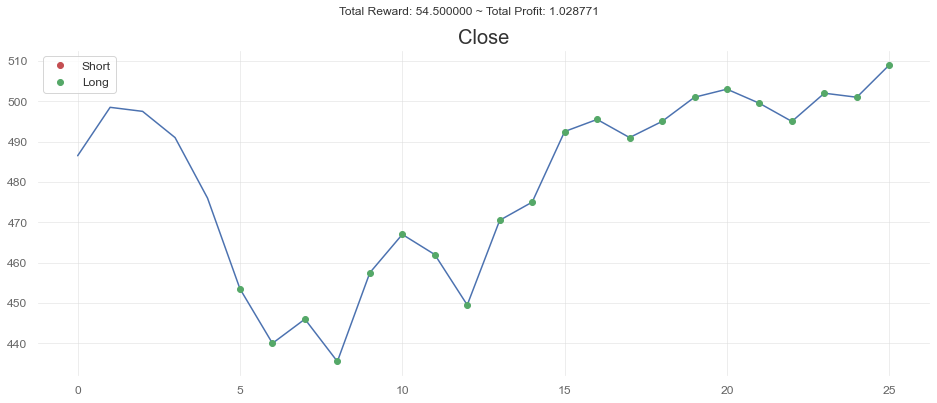

In [18]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(未含手續費) ↓↓↓


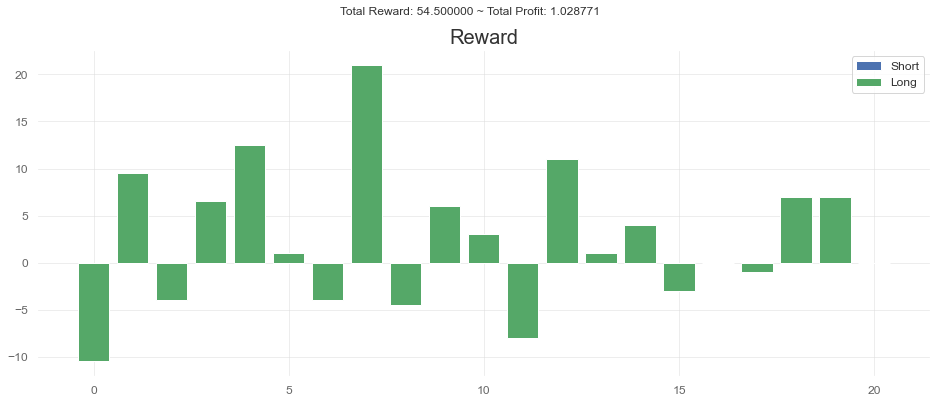

In [19]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


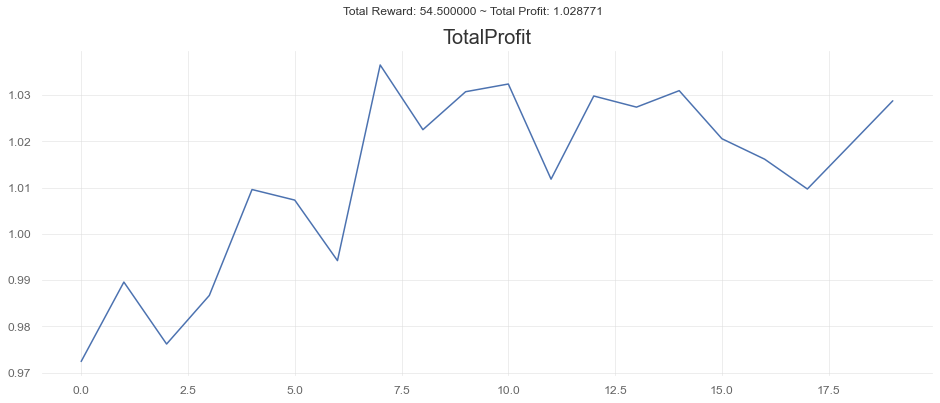

In [20]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------